# Setup environment

In [1]:
import tensorflow as tf
import numpy as np
from vizdoom import *

import random
import time
from skimage import transform
from datetime import datetime

from collections import deque
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))
    
with tf.Session() as sess:
  devices = sess.list_devices()

print(devices)

[[22. 28.]
 [49. 64.]]
[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 1154133952554002530), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 17311287738914215129), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 9706294730617260535), _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 5452267520, 10271867046152174296)]


In [3]:
def create_environment(visible=False):
    game = DoomGame()
    game.load_config("scenarios/deadly_corridor.cfg")
                                
    game.set_window_visible(visible)
    
    game.init()
    
    possible_actions = np.identity(7, dtype=int).tolist()
    
    return game, possible_actions

In [4]:
game, possible_actions = create_environment(visible=False)

In [5]:
def test_environment(game, actions):
    episodes = 10
    for i in range(episodes):
        game.new_episode()
        while not game.is_episode_finished():
            state = game.get_state()
            img = state.screen_buffer
            misc = state.game_variables
            action = random.choice(actions)
            #print(action)
            reward = game.make_action(action)
            #print ("\treward:", reward)
            time.sleep(0.007)
        print ("Result:", game.get_total_reward())
        time.sleep(1)
    game.close()

In [6]:
#test_environment(game, possible_actions)

# Util functions

In [7]:
def preprocess_frame(frame):
    cropped_frame = frame[15:-5,20:-20]
    normalized_frame = cropped_frame/255.0
    resized_frame = transform.resize(normalized_frame, [100, 120])
    return resized_frame

In [8]:
stack_size = 4

def init_deque():
    return deque([np.zeros((100, 120), dtype=np.int) for i in range(stack_size)], maxlen=4)

stacked_frames = init_deque()

def stack_frames(stacked_frames, state, is_new_episode):
    frame = preprocess_frame(state)
    
    if is_new_episode:
        stacked_frames = init_deque()
        for _ in range(4):
            stacked_frames.append(frame)
            
    else:
        stacked_frames.append(frame)
        
    stacked_state = np.stack(stacked_frames, axis=2)
    
    return stacked_state, stacked_frames

# Setup hyperparams

In [9]:
### MODEL
state_size = [100,120,4]
action_size = game.get_available_buttons_size()
learning_rate = 25e-5

### TRAINING
total_episodes = 50000
max_steps = 5000
batch_size = 64

# FIXED Q TARGETS
max_tau = 10000

# EXPLORATION for epsilon greedy strategy
explore_start = 1.0
explore_stop = 0.01
decay_rate = 5e-5

# Q LEARNING
gamma = 0.95 # Discounting rate

### MEMORY
## If you have GPU change to 1 million
pretrain_length = 1000000
memory_size = 16000

### MODIFY THIS TO FALSE IF YOU JUST WANT TO SEE THE TRAINED AGENT
training = True

## TURN THIS TO TRUE IF YOU WANT TO RENDER THE ENVIRONMENT
episode_render = False

# Setup network

In [10]:
class DDDQNNet:
    def __init__(self, state_size, action_size, learning_rate, name):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.name = name
        
        with tf.variable_scope(self.name):
            tempArray = [None]
            for i in state_size:
                tempArray.append(i)
            
            self.inputs_ = tf.placeholder(tf.float32, tempArray, name="inputs")
            #self.inputs_ = tf.placeholder(tf.float32, [None, *state_size], name="inputs")
            
            self.ISWeights_ = tf.placeholder(tf.float32, [None, 1], name="IS_weights")
            self.actions_ = tf.placeholder(tf.float32, [None, action_size], name="actions_")
            self.target_Q = tf.placeholder(tf.float32, [None], name="target")
            
            """
            First convnet
            CNN
            ELU
            """
            # Input is 100x120x4
            self.conv1 = tf.layers.conv2d(inputs = self.inputs_,
                                         filters = 32,
                                         kernel_size = [8,8],
                                         strides=[4,4],
                                         padding="VALID",
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                         name="conv1")
            self.conv1_out = tf.nn.elu(self.conv1, name="conv1_out")
            
            """
            Second convnet
            CNN
            ELU
            """
            self.conv2 = tf.layers.conv2d(inputs = self.conv1_out,
                                         filters = 64,
                                         kernel_size = [4,4],
                                         strides = [2,2],
                                         padding = "VALID",
                                         kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d(),
                                         name = "conv2")
            self.conv2_out = tf.nn.elu(self.conv2, name = "conv2_out")
            
            """
            Third convnet
            CNN
            ELU
            """
            self.conv3 = tf.layers.conv2d(inputs = self.conv2_out,
                                         filters = 128,
                                         kernel_size = [4,4],
                                         strides = [2,2],
                                         padding = "VALID",
                                         kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d(),
                                         name = "conv3")
            self.conv3_out = tf.nn.elu(self.conv3, name="conv3_out")
            
            self.flatten = tf.layers.flatten(self.conv3_out)
            
            ## Here we separate into two streams
            # The one that calculates V(s)
            self.value_fc = tf.layers.dense(inputs = self.flatten,
                                           units = 512,
                                           activation = tf.nn.elu,
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                           name="value_fc")
            self.value = tf.layers.dense(inputs=self.value_fc,
                                        units=1,
                                        activation=None,
                                        kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                        name="value")
            
            # The one that calculates A(s, a)
            self.advantage_fc = tf.layers.dense(inputs=self.flatten,
                                               units=512,
                                               activation=tf.nn.elu,
                                               kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                               name="advantage_fc")
            self.advantage = tf.layers.dense(inputs=self.advantage_fc,
                                            units = self.action_size,
                                            activation=None,
                                            kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                            name="advantages")
            
            # Aggregating layer
            # Q(s,a) = V(s) + (A(s,a) - 1/|A|*sum A(s,a'))
            self.output = self.value + tf.subtract(self.advantage, tf.reduce_mean(self.advantage, axis=1, keepdims=True))
            
            # Q is out predicted Q value.
            self.Q = tf.reduce_sum(tf.multiply(self.output, self.actions_), axis=1)
            
            # The loss is the difference between our predicted Q_values and the Q_target
            self.absolute_errors = tf.abs(self.target_Q - self.Q)# 
            
            # Sum(Qtarget - Q)^2
            self.loss = tf.reduce_mean(tf.square(self.target_Q - self.Q))
            
            self.optimizer = tf.train.RMSPropOptimizer(self.learning_rate).minimize(self.loss)    

In [11]:
# Reset the graph
tf.reset_default_graph()

# Instantiate the DQNetwork
DQNetwork = DDDQNNet(state_size, action_size, learning_rate, name="DQNetwork")

# Instantiate the target network
TargetNetwork = DDDQNNet(state_size, action_size, learning_rate, name="TargetNetwork")


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.


In [12]:
class SumTree(object):
    data_pointer = 0
    
    """
    Here we initialize the tree with all nodes = 0, 
    and initialize the data with all values = 0
    """
    def __init__(self, capacity):
        self.capacity = capacity # Number of leaf nodes that contains experiences
        """
        Generate the tree with all nodes values = 0
        To understand this calculation (2 * capacity - 1) 
        look at the schema above.
        Rememeber we are in a binary node (each node has 
        max 2 children) so 2x.
        of leaf (capacity) - 1 (root node).
        Parent nodes = capacity - 1.
        Leaf nodes = capacity.
        """
        self.tree = np.zeros(2 * capacity - 1)
        
        """
        tree:
            0
           / \
          0   0
         / \ / \
        0  0 0  0 [Size: capacity] it's at this line we have the priority scores
        """
        
        # Contains the experiences (so the size of the data equals capacity)
        self.data = np.zeros(capacity, dtype=object)
        
    """
    Here we add our priority score to the sumtree leaf 
    and the experience to data
    """
    def add(self, priority, data):
        # Look at what index we want to put the experience
        tree_index = self.data_pointer + self.capacity - 1
        
        """ tree:
            0
           / \
          0   0
         / \ / \
tree_index 0 0 0  We fill the leaves from left to right
        """
        
        # Update data frame
        self.data[self.data_pointer] = data
        
        # Update the leaf
        self.update(tree_index, priority)
        
        self.data_pointer += 1
        
        # If we're above the capacity, go back to first index
        if self.data_pointer >= self.capacity:
            self.data_pointer = 0
        
    """
    Update the leaf priority score and propagate the change 
    through the tree
    """
    def update(self, tree_index, priority):
        # Change = new priority score - former priority score
        change = priority - self.tree[tree_index]
        self.tree[tree_index] = priority
        
        # then propagate the change through the tree
        while tree_index != 0:
            
            """
            Here we want to access the line above
            THE NUMBERS IN THIS TREE ARE THE INDEXES NOT THE PRIORITY VALUES
            
                0
               / \
              1   2
             / \ / \
            3  4 5  [6] 
            
            If we are in leaf at index 6, we updated the priority score
            We need then to update index 2 node
            So tree_index = (tree_index - 1) // 2
            tree_index = (6-1)//2
            tree_index = 2 (because // round the result)
            """
            tree_index = (tree_index - 1) // 2
            self.tree[tree_index] += change
            
    """
    Here we get the leaf_index, priority value of that leaf and experience associated with that index
    """
    def get_leaf(self, v):
        """
        Tree structure and array storage:
        Tree index:
             0         -> storing priority sum
            / \
          1     2
         / \   / \
        3   4 5   6    -> storing priority for experiences
        Array type for storing:
        [0,1,2,3,4,5,6]
        """
        parent_index = 0
        
        while True: #the while loop is faster than the method in the reference code
            left_child_index = 2 * parent_index + 1
            right_child_index = left_child_index + 1
            
            # If we reach bottom, end the search
            if left_child_index >= len(self.tree):
                leaf_index = parent_index
                break
            
            else: # downward search, always search for a higher priority node
                
                if v <= self.tree[left_child_index]:
                    parent_index = left_child_index
                
                else:
                    v -= self.tree[left_child_index]
                    parent_index = right_child_index
        
        data_index = leaf_index - self.capacity + 1
        
        return leaf_index, self.tree[leaf_index], self.data[data_index]
    
    @property
    def total_priority(self):
        return self.tree[0] # Returns the root node 
        

Here we don't use deque anymore

In [13]:
class Memory(object): # stored as (s, a, r, s_) in SumTree
    """
    This SumTree code is modified version and the original code is from:
    https://github.com/jaara/AI-blog/blob/master/Seaquest-DDQN-PER.py
    """
    PER_e = 0.01 # Hyperparameter that we use to avoid some experiences to have 0 probability of being taken
    PER_a = 0.6 # Hyperparameter that we use to make tradeoff between taking only experiences with hight probabilities and sampling randomly
    PER_b = 0.4 # Importance-sampling, from initial value increasing to 1
    
    PER_b_increment_per_sampling = 0.001
    
    absolute_error_upper = 1. # clipped as abs error
    
    def __init__(self, capacity):
        # Making the tree
        """
        Remember that our tree is composed of a sum tree that contains the priority scores at it's leaf nodes
        And also a data array
        We don't use deque because it means that at each timestep our experiences change index by one.
        We prefer to use a simple array and to overwrite when the memory is full.
        """
        self.tree = SumTree(capacity)
        
    """
    Store a new experience in our tree
    Each new experience have a score of max_prority (it will be then improved when we use this exp to train our DDQN)
    """
    def store(self, experience):
        # Find the max priority
        max_priority = np.max(self.tree.tree[-self.tree.capacity:])
        
        # If max priority = 0 we can't set priority = 0 since this exp will never have a chance to be selected
        # So we use a minimum priority
        if max_priority == 0:
            max_priority = self.absolute_error_upper
            
        self.tree.add(max_priority, experience) # set the max p for new p
        
    """
    - First, to sample a minibatch of size k, the range [0, priority_total] is divided into k ranges.
    - Then, a value is uniformly sampled from each range.
    - We then search in the sumtree, the experiences where the priority score correspond to sample values are retrived from.
    - Then, we calculate IS weights for each minibatch element
    """
    def sample(self, n):
        # Create a sample array that will contain the minibatch
        memory_b = []
        
        b_idx, b_ISWeights = np.empty((n,), dtype=np.int32), np.empty((n,1), dtype=np.float32)
        
        # Calculate the priority segment
        # Here, as explained in the paper, we divide the Range[0, ptotal] into n ranges
        priority_segment = self.tree.total_priority / n # priority segment
        
        # We increase the PER_b each time we sample a new minibatch
        self.PER_b = np.min([1., self.PER_b + self.PER_b_increment_per_sampling]) # max = 1
        
        # Calc the max_weight
        p_min = np.min(self.tree.tree[-self.tree.capacity:]) / self.tree.total_priority
        max_weight = (p_min * n) ** (-self.PER_b)
        
        for i in range(n):
            """
            A value is uniformly sampled from each range
            """
            a, b = priority_segment * i, priority_segment * (i + 1)
            value = np.random.uniform(a, b)
            
            """
            Experience that correspond to each value is retrieved
            """
            index, priority, data = self.tree.get_leaf(value)
            
            #P(j)
            sampling_probabilities = priority / self.tree.total_priority
            
            # IS = (1/N * 1/P(i))**b /max wi == (N*P(i))**-b /max wi
            b_ISWeights[i,0] = np.power(n * sampling_probabilities, -self.PER_b)/max_weight
            
            b_idx[i] = index
            experience = [data]
            memory_b.append(experience)
        
        return b_idx, memory_b, b_ISWeights
    
    """
    Update the prioritues on the tree
    """
    def batch_update(self, tree_idx, abs_errors):
        abs_errors += self.PER_e 
        clipped_errors = np.minimum(abs_errors, self.absolute_error_upper) # convert to abs and avoid 0
        ps = np.power(clipped_errors, self.PER_a)
        
        for ti, p in zip(tree_idx, ps):
            self.tree.update(ti, p)    

Here we'll deal with the empty memory problem: we pre-populate our memory by taking random actions and storing the experience

In [14]:
#plt.imshow(np.rollaxis(state, 0, 3))

In [15]:
pretrain_length

1000000

In [16]:
# Instantiate memory
memory = Memory(memory_size)

# Render the environment
game.new_episode()

for i in range(pretrain_length):
    # If it's the first step
    if i%50000 == 0:
        print i
    
    if i == 0:
        # First we need a state
        state = game.get_state().screen_buffer
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        
    # Random action
    action = random.choice(possible_actions)
    
    # Get the rewards
    reward = game.make_action(action)
    
    done = game.is_episode_finished()
    
    if done:
        # We finished the episode
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        experience = state, action, reward, next_state, done
        memory.store(experience)
        
        game.new_episode()
        
        state = game.get_state().screen_buffer
        
        # Stack the frames
        state, stacked_frames = stack_frames(stacked_frames, state, is_new_episode=True)
        
    else:
        # Get the next state
        next_state = game.get_state().screen_buffer
        next_state, stacked_frames = stack_frames(stacked_frames, next_state, is_new_episode=False)
        
        # Add experience to memory
        experience = state, action, reward, next_state, done
        memory.store(experience)
        
        # Our state is now the next_state
        state = next_state        
        

0
50000
100000
150000
200000
250000
300000
350000
400000
450000
500000
550000
600000
650000
700000
750000
800000
850000
900000
950000


## Step 7: Set up Tensorboard

to launch tensorboard : tensorboard --logdir=/tensorboard/dddqn/1

In [17]:
# Setup TensorBoard Writer
writer = tf.summary.FileWriter("/tensorboard/dddwn/1")

## Losses
tf.summary.scalar("Loss", DQNetwork.loss)

write_op = tf.summary.merge_all()

## Step 8: Train our agent 🏃🏻‍♂️
Our algorithm:

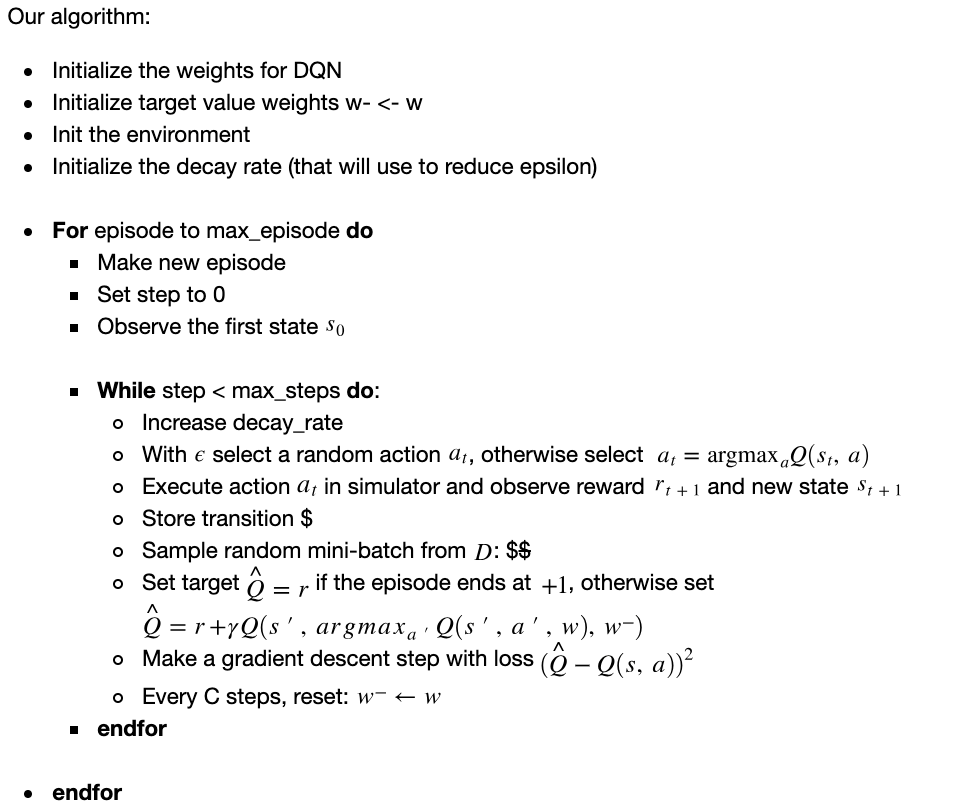

In [18]:
"""
This function will do the part
With ϵ select a random action at=at, otherwise select at=argmaxaQ(st,a)
"""
def predict_action(explore_start, explore_stop, decay_rate, decay_step, state, actions):
    ## EPSILON GREEDY STRATEGY
    # Choose action a from state s using epsilon greedy.
    ## First we randomize a number
    exp_exp_tradeoff = np.random.rand()
    
    # Here we'll use an improve version of our epsilon greedy strategy used in Q-learning notebook
    explore_probabilty = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * decay_step)
    
    if (explore_probabilty > exp_exp_tradeoff):
        # Perform random action
        action = random.choice(possible_actions)
    else:
        # Get action from Q-network
        # Estimate the Qs values state
        #Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state.reshape((1, *state.shape))})
        #Fix
        temp = [1]
        for i in state.shape:
            temp.append(i)
        Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state.reshape((temp))})
        
        
        
        choice = np.argmax(Qs)
        action = possible_actions[int(choice)]
        
    return action, explore_probabilty

In [19]:
"""
This function helps os to copy one set of variables to another
In our case we use it when we want to copy the parameters of DQN to Target_network
"""
def update_target_graph():
    
    # Get the parameters of our DQNNetwork
    from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "DQNetwork")
    
    # Get the parameters of our Target_network
    to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "TargetNetwork")
    
    op_holder = []
    
    # Update our target_network parameters with DQNNetwork parameters
    for from_var, to_var in zip(from_vars, to_vars):
        op_holder.append(to_var.assign(from_var))
    return op_holder

In [ ]:
# Saver will help us to save our model
saver = tf.train.Saver()
# Keep track of all rewards total for each batch
allRewards = []

total_rewards = 0
maximumRewardRecorded = 0
mean_reward_total = []
epoch = 1
average_reward = []


now = datetime.now()
date_time = now.strftime("%m/%d/%Y, %H:%M:%S")

with open("logs/runningTimeDDDQN.txt", "a") as myfile:
    myfile.write("Starting:\n")
    myfile.write("date and time:" + date_time + "\n")



if training == True:
    with tf.Session() as sess:
        # Init variables 
        sess.run(tf.global_variables_initializer())
        
        # Init decay rate (that we will use to reduce epsilon)
        decay_step = 0
        
        tau = 0
        
        game.init()
        
        # Update the parameters of our TargetNetwork
        update_target = update_target_graph()
        sess.run(update_target)
        
        for episode in range(total_episodes):
            
            step = 0
            
            # Init the rewards of the episode
            episode_rewards = []
            
            game.new_episode()
            
            state = game.get_state().screen_buffer
            
            # Remember that stack frame function also call our preprocess function.
            state, stacked_frames = stack_frames(stacked_frames, state, True)
            
            while step < max_steps:
                step += 1
                
                # Increase the C step
                tau += 1
                
                # Increase decay_step
                decay_step += 1
                
                # With ϵ select a random action at = at, otherwise select a = argmaxQ(st,a)
                action, explore_probability = predict_action(explore_start, explore_stop, decay_rate, decay_step, state, possible_actions)
                
                # Perform the action
                reward = game.make_action(action)
                
                done = game.is_episode_finished()
                
                # Add the reward to total reward
                episode_rewards.append(reward)
                
                # If the game is finished
                if done:
                    # the episode ends so no next state
                    next_state = np.zeros((120, 140), dtype=np.int)
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
                    
                    # Set step = max_steps to end the episode
                    step = max_steps
                    
                    # Get the total reward of the episode
                    total_reward = np.sum(episode_rewards)
                    
                    #print('Episode: {}'.format(episode),
                    #     'Total reward: {}'.format(total_reward),
                    #     'Training loss: {:.4f}'.format(loss),
                    #     'Explore P: {:.4f}'.format(explore_probability))
                    
                    
                     ### These part is used for analytics
                    # Calculate the total reward ot the batch
                    total_reward_of_that_batch = np.sum(total_reward)
                    allRewards.append(total_reward_of_that_batch)

                    # Calculate the mean reward of the batch
                    # Total rewards of batch / nb episodes in that batch
                    mean_reward_of_that_batch = np.divide(total_reward_of_that_batch, batch_size)
                    mean_reward_total.append(mean_reward_of_that_batch)

                    # Calculate the average reward of all training
                    # mean_reward_of_that_batch / epoch
                    average_reward_of_all_training = np.divide(np.sum(mean_reward_total), episode)

                    # Calculate maximum reward recorded 
                    maximumRewardRecorded = np.amax(allRewards)

                    
                    
                    
                    
                    print("==========================================")
                    print("Epoch: ", episode, "/", total_episodes)
                    print("-----------")
                    print("Number of training episodes: {}".format(batch_size))
                    print("Total reward: {}".format(total_reward_of_that_batch, batch_size))
                    print("Mean Reward of that batch {}".format(mean_reward_of_that_batch))
                    print("Average Reward of all training: {}".format(average_reward_of_all_training))
                    print("Max reward for a batch so far: {}".format(maximumRewardRecorded))

                    
                    
                    
                    print "Episode: %f  Total reward: %f  Training loss: %f  Explore P: %f  " %(episode,total_reward,loss,explore_probability)    
                    
                    
                    # Add experience to memory
                    experience = state, action, reward, next_state, done
                    memory.store(experience)
                    
                else:
                    # Get the next state
                    next_state = game.get_state().screen_buffer
                    
                    # Stack the frame of the next_state
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
                    
                    # Add experience to memory
                    experience = state, action, reward, next_state, done
                    memory.store(experience)
                    
                    # state+1 is now our current state
                    state = next_state
                    
                ### LEARNING PART
                # Obtain random mini-batch from memory
                tree_idx, batch, ISWeights_mb = memory.sample(batch_size)
                
                states_mb = np.array([each[0][0] for each in batch], ndmin=3)
                actions_mb = np.array([each[0][1] for each in batch])
                rewards_mb = np.array([each[0][2] for each in batch])
                next_states_mb = np.array([each[0][3] for each in batch], ndmin=3)
                dones_mb = np.array([each[0][4] for each in batch])
                
                target_Qs_batch = []
                
                ### DOUBLE DQN Logic
                # Use DQNNetwork to select the action to take at next_state (a') (action with the highest Q-value)
                # Use TargetNetwork to calculate the Q_val of Q(s', a')
                # Get Q values for next_state
                q_next_state = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: next_states_mb})
                
                # Calculate Qtarget for all action at that state
                q_target_next_state = sess.run(TargetNetwork.output, feed_dict = {TargetNetwork.inputs_: next_states_mb})
                
                # Set Q_target = r if the episode ends at s+1, otherwise set Q_target = r + gamma * Qtarget(s',a')
                for i in range(0, len(batch)):
                    terminal = dones_mb[i]
                    
                    # We got a'
                    action = np.argmax(q_next_state[i])
                    
                    # If we are in a terminal state, only equals reward
                    if terminal:
                        target_Qs_batch.append(rewards_mb[i])
                        
                    else:
                        # Take the Qtarget for action a'
                        target = rewards_mb[i] + gamma * q_target_next_state[i][action] 
                        target_Qs_batch.append(target) 
                # shouldn't the action be chosen from the targetnetwork and the q-value be taken from the original network??
                # Also is this even a double dqn? isn't it just fixed target logic??
                target_mb = np.array([each for each in target_Qs_batch]) # What does this get us?
                
                _, loss, absolute_errors = sess.run([DQNetwork.optimizer, DQNetwork.loss, DQNetwork.absolute_errors],
                                                   feed_dict={DQNetwork.inputs_: states_mb,
                                                             DQNetwork.target_Q: target_mb,
                                                             DQNetwork.actions_: actions_mb,
                                                             DQNetwork.ISWeights_: ISWeights_mb})
                
                # Update priority
                memory.batch_update(tree_idx, absolute_errors)
                
                # Write TF Summaries
                summary = sess.run(write_op, feed_dict={DQNetwork.inputs_: states_mb,
                                                       DQNetwork.target_Q: target_mb,
                                                       DQNetwork.actions_: actions_mb,
                                                       DQNetwork.ISWeights_: ISWeights_mb})
                writer.add_summary(summary, episode)
                writer.flush()
                
                if tau > max_tau:
                    # Update the parameters of our TargetNetwork with DQN_weights
                    update_target = update_target_graph()
                    sess.run(update_target)
                    tau = 0
                    print("Model updated")
                    
            # Save model every 5 episodes
            if episode % 5 == 0:
                save_path = saver.save(sess, "./models/modelDDDQN.ckpt")
                print("Model Saved")
                now = datetime.now()
                date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
                with open("logs/runningTimeDDDQN.txt", "a") as myfile:
                    myfile.write("date and time:" + date_time + "\n")


('Epoch: ', 0, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -102.309371948
Mean Reward of that batch -1.59858393669
Average Reward of all training: -inf
Max reward for a batch so far: -102.309371948
Episode: 0.000000  Total reward: -102.309372  Training loss: 2.029893  Explore P: 0.996196  
Model Saved
('Epoch: ', 1, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -78.1161346436
Mean Reward of that batch -1.22056460381
Average Reward of all training: -2.8191485405
Max reward for a batch so far: -78.1161346436
Episode: 1.000000  Total reward: -78.116135  Training loss: 2.609484  Explore P: 0.991032  
('Epoch: ', 2, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -92.361618042
Mean Reward of that batch -1.44315028191
Average Reward of all training: -2.1311494112
Max reward for a batch so far: -78.1161346436
Episode: 2.000000  Total reward: -92.361618  Training loss: 1.657232  Explore P: 0.987067  
('Epoch: ', 3, '/', 50

('Epoch: ', 22, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -113.683334351
Mean Reward of that batch -1.77630209923
Average Reward of all training: -1.60331406377
Max reward for a batch so far: -54.3221282959
Episode: 22.000000  Total reward: -113.683334  Training loss: 77.028206  Explore P: 0.894617  
('Epoch: ', 23, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -115.998596191
Mean Reward of that batch -1.81247806549
Average Reward of all training: -1.6124081508
Max reward for a batch so far: -54.3221282959
Episode: 23.000000  Total reward: -115.998596  Training loss: 88.766426  Explore P: 0.891350  
('Epoch: ', 24, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -93.7902984619
Mean Reward of that batch -1.46547341347
Average Reward of all training: -1.60628587008
Max reward for a batch so far: -54.3221282959
Episode: 24.000000  Total reward: -93.790298  Training loss: 48.336189  Explore P: 0.886560  
('Epoch: ', 

('Epoch: ', 44, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -114.042175293
Mean Reward of that batch -1.78190898895
Average Reward of all training: -1.61704806306
Max reward for a batch so far: -54.3221282959
Episode: 44.000000  Total reward: -114.042175  Training loss: 5.839702  Explore P: 0.809875  
('Epoch: ', 45, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -112.358200073
Mean Reward of that batch -1.75559687614
Average Reward of all training: -1.62012692557
Max reward for a batch so far: -54.3221282959
Episode: 45.000000  Total reward: -112.358200  Training loss: 6.531354  Explore P: 0.805766  
Model Saved
('Epoch: ', 46, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -75.1456756592
Mean Reward of that batch -1.17415118217
Average Reward of all training: -1.61043180072
Max reward for a batch so far: -54.3221282959
Episode: 46.000000  Total reward: -75.145676  Training loss: 4.879717  Explore P: 0.802589  
('

Model Saved
('Epoch: ', 66, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -68.3261566162
Mean Reward of that batch -1.06759619713
Average Reward of all training: -1.60362892079
Max reward for a batch so far: -54.3221282959
Episode: 66.000000  Total reward: -68.326157  Training loss: 3.410248  Explore P: 0.737894  
('Epoch: ', 67, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -115.995010376
Mean Reward of that batch -1.81242203712
Average Reward of all training: -1.60674523596
Max reward for a batch so far: -54.3221282959
Episode: 67.000000  Total reward: -115.995010  Training loss: 3.229299  Explore P: 0.732563  
('Epoch: ', 68, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -105.626541138
Mean Reward of that batch -1.65041470528
Average Reward of all training: -1.60738743403
Max reward for a batch so far: -54.3221282959
Episode: 68.000000  Total reward: -105.626541  Training loss: 2.302432  Explore P: 0.730795  
('

('Epoch: ', 88, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -85.894821167
Mean Reward of that batch -1.34210658073
Average Reward of all training: -1.54545052756
Max reward for a batch so far: 73.7519683838
Episode: 88.000000  Total reward: -85.894821  Training loss: 1.824164  Explore P: 0.662039  
('Epoch: ', 89, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -77.7051696777
Mean Reward of that batch -1.21414327621
Average Reward of all training: -1.54172797417
Max reward for a batch so far: 73.7519683838
Episode: 89.000000  Total reward: -77.705170  Training loss: 5.353836  Explore P: 0.658398  
('Epoch: ', 90, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -103.578720093
Mean Reward of that batch -1.61841750145
Average Reward of all training: -1.54258008003
Max reward for a batch so far: 73.7519683838
Episode: 90.000000  Total reward: -103.578720  Training loss: 1.492094  Explore P: 0.654906  
Model Saved
('Epoch

('Epoch: ', 110, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -88.7671508789
Mean Reward of that batch -1.38698673248
Average Reward of all training: -1.49158349254
Max reward for a batch so far: 73.7519683838
Episode: 110.000000  Total reward: -88.767151  Training loss: 19.811468  Explore P: 0.600757  
Model Saved
('Epoch: ', 111, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -95.3483581543
Mean Reward of that batch -1.48981809616
Average Reward of all training: -1.49156758807
Max reward for a batch so far: 73.7519683838
Episode: 111.000000  Total reward: -95.348358  Training loss: 243.963318  Explore P: 0.599488  
('Epoch: ', 112, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -63.7238006592
Mean Reward of that batch -0.9956843853
Average Reward of all training: -1.48714005947
Max reward for a batch so far: 73.7519683838
Episode: 112.000000  Total reward: -63.723801  Training loss: 169.576843  Explore P: 0.597194

('Epoch: ', 132, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -77.6509399414
Mean Reward of that batch -1.21329593658
Average Reward of all training: -1.45332199516
Max reward for a batch so far: 73.7519683838
Episode: 132.000000  Total reward: -77.650940  Training loss: 3.333860  Explore P: 0.548052  
('Epoch: ', 133, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 37.390335083
Mean Reward of that batch 0.584223985672
Average Reward of all training: -1.43800210056
Max reward for a batch so far: 73.7519683838
Episode: 133.000000  Total reward: 37.390335  Training loss: 2.430693  Explore P: 0.543151  
('Epoch: ', 134, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -78.6457519531
Mean Reward of that batch -1.22883987427
Average Reward of all training: -1.43644118843
Max reward for a batch so far: 73.7519683838
Episode: 134.000000  Total reward: -78.645752  Training loss: 5.950104  Explore P: 0.541076  
('Epoch: ', 135,

('Epoch: ', 154, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -48.9103546143
Mean Reward of that batch -0.764224290848
Average Reward of all training: -1.39997475488
Max reward for a batch so far: 73.7519683838
Episode: 154.000000  Total reward: -48.910355  Training loss: 7.270210  Explore P: 0.501079  
('Epoch: ', 155, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -68.8527679443
Mean Reward of that batch -1.07582449913
Average Reward of all training: -1.39788346291
Max reward for a batch so far: 73.7519683838
Episode: 155.000000  Total reward: -68.852768  Training loss: 4.641735  Explore P: 0.499167  
Model Saved
('Epoch: ', 156, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -11.5598449707
Mean Reward of that batch -0.180622577667
Average Reward of all training: -1.39008050851
Max reward for a batch so far: 73.7519683838
Episode: 156.000000  Total reward: -11.559845  Training loss: 124.752510  Explore P: 0.497263

Model Saved
('Epoch: ', 176, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -98.601272583
Mean Reward of that batch -1.54064488411
Average Reward of all training: -1.34113000198
Max reward for a batch so far: 112.295394897
Episode: 176.000000  Total reward: -98.601273  Training loss: 6.978622  Explore P: 0.463822  
('Epoch: ', 177, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 27.6477203369
Mean Reward of that batch 0.431995630264
Average Reward of all training: -1.33111234304
Max reward for a batch so far: 112.295394897
Episode: 177.000000  Total reward: 27.647720  Training loss: 5.611014  Explore P: 0.461220  
('Epoch: ', 178, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -87.4248962402
Mean Reward of that batch -1.36601400375
Average Reward of all training: -1.33130841978
Max reward for a batch so far: 112.295394897
Episode: 178.000000  Total reward: -87.424896  Training loss: 3.875509  Explore P: 0.460093  
('Ep

('Epoch: ', 198, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -70.0793304443
Mean Reward of that batch -1.09498953819
Average Reward of all training: -1.29120216346
Max reward for a batch so far: 112.295394897
Episode: 198.000000  Total reward: -70.079330  Training loss: 4.327524  Explore P: 0.428784  
('Epoch: ', 199, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -84.0258789062
Mean Reward of that batch -1.31290435791
Average Reward of all training: -1.29131121971
Max reward for a batch so far: 112.295394897
Episode: 199.000000  Total reward: -84.025879  Training loss: 3.523412  Explore P: 0.427759  
('Epoch: ', 200, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -52.3852539062
Mean Reward of that batch -0.818519592285
Average Reward of all training: -1.28894726157
Max reward for a batch so far: 112.295394897
Episode: 200.000000  Total reward: -52.385254  Training loss: 7.360634  Explore P: 0.426216  
Model Saved


('Epoch: ', 220, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -63.7899780273
Mean Reward of that batch -0.996718406677
Average Reward of all training: -1.25058473565
Max reward for a batch so far: 112.295394897
Episode: 220.000000  Total reward: -63.789978  Training loss: 36.193497  Explore P: 0.396799  
Model Saved
('Epoch: ', 221, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -87.4182891846
Mean Reward of that batch -1.36591076851
Average Reward of all training: -1.25110657291
Max reward for a batch so far: 112.295394897
Episode: 221.000000  Total reward: -87.418289  Training loss: 5.921720  Explore P: 0.394639  
('Epoch: ', 222, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -42.2473907471
Mean Reward of that batch -0.660115480423
Average Reward of all training: -1.24844445087
Max reward for a batch so far: 112.295394897
Episode: 222.000000  Total reward: -42.247391  Training loss: 11.279354  Explore P: 0.393161

('Epoch: ', 242, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 15.4794158936
Mean Reward of that batch 0.241865873337
Average Reward of all training: -1.1939865134
Max reward for a batch so far: 148.252197266
Episode: 242.000000  Total reward: 15.479416  Training loss: 15.136840  Explore P: 0.365049  
('Epoch: ', 243, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -72.1021575928
Mean Reward of that batch -1.12659621239
Average Reward of all training: -1.19370918706
Max reward for a batch so far: 148.252197266
Episode: 243.000000  Total reward: -72.102158  Training loss: 66.485947  Explore P: 0.363684  
('Epoch: ', 244, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -7.24971008301
Mean Reward of that batch -0.113276720047
Average Reward of all training: -1.18928118514
Max reward for a batch so far: 148.252197266
Episode: 244.000000  Total reward: -7.249710  Training loss: 32.907314  Explore P: 0.362220  
('Epoch: ', 2

('Epoch: ', 264, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -105.969406128
Mean Reward of that batch -1.65577197075
Average Reward of all training: -1.14645112825
Max reward for a batch so far: 148.252197266
Episode: 264.000000  Total reward: -105.969406  Training loss: 17.298145  Explore P: 0.340037  
('Epoch: ', 265, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -110.327453613
Mean Reward of that batch -1.72386646271
Average Reward of all training: -1.14863005404
Max reward for a batch so far: 148.252197266
Episode: 265.000000  Total reward: -110.327454  Training loss: 13.879841  Explore P: 0.339164  
Model Saved
('Epoch: ', 266, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -16.1740570068
Mean Reward of that batch -0.252719640732
Average Reward of all training: -1.14526196978
Max reward for a batch so far: 148.252197266
Episode: 266.000000  Total reward: -16.174057  Training loss: 26.487968  Explore P: 0.3379

Model Saved
('Epoch: ', 286, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -37.1189575195
Mean Reward of that batch -0.579983711243
Average Reward of all training: -1.11994133796
Max reward for a batch so far: 148.252197266
Episode: 286.000000  Total reward: -37.118958  Training loss: 4.942109  Explore P: 0.313249  
('Epoch: ', 287, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 27.8332061768
Mean Reward of that batch 0.434893846512
Average Reward of all training: -1.11452379376
Max reward for a batch so far: 148.252197266
Episode: 287.000000  Total reward: 27.833206  Training loss: 8.570064  Explore P: 0.312537  
('Epoch: ', 288, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -31.2266998291
Mean Reward of that batch -0.48791718483
Average Reward of all training: -1.11234807637
Max reward for a batch so far: 148.252197266
Episode: 288.000000  Total reward: -31.226700  Training loss: 4.960090  Explore P: 0.311300  
('

('Epoch: ', 308, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -29.3873748779
Mean Reward of that batch -0.459177732468
Average Reward of all training: -1.08362755063
Max reward for a batch so far: 148.252197266
Episode: 308.000000  Total reward: -29.387375  Training loss: 3.220962  Explore P: 0.289487  
('Epoch: ', 309, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -23.7955474854
Mean Reward of that batch -0.371805429459
Average Reward of all training: -1.08132391917
Max reward for a batch so far: 148.252197266
Episode: 309.000000  Total reward: -23.795547  Training loss: 11.689367  Explore P: 0.288343  
('Epoch: ', 310, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 57.230178833
Mean Reward of that batch 0.894221544266
Average Reward of all training: -1.07495119187
Max reward for a batch so far: 148.252197266
Episode: 310.000000  Total reward: 57.230179  Training loss: 10.391054  Explore P: 0.287288  
Model Saved


('Epoch: ', 330, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 17.8297729492
Mean Reward of that batch 0.278590202332
Average Reward of all training: -1.05180979498
Max reward for a batch so far: 148.252197266
Episode: 330.000000  Total reward: 17.829773  Training loss: 7.551186  Explore P: 0.266776  
Model Saved
('Epoch: ', 331, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 25.225189209
Mean Reward of that batch 0.39414358139
Average Reward of all training: -1.04744135577
Max reward for a batch so far: 148.252197266
Episode: 331.000000  Total reward: 25.225189  Training loss: 12.095493  Explore P: 0.265853  
('Epoch: ', 332, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -79.3143310547
Mean Reward of that batch -1.23928642273
Average Reward of all training: -1.04801920236
Max reward for a batch so far: 148.252197266
Episode: 332.000000  Total reward: -79.314331  Training loss: 3.675210  Explore P: 0.265227  
('Epoc

('Epoch: ', 352, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -5.83903503418
Mean Reward of that batch -0.0912349224091
Average Reward of all training: -1.02304366299
Max reward for a batch so far: 148.252197266
Episode: 352.000000  Total reward: -5.839035  Training loss: 7.297686  Explore P: 0.245193  
('Epoch: ', 353, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -85.4244537354
Mean Reward of that batch -1.33475708961
Average Reward of all training: -1.02392670386
Max reward for a batch so far: 148.252197266
Episode: 353.000000  Total reward: -85.424454  Training loss: 18.483974  Explore P: 0.244629  
('Epoch: ', 354, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -46.6897125244
Mean Reward of that batch -0.729526758194
Average Reward of all training: -1.02309506559
Max reward for a batch so far: 148.252197266
Episode: 354.000000  Total reward: -46.689713  Training loss: 7.654215  Explore P: 0.244102  
('Epoch: '

('Epoch: ', 374, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -42.9204101562
Mean Reward of that batch -0.670631408691
Average Reward of all training: -0.996764460987
Max reward for a batch so far: 148.252197266
Episode: 374.000000  Total reward: -42.920410  Training loss: 91.319916  Explore P: 0.228286  
('Epoch: ', 375, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 8.88557434082
Mean Reward of that batch 0.138837099075
Average Reward of all training: -0.99373619016
Max reward for a batch so far: 148.252197266
Episode: 375.000000  Total reward: 8.885574  Training loss: 29.469955  Explore P: 0.227806  
Model Saved
('Epoch: ', 376, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -65.0099029541
Mean Reward of that batch -1.01577973366
Average Reward of all training: -0.993794816606
Max reward for a batch so far: 148.252197266
Episode: 376.000000  Total reward: -65.009903  Training loss: 14.013274  Explore P: 0.226969 

Model Saved
('Epoch: ', 396, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -17.7070770264
Mean Reward of that batch -0.276673078537
Average Reward of all training: -0.969205175987
Max reward for a batch so far: 148.252197266
Episode: 396.000000  Total reward: -17.707077  Training loss: 8.742771  Explore P: 0.212837  
('Epoch: ', 397, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 33.0692138672
Mean Reward of that batch 0.516706466675
Average Reward of all training: -0.965462325502
Max reward for a batch so far: 148.252197266
Episode: 397.000000  Total reward: 33.069214  Training loss: 18.413542  Explore P: 0.212048  
('Epoch: ', 398, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 10.260848999
Mean Reward of that batch 0.16032576561
Average Reward of all training: -0.962633712208
Max reward for a batch so far: 148.252197266
Episode: 398.000000  Total reward: 10.260849  Training loss: 19.041031  Explore P: 0.211191  
(

('Epoch: ', 418, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -55.5427093506
Mean Reward of that batch -0.867854833603
Average Reward of all training: -0.938254343836
Max reward for a batch so far: 198.688308716
Episode: 418.000000  Total reward: -55.542709  Training loss: 19.195726  Explore P: 0.198520  
('Epoch: ', 419, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 25.1764068604
Mean Reward of that batch 0.393381357193
Average Reward of all training: -0.935076215671
Max reward for a batch so far: 198.688308716
Episode: 419.000000  Total reward: 25.176407  Training loss: 10.044784  Explore P: 0.197730  
('Epoch: ', 420, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -50.6182861328
Mean Reward of that batch -0.790910720825
Average Reward of all training: -0.934732964493
Max reward for a batch so far: 198.688308716
Episode: 420.000000  Total reward: -50.618286  Training loss: 6.152458  Explore P: 0.197308  
Model Sa

('Epoch: ', 440, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -49.1865386963
Mean Reward of that batch -0.76853966713
Average Reward of all training: -0.913694487919
Max reward for a batch so far: 198.688308716
Episode: 440.000000  Total reward: -49.186539  Training loss: 12.487282  Explore P: 0.184427  
Model Saved
('Epoch: ', 441, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -51.6650390625
Mean Reward of that batch -0.807266235352
Average Reward of all training: -0.913453154012
Max reward for a batch so far: 198.688308716
Episode: 441.000000  Total reward: -51.665039  Training loss: 6.867214  Explore P: 0.184017  
('Epoch: ', 442, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -50.9571685791
Mean Reward of that batch -0.796205759048
Average Reward of all training: -0.913187888413
Max reward for a batch so far: 198.688308716
Episode: 442.000000  Total reward: -50.957169  Training loss: 15.001586  Explore P: 0.183

('Epoch: ', 462, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 38.1486053467
Mean Reward of that batch 0.596071958542
Average Reward of all training: -0.89556025633
Max reward for a batch so far: 198.688308716
Episode: 462.000000  Total reward: 38.148605  Training loss: 15.058831  Explore P: 0.172569  
('Epoch: ', 463, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -29.2337036133
Mean Reward of that batch -0.456776618958
Average Reward of all training: -0.89461255949
Max reward for a batch so far: 198.688308716
Episode: 463.000000  Total reward: -29.233704  Training loss: 9.327608  Explore P: 0.171937  
('Epoch: ', 464, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -81.0021057129
Mean Reward of that batch -1.26565790176
Average Reward of all training: -0.895412226175
Max reward for a batch so far: 198.688308716
Episode: 464.000000  Total reward: -81.002106  Training loss: 13.800052  Explore P: 0.171565  
('Epoch: ',

('Epoch: ', 484, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -99.0625
Mean Reward of that batch -1.5478515625
Average Reward of all training: -0.876481567533
Max reward for a batch so far: 198.688308716
Episode: 484.000000  Total reward: -99.062500  Training loss: 119.404449  Explore P: 0.161632  
('Epoch: ', 485, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -35.9599914551
Mean Reward of that batch -0.561874866486
Average Reward of all training: -0.875832893922
Max reward for a batch so far: 198.688308716
Episode: 485.000000  Total reward: -35.959991  Training loss: 16.677673  Explore P: 0.161291  
Model Saved
('Epoch: ', 486, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 62.7782287598
Mean Reward of that batch 0.980909824371
Average Reward of all training: -0.872012435654
Max reward for a batch so far: 198.688308716
Episode: 486.000000  Total reward: 62.778229  Training loss: 15.177361  Explore P: 0.160687  
('

Model Saved
('Epoch: ', 506, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 470.478240967
Mean Reward of that batch 7.35122251511
Average Reward of all training: -0.822789760918
Max reward for a batch so far: 470.478240967
Episode: 506.000000  Total reward: 470.478241  Training loss: 18.912998  Explore P: 0.147890  
('Epoch: ', 507, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -97.1912078857
Mean Reward of that batch -1.51861262321
Average Reward of all training: -0.824162192599
Max reward for a batch so far: 470.478240967
Episode: 507.000000  Total reward: -97.191208  Training loss: 9.404879  Explore P: 0.147346  
('Epoch: ', 508, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -19.7916412354
Mean Reward of that batch -0.309244394302
Average Reward of all training: -0.823148574885
Max reward for a batch so far: 470.478240967
Episode: 508.000000  Total reward: -19.791641  Training loss: 12.239983  Explore P: 0.146990

('Epoch: ', 528, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 3.60412597656
Mean Reward of that batch 0.0563144683838
Average Reward of all training: -0.800263827497
Max reward for a batch so far: 470.478240967
Episode: 528.000000  Total reward: 3.604126  Training loss: 16.497540  Explore P: 0.137926  
('Epoch: ', 529, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 79.5846099854
Mean Reward of that batch 1.24350953102
Average Reward of all training: -0.796400361791
Max reward for a batch so far: 470.478240967
Episode: 529.000000  Total reward: 79.584610  Training loss: 123.894249  Explore P: 0.137403  
('Epoch: ', 530, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 70.154510498
Mean Reward of that batch 1.09616422653
Average Reward of all training: -0.792829485209
Max reward for a batch so far: 470.478240967
Episode: 530.000000  Total reward: 70.154510  Training loss: 11.740682  Explore P: 0.136913  
Model Saved
('E

('Epoch: ', 550, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -80.1974334717
Mean Reward of that batch -1.25308489799
Average Reward of all training: -0.773336884759
Max reward for a batch so far: 470.478240967
Episode: 550.000000  Total reward: -80.197433  Training loss: 20.347992  Explore P: 0.129057  
Model Saved
('Epoch: ', 551, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 160.16065979
Mean Reward of that batch 2.50251030922
Average Reward of all training: -0.767391608545
Max reward for a batch so far: 470.478240967
Episode: 551.000000  Total reward: 160.160660  Training loss: 13.557406  Explore P: 0.128339  
('Epoch: ', 552, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -4.76571655273
Mean Reward of that batch -0.0744643211365
Average Reward of all training: -0.766136305488
Max reward for a batch so far: 470.478240967
Episode: 552.000000  Total reward: -4.765717  Training loss: 17.594538  Explore P: 0.128061

('Epoch: ', 572, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -26.9108886719
Mean Reward of that batch -0.420482635498
Average Reward of all training: -0.750959830684
Max reward for a batch so far: 470.478240967
Episode: 572.000000  Total reward: -26.910889  Training loss: 15.009892  Explore P: 0.119849  
('Epoch: ', 573, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 24.5960388184
Mean Reward of that batch 0.384313106537
Average Reward of all training: -0.748978551562
Max reward for a batch so far: 470.478240967
Episode: 573.000000  Total reward: 24.596039  Training loss: 8.584547  Explore P: 0.119432  
('Epoch: ', 574, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 2.94630432129
Mean Reward of that batch 0.0460360050201
Average Reward of all training: -0.74759350878
Max reward for a batch so far: 470.478240967
Episode: 574.000000  Total reward: 2.946304  Training loss: 6.434383  Explore P: 0.119006  
('Epoch: ', 5

('Epoch: ', 594, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -64.28565979
Mean Reward of that batch -1.00446343422
Average Reward of all training: -0.742330154987
Max reward for a batch so far: 470.478240967
Episode: 594.000000  Total reward: -64.285660  Training loss: 8.941622  Explore P: 0.112874  
('Epoch: ', 595, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -27.9067077637
Mean Reward of that batch -0.436042308807
Average Reward of all training: -0.741815385498
Max reward for a batch so far: 470.478240967
Episode: 595.000000  Total reward: -27.906708  Training loss: 18.321045  Explore P: 0.112126  
Model Saved
('Epoch: ', 596, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -16.7007141113
Mean Reward of that batch -0.26094865799
Average Reward of all training: -0.74100856213
Max reward for a batch so far: 470.478240967
Episode: 596.000000  Total reward: -16.700714  Training loss: 6.753344  Explore P: 0.111713  

Model Saved
('Epoch: ', 616, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -99.9833526611
Mean Reward of that batch -1.56223988533
Average Reward of all training: -0.729153070357
Max reward for a batch so far: 470.478240967
Episode: 616.000000  Total reward: -99.983353  Training loss: 33.957458  Explore P: 0.105217  
('Epoch: ', 617, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -17.2829742432
Mean Reward of that batch -0.270046472549
Average Reward of all training: -0.728408975385
Max reward for a batch so far: 470.478240967
Episode: 617.000000  Total reward: -17.282974  Training loss: 14.625479  Explore P: 0.104874  
('Epoch: ', 618, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -42.868850708
Mean Reward of that batch -0.669825792313
Average Reward of all training: -0.72831418059
Max reward for a batch so far: 470.478240967
Episode: 618.000000  Total reward: -42.868851  Training loss: 6.042419  Explore P: 0.10454

('Epoch: ', 638, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 8.56848144531
Mean Reward of that batch 0.133882522583
Average Reward of all training: -0.712377969
Max reward for a batch so far: 470.478240967
Episode: 638.000000  Total reward: 8.568481  Training loss: 10.688021  Explore P: 0.097756  
('Epoch: ', 639, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -2.07502746582
Mean Reward of that batch -0.0324223041534
Average Reward of all training: -0.711313875628
Max reward for a batch so far: 470.478240967
Episode: 639.000000  Total reward: -2.075027  Training loss: 7.994590  Explore P: 0.097383  
('Epoch: ', 640, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -16.9261627197
Mean Reward of that batch -0.264471292496
Average Reward of all training: -0.710615684092
Max reward for a batch so far: 470.478240967
Episode: 640.000000  Total reward: -16.926163  Training loss: 7.592782  Explore P: 0.097026  
Model Saved
(

Model updated
('Epoch: ', 660, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -32.9022521973
Mean Reward of that batch -0.514097690582
Average Reward of all training: -0.696030806773
Max reward for a batch so far: 470.478240967
Episode: 660.000000  Total reward: -32.902252  Training loss: 18.801628  Explore P: 0.091049  
Model Saved
('Epoch: ', 661, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -63.240524292
Mean Reward of that batch -0.988133192062
Average Reward of all training: -0.696472716584
Max reward for a batch so far: 470.478240967
Episode: 661.000000  Total reward: -63.240524  Training loss: 32.239632  Explore P: 0.090847  
('Epoch: ', 662, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 68.7250671387
Mean Reward of that batch 1.07382917404
Average Reward of all training: -0.693798544544
Max reward for a batch so far: 470.478240967
Episode: 662.000000  Total reward: 68.725067  Training loss: 8.577696  Explor

('Epoch: ', 682, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 123.932876587
Mean Reward of that batch 1.93645119667
Average Reward of all training: -0.65673966212
Max reward for a batch so far: 474.271896362
Episode: 682.000000  Total reward: 123.932877  Training loss: 11.650903  Explore P: 0.084792  
('Epoch: ', 683, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 73.9457855225
Mean Reward of that batch 1.15540289879
Average Reward of all training: -0.654086451928
Max reward for a batch so far: 474.271896362
Episode: 683.000000  Total reward: 73.945786  Training loss: 12.158875  Explore P: 0.084504  
('Epoch: ', 684, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 48.5774841309
Mean Reward of that batch 0.759023189545
Average Reward of all training: -0.65202050216
Max reward for a batch so far: 474.271896362
Episode: 684.000000  Total reward: 48.577484  Training loss: 12.681141  Explore P: 0.084329  
('Epoch: ', 685,

('Epoch: ', 704, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 36.7477874756
Mean Reward of that batch 0.574184179306
Average Reward of all training: -0.618598360907
Max reward for a batch so far: 474.271896362
Episode: 704.000000  Total reward: 36.747787  Training loss: 8.610549  Explore P: 0.079038  
('Epoch: ', 705, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -21.284286499
Mean Reward of that batch -0.332566976547
Average Reward of all training: -0.618192642631
Max reward for a batch so far: 474.271896362
Episode: 705.000000  Total reward: -21.284286  Training loss: 9.273087  Explore P: 0.078656  
Model Saved
('Epoch: ', 706, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 15.2819976807
Mean Reward of that batch 0.23878121376
Average Reward of all training: -0.616978798642
Max reward for a batch so far: 474.271896362
Episode: 706.000000  Total reward: 15.281998  Training loss: 6.384055  Explore P: 0.078365  
('E

Model Saved
('Epoch: ', 726, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -43.1608123779
Mean Reward of that batch -0.674387693405
Average Reward of all training: -0.601997056612
Max reward for a batch so far: 474.271896362
Episode: 726.000000  Total reward: -43.160812  Training loss: 5.298407  Explore P: 0.074152  
('Epoch: ', 727, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -15.0840606689
Mean Reward of that batch -0.235688447952
Average Reward of all training: -0.601493193326
Max reward for a batch so far: 474.271896362
Episode: 727.000000  Total reward: -15.084061  Training loss: 8.048220  Explore P: 0.073998  
('Epoch: ', 728, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -2.8966217041
Mean Reward of that batch -0.0452597141266
Average Reward of all training: -0.600729136349
Max reward for a batch so far: 474.271896362
Episode: 728.000000  Total reward: -2.896622  Training loss: 6.290472  Explore P: 0.07372

('Epoch: ', 748, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -51.1482086182
Mean Reward of that batch -0.799190759659
Average Reward of all training: -0.589795790254
Max reward for a batch so far: 474.271896362
Episode: 748.000000  Total reward: -51.148209  Training loss: 8.034497  Explore P: 0.069764  
('Epoch: ', 749, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 80.2823181152
Mean Reward of that batch 1.25441122055
Average Reward of all training: -0.587333564606
Max reward for a batch so far: 474.271896362
Episode: 749.000000  Total reward: 80.282318  Training loss: 11.650384  Explore P: 0.069511  
('Epoch: ', 750, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -13.1934204102
Mean Reward of that batch -0.206147193909
Average Reward of all training: -0.586825316111
Max reward for a batch so far: 474.271896362
Episode: 750.000000  Total reward: -13.193420  Training loss: 11.892385  Explore P: 0.069377  
Model Sav

('Epoch: ', 770, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -4.74569702148
Mean Reward of that batch -0.0741515159607
Average Reward of all training: -0.582268099661
Max reward for a batch so far: 474.271896362
Episode: 770.000000  Total reward: -4.745697  Training loss: 9.540037  Explore P: 0.066011  
Model Saved
('Epoch: ', 771, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 8.22706604004
Mean Reward of that batch 0.128547906876
Average Reward of all training: -0.581346159315
Max reward for a batch so far: 474.271896362
Episode: 771.000000  Total reward: 8.227066  Training loss: 15.507496  Explore P: 0.065872  
('Epoch: ', 772, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -43.0395050049
Mean Reward of that batch -0.672492265701
Average Reward of all training: -0.58146422422
Max reward for a batch so far: 474.271896362
Episode: 772.000000  Total reward: -43.039505  Training loss: 8.876574  Explore P: 0.065749  

('Epoch: ', 792, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -3.21566772461
Mean Reward of that batch -0.050244808197
Average Reward of all training: -0.563666316295
Max reward for a batch so far: 474.271896362
Episode: 792.000000  Total reward: -3.215668  Training loss: 10.811410  Explore P: 0.061920  
('Epoch: ', 793, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 185.145751953
Mean Reward of that batch 2.89290237427
Average Reward of all training: -0.559307465487
Max reward for a batch so far: 474.271896362
Episode: 793.000000  Total reward: 185.145752  Training loss: 18.205162  Explore P: 0.061643  
('Epoch: ', 794, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -18.1220855713
Mean Reward of that batch -0.283157587051
Average Reward of all training: -0.55895966967
Max reward for a batch so far: 474.271896362
Episode: 794.000000  Total reward: -18.122086  Training loss: 10.825584  Explore P: 0.061524  
('Epoch: 

('Epoch: ', 814, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -68.1175994873
Mean Reward of that batch -1.06433749199
Average Reward of all training: -0.545199108651
Max reward for a batch so far: 474.271896362
Episode: 814.000000  Total reward: -68.117599  Training loss: 17.907269  Explore P: 0.057979  
('Epoch: ', 815, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 72.6741638184
Mean Reward of that batch 1.13553380966
Average Reward of all training: -0.543136859671
Max reward for a batch so far: 474.271896362
Episode: 815.000000  Total reward: 72.674164  Training loss: 12.517545  Explore P: 0.057782  
Model Saved
('Epoch: ', 816, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -58.8431091309
Mean Reward of that batch -0.91942358017
Average Reward of all training: -0.543597995358
Max reward for a batch so far: 474.271896362
Episode: 816.000000  Total reward: -58.843109  Training loss: 13.645192  Explore P: 0.057599 

Model Saved
('Epoch: ', 836, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 20.9527282715
Mean Reward of that batch 0.327386379242
Average Reward of all training: -0.533211353578
Max reward for a batch so far: 474.271896362
Episode: 836.000000  Total reward: 20.952728  Training loss: 35.597801  Explore P: 0.054717  
('Epoch: ', 837, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 48.5465545654
Mean Reward of that batch 0.758539915085
Average Reward of all training: -0.531668042624
Max reward for a batch so far: 474.271896362
Episode: 837.000000  Total reward: 48.546555  Training loss: 7.158642  Explore P: 0.054601  
('Epoch: ', 838, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -7.20411682129
Mean Reward of that batch -0.112564325333
Average Reward of all training: -0.531167918856
Max reward for a batch so far: 474.271896362
Episode: 838.000000  Total reward: -7.204117  Training loss: 24.379402  Explore P: 0.054430  


('Epoch: ', 858, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 37.9078826904
Mean Reward of that batch 0.592310667038
Average Reward of all training: -0.516617821091
Max reward for a batch so far: 474.271896362
Episode: 858.000000  Total reward: 37.907883  Training loss: 14.128683  Explore P: 0.051170  
('Epoch: ', 859, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -42.2676086426
Mean Reward of that batch -0.66043138504
Average Reward of all training: -0.516785240839
Max reward for a batch so far: 474.271896362
Episode: 859.000000  Total reward: -42.267609  Training loss: 7.278035  Explore P: 0.051077  
('Epoch: ', 860, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 96.3464813232
Mean Reward of that batch 1.50541377068
Average Reward of all training: -0.51443384664
Max reward for a batch so far: 474.271896362
Episode: 860.000000  Total reward: 96.346481  Training loss: 6.776815  Explore P: 0.050917  
Model Saved
('E

('Epoch: ', 880, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 102.584671021
Mean Reward of that batch 1.6028854847
Average Reward of all training: -0.493522271785
Max reward for a batch so far: 474.271896362
Episode: 880.000000  Total reward: 102.584671  Training loss: 13.015469  Explore P: 0.048258  
Model Saved
('Epoch: ', 881, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -35.7552947998
Mean Reward of that batch -0.558676481247
Average Reward of all training: -0.49359622662
Max reward for a batch so far: 474.271896362
Episode: 881.000000  Total reward: -35.755295  Training loss: 5.864326  Explore P: 0.048168  
('Epoch: ', 882, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 132.955871582
Mean Reward of that batch 2.07743549347
Average Reward of all training: -0.490681224669
Max reward for a batch so far: 474.271896362
Episode: 882.000000  Total reward: 132.955872  Training loss: 32.703312  Explore P: 0.048027  
(

('Epoch: ', 902, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -57.837310791
Mean Reward of that batch -0.90370798111
Average Reward of all training: -0.479456868246
Max reward for a batch so far: 474.271896362
Episode: 902.000000  Total reward: -57.837311  Training loss: 25.248438  Explore P: 0.045663  
('Epoch: ', 903, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 21.9674530029
Mean Reward of that batch 0.343241453171
Average Reward of all training: -0.478545795907
Max reward for a batch so far: 474.271896362
Episode: 903.000000  Total reward: 21.967453  Training loss: 11.488050  Explore P: 0.045538  
('Epoch: ', 904, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 246.387420654
Mean Reward of that batch 3.84980344772
Average Reward of all training: -0.473757798957
Max reward for a batch so far: 474.271896362
Episode: 904.000000  Total reward: 246.387421  Training loss: 5.006408  Explore P: 0.045361  
('Epoch: ', 9

('Epoch: ', 924, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 22.8038482666
Mean Reward of that batch 0.356310129166
Average Reward of all training: -0.463432988047
Max reward for a batch so far: 474.271896362
Episode: 924.000000  Total reward: 22.803848  Training loss: 7.309466  Explore P: 0.043119  
('Epoch: ', 925, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 26.8292236328
Mean Reward of that batch 0.419206619263
Average Reward of all training: -0.462478783066
Max reward for a batch so far: 474.271896362
Episode: 925.000000  Total reward: 26.829224  Training loss: 8.340975  Explore P: 0.042985  
Model Saved
('Epoch: ', 926, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -42.9057922363
Mean Reward of that batch -0.670403003693
Average Reward of all training: -0.462703323261
Max reward for a batch so far: 474.271896362
Episode: 926.000000  Total reward: -42.905792  Training loss: 9.053267  Explore P: 0.042855  
(

Model Saved
('Epoch: ', 946, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -2.57917785645
Mean Reward of that batch -0.040299654007
Average Reward of all training: -0.453111112748
Max reward for a batch so far: 474.271896362
Episode: 946.000000  Total reward: -2.579178  Training loss: 8.467148  Explore P: 0.040948  
('Epoch: ', 947, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -20.7610626221
Mean Reward of that batch -0.32439160347
Average Reward of all training: -0.452975189296
Max reward for a batch so far: 474.271896362
Episode: 947.000000  Total reward: -20.761063  Training loss: 9.949745  Explore P: 0.040824  
('Epoch: ', 948, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -2.49955749512
Mean Reward of that batch -0.0390555858612
Average Reward of all training: -0.452538565241
Max reward for a batch so far: 474.271896362
Episode: 948.000000  Total reward: -2.499557  Training loss: 8.944232  Explore P: 0.040750

('Epoch: ', 968, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 3.88920593262
Mean Reward of that batch 0.0607688426971
Average Reward of all training: -0.438454366174
Max reward for a batch so far: 474.271896362
Episode: 968.000000  Total reward: 3.889206  Training loss: 16.299349  Explore P: 0.038703  
('Epoch: ', 969, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 26.7715759277
Mean Reward of that batch 0.418305873871
Average Reward of all training: -0.437570196679
Max reward for a batch so far: 474.271896362
Episode: 969.000000  Total reward: 26.771576  Training loss: 8.850519  Explore P: 0.038596  
('Epoch: ', 970, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 8.87419128418
Mean Reward of that batch 0.138659238815
Average Reward of all training: -0.436976145715
Max reward for a batch so far: 474.271896362
Episode: 970.000000  Total reward: 8.874191  Training loss: 18.320375  Explore P: 0.038527  
Model Saved
('E

('Epoch: ', 990, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -15.1873168945
Mean Reward of that batch -0.237301826477
Average Reward of all training: -0.421356604316
Max reward for a batch so far: 474.271896362
Episode: 990.000000  Total reward: -15.187317  Training loss: 115.029991  Explore P: 0.036535  
Model Saved
('Epoch: ', 991, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -57.3226623535
Mean Reward of that batch -0.895666599274
Average Reward of all training: -0.421835221869
Max reward for a batch so far: 474.271896362
Episode: 991.000000  Total reward: -57.322662  Training loss: 6.260883  Explore P: 0.036476  
('Epoch: ', 992, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -23.936126709
Mean Reward of that batch -0.374001979828
Average Reward of all training: -0.421787002875
Max reward for a batch so far: 474.271896362
Episode: 992.000000  Total reward: -23.936127  Training loss: 6.937337  Explore P: 0.036

('Epoch: ', 1012, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -78.8505859375
Mean Reward of that batch -1.23204040527
Average Reward of all training: -0.410313581525
Max reward for a batch so far: 474.271896362
Episode: 1012.000000  Total reward: -78.850586  Training loss: 6.632986  Explore P: 0.034705  
('Epoch: ', 1013, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -23.3314666748
Mean Reward of that batch -0.364554166794
Average Reward of all training: -0.410268409349
Max reward for a batch so far: 474.271896362
Episode: 1013.000000  Total reward: -23.331467  Training loss: 11.143486  Explore P: 0.034613  
('Epoch: ', 1014, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -37.0232543945
Mean Reward of that batch -0.578488349915
Average Reward of all training: -0.410434306726
Max reward for a batch so far: 474.271896362
Episode: 1014.000000  Total reward: -37.023254  Training loss: 6.556207  Explore P: 0.034519  
(

('Epoch: ', 1034, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 37.6444244385
Mean Reward of that batch 0.588194131851
Average Reward of all training: -0.398671069274
Max reward for a batch so far: 474.271896362
Episode: 1034.000000  Total reward: 37.644424  Training loss: 16.885082  Explore P: 0.033028  
('Epoch: ', 1035, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 5.68417358398
Mean Reward of that batch 0.0888152122498
Average Reward of all training: -0.398200068036
Max reward for a batch so far: 474.271896362
Episode: 1035.000000  Total reward: 5.684174  Training loss: 12.642846  Explore P: 0.032938  
Model Saved
('Epoch: ', 1036, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 10.2673339844
Mean Reward of that batch 0.160427093506
Average Reward of all training: -0.397660852629
Max reward for a batch so far: 474.271896362
Episode: 1036.000000  Total reward: 10.267334  Training loss: 13.309361  Explore P: 0.0328

Model Saved
('Epoch: ', 1056, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -10.7579193115
Mean Reward of that batch -0.168092489243
Average Reward of all training: -0.391011329086
Max reward for a batch so far: 474.271896362
Episode: 1056.000000  Total reward: -10.757919  Training loss: 18.869770  Explore P: 0.031571  
('Epoch: ', 1057, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 41.3309173584
Mean Reward of that batch 0.645795583725
Average Reward of all training: -0.390030433236
Max reward for a batch so far: 474.271896362
Episode: 1057.000000  Total reward: 41.330917  Training loss: 12.238156  Explore P: 0.031481  
('Epoch: ', 1058, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -26.9920959473
Mean Reward of that batch -0.421751499176
Average Reward of all training: -0.39006041534
Max reward for a batch so far: 474.271896362
Episode: 1058.000000  Total reward: -26.992096  Training loss: 11.319906  Explore P: 0

('Epoch: ', 1078, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 38.2307128906
Mean Reward of that batch 0.597354888916
Average Reward of all training: -0.383280080634
Max reward for a batch so far: 474.271896362
Episode: 1078.000000  Total reward: 38.230713  Training loss: 6.269749  Explore P: 0.030218  
('Epoch: ', 1079, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 31.1651763916
Mean Reward of that batch 0.486955881119
Average Reward of all training: -0.382473559817
Max reward for a batch so far: 474.271896362
Episode: 1079.000000  Total reward: 31.165176  Training loss: 20.833986  Explore P: 0.030140  
('Epoch: ', 1080, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 20.5003662109
Mean Reward of that batch 0.320318222046
Average Reward of all training: -0.381822826686
Max reward for a batch so far: 474.271896362
Episode: 1080.000000  Total reward: 20.500366  Training loss: 5.300352  Explore P: 0.030067  
Model Sav

('Epoch: ', 1100, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -26.497177124
Mean Reward of that batch -0.414018392563
Average Reward of all training: -0.371236748045
Max reward for a batch so far: 474.271896362
Episode: 1100.000000  Total reward: -26.497177  Training loss: 9.328772  Explore P: 0.028762  
Model Saved
('Epoch: ', 1101, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 2.56517028809
Mean Reward of that batch 0.0400807857513
Average Reward of all training: -0.370863162638
Max reward for a batch so far: 474.271896362
Episode: 1101.000000  Total reward: 2.565170  Training loss: 14.995923  Explore P: 0.028720  
('Epoch: ', 1102, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -43.7974395752
Mean Reward of that batch -0.684334993362
Average Reward of all training: -0.371147619834
Max reward for a batch so far: 474.271896362
Episode: 1102.000000  Total reward: -43.797440  Training loss: 10.172075  Explore P: 0.

('Epoch: ', 1122, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -2.53964233398
Mean Reward of that batch -0.0396819114685
Average Reward of all training: -0.361081108902
Max reward for a batch so far: 474.271896362
Episode: 1122.000000  Total reward: -2.539642  Training loss: 15.640205  Explore P: 0.027597  
('Epoch: ', 1123, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -46.7667388916
Mean Reward of that batch -0.730730295181
Average Reward of all training: -0.361410271134
Max reward for a batch so far: 474.271896362
Episode: 1123.000000  Total reward: -46.766739  Training loss: 10.797673  Explore P: 0.027556  
('Epoch: ', 1124, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -21.6762084961
Mean Reward of that batch -0.338690757751
Average Reward of all training: -0.361390058044
Max reward for a batch so far: 474.271896362
Episode: 1124.000000  Total reward: -21.676208  Training loss: 22.250921  Explore P: 0.027511 

('Epoch: ', 1144, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -22.2226257324
Mean Reward of that batch -0.347228527069
Average Reward of all training: -0.347862487281
Max reward for a batch so far: 474.271896362
Episode: 1144.000000  Total reward: -22.222626  Training loss: 3.951195  Explore P: 0.026398  
('Epoch: ', 1145, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 22.9976348877
Mean Reward of that batch 0.35933804512
Average Reward of all training: -0.347244844895
Max reward for a batch so far: 474.271896362
Episode: 1145.000000  Total reward: 22.997635  Training loss: 12.177043  Explore P: 0.026339  
Model Saved
('Epoch: ', 1146, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 48.1504364014
Mean Reward of that batch 0.752350568771
Average Reward of all training: -0.346285337553
Max reward for a batch so far: 474.271896362
Episode: 1146.000000  Total reward: 48.150436  Training loss: 6.783514  Explore P: 0.0262

Model Saved
('Epoch: ', 1166, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 36.6402740479
Mean Reward of that batch 0.572504281998
Average Reward of all training: -0.333476053094
Max reward for a batch so far: 474.271896362
Episode: 1166.000000  Total reward: 36.640274  Training loss: 9.052759  Explore P: 0.025216  
('Epoch: ', 1167, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -26.7284088135
Mean Reward of that batch -0.417631387711
Average Reward of all training: -0.333548165634
Max reward for a batch so far: 474.271896362
Episode: 1167.000000  Total reward: -26.728409  Training loss: 9.786598  Explore P: 0.025152  
('Epoch: ', 1168, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 112.486221313
Mean Reward of that batch 1.75759720802
Average Reward of all training: -0.331757801445
Max reward for a batch so far: 474.271896362
Episode: 1168.000000  Total reward: 112.486221  Training loss: 20.357952  Explore P: 0.025

('Epoch: ', 1188, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -18.1056365967
Mean Reward of that batch -0.282900571823
Average Reward of all training: -0.313705500328
Max reward for a batch so far: 474.271896362
Episode: 1188.000000  Total reward: -18.105637  Training loss: 85.400909  Explore P: 0.024111  
('Epoch: ', 1189, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 12.6393890381
Mean Reward of that batch 0.19749045372
Average Reward of all training: -0.313275562604
Max reward for a batch so far: 474.271896362
Episode: 1189.000000  Total reward: 12.639389  Training loss: 6.868097  Explore P: 0.024077  
('Epoch: ', 1190, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -18.9028167725
Mean Reward of that batch -0.29535651207
Average Reward of all training: -0.313260504578
Max reward for a batch so far: 474.271896362
Episode: 1190.000000  Total reward: -18.902817  Training loss: 13.886829  Explore P: 0.024043  
Mode

('Epoch: ', 1210, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 31.2996368408
Mean Reward of that batch 0.489056825638
Average Reward of all training: -0.301838079169
Max reward for a batch so far: 474.271896362
Episode: 1210.000000  Total reward: 31.299637  Training loss: 9.832539  Explore P: 0.023194  
Model Saved
('Epoch: ', 1211, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 29.4884796143
Mean Reward of that batch 0.460757493973
Average Reward of all training: -0.301208355326
Max reward for a batch so far: 474.271896362
Episode: 1211.000000  Total reward: 29.488480  Training loss: 6.113629  Explore P: 0.023144  
('Epoch: ', 1212, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -15.8725280762
Mean Reward of that batch -0.24800825119
Average Reward of all training: -0.301164460851
Max reward for a batch so far: 474.271896362
Episode: 1212.000000  Total reward: -15.872528  Training loss: 10.294310  Explore P: 0.0230

('Epoch: ', 1232, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -8.88774108887
Mean Reward of that batch -0.138870954514
Average Reward of all training: -0.293394434955
Max reward for a batch so far: 474.271896362
Episode: 1232.000000  Total reward: -8.887741  Training loss: 34.703636  Explore P: 0.022248  
('Epoch: ', 1233, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -62.1300201416
Mean Reward of that batch -0.970781564713
Average Reward of all training: -0.293943816245
Max reward for a batch so far: 474.271896362
Episode: 1233.000000  Total reward: -62.130020  Training loss: 4.878908  Explore P: 0.022220  
('Epoch: ', 1234, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -47.2383117676
Mean Reward of that batch -0.738098621368
Average Reward of all training: -0.294303747205
Max reward for a batch so far: 474.271896362
Episode: 1234.000000  Total reward: -47.238312  Training loss: 21.035398  Explore P: 0.022173  


('Epoch: ', 1254, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -8.87518310547
Mean Reward of that batch -0.138674736023
Average Reward of all training: -0.27927339058
Max reward for a batch so far: 474.271896362
Episode: 1254.000000  Total reward: -8.875183  Training loss: 5.461562  Explore P: 0.021303  
('Epoch: ', 1255, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -12.4736175537
Mean Reward of that batch -0.194900274277
Average Reward of all training: -0.279206161005
Max reward for a batch so far: 474.271896362
Episode: 1255.000000  Total reward: -12.473618  Training loss: 7.637849  Explore P: 0.021276  
Model Saved
('Epoch: ', 1256, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -0.295989990234
Mean Reward of that batch -0.00462484359741
Average Reward of all training: -0.278987545307
Max reward for a batch so far: 474.271896362
Episode: 1256.000000  Total reward: -0.295990  Training loss: 6.028789  Explore P: 

Model Saved
('Epoch: ', 1276, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -4.43955993652
Mean Reward of that batch -0.0693681240082
Average Reward of all training: -0.269089957203
Max reward for a batch so far: 474.271896362
Episode: 1276.000000  Total reward: -4.439560  Training loss: 12.245239  Explore P: 0.020553  
('Epoch: ', 1277, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 98.986831665
Mean Reward of that batch 1.54666924477
Average Reward of all training: -0.267668062761
Max reward for a batch so far: 474.271896362
Episode: 1277.000000  Total reward: 98.986832  Training loss: 102.399033  Explore P: 0.020513  
('Epoch: ', 1278, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 156.494918823
Mean Reward of that batch 2.44523310661
Average Reward of all training: -0.265545291893
Max reward for a batch so far: 474.271896362
Episode: 1278.000000  Total reward: 156.494919  Training loss: 16.942284  Explore P: 0.02

('Epoch: ', 1298, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 37.7169952393
Mean Reward of that batch 0.589328050613
Average Reward of all training: -0.251462262658
Max reward for a batch so far: 474.271896362
Episode: 1298.000000  Total reward: 37.716995  Training loss: 16.328711  Explore P: 0.019854  
('Epoch: ', 1299, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -22.1979064941
Mean Reward of that batch -0.346842288971
Average Reward of all training: -0.25153568839
Max reward for a batch so far: 474.271896362
Episode: 1299.000000  Total reward: -22.197906  Training loss: 16.633984  Explore P: 0.019832  
('Epoch: ', 1300, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 2.07450866699
Mean Reward of that batch 0.0324141979218
Average Reward of all training: -0.251317265401
Max reward for a batch so far: 474.271896362
Episode: 1300.000000  Total reward: 2.074509  Training loss: 10.103422  Explore P: 0.019807  
Model

('Epoch: ', 1320, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 272.878662109
Mean Reward of that batch 4.26372909546
Average Reward of all training: -0.234210612738
Max reward for a batch so far: 474.271896362
Episode: 1320.000000  Total reward: 272.878662  Training loss: 16.627117  Explore P: 0.019164  
Model Saved
('Epoch: ', 1321, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 22.3249053955
Mean Reward of that batch 0.348826646805
Average Reward of all training: -0.233769252208
Max reward for a batch so far: 474.271896362
Episode: 1321.000000  Total reward: 22.324905  Training loss: 10.153491  Explore P: 0.019129  
('Epoch: ', 1322, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 11.001663208
Mean Reward of that batch 0.171900987625
Average Reward of all training: -0.23346239121
Max reward for a batch so far: 474.271896362
Episode: 1322.000000  Total reward: 11.001663  Training loss: 9.334178  Explore P: 0.019094 

('Epoch: ', 1342, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 56.5297851562
Mean Reward of that batch 0.883277893066
Average Reward of all training: -0.227234278102
Max reward for a batch so far: 474.271896362
Episode: 1342.000000  Total reward: 56.529785  Training loss: 13.723242  Explore P: 0.018538  
('Epoch: ', 1343, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -28.5743255615
Mean Reward of that batch -0.446473836899
Average Reward of all training: -0.227397524236
Max reward for a batch so far: 474.271896362
Episode: 1343.000000  Total reward: -28.574326  Training loss: 17.263117  Explore P: 0.018520  
('Epoch: ', 1344, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 50.0073394775
Mean Reward of that batch 0.781364679337
Average Reward of all training: -0.226646957121
Max reward for a batch so far: 474.271896362
Episode: 1344.000000  Total reward: 50.007339  Training loss: 19.177685  Explore P: 0.018499  
('Ep

('Epoch: ', 1364, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 12.5989837646
Mean Reward of that batch 0.196859121323
Average Reward of all training: -0.213940656779
Max reward for a batch so far: 474.271896362
Episode: 1364.000000  Total reward: 12.598984  Training loss: 14.935726  Explore P: 0.017963  
('Epoch: ', 1365, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 11.032333374
Mean Reward of that batch 0.172380208969
Average Reward of all training: -0.21365763783
Max reward for a batch so far: 474.271896362
Episode: 1365.000000  Total reward: 11.032333  Training loss: 13.830347  Explore P: 0.017943  
Model Saved
('Epoch: ', 1366, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -17.4392700195
Mean Reward of that batch -0.272488594055
Average Reward of all training: -0.21370070588
Max reward for a batch so far: 474.271896362
Episode: 1366.000000  Total reward: -17.439270  Training loss: 11.769445  Explore P: 0.0179

Model Saved
('Epoch: ', 1386, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 32.8920135498
Mean Reward of that batch 0.513937711716
Average Reward of all training: -0.197755966352
Max reward for a batch so far: 474.271896362
Episode: 1386.000000  Total reward: 32.892014  Training loss: 31.500858  Explore P: 0.017371  
('Epoch: ', 1387, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 9.34902954102
Mean Reward of that batch 0.146078586578
Average Reward of all training: -0.197508068332
Max reward for a batch so far: 474.271896362
Episode: 1387.000000  Total reward: 9.349030  Training loss: 29.595198  Explore P: 0.017352  
('Epoch: ', 1388, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 15.1544494629
Mean Reward of that batch 0.236788272858
Average Reward of all training: -0.197195174715
Max reward for a batch so far: 474.271896362
Episode: 1388.000000  Total reward: 15.154449  Training loss: 7.291773  Explore P: 0.017325

('Epoch: ', 1408, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 87.7704162598
Mean Reward of that batch 1.37141275406
Average Reward of all training: -0.17849727483
Max reward for a batch so far: 474.271896362
Episode: 1408.000000  Total reward: 87.770416  Training loss: 11.190821  Explore P: 0.016829  
('Epoch: ', 1409, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -25.6172790527
Mean Reward of that batch -0.400269985199
Average Reward of all training: -0.178654672069
Max reward for a batch so far: 474.271896362
Episode: 1409.000000  Total reward: -25.617279  Training loss: 8.843747  Explore P: 0.016812  
('Epoch: ', 1410, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 18.9085693359
Mean Reward of that batch 0.295446395874
Average Reward of all training: -0.178318430177
Max reward for a batch so far: 474.271896362
Episode: 1410.000000  Total reward: 18.908569  Training loss: 9.324911  Explore P: 0.016796  
Model Sa

('Epoch: ', 1430, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 133.569030762
Mean Reward of that batch 2.08701610565
Average Reward of all training: -0.159897052825
Max reward for a batch so far: 474.271896362
Episode: 1430.000000  Total reward: 133.569031  Training loss: 11.876337  Explore P: 0.016304  
Model Saved
('Epoch: ', 1431, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 35.0778808594
Mean Reward of that batch 0.548091888428
Average Reward of all training: -0.159402301643
Max reward for a batch so far: 474.271896362
Episode: 1431.000000  Total reward: 35.077881  Training loss: 9.136832  Explore P: 0.016289  
('Epoch: ', 1432, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -71.1027374268
Mean Reward of that batch -1.11098027229
Average Reward of all training: -0.160066811399
Max reward for a batch so far: 474.271896362
Episode: 1432.000000  Total reward: -71.102737  Training loss: 9.309703  Explore P: 0.0162

('Epoch: ', 1452, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 25.6881103516
Mean Reward of that batch 0.401376724243
Average Reward of all training: -0.152073846868
Max reward for a batch so far: 474.271896362
Episode: 1452.000000  Total reward: 25.688110  Training loss: 7.994309  Explore P: 0.015903  
('Epoch: ', 1453, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 79.0792694092
Mean Reward of that batch 1.23561358452
Average Reward of all training: -0.151118797019
Max reward for a batch so far: 474.271896362
Episode: 1453.000000  Total reward: 79.079269  Training loss: 8.964036  Explore P: 0.015879  
('Epoch: ', 1454, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -7.6895904541
Mean Reward of that batch -0.120149850845
Average Reward of all training: -0.151097497881
Max reward for a batch so far: 474.271896362
Episode: 1454.000000  Total reward: -7.689590  Training loss: 14.502563  Explore P: 0.015864  
('Epoch: 

('Epoch: ', 1474, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 43.15675354
Mean Reward of that batch 0.674324274063
Average Reward of all training: -0.14303212072
Max reward for a batch so far: 474.271896362
Episode: 1474.000000  Total reward: 43.156754  Training loss: 11.220545  Explore P: 0.015487  
('Epoch: ', 1475, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 59.9399719238
Mean Reward of that batch 0.93656206131
Average Reward of all training: -0.142300192461
Max reward for a batch so far: 474.271896362
Episode: 1475.000000  Total reward: 59.939972  Training loss: 8.458569  Explore P: 0.015467  
Model Saved
('Epoch: ', 1476, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 100.469039917
Mean Reward of that batch 1.5698287487
Average Reward of all training: -0.141140213504
Max reward for a batch so far: 474.271896362
Episode: 1476.000000  Total reward: 100.469040  Training loss: 5.813867  Explore P: 0.015444  
('

Model Saved
('Epoch: ', 1496, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -5.10615539551
Mean Reward of that batch -0.0797836780548
Average Reward of all training: -0.134071186424
Max reward for a batch so far: 474.271896362
Episode: 1496.000000  Total reward: -5.106155  Training loss: 10.931734  Explore P: 0.015140  
('Epoch: ', 1497, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 460.827865601
Mean Reward of that batch 7.20043540001
Average Reward of all training: -0.129171716426
Max reward for a batch so far: 474.271896362
Episode: 1497.000000  Total reward: 460.827866  Training loss: 3.921445  Explore P: 0.015104  
('Epoch: ', 1498, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 7.63690185547
Mean Reward of that batch 0.119326591492
Average Reward of all training: -0.129005829705
Max reward for a batch so far: 474.271896362
Episode: 1498.000000  Total reward: 7.636902  Training loss: 13.981674  Explore P: 0.015

('Epoch: ', 1518, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 85.1464385986
Mean Reward of that batch 1.3304131031
Average Reward of all training: -0.123552706245
Max reward for a batch so far: 474.271896362
Episode: 1518.000000  Total reward: 85.146439  Training loss: 7.280819  Explore P: 0.014798  
('Epoch: ', 1519, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 107.232513428
Mean Reward of that batch 1.67550802231
Average Reward of all training: -0.122368334468
Max reward for a batch so far: 474.271896362
Episode: 1519.000000  Total reward: 107.232513  Training loss: 8.323000  Explore P: 0.014778  
('Epoch: ', 1520, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 94.1991424561
Mean Reward of that batch 1.47186160088
Average Reward of all training: -0.121319498984
Max reward for a batch so far: 474.271896362
Episode: 1520.000000  Total reward: 94.199142  Training loss: 8.279167  Explore P: 0.014760  
Model Saved
(

('Epoch: ', 1540, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 39.8217926025
Mean Reward of that batch 0.622215509415
Average Reward of all training: -0.112743553713
Max reward for a batch so far: 474.271896362
Episode: 1540.000000  Total reward: 39.821793  Training loss: 23.200289  Explore P: 0.014461  
Model Saved
('Epoch: ', 1541, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 161.439697266
Mean Reward of that batch 2.52249526978
Average Reward of all training: -0.111033470115
Max reward for a batch so far: 474.271896362
Episode: 1541.000000  Total reward: 161.439697  Training loss: 5.115658  Explore P: 0.014444  
('Epoch: ', 1542, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 61.0880432129
Mean Reward of that batch 0.954500675201
Average Reward of all training: -0.110342462239
Max reward for a batch so far: 474.271896362
Episode: 1542.000000  Total reward: 61.088043  Training loss: 5.722641  Explore P: 0.014427

('Epoch: ', 1562, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -38.4086914062
Mean Reward of that batch -0.600135803223
Average Reward of all training: -0.104625187671
Max reward for a batch so far: 474.271896362
Episode: 1562.000000  Total reward: -38.408691  Training loss: 6.698755  Explore P: 0.014164  
('Epoch: ', 1563, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 51.6702880859
Mean Reward of that batch 0.807348251343
Average Reward of all training: -0.104041711383
Max reward for a batch so far: 474.271896362
Episode: 1563.000000  Total reward: 51.670288  Training loss: 6.739021  Explore P: 0.014153  
('Epoch: ', 1564, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 91.7593078613
Mean Reward of that batch 1.43373918533
Average Reward of all training: -0.103058475515
Max reward for a batch so far: 474.271896362
Episode: 1564.000000  Total reward: 91.759308  Training loss: 12.638683  Explore P: 0.014137  
('Epoch

('Epoch: ', 1584, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -29.0578765869
Mean Reward of that batch -0.454029321671
Average Reward of all training: -0.0963122009328
Max reward for a batch so far: 474.271896362
Episode: 1584.000000  Total reward: -29.057877  Training loss: 34.739025  Explore P: 0.013907  
('Epoch: ', 1585, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 73.0011444092
Mean Reward of that batch 1.14064288139
Average Reward of all training: -0.0955317876316
Max reward for a batch so far: 474.271896362
Episode: 1585.000000  Total reward: 73.001144  Training loss: 27.527618  Explore P: 0.013890  
Model Saved
('Epoch: ', 1586, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -60.9213256836
Mean Reward of that batch -0.951895713806
Average Reward of all training: -0.0960717396658
Max reward for a batch so far: 474.271896362
Episode: 1586.000000  Total reward: -60.921326  Training loss: 13.372602  Explore P

Model Saved
('Epoch: ', 1606, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 35.8627471924
Mean Reward of that batch 0.560355424881
Average Reward of all training: -0.0856301083808
Max reward for a batch so far: 474.271896362
Episode: 1606.000000  Total reward: 35.862747  Training loss: 8.300080  Explore P: 0.013641  
('Epoch: ', 1607, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 90.7690734863
Mean Reward of that batch 1.41826677322
Average Reward of all training: -0.0846942671353
Max reward for a batch so far: 474.271896362
Episode: 1607.000000  Total reward: 90.769073  Training loss: 14.279634  Explore P: 0.013628  
('Epoch: ', 1608, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 120.139266968
Mean Reward of that batch 1.87717604637
Average Reward of all training: -0.0834741985323
Max reward for a batch so far: 474.271896362
Episode: 1608.000000  Total reward: 120.139267  Training loss: 8.976075  Explore P: 0.0136

('Epoch: ', 1628, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 59.2613830566
Mean Reward of that batch 0.92595911026
Average Reward of all training: -0.0705199773247
Max reward for a batch so far: 474.271896362
Episode: 1628.000000  Total reward: 59.261383  Training loss: 12.442589  Explore P: 0.013367  
('Epoch: ', 1629, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 19.4266052246
Mean Reward of that batch 0.303540706635
Average Reward of all training: -0.0702903513677
Max reward for a batch so far: 474.271896362
Episode: 1629.000000  Total reward: 19.426605  Training loss: 17.087025  Explore P: 0.013360  
('Epoch: ', 1630, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -29.1850128174
Mean Reward of that batch -0.456015825272
Average Reward of all training: -0.0705269927627
Max reward for a batch so far: 474.271896362
Episode: 1630.000000  Total reward: -29.185013  Training loss: 10.497869  Explore P: 0.013352  
Mo

('Epoch: ', 1650, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 100.911453247
Mean Reward of that batch 1.57674145699
Average Reward of all training: -0.0599493968848
Max reward for a batch so far: 474.271896362
Episode: 1650.000000  Total reward: 100.911453  Training loss: 8.606243  Explore P: 0.013136  
Model Saved
('Epoch: ', 1651, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 31.1400909424
Mean Reward of that batch 0.486563920975
Average Reward of all training: -0.0596183773101
Max reward for a batch so far: 474.271896362
Episode: 1651.000000  Total reward: 31.140091  Training loss: 19.814438  Explore P: 0.013123  
('Epoch: ', 1652, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 5.69946289062
Mean Reward of that batch 0.089054107666
Average Reward of all training: -0.0595283818591
Max reward for a batch so far: 474.271896362
Episode: 1652.000000  Total reward: 5.699463  Training loss: 11.751849  Explore P: 0.013

('Epoch: ', 1672, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -14.1198730469
Mean Reward of that batch -0.220623016357
Average Reward of all training: -0.0537369546423
Max reward for a batch so far: 474.271896362
Episode: 1672.000000  Total reward: -14.119873  Training loss: 6.604095  Explore P: 0.012940  
('Epoch: ', 1673, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 65.8732757568
Mean Reward of that batch 1.0292699337
Average Reward of all training: -0.0530896104173
Max reward for a batch so far: 474.271896362
Episode: 1673.000000  Total reward: 65.873276  Training loss: 8.613827  Explore P: 0.012929  
('Epoch: ', 1674, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 0.998382568359
Mean Reward of that batch 0.0155997276306
Average Reward of all training: -0.0530485773599
Max reward for a batch so far: 474.271896362
Episode: 1674.000000  Total reward: 0.998383  Training loss: 6.170197  Explore P: 0.012918  
('Epo

('Epoch: ', 1694, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 60.9002227783
Mean Reward of that batch 0.951565980911
Average Reward of all training: -0.0462215415421
Max reward for a batch so far: 474.271896362
Episode: 1694.000000  Total reward: 60.900223  Training loss: 13.936938  Explore P: 0.012746  
('Epoch: ', 1695, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 123.306427002
Mean Reward of that batch 1.92666292191
Average Reward of all training: -0.0450575979058
Max reward for a batch so far: 474.271896362
Episode: 1695.000000  Total reward: 123.306427  Training loss: 8.802814  Explore P: 0.012735  
Model Saved
('Epoch: ', 1696, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 84.6035461426
Mean Reward of that batch 1.32193040848
Average Reward of all training: -0.0442515908266
Max reward for a batch so far: 474.271896362
Episode: 1696.000000  Total reward: 84.603546  Training loss: 16.096878  Explore P: 0.012

Model Saved
('Epoch: ', 1716, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -2.09507751465
Mean Reward of that batch -0.0327355861664
Average Reward of all training: -0.032701066185
Max reward for a batch so far: 594.22694397
Episode: 1716.000000  Total reward: -2.095078  Training loss: 15.342795  Explore P: 0.012534  
('Epoch: ', 1717, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 45.9169311523
Mean Reward of that batch 0.717452049255
Average Reward of all training: -0.0322641686221
Max reward for a batch so far: 594.22694397
Episode: 1717.000000  Total reward: 45.916931  Training loss: 9.822559  Explore P: 0.012527  
('Epoch: ', 1718, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -1.46315002441
Mean Reward of that batch -0.0228617191315
Average Reward of all training: -0.0322586957179
Max reward for a batch so far: 594.22694397
Episode: 1718.000000  Total reward: -1.463150  Training loss: 7.424639  Explore P: 0.0

('Epoch: ', 1738, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -40.8232727051
Mean Reward of that batch -0.637863636017
Average Reward of all training: -0.0251075177527
Max reward for a batch so far: 594.22694397
Episode: 1738.000000  Total reward: -40.823273  Training loss: 14.267046  Explore P: 0.012365  
('Epoch: ', 1739, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 119.631942749
Mean Reward of that batch 1.86924910545
Average Reward of all training: -0.0240181809941
Max reward for a batch so far: 594.22694397
Episode: 1739.000000  Total reward: 119.631943  Training loss: 14.619349  Explore P: 0.012356  
('Epoch: ', 1740, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 152.202301025
Mean Reward of that batch 2.37816095352
Average Reward of all training: -0.0226376182732
Max reward for a batch so far: 594.22694397
Episode: 1740.000000  Total reward: 152.202301  Training loss: 11.822562  Explore P: 0.012346  
Mode

('Epoch: ', 1760, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 51.2333679199
Mean Reward of that batch 0.800521373749
Average Reward of all training: -0.0110299825668
Max reward for a batch so far: 594.22694397
Episode: 1760.000000  Total reward: 51.233368  Training loss: 17.282818  Explore P: 0.012189  
Model Saved
('Epoch: ', 1761, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 52.5687561035
Mean Reward of that batch 0.821386814117
Average Reward of all training: -0.0105572870548
Max reward for a batch so far: 594.22694397
Episode: 1761.000000  Total reward: 52.568756  Training loss: 16.686050  Explore P: 0.012183  
('Epoch: ', 1762, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 136.68963623
Mean Reward of that batch 2.1357755661
Average Reward of all training: -0.00933916398264
Max reward for a batch so far: 594.22694397
Episode: 1762.000000  Total reward: 136.689636  Training loss: 13.788864  Explore P: 0.01217

('Epoch: ', 1782, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 36.9250946045
Mean Reward of that batch 0.576954603195
Average Reward of all training: -0.00158605216997
Max reward for a batch so far: 594.22694397
Episode: 1782.000000  Total reward: 36.925095  Training loss: 101.565865  Explore P: 0.012036  
('Epoch: ', 1783, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -47.3062133789
Mean Reward of that batch -0.739159584045
Average Reward of all training: -0.00199972212615
Max reward for a batch so far: 594.22694397
Episode: 1783.000000  Total reward: -47.306213  Training loss: 20.192225  Explore P: 0.012031  
('Epoch: ', 1784, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 113.755981445
Mean Reward of that batch 1.77743721008
Average Reward of all training: -0.00100227989958
Max reward for a batch so far: 594.22694397
Episode: 1784.000000  Total reward: 113.755981  Training loss: 10.218883  Explore P: 0.012023  


('Epoch: ', 1804, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 170.705474854
Mean Reward of that batch 2.66727304459
Average Reward of all training: 0.00849194444732
Max reward for a batch so far: 594.22694397
Episode: 1804.000000  Total reward: 170.705475  Training loss: 29.903233  Explore P: 0.011896  
('Epoch: ', 1805, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 1.76594543457
Mean Reward of that batch 0.0275928974152
Average Reward of all training: 0.00850252669274
Max reward for a batch so far: 594.22694397
Episode: 1805.000000  Total reward: 1.765945  Training loss: 28.108372  Explore P: 0.011888  
Model Saved
('Epoch: ', 1806, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 183.040054321
Mean Reward of that batch 2.86000084877
Average Reward of all training: 0.0100814294181
Max reward for a batch so far: 594.22694397
Episode: 1806.000000  Total reward: 183.040054  Training loss: 17.655344  Explore P: 0.01188

Model Saved
('Epoch: ', 1826, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 28.1976013184
Mean Reward of that batch 0.440587520599
Average Reward of all training: 0.0162891952519
Max reward for a batch so far: 594.22694397
Episode: 1826.000000  Total reward: 28.197601  Training loss: 10.658187  Explore P: 0.011767  
('Epoch: ', 1827, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -8.3579864502
Mean Reward of that batch -0.130593538284
Average Reward of all training: 0.016208799667
Max reward for a batch so far: 594.22694397
Episode: 1827.000000  Total reward: -8.357986  Training loss: 13.402064  Explore P: 0.011762  
('Epoch: ', 1828, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -6.66117858887
Mean Reward of that batch -0.104080915451
Average Reward of all training: 0.0161429956653
Max reward for a batch so far: 594.22694397
Episode: 1828.000000  Total reward: -6.661179  Training loss: 8.174509  Explore P: 0.011758

('Epoch: ', 1848, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -14.9648895264
Mean Reward of that batch -0.233826398849
Average Reward of all training: 0.0189283162484
Max reward for a batch so far: 594.22694397
Episode: 1848.000000  Total reward: -14.964890  Training loss: 109.684219  Explore P: 0.011659  
('Epoch: ', 1849, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 25.4380645752
Mean Reward of that batch 0.397469758987
Average Reward of all training: 0.0191330439081
Max reward for a batch so far: 594.22694397
Episode: 1849.000000  Total reward: 25.438065  Training loss: 14.019984  Explore P: 0.011653  
('Epoch: ', 1850, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 43.2689971924
Mean Reward of that batch 0.676078081131
Average Reward of all training: 0.0194881493336
Max reward for a batch so far: 594.22694397
Episode: 1850.000000  Total reward: 43.268997  Training loss: 11.445255  Explore P: 0.011646  
Model 

('Epoch: ', 1870, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 44.5179901123
Mean Reward of that batch 0.695593595505
Average Reward of all training: 0.0327293156303
Max reward for a batch so far: 594.22694397
Episode: 1870.000000  Total reward: 44.517990  Training loss: 14.127813  Explore P: 0.011533  
Model Saved
('Epoch: ', 1871, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 113.441894531
Mean Reward of that batch 1.77252960205
Average Reward of all training: 0.0336591928544
Max reward for a batch so far: 594.22694397
Episode: 1871.000000  Total reward: 113.441895  Training loss: 13.876350  Explore P: 0.011527  
('Epoch: ', 1872, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -24.4705200195
Mean Reward of that batch -0.382351875305
Average Reward of all training: 0.0334369647197
Max reward for a batch so far: 594.22694397
Episode: 1872.000000  Total reward: -24.470520  Training loss: 12.797637  Explore P: 0.0115

('Epoch: ', 1892, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 219.363235474
Mean Reward of that batch 3.42755055428
Average Reward of all training: 0.0455499800517
Max reward for a batch so far: 594.22694397
Episode: 1892.000000  Total reward: 219.363235  Training loss: 7.995878  Explore P: 0.011424  
('Epoch: ', 1893, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 69.8242340088
Mean Reward of that batch 1.09100365639
Average Reward of all training: 0.0461022535204
Max reward for a batch so far: 594.22694397
Episode: 1893.000000  Total reward: 69.824234  Training loss: 26.847782  Explore P: 0.011419  
('Epoch: ', 1894, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 28.6017456055
Mean Reward of that batch 0.446902275085
Average Reward of all training: 0.0463138691601
Max reward for a batch so far: 594.22694397
Episode: 1894.000000  Total reward: 28.601746  Training loss: 12.570221  Explore P: 0.011415  
('Epoch: ', 

('Epoch: ', 1914, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -15.7022705078
Mean Reward of that batch -0.245347976685
Average Reward of all training: 0.0563406756181
Max reward for a batch so far: 594.22694397
Episode: 1914.000000  Total reward: -15.702271  Training loss: 13.794932  Explore P: 0.011326  
('Epoch: ', 1915, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -57.4801940918
Mean Reward of that batch -0.898128032684
Average Reward of all training: 0.055842258538
Max reward for a batch so far: 594.22694397
Episode: 1915.000000  Total reward: -57.480194  Training loss: 10.160771  Explore P: 0.011323  
Model Saved
('Epoch: ', 1916, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -13.6725311279
Mean Reward of that batch -0.213633298874
Average Reward of all training: 0.0557016136751
Max reward for a batch so far: 594.22694397
Episode: 1916.000000  Total reward: -13.672531  Training loss: 10.664967  Explore P: 0

Model Saved
('Epoch: ', 1936, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 128.922790527
Mean Reward of that batch 2.01441860199
Average Reward of all training: 0.0642162561417
Max reward for a batch so far: 594.22694397
Episode: 1936.000000  Total reward: 128.922791  Training loss: 5.988036  Explore P: 0.011241  
('Epoch: ', 1937, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 31.3282318115
Mean Reward of that batch 0.489503622055
Average Reward of all training: 0.0644358159589
Max reward for a batch so far: 594.22694397
Episode: 1937.000000  Total reward: 31.328232  Training loss: 24.350527  Explore P: 0.011238  
('Epoch: ', 1938, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 68.3210144043
Mean Reward of that batch 1.06751585007
Average Reward of all training: 0.0649534011158
Max reward for a batch so far: 594.22694397
Episode: 1938.000000  Total reward: 68.321014  Training loss: 8.034491  Explore P: 0.011234  
(

('Epoch: ', 1958, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -66.8680419922
Mean Reward of that batch -1.04481315613
Average Reward of all training: 0.0705917548841
Max reward for a batch so far: 594.22694397
Episode: 1958.000000  Total reward: -66.868042  Training loss: 14.452625  Explore P: 0.011162  
('Epoch: ', 1959, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 357.658248901
Mean Reward of that batch 5.58841013908
Average Reward of all training: 0.073408405412
Max reward for a batch so far: 594.22694397
Episode: 1959.000000  Total reward: 357.658249  Training loss: 9.708107  Explore P: 0.011156  
('Epoch: ', 1960, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 12.8869934082
Mean Reward of that batch 0.201359272003
Average Reward of all training: 0.0734736864664
Max reward for a batch so far: 594.22694397
Episode: 1960.000000  Total reward: 12.886993  Training loss: 6.609509  Explore P: 0.011153  
Model Saved

('Epoch: ', 1980, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -43.0698699951
Mean Reward of that batch -0.672966718674
Average Reward of all training: 0.0781735203483
Max reward for a batch so far: 594.22694397
Episode: 1980.000000  Total reward: -43.069870  Training loss: 14.083073  Explore P: 0.011087  
Model Saved
('Epoch: ', 1981, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 188.161514282
Mean Reward of that batch 2.94002366066
Average Reward of all training: 0.0796181695862
Max reward for a batch so far: 594.22694397
Episode: 1981.000000  Total reward: 188.161514  Training loss: 14.489574  Explore P: 0.011081  
('Epoch: ', 1982, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 29.9207305908
Mean Reward of that batch 0.467511415482
Average Reward of all training: 0.0798138775811
Max reward for a batch so far: 594.22694397
Episode: 1982.000000  Total reward: 29.920731  Training loss: 12.150508  Explore P: 0.0110

('Epoch: ', 2002, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -11.1302642822
Mean Reward of that batch -0.17391037941
Average Reward of all training: 0.0880718894534
Max reward for a batch so far: 594.22694397
Episode: 2002.000000  Total reward: -11.130264  Training loss: 4.362452  Explore P: 0.011005  
('Epoch: ', 2003, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -11.7007751465
Mean Reward of that batch -0.182824611664
Average Reward of all training: 0.0879366440709
Max reward for a batch so far: 594.22694397
Episode: 2003.000000  Total reward: -11.700775  Training loss: 6.347886  Explore P: 0.011003  
('Epoch: ', 2004, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 125.855178833
Mean Reward of that batch 1.96648716927
Average Reward of all training: 0.0888740445325
Max reward for a batch so far: 594.22694397
Episode: 2004.000000  Total reward: 125.855179  Training loss: 11.835326  Explore P: 0.010998  
('Epoch

('Epoch: ', 2024, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 146.785263062
Mean Reward of that batch 2.29351973534
Average Reward of all training: 0.0955150643356
Max reward for a batch so far: 594.22694397
Episode: 2024.000000  Total reward: 146.785263  Training loss: 4.635218  Explore P: 0.010939  
('Epoch: ', 2025, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 0.0377349853516
Mean Reward of that batch 0.000589609146118
Average Reward of all training: 0.0954681875676
Max reward for a batch so far: 594.22694397
Episode: 2025.000000  Total reward: 0.037735  Training loss: 16.348465  Explore P: 0.010937  
Model Saved
('Epoch: ', 2026, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 119.254760742
Mean Reward of that batch 1.8633556366
Average Reward of all training: 0.0963407874931
Max reward for a batch so far: 594.22694397
Episode: 2026.000000  Total reward: 119.254761  Training loss: 9.538094  Explore P: 0.010933

Model Saved
('Epoch: ', 2046, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 141.711914062
Mean Reward of that batch 2.21424865723
Average Reward of all training: 0.108322550591
Max reward for a batch so far: 594.22694397
Episode: 2046.000000  Total reward: 141.711914  Training loss: 8.306993  Explore P: 0.010869  
('Epoch: ', 2047, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 10.0270690918
Mean Reward of that batch 0.156672954559
Average Reward of all training: 0.10834617072
Max reward for a batch so far: 594.22694397
Episode: 2047.000000  Total reward: 10.027069  Training loss: 18.520603  Explore P: 0.010867  
('Epoch: ', 2048, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 44.9103240967
Mean Reward of that batch 0.701723814011
Average Reward of all training: 0.108635905897
Max reward for a batch so far: 594.22694397
Episode: 2048.000000  Total reward: 44.910324  Training loss: 12.968476  Explore P: 0.010865  
('E

('Epoch: ', 2068, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -7.4261932373
Mean Reward of that batch -0.116034269333
Average Reward of all training: 0.112780078929
Max reward for a batch so far: 594.22694397
Episode: 2068.000000  Total reward: -7.426193  Training loss: 41.825008  Explore P: 0.010817  
('Epoch: ', 2069, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 19.4834289551
Mean Reward of that batch 0.304428577423
Average Reward of all training: 0.112872707492
Max reward for a batch so far: 594.22694397
Episode: 2069.000000  Total reward: 19.483429  Training loss: 8.340569  Explore P: 0.010815  
('Epoch: ', 2070, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 222.426773071
Mean Reward of that batch 3.47541832924
Average Reward of all training: 0.114497125667
Max reward for a batch so far: 594.22694397
Episode: 2070.000000  Total reward: 222.426773  Training loss: 14.035041  Explore P: 0.010810  
Model Saved
(

('Epoch: ', 2090, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 145.184066772
Mean Reward of that batch 2.26850104332
Average Reward of all training: 0.12388772782
Max reward for a batch so far: 594.22694397
Episode: 2090.000000  Total reward: 145.184067  Training loss: 15.127231  Explore P: 0.010757  
Model Saved
('Epoch: ', 2091, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -21.6881713867
Mean Reward of that batch -0.338877677917
Average Reward of all training: 0.123666414857
Max reward for a batch so far: 594.22694397
Episode: 2091.000000  Total reward: -21.688171  Training loss: 12.940767  Explore P: 0.010754  
('Epoch: ', 2092, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 81.7006072998
Mean Reward of that batch 1.27657198906
Average Reward of all training: 0.124217516947
Max reward for a batch so far: 594.22694397
Episode: 2092.000000  Total reward: 81.700607  Training loss: 9.223981  Explore P: 0.010751  
(

('Epoch: ', 2112, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 13.2904052734
Mean Reward of that batch 0.207662582397
Average Reward of all training: 0.128459978284
Max reward for a batch so far: 594.22694397
Episode: 2112.000000  Total reward: 13.290405  Training loss: 5.845034  Explore P: 0.010708  
('Epoch: ', 2113, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 338.126327515
Mean Reward of that batch 5.28322386742
Average Reward of all training: 0.130899525794
Max reward for a batch so far: 594.22694397
Episode: 2113.000000  Total reward: 338.126328  Training loss: 12.902122  Explore P: 0.010704  
('Epoch: ', 2114, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 22.006439209
Mean Reward of that batch 0.34385061264
Average Reward of all training: 0.131000259516
Max reward for a batch so far: 594.22694397
Episode: 2114.000000  Total reward: 22.006439  Training loss: 14.625074  Explore P: 0.010703  
('Epoch: ', 2115

('Epoch: ', 2134, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 15.8578186035
Mean Reward of that batch 0.24777841568
Average Reward of all training: 0.133961164962
Max reward for a batch so far: 594.22694397
Episode: 2134.000000  Total reward: 15.857819  Training loss: 19.053291  Explore P: 0.010667  
('Epoch: ', 2135, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -47.8332824707
Mean Reward of that batch -0.747395038605
Average Reward of all training: 0.133548351752
Max reward for a batch so far: 594.22694397
Episode: 2135.000000  Total reward: -47.833282  Training loss: 28.335743  Explore P: 0.010665  
Model Saved
('Epoch: ', 2136, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -32.3589019775
Mean Reward of that batch -0.505607843399
Average Reward of all training: 0.133249121324
Max reward for a batch so far: 594.22694397
Episode: 2136.000000  Total reward: -32.358902  Training loss: 12.631527  Explore P: 0.01066

Model Saved
('Epoch: ', 2156, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 156.344528198
Mean Reward of that batch 2.4428832531
Average Reward of all training: 0.140084660451
Max reward for a batch so far: 594.22694397
Episode: 2156.000000  Total reward: 156.344528  Training loss: 27.168013  Explore P: 0.010620  
('Epoch: ', 2157, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 20.1191711426
Mean Reward of that batch 0.314362049103
Average Reward of all training: 0.140165456645
Max reward for a batch so far: 594.22694397
Episode: 2157.000000  Total reward: 20.119171  Training loss: 25.694904  Explore P: 0.010618  
('Epoch: ', 2158, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -111.316925049
Mean Reward of that batch -1.73932695389
Average Reward of all training: 0.139294514842
Max reward for a batch so far: 594.22694397
Episode: 2158.000000  Total reward: -111.316925  Training loss: 11.223530  Explore P: 0.010617  

('Epoch: ', 2178, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 443.909423828
Mean Reward of that batch 6.93608474731
Average Reward of all training: 0.154258329021
Max reward for a batch so far: 594.22694397
Episode: 2178.000000  Total reward: 443.909424  Training loss: 7.337393  Explore P: 0.010573  
('Epoch: ', 2179, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 130.789291382
Mean Reward of that batch 2.04358267784
Average Reward of all training: 0.1551253893
Max reward for a batch so far: 594.22694397
Episode: 2179.000000  Total reward: 130.789291  Training loss: 11.697875  Explore P: 0.010571  
('Epoch: ', 2180, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 161.930450439
Mean Reward of that batch 2.53016328812
Average Reward of all training: 0.156214856227
Max reward for a batch so far: 594.22694397
Episode: 2180.000000  Total reward: 161.930450  Training loss: 17.317142  Explore P: 0.010568  
Model Saved
('Ep

('Epoch: ', 2200, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 58.1035308838
Mean Reward of that batch 0.907867670059
Average Reward of all training: 0.160828194727
Max reward for a batch so far: 594.22694397
Episode: 2200.000000  Total reward: 58.103531  Training loss: 11.796658  Explore P: 0.010535  
Model Saved
('Epoch: ', 2201, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -8.9545135498
Mean Reward of that batch -0.139914274216
Average Reward of all training: 0.160691555713
Max reward for a batch so far: 594.22694397
Episode: 2201.000000  Total reward: -8.954514  Training loss: 14.932396  Explore P: 0.010533  
('Epoch: ', 2202, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -7.20770263672
Mean Reward of that batch -0.112620353699
Average Reward of all training: 0.160567435863
Max reward for a batch so far: 594.22694397
Episode: 2202.000000  Total reward: -7.207703  Training loss: 17.509602  Explore P: 0.010532 

('Epoch: ', 2222, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 337.833374023
Mean Reward of that batch 5.27864646912
Average Reward of all training: 0.172460671699
Max reward for a batch so far: 594.22694397
Episode: 2222.000000  Total reward: 337.833374  Training loss: 24.727764  Explore P: 0.010494  
('Epoch: ', 2223, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 107.209640503
Mean Reward of that batch 1.67515063286
Average Reward of all training: 0.17313664559
Max reward for a batch so far: 594.22694397
Episode: 2223.000000  Total reward: 107.209641  Training loss: 9.151475  Explore P: 0.010492  
('Epoch: ', 2224, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 98.3379058838
Mean Reward of that batch 1.53652977943
Average Reward of all training: 0.173749682071
Max reward for a batch so far: 594.22694397
Episode: 2224.000000  Total reward: 98.337906  Training loss: 9.395353  Explore P: 0.010490  
('Epoch: ', 2225,

('Epoch: ', 2244, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 24.786895752
Mean Reward of that batch 0.387295246124
Average Reward of all training: 0.180264901137
Max reward for a batch so far: 594.22694397
Episode: 2244.000000  Total reward: 24.786896  Training loss: 18.116898  Explore P: 0.010461  
('Epoch: ', 2245, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -5.90330505371
Mean Reward of that batch -0.0922391414642
Average Reward of all training: 0.18014351849
Max reward for a batch so far: 594.22694397
Episode: 2245.000000  Total reward: -5.903305  Training loss: 9.400415  Explore P: 0.010460  
Model Saved
('Epoch: ', 2246, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -32.6774139404
Mean Reward of that batch -0.510584592819
Average Reward of all training: 0.179835981486
Max reward for a batch so far: 594.22694397
Episode: 2246.000000  Total reward: -32.677414  Training loss: 5.910554  Explore P: 0.010459  

Model Saved
('Epoch: ', 2266, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 24.0554199219
Mean Reward of that batch 0.375865936279
Average Reward of all training: 0.184091528432
Max reward for a batch so far: 594.22694397
Episode: 2266.000000  Total reward: 24.055420  Training loss: 5.915391  Explore P: 0.010432  
('Epoch: ', 2267, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 54.3850402832
Mean Reward of that batch 0.849766254425
Average Reward of all training: 0.184385165276
Max reward for a batch so far: 594.22694397
Episode: 2267.000000  Total reward: 54.385040  Training loss: 5.920765  Explore P: 0.010431  
('Epoch: ', 2268, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 162.526199341
Mean Reward of that batch 2.5394718647
Average Reward of all training: 0.185423563292
Max reward for a batch so far: 594.22694397
Episode: 2268.000000  Total reward: 162.526199  Training loss: 10.729610  Explore P: 0.010430  
('Ep

('Epoch: ', 2288, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -30.5624694824
Mean Reward of that batch -0.477538585663
Average Reward of all training: 0.190025636887
Max reward for a batch so far: 594.22694397
Episode: 2288.000000  Total reward: -30.562469  Training loss: 7.113219  Explore P: 0.010404  
('Epoch: ', 2289, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 104.086486816
Mean Reward of that batch 1.62635135651
Average Reward of all training: 0.190653127372
Max reward for a batch so far: 594.22694397
Episode: 2289.000000  Total reward: 104.086487  Training loss: 9.489700  Explore P: 0.010402  
('Epoch: ', 2290, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 10.1308746338
Mean Reward of that batch 0.158294916153
Average Reward of all training: 0.190638997149
Max reward for a batch so far: 594.22694397
Episode: 2290.000000  Total reward: 10.130875  Training loss: 38.173580  Explore P: 0.010401  
Model Saved


('Epoch: ', 2310, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 46.8270568848
Mean Reward of that batch 0.731672763824
Average Reward of all training: 0.200638039907
Max reward for a batch so far: 722.290374756
Episode: 2310.000000  Total reward: 46.827057  Training loss: 6.498362  Explore P: 0.010376  
Model Saved
('Epoch: ', 2311, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 155.681350708
Mean Reward of that batch 2.43252110481
Average Reward of all training: 0.201603804972
Max reward for a batch so far: 722.290374756
Episode: 2311.000000  Total reward: 155.681351  Training loss: 8.124717  Explore P: 0.010374  
('Epoch: ', 2312, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 16.5031433105
Mean Reward of that batch 0.257861614227
Average Reward of all training: 0.201628137934
Max reward for a batch so far: 722.290374756
Episode: 2312.000000  Total reward: 16.503143  Training loss: 16.993475  Explore P: 0.010373  


('Epoch: ', 2332, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 128.980422974
Mean Reward of that batch 2.01531910896
Average Reward of all training: 0.207205208047
Max reward for a batch so far: 722.290374756
Episode: 2332.000000  Total reward: 128.980423  Training loss: 25.103666  Explore P: 0.010350  
('Epoch: ', 2333, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -12.1154632568
Mean Reward of that batch -0.189304113388
Average Reward of all training: 0.207035251201
Max reward for a batch so far: 722.290374756
Episode: 2333.000000  Total reward: -12.115463  Training loss: 15.735515  Explore P: 0.010349  
('Epoch: ', 2334, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 58.4618530273
Mean Reward of that batch 0.913466453552
Average Reward of all training: 0.207337920954
Max reward for a batch so far: 722.290374756
Episode: 2334.000000  Total reward: 58.461853  Training loss: 25.656073  Explore P: 0.010348  
('Epoch

('Epoch: ', 2354, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -7.11532592773
Mean Reward of that batch -0.111176967621
Average Reward of all training: 0.213604100295
Max reward for a batch so far: 722.290374756
Episode: 2354.000000  Total reward: -7.115326  Training loss: 17.669003  Explore P: 0.010327  
('Epoch: ', 2355, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -13.3221130371
Mean Reward of that batch -0.208158016205
Average Reward of all training: 0.213425008102
Max reward for a batch so far: 722.290374756
Episode: 2355.000000  Total reward: -13.322113  Training loss: 38.907440  Explore P: 0.010326  
Model Saved
('Epoch: ', 2356, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -30.6372070312
Mean Reward of that batch -0.478706359863
Average Reward of all training: 0.213131234176
Max reward for a batch so far: 722.290374756
Episode: 2356.000000  Total reward: -30.637207  Training loss: 22.472885  Explore P: 0

Model Saved
('Epoch: ', 2376, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -29.8487854004
Mean Reward of that batch -0.466387271881
Average Reward of all training: 0.217589963667
Max reward for a batch so far: 722.290374756
Episode: 2376.000000  Total reward: -29.848785  Training loss: 19.961180  Explore P: 0.010306  
('Epoch: ', 2377, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 128.580841064
Mean Reward of that batch 2.00907564163
Average Reward of all training: 0.218343638752
Max reward for a batch so far: 722.290374756
Episode: 2377.000000  Total reward: 128.580841  Training loss: 11.205019  Explore P: 0.010305  
('Epoch: ', 2378, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 22.8909301758
Mean Reward of that batch 0.357670783997
Average Reward of all training: 0.218402228805
Max reward for a batch so far: 722.290374756
Episode: 2378.000000  Total reward: 22.890930  Training loss: 27.384111  Explore P: 0.0103

('Epoch: ', 2398, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 59.1459197998
Mean Reward of that batch 0.924154996872
Average Reward of all training: 0.221647822728
Max reward for a batch so far: 722.290374756
Episode: 2398.000000  Total reward: 59.145920  Training loss: 11.753763  Explore P: 0.010286  
('Epoch: ', 2399, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 67.5581207275
Mean Reward of that batch 1.05559563637
Average Reward of all training: 0.221995445826
Max reward for a batch so far: 722.290374756
Episode: 2399.000000  Total reward: 67.558121  Training loss: 114.752426  Explore P: 0.010284  
('Epoch: ', 2400, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 100.853713989
Mean Reward of that batch 1.57583928108
Average Reward of all training: 0.222559547424
Max reward for a batch so far: 722.290374756
Episode: 2400.000000  Total reward: 100.853714  Training loss: 9.582162  Explore P: 0.010283  
Model Saved

('Epoch: ', 2420, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 40.6597900391
Mean Reward of that batch 0.63530921936
Average Reward of all training: 0.230943376565
Max reward for a batch so far: 722.290374756
Episode: 2420.000000  Total reward: 40.659790  Training loss: 6.857331  Explore P: 0.010266  
Model Saved
('Epoch: ', 2421, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -6.40777587891
Mean Reward of that batch -0.100121498108
Average Reward of all training: 0.230806629405
Max reward for a batch so far: 722.290374756
Episode: 2421.000000  Total reward: -6.407776  Training loss: 10.625249  Explore P: 0.010265  
('Epoch: ', 2422, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -32.8038330078
Mean Reward of that batch -0.512559890747
Average Reward of all training: 0.230499706812
Max reward for a batch so far: 722.290374756
Episode: 2422.000000  Total reward: -32.803833  Training loss: 15.823853  Explore P: 0.0102

('Epoch: ', 2442, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 97.3815155029
Mean Reward of that batch 1.52158617973
Average Reward of all training: 0.235743899017
Max reward for a batch so far: 722.290374756
Episode: 2442.000000  Total reward: 97.381516  Training loss: 8.711412  Explore P: 0.010249  
('Epoch: ', 2443, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -29.0220794678
Mean Reward of that batch -0.453469991684
Average Reward of all training: 0.235461781174
Max reward for a batch so far: 722.290374756
Episode: 2443.000000  Total reward: -29.022079  Training loss: 10.837931  Explore P: 0.010248  
('Epoch: ', 2444, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 88.3988037109
Mean Reward of that batch 1.38123130798
Average Reward of all training: 0.23593059031
Max reward for a batch so far: 722.290374756
Episode: 2444.000000  Total reward: 88.398804  Training loss: 23.503143  Explore P: 0.010247  
('Epoch: ',

('Epoch: ', 2464, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -13.810836792
Mean Reward of that batch -0.215794324875
Average Reward of all training: 0.24327643206
Max reward for a batch so far: 722.290374756
Episode: 2464.000000  Total reward: -13.810837  Training loss: 8.658909  Explore P: 0.010232  
('Epoch: ', 2465, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -10.6167755127
Mean Reward of that batch -0.165887117386
Average Reward of all training: 0.24311044279
Max reward for a batch so far: 722.290374756
Episode: 2465.000000  Total reward: -10.616776  Training loss: 6.761907  Explore P: 0.010231  
Model Saved
('Epoch: ', 2466, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 9.63282775879
Mean Reward of that batch 0.150512933731
Average Reward of all training: 0.243072893111
Max reward for a batch so far: 722.290374756
Episode: 2466.000000  Total reward: 9.632828  Training loss: 15.345379  Explore P: 0.010231 

Model Saved
('Epoch: ', 2486, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 330.813262939
Mean Reward of that batch 5.16895723343
Average Reward of all training: 0.248474301682
Max reward for a batch so far: 722.290374756
Episode: 2486.000000  Total reward: 330.813263  Training loss: 13.063251  Explore P: 0.010217  
('Epoch: ', 2487, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -19.5350952148
Mean Reward of that batch -0.305235862732
Average Reward of all training: 0.248251659879
Max reward for a batch so far: 722.290374756
Episode: 2487.000000  Total reward: -19.535095  Training loss: 7.017598  Explore P: 0.010217  
('Epoch: ', 2488, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 74.7107086182
Mean Reward of that batch 1.16735482216
Average Reward of all training: 0.248621074333
Max reward for a batch so far: 722.290374756
Episode: 2488.000000  Total reward: 74.710709  Training loss: 32.933327  Explore P: 0.010216

('Epoch: ', 2508, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 31.443649292
Mean Reward of that batch 0.491307020187
Average Reward of all training: 0.253582556092
Max reward for a batch so far: 722.290374756
Episode: 2508.000000  Total reward: 31.443649  Training loss: 7.254825  Explore P: 0.010204  
('Epoch: ', 2509, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -3.7420501709
Mean Reward of that batch -0.0584695339203
Average Reward of all training: 0.253458182999
Max reward for a batch so far: 722.290374756
Episode: 2509.000000  Total reward: -3.742050  Training loss: 22.936600  Explore P: 0.010203  
('Epoch: ', 2510, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 39.7817230225
Mean Reward of that batch 0.621589422226
Average Reward of all training: 0.253604848831
Max reward for a batch so far: 722.290374756
Episode: 2510.000000  Total reward: 39.781723  Training loss: 8.041943  Explore P: 0.010203  
Model Saved

('Epoch: ', 2530, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 150.387466431
Mean Reward of that batch 2.34980416298
Average Reward of all training: 0.260545235943
Max reward for a batch so far: 722.290374756
Episode: 2530.000000  Total reward: 150.387466  Training loss: 7.308506  Explore P: 0.010190  
Model Saved
('Epoch: ', 2531, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -48.5991516113
Mean Reward of that batch -0.759361743927
Average Reward of all training: 0.26014226993
Max reward for a batch so far: 722.290374756
Episode: 2531.000000  Total reward: -48.599152  Training loss: 16.244656  Explore P: 0.010190  
('Epoch: ', 2532, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 115.976104736
Mean Reward of that batch 1.81212663651
Average Reward of all training: 0.260755217942
Max reward for a batch so far: 722.290374756
Episode: 2532.000000  Total reward: 115.976105  Training loss: 19.116199  Explore P: 0.010189

('Epoch: ', 2552, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 128.023132324
Mean Reward of that batch 2.00036144257
Average Reward of all training: 0.270814009221
Max reward for a batch so far: 740.375823975
Episode: 2552.000000  Total reward: 128.023132  Training loss: 14.179036  Explore P: 0.010177  
('Epoch: ', 2553, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 88.3840332031
Mean Reward of that batch 1.3810005188
Average Reward of all training: 0.271248864885
Max reward for a batch so far: 740.375823975
Episode: 2553.000000  Total reward: 88.384033  Training loss: 14.324620  Explore P: 0.010176  
('Epoch: ', 2554, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 431.964172363
Mean Reward of that batch 6.74944019318
Average Reward of all training: 0.273785353267
Max reward for a batch so far: 740.375823975
Episode: 2554.000000  Total reward: 431.964172  Training loss: 17.701120  Explore P: 0.010175  
('Epoch: ', 

('Epoch: ', 2574, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -2.19007873535
Mean Reward of that batch -0.0342199802399
Average Reward of all training: 0.281690333088
Max reward for a batch so far: 740.375823975
Episode: 2574.000000  Total reward: -2.190079  Training loss: 8.037171  Explore P: 0.010163  
('Epoch: ', 2575, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 119.679336548
Mean Reward of that batch 1.86998963356
Average Reward of all training: 0.28230714835
Max reward for a batch so far: 740.375823975
Episode: 2575.000000  Total reward: 119.679337  Training loss: 50.944527  Explore P: 0.010163  
Model Saved
('Epoch: ', 2576, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 16.1598205566
Mean Reward of that batch 0.252497196198
Average Reward of all training: 0.282295576164
Max reward for a batch so far: 740.375823975
Episode: 2576.000000  Total reward: 16.159821  Training loss: 12.690813  Explore P: 0.010162

Model Saved
('Epoch: ', 2596, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 116.633041382
Mean Reward of that batch 1.82239127159
Average Reward of all training: 0.290576827177
Max reward for a batch so far: 740.375823975
Episode: 2596.000000  Total reward: 116.633041  Training loss: 7.510468  Explore P: 0.010151  
('Epoch: ', 2597, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 35.5052947998
Mean Reward of that batch 0.554770231247
Average Reward of all training: 0.290678557406
Max reward for a batch so far: 740.375823975
Episode: 2597.000000  Total reward: 35.505295  Training loss: 12.048729  Explore P: 0.010150  
('Epoch: ', 2598, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -33.3531951904
Mean Reward of that batch -0.52114367485
Average Reward of all training: 0.290366077717
Max reward for a batch so far: 740.375823975
Episode: 2598.000000  Total reward: -33.353195  Training loss: 14.107805  Explore P: 0.010150

('Epoch: ', 2618, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 181.527770996
Mean Reward of that batch 2.83637142181
Average Reward of all training: 0.294605609203
Max reward for a batch so far: 740.375823975
Episode: 2618.000000  Total reward: 181.527771  Training loss: 7.295542  Explore P: 0.010141  
('Epoch: ', 2619, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 56.532623291
Mean Reward of that batch 0.883322238922
Average Reward of all training: 0.294830396003
Max reward for a batch so far: 740.375823975
Episode: 2619.000000  Total reward: 56.532623  Training loss: 13.628963  Explore P: 0.010141  
('Epoch: ', 2620, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 51.9588775635
Mean Reward of that batch 0.811857461929
Average Reward of all training: 0.295027734578
Max reward for a batch so far: 740.375823975
Episode: 2620.000000  Total reward: 51.958878  Training loss: 22.241852  Explore P: 0.010141  
Model Saved


('Epoch: ', 2640, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 176.895980835
Mean Reward of that batch 2.76399970055
Average Reward of all training: 0.303101595514
Max reward for a batch so far: 740.375823975
Episode: 2640.000000  Total reward: 176.895981  Training loss: 13.563300  Explore P: 0.010132  
Model Saved
('Epoch: ', 2641, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 164.498748779
Mean Reward of that batch 2.57029294968
Average Reward of all training: 0.303960054944
Max reward for a batch so far: 740.375823975
Episode: 2641.000000  Total reward: 164.498749  Training loss: 9.360039  Explore P: 0.010131  
('Epoch: ', 2642, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 49.7596893311
Mean Reward of that batch 0.777495145798
Average Reward of all training: 0.304139288513
Max reward for a batch so far: 740.375823975
Episode: 2642.000000  Total reward: 49.759689  Training loss: 11.501335  Explore P: 0.010131  

('Epoch: ', 2662, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -17.4173583984
Mean Reward of that batch -0.272146224976
Average Reward of all training: 0.317256632467
Max reward for a batch so far: 740.375823975
Episode: 2662.000000  Total reward: -17.417358  Training loss: 30.688509  Explore P: 0.010122  
('Epoch: ', 2663, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -11.7752075195
Mean Reward of that batch -0.183987617493
Average Reward of all training: 0.317068407064
Max reward for a batch so far: 740.375823975
Episode: 2663.000000  Total reward: -11.775208  Training loss: 37.687996  Explore P: 0.010121  
('Epoch: ', 2664, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 5.78959655762
Mean Reward of that batch 0.0904624462128
Average Reward of all training: 0.316983344766
Max reward for a batch so far: 740.375823975
Episode: 2664.000000  Total reward: 5.789597  Training loss: 34.859627  Explore P: 0.010121  
('Ep

('Epoch: ', 2684, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 84.0731048584
Mean Reward of that batch 1.31364226341
Average Reward of all training: 0.327290898908
Max reward for a batch so far: 740.375823975
Episode: 2684.000000  Total reward: 84.073105  Training loss: 10.793113  Explore P: 0.010113  
('Epoch: ', 2685, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 23.4879150391
Mean Reward of that batch 0.366998672485
Average Reward of all training: 0.32730568765
Max reward for a batch so far: 740.375823975
Episode: 2685.000000  Total reward: 23.487915  Training loss: 18.041883  Explore P: 0.010113  
Model Saved
('Epoch: ', 2686, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 22.317565918
Mean Reward of that batch 0.348711967468
Average Reward of all training: 0.327313657226
Max reward for a batch so far: 740.375823975
Episode: 2686.000000  Total reward: 22.317566  Training loss: 10.390148  Explore P: 0.010113  
(

Model Saved
('Epoch: ', 2706, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 359.083251953
Mean Reward of that batch 5.61067581177
Average Reward of all training: 0.338851580599
Max reward for a batch so far: 740.375823975
Episode: 2706.000000  Total reward: 359.083252  Training loss: 8.630376  Explore P: 0.010105  
('Epoch: ', 2707, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 24.2905273438
Mean Reward of that batch 0.379539489746
Average Reward of all training: 0.338866611226
Max reward for a batch so far: 740.375823975
Episode: 2707.000000  Total reward: 24.290527  Training loss: 8.725323  Explore P: 0.010104  
('Epoch: ', 2708, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 5.91047668457
Mean Reward of that batch 0.0923511981964
Average Reward of all training: 0.338775578947
Max reward for a batch so far: 740.375823975
Episode: 2708.000000  Total reward: 5.910477  Training loss: 16.753937  Explore P: 0.010104  


('Epoch: ', 2728, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -14.1862487793
Mean Reward of that batch -0.221660137177
Average Reward of all training: 0.344814952605
Max reward for a batch so far: 740.375823975
Episode: 2728.000000  Total reward: -14.186249  Training loss: 18.348690  Explore P: 0.010098  
('Epoch: ', 2729, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -3.06622314453
Mean Reward of that batch -0.0479097366333
Average Reward of all training: 0.344671044694
Max reward for a batch so far: 740.375823975
Episode: 2729.000000  Total reward: -3.066223  Training loss: 16.150612  Explore P: 0.010098  
('Epoch: ', 2730, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 104.078369141
Mean Reward of that batch 1.62622451782
Average Reward of all training: 0.345140478201
Max reward for a batch so far: 740.375823975
Episode: 2730.000000  Total reward: 104.078369  Training loss: 13.000661  Explore P: 0.010097  
Mode

('Epoch: ', 2750, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -0.98078918457
Mean Reward of that batch -0.0153248310089
Average Reward of all training: 0.347586915883
Max reward for a batch so far: 740.375823975
Episode: 2750.000000  Total reward: -0.980789  Training loss: 8.092611  Explore P: 0.010092  
Model Saved
('Epoch: ', 2751, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 53.0306854248
Mean Reward of that batch 0.828604459763
Average Reward of all training: 0.347761767771
Max reward for a batch so far: 740.375823975
Episode: 2751.000000  Total reward: 53.030685  Training loss: 8.252266  Explore P: 0.010091  
('Epoch: ', 2752, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 41.4309539795
Mean Reward of that batch 0.64735865593
Average Reward of all training: 0.347870632919
Max reward for a batch so far: 740.375823975
Episode: 2752.000000  Total reward: 41.430954  Training loss: 13.790931  Explore P: 0.010091 

('Epoch: ', 2772, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 98.1668548584
Mean Reward of that batch 1.53385710716
Average Reward of all training: 0.355272503298
Max reward for a batch so far: 740.375823975
Episode: 2772.000000  Total reward: 98.166855  Training loss: 7.006941  Explore P: 0.010085  
('Epoch: ', 2773, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 125.09185791
Mean Reward of that batch 1.95456027985
Average Reward of all training: 0.355849238883
Max reward for a batch so far: 740.375823975
Episode: 2773.000000  Total reward: 125.091858  Training loss: 14.956046  Explore P: 0.010085  
('Epoch: ', 2774, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -27.2164916992
Mean Reward of that batch -0.4252576828
Average Reward of all training: 0.35556765744
Max reward for a batch so far: 740.375823975
Episode: 2774.000000  Total reward: -27.216492  Training loss: 7.210290  Explore P: 0.010085  
('Epoch: ', 27

('Epoch: ', 2794, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 137.044433594
Mean Reward of that batch 2.1413192749
Average Reward of all training: 0.359448704194
Max reward for a batch so far: 740.375823975
Episode: 2794.000000  Total reward: 137.044434  Training loss: 15.517168  Explore P: 0.010080  
('Epoch: ', 2795, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 166.762954712
Mean Reward of that batch 2.60567116737
Average Reward of all training: 0.360252361605
Max reward for a batch so far: 740.375823975
Episode: 2795.000000  Total reward: 166.762955  Training loss: 7.942565  Explore P: 0.010079  
Model Saved
('Epoch: ', 2796, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -32.2079467773
Mean Reward of that batch -0.503249168396
Average Reward of all training: 0.359943527009
Max reward for a batch so far: 740.375823975
Episode: 2796.000000  Total reward: -32.207947  Training loss: 18.775335  Explore P: 0.010079

Model Saved
('Epoch: ', 2816, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -33.6005096436
Mean Reward of that batch -0.525007963181
Average Reward of all training: 0.365484383719
Max reward for a batch so far: 740.375823975
Episode: 2816.000000  Total reward: -33.600510  Training loss: 12.020344  Explore P: 0.010074  
Model updated
('Epoch: ', 2817, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 55.6747131348
Mean Reward of that batch 0.869917392731
Average Reward of all training: 0.36566345117
Max reward for a batch so far: 740.375823975
Episode: 2817.000000  Total reward: 55.674713  Training loss: 50.201294  Explore P: 0.010074  
('Epoch: ', 2818, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 254.871002197
Mean Reward of that batch 3.98235940933
Average Reward of all training: 0.366946877699
Max reward for a batch so far: 740.375823975
Episode: 2818.000000  Total reward: 254.871002  Training loss: 24.939360  Expl

('Epoch: ', 2838, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 52.0132293701
Mean Reward of that batch 0.812706708908
Average Reward of all training: 0.370784961228
Max reward for a batch so far: 740.375823975
Episode: 2838.000000  Total reward: 52.013229  Training loss: 25.115356  Explore P: 0.010069  
('Epoch: ', 2839, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -1.26644897461
Mean Reward of that batch -0.0197882652283
Average Reward of all training: 0.370647387002
Max reward for a batch so far: 740.375823975
Episode: 2839.000000  Total reward: -1.266449  Training loss: 15.539868  Explore P: 0.010069  
('Epoch: ', 2840, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 372.377593994
Mean Reward of that batch 5.81839990616
Average Reward of all training: 0.37256560972
Max reward for a batch so far: 740.375823975
Episode: 2840.000000  Total reward: 372.377594  Training loss: 8.394370  Explore P: 0.010069  
Model Sav

('Epoch: ', 2860, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 109.928131104
Mean Reward of that batch 1.71762704849
Average Reward of all training: 0.383276455136
Max reward for a batch so far: 740.375823975
Episode: 2860.000000  Total reward: 109.928131  Training loss: 13.960938  Explore P: 0.010064  
Model Saved
('Epoch: ', 2861, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -13.329864502
Mean Reward of that batch -0.208279132843
Average Reward of all training: 0.383069689813
Max reward for a batch so far: 740.375823975
Episode: 2861.000000  Total reward: -13.329865  Training loss: 14.638576  Explore P: 0.010064  
('Epoch: ', 2862, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 358.623855591
Mean Reward of that batch 5.60349774361
Average Reward of all training: 0.384893738749
Max reward for a batch so far: 740.375823975
Episode: 2862.000000  Total reward: 358.623856  Training loss: 18.259371  Explore P: 0.01006

('Epoch: ', 2882, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 21.9506072998
Mean Reward of that batch 0.342978239059
Average Reward of all training: 0.395156084292
Max reward for a batch so far: 740.375823975
Episode: 2882.000000  Total reward: 21.950607  Training loss: 8.165538  Explore P: 0.010060  
('Epoch: ', 2883, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 41.4309234619
Mean Reward of that batch 0.647358179092
Average Reward of all training: 0.395243563339
Max reward for a batch so far: 740.375823975
Episode: 2883.000000  Total reward: 41.430923  Training loss: 27.516699  Explore P: 0.010059  
('Epoch: ', 2884, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 0.30598449707
Mean Reward of that batch 0.00478100776672
Average Reward of all training: 0.395108174104
Max reward for a batch so far: 740.375823975
Episode: 2884.000000  Total reward: 0.305984  Training loss: 8.911070  Explore P: 0.010059  
('Epoch: ',

('Epoch: ', 2904, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 6.96784973145
Mean Reward of that batch 0.108872652054
Average Reward of all training: 0.40377807921
Max reward for a batch so far: 740.375823975
Episode: 2904.000000  Total reward: 6.967850  Training loss: 4.960340  Explore P: 0.010055  
('Epoch: ', 2905, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -14.1471405029
Mean Reward of that batch -0.221049070358
Average Reward of all training: 0.403562992411
Max reward for a batch so far: 740.375823975
Episode: 2905.000000  Total reward: -14.147141  Training loss: 10.312416  Explore P: 0.010055  
Model Saved
('Epoch: ', 2906, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 61.6892242432
Mean Reward of that batch 0.963894128799
Average Reward of all training: 0.403755811109
Max reward for a batch so far: 740.375823975
Episode: 2906.000000  Total reward: 61.689224  Training loss: 7.770911  Explore P: 0.010055  

Model Saved
('Epoch: ', 2926, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 669.988677979
Mean Reward of that batch 10.4685730934
Average Reward of all training: 0.42360920647
Max reward for a batch so far: 740.375823975
Episode: 2926.000000  Total reward: 669.988678  Training loss: 12.427834  Explore P: 0.010050  
('Epoch: ', 2927, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 49.7391967773
Mean Reward of that batch 0.777174949646
Average Reward of all training: 0.423730001052
Max reward for a batch so far: 740.375823975
Episode: 2927.000000  Total reward: 49.739197  Training loss: 8.001419  Explore P: 0.010050  
('Epoch: ', 2928, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 240.834487915
Mean Reward of that batch 3.76303887367
Average Reward of all training: 0.424870475394
Max reward for a batch so far: 740.375823975
Episode: 2928.000000  Total reward: 240.834488  Training loss: 7.878118  Explore P: 0.010050  
(

('Epoch: ', 2948, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 26.6708984375
Mean Reward of that batch 0.416732788086
Average Reward of all training: 0.426828070687
Max reward for a batch so far: 740.375823975
Episode: 2948.000000  Total reward: 26.670898  Training loss: 17.452551  Explore P: 0.010047  
('Epoch: ', 2949, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 250.534622192
Mean Reward of that batch 3.91460347176
Average Reward of all training: 0.428010768347
Max reward for a batch so far: 740.375823975
Episode: 2949.000000  Total reward: 250.534622  Training loss: 9.070038  Explore P: 0.010047  
('Epoch: ', 2950, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -9.72576904297
Mean Reward of that batch -0.151965141296
Average Reward of all training: 0.427814166344
Max reward for a batch so far: 740.375823975
Episode: 2950.000000  Total reward: -9.725769  Training loss: 7.925585  Explore P: 0.010047  
Model Save

('Epoch: ', 2970, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 18.5785369873
Mean Reward of that batch 0.290289640427
Average Reward of all training: 0.435766110035
Max reward for a batch so far: 740.375823975
Episode: 2970.000000  Total reward: 18.578537  Training loss: 22.530155  Explore P: 0.010044  
Model Saved
('Epoch: ', 2971, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 9.20213317871
Mean Reward of that batch 0.143783330917
Average Reward of all training: 0.435667832425
Max reward for a batch so far: 740.375823975
Episode: 2971.000000  Total reward: 9.202133  Training loss: 29.328512  Explore P: 0.010044  
('Epoch: ', 2972, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 312.9140625
Mean Reward of that batch 4.88928222656
Average Reward of all training: 0.437166356784
Max reward for a batch so far: 740.375823975
Episode: 2972.000000  Total reward: 312.914062  Training loss: 91.007835  Explore P: 0.010044  
(

('Epoch: ', 2992, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 200.675933838
Mean Reward of that batch 3.13556146622
Average Reward of all training: 0.442683795158
Max reward for a batch so far: 740.375823975
Episode: 2992.000000  Total reward: 200.675934  Training loss: 9.726988  Explore P: 0.010041  
('Epoch: ', 2993, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -63.4854431152
Mean Reward of that batch -0.991960048676
Average Reward of all training: 0.4422044621
Max reward for a batch so far: 740.375823975
Episode: 2993.000000  Total reward: -63.485443  Training loss: 10.177212  Explore P: 0.010041  
('Epoch: ', 2994, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 116.92036438
Mean Reward of that batch 1.82688069344
Average Reward of all training: 0.442666945811
Max reward for a batch so far: 740.375823975
Episode: 2994.000000  Total reward: 116.920364  Training loss: 13.856237  Explore P: 0.010041  
('Epoch: ',

('Epoch: ', 3014, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 34.3257446289
Mean Reward of that batch 0.536339759827
Average Reward of all training: 0.448719273598
Max reward for a batch so far: 740.375823975
Episode: 3014.000000  Total reward: 34.325745  Training loss: 11.837735  Explore P: 0.010039  
('Epoch: ', 3015, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -17.694732666
Mean Reward of that batch -0.276480197906
Average Reward of all training: 0.448478743093
Max reward for a batch so far: 740.375823975
Episode: 3015.000000  Total reward: -17.694733  Training loss: 6.430369  Explore P: 0.010038  
Model Saved
('Epoch: ', 3016, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 176.789276123
Mean Reward of that batch 2.76233243942
Average Reward of all training: 0.449245935963
Max reward for a batch so far: 740.375823975
Episode: 3016.000000  Total reward: 176.789276  Training loss: 7.714502  Explore P: 0.010038 

Model Saved
('Epoch: ', 3036, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 147.255935669
Mean Reward of that batch 2.30087399483
Average Reward of all training: 0.456547835834
Max reward for a batch so far: 740.375823975
Episode: 3036.000000  Total reward: 147.255936  Training loss: 4.520347  Explore P: 0.010036  
('Epoch: ', 3037, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 131.993759155
Mean Reward of that batch 2.0624024868
Average Reward of all training: 0.457076599302
Max reward for a batch so far: 740.375823975
Episode: 3037.000000  Total reward: 131.993759  Training loss: 6.786803  Explore P: 0.010036  
('Epoch: ', 3038, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 291.833236694
Mean Reward of that batch 4.55989432335
Average Reward of all training: 0.458427098882
Max reward for a batch so far: 740.375823975
Episode: 3038.000000  Total reward: 291.833237  Training loss: 12.620529  Explore P: 0.010035  
(

('Epoch: ', 3058, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 151.246368408
Mean Reward of that batch 2.36322450638
Average Reward of all training: 0.46352404625
Max reward for a batch so far: 740.375823975
Episode: 3058.000000  Total reward: 151.246368  Training loss: 5.578681  Explore P: 0.010033  
('Epoch: ', 3059, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -38.051940918
Mean Reward of that batch -0.594561576843
Average Reward of all training: 0.463178153598
Max reward for a batch so far: 740.375823975
Episode: 3059.000000  Total reward: -38.051941  Training loss: 11.546937  Explore P: 0.010033  
('Epoch: ', 3060, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 50.2312316895
Mean Reward of that batch 0.784862995148
Average Reward of all training: 0.463283279363
Max reward for a batch so far: 740.375823975
Episode: 3060.000000  Total reward: 50.231232  Training loss: 7.356358  Explore P: 0.010033  
Model Saved

('Epoch: ', 3080, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 341.059661865
Mean Reward of that batch 5.32905721664
Average Reward of all training: 0.469015563231
Max reward for a batch so far: 740.375823975
Episode: 3080.000000  Total reward: 341.059662  Training loss: 10.941166  Explore P: 0.010031  
Model Saved
('Epoch: ', 3081, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 56.0938110352
Mean Reward of that batch 0.876465797424
Average Reward of all training: 0.469147809331
Max reward for a batch so far: 740.375823975
Episode: 3081.000000  Total reward: 56.093811  Training loss: 11.473364  Explore P: 0.010031  
('Epoch: ', 3082, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 4.9030456543
Mean Reward of that batch 0.0766100883484
Average Reward of all training: 0.469020444723
Max reward for a batch so far: 740.375823975
Episode: 3082.000000  Total reward: 4.903046  Training loss: 8.287512  Explore P: 0.010031  


('Epoch: ', 3102, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 48.2263641357
Mean Reward of that batch 0.753536939621
Average Reward of all training: 0.475330588204
Max reward for a batch so far: 740.375823975
Episode: 3102.000000  Total reward: 48.226364  Training loss: 13.711057  Explore P: 0.010029  
('Epoch: ', 3103, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 35.5626525879
Mean Reward of that batch 0.555666446686
Average Reward of all training: 0.475356477943
Max reward for a batch so far: 740.375823975
Episode: 3103.000000  Total reward: 35.562653  Training loss: 6.145885  Explore P: 0.010029  
('Epoch: ', 3104, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 25.0710296631
Mean Reward of that batch 0.391734838486
Average Reward of all training: 0.475329537982
Max reward for a batch so far: 740.375823975
Episode: 3104.000000  Total reward: 25.071030  Training loss: 43.828087  Explore P: 0.010029  
('Epoch: ',

('Epoch: ', 3124, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 132.744537354
Mean Reward of that batch 2.07413339615
Average Reward of all training: 0.47919787457
Max reward for a batch so far: 740.375823975
Episode: 3124.000000  Total reward: 132.744537  Training loss: 9.917528  Explore P: 0.010027  
Model updated
('Epoch: ', 3125, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 120.280899048
Mean Reward of that batch 1.87938904762
Average Reward of all training: 0.479645935745
Max reward for a batch so far: 740.375823975
Episode: 3125.000000  Total reward: 120.280899  Training loss: 34.578575  Explore P: 0.010027  
Model Saved
('Epoch: ', 3126, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -14.6028900146
Mean Reward of that batch -0.228170156479
Average Reward of all training: 0.479419507053
Max reward for a batch so far: 740.375823975
Episode: 3126.000000  Total reward: -14.602890  Training loss: 33.397179  Explo

Model Saved
('Epoch: ', 3146, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -28.0223846436
Mean Reward of that batch -0.437849760056
Average Reward of all training: 0.480056063582
Max reward for a batch so far: 740.375823975
Episode: 3146.000000  Total reward: -28.022385  Training loss: 20.176754  Explore P: 0.010026  
('Epoch: ', 3147, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 30.7677307129
Mean Reward of that batch 0.480745792389
Average Reward of all training: 0.480056282752
Max reward for a batch so far: 740.375823975
Episode: 3147.000000  Total reward: 30.767731  Training loss: 19.622692  Explore P: 0.010026  
('Epoch: ', 3148, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 325.516296387
Mean Reward of that batch 5.08619213104
Average Reward of all training: 0.481519477113
Max reward for a batch so far: 740.375823975
Episode: 3148.000000  Total reward: 325.516296  Training loss: 22.541464  Explore P: 0.0100

('Epoch: ', 3168, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 369.042068481
Mean Reward of that batch 5.76628232002
Average Reward of all training: 0.488664349899
Max reward for a batch so far: 740.375823975
Episode: 3168.000000  Total reward: 369.042068  Training loss: 7.860805  Explore P: 0.010024  
('Epoch: ', 3169, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -9.96658325195
Mean Reward of that batch -0.155727863312
Average Reward of all training: 0.488461007452
Max reward for a batch so far: 740.375823975
Episode: 3169.000000  Total reward: -9.966583  Training loss: 5.231142  Explore P: 0.010024  
('Epoch: ', 3170, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 287.083984375
Mean Reward of that batch 4.48568725586
Average Reward of all training: 0.489721962104
Max reward for a batch so far: 740.375823975
Episode: 3170.000000  Total reward: 287.083984  Training loss: 21.316540  Explore P: 0.010024  
Model Save

('Epoch: ', 3190, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 51.9963531494
Mean Reward of that batch 0.81244301796
Average Reward of all training: 0.496254089559
Max reward for a batch so far: 740.375823975
Episode: 3190.000000  Total reward: 51.996353  Training loss: 12.258699  Explore P: 0.010022  
Model Saved
('Epoch: ', 3191, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 180.30871582
Mean Reward of that batch 2.81732368469
Average Reward of all training: 0.496981469564
Max reward for a batch so far: 740.375823975
Episode: 3191.000000  Total reward: 180.308716  Training loss: 99.778191  Explore P: 0.010022  
('Epoch: ', 3192, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 15.3700866699
Mean Reward of that batch 0.240157604218
Average Reward of all training: 0.496901010959
Max reward for a batch so far: 740.375823975
Episode: 3192.000000  Total reward: 15.370087  Training loss: 162.411804  Explore P: 0.010022  

('Epoch: ', 3212, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 23.3667602539
Mean Reward of that batch 0.365105628967
Average Reward of all training: 0.502283395599
Max reward for a batch so far: 740.375823975
Episode: 3212.000000  Total reward: 23.366760  Training loss: 15.801609  Explore P: 0.010021  
('Epoch: ', 3213, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 57.9723358154
Mean Reward of that batch 0.905817747116
Average Reward of all training: 0.502408989857
Max reward for a batch so far: 740.375823975
Episode: 3213.000000  Total reward: 57.972336  Training loss: 16.227055  Explore P: 0.010021  
('Epoch: ', 3214, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 237.098754883
Mean Reward of that batch 3.70466804504
Average Reward of all training: 0.503405336794
Max reward for a batch so far: 740.375823975
Episode: 3214.000000  Total reward: 237.098755  Training loss: 21.666077  Explore P: 0.010021  
('Epoch: '

('Epoch: ', 3234, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 49.6940612793
Mean Reward of that batch 0.776469707489
Average Reward of all training: 0.510207406444
Max reward for a batch so far: 740.375823975
Episode: 3234.000000  Total reward: 49.694061  Training loss: 15.592711  Explore P: 0.010019  
('Epoch: ', 3235, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 77.9447937012
Mean Reward of that batch 1.21788740158
Average Reward of all training: 0.510426163784
Max reward for a batch so far: 740.375823975
Episode: 3235.000000  Total reward: 77.944794  Training loss: 5.695829  Explore P: 0.010019  
Model Saved
('Epoch: ', 3236, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 396.664169312
Mean Reward of that batch 6.19787764549
Average Reward of all training: 0.512183719866
Max reward for a batch so far: 740.375823975
Episode: 3236.000000  Total reward: 396.664169  Training loss: 35.782425  Explore P: 0.010019  


Model Saved
('Epoch: ', 3256, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 131.160766602
Mean Reward of that batch 2.04938697815
Average Reward of all training: 0.515787409111
Max reward for a batch so far: 740.375823975
Episode: 3256.000000  Total reward: 131.160767  Training loss: 32.170731  Explore P: 0.010018  
('Epoch: ', 3257, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 58.2948150635
Mean Reward of that batch 0.910856485367
Average Reward of all training: 0.515908707568
Max reward for a batch so far: 740.375823975
Episode: 3257.000000  Total reward: 58.294815  Training loss: 11.687038  Explore P: 0.010018  
('Epoch: ', 3258, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 9.46365356445
Mean Reward of that batch 0.147869586945
Average Reward of all training: 0.515795742829
Max reward for a batch so far: 740.375823975
Episode: 3258.000000  Total reward: 9.463654  Training loss: 16.555922  Explore P: 0.010018  

('Epoch: ', 3278, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 130.983444214
Mean Reward of that batch 2.04661631584
Average Reward of all training: 0.52006711474
Max reward for a batch so far: 740.375823975
Episode: 3278.000000  Total reward: 130.983444  Training loss: 22.201218  Explore P: 0.010017  
('Epoch: ', 3279, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 69.8009643555
Mean Reward of that batch 1.09064006805
Average Reward of all training: 0.52024112296
Max reward for a batch so far: 740.375823975
Episode: 3279.000000  Total reward: 69.800964  Training loss: 10.616609  Explore P: 0.010017  
('Epoch: ', 3280, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 36.4013519287
Mean Reward of that batch 0.568771123886
Average Reward of all training: 0.520255918692
Max reward for a batch so far: 740.375823975
Episode: 3280.000000  Total reward: 36.401352  Training loss: 17.820349  Explore P: 0.010017  
Model Saved
(

('Epoch: ', 3300, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 227.980377197
Mean Reward of that batch 3.56219339371
Average Reward of all training: 0.528424079129
Max reward for a batch so far: 740.375823975
Episode: 3300.000000  Total reward: 227.980377  Training loss: 13.639458  Explore P: 0.010016  
Model Saved
('Epoch: ', 3301, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -8.30332946777
Mean Reward of that batch -0.129739522934
Average Reward of all training: 0.528224696033
Max reward for a batch so far: 740.375823975
Episode: 3301.000000  Total reward: -8.303329  Training loss: 12.084556  Explore P: 0.010016  
('Epoch: ', 3302, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 152.780212402
Mean Reward of that batch 2.38719081879
Average Reward of all training: 0.528787677899
Max reward for a batch so far: 740.375823975
Episode: 3302.000000  Total reward: 152.780212  Training loss: 21.639322  Explore P: 0.01001

('Epoch: ', 3322, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 66.6904296875
Mean Reward of that batch 1.04203796387
Average Reward of all training: 0.533779683349
Max reward for a batch so far: 740.375823975
Episode: 3322.000000  Total reward: 66.690430  Training loss: 9.126731  Explore P: 0.010015  
('Epoch: ', 3323, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -35.0329742432
Mean Reward of that batch -0.547390222549
Average Reward of all training: 0.533454323762
Max reward for a batch so far: 740.375823975
Episode: 3323.000000  Total reward: -35.032974  Training loss: 14.552759  Explore P: 0.010015  
('Epoch: ', 3324, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 672.404602051
Mean Reward of that batch 10.506321907
Average Reward of all training: 0.536454584768
Max reward for a batch so far: 740.375823975
Episode: 3324.000000  Total reward: 672.404602  Training loss: 17.788792  Explore P: 0.010015  
('Epoch: '

('Epoch: ', 3344, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 244.923065186
Mean Reward of that batch 3.82692289352
Average Reward of all training: 0.539641805742
Max reward for a batch so far: 740.375823975
Episode: 3344.000000  Total reward: 244.923065  Training loss: 8.053748  Explore P: 0.010014  
('Epoch: ', 3345, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -19.1983947754
Mean Reward of that batch -0.299974918365
Average Reward of all training: 0.539390799247
Max reward for a batch so far: 740.375823975
Episode: 3345.000000  Total reward: -19.198395  Training loss: 14.160552  Explore P: 0.010014  
Model Saved
('Epoch: ', 3346, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 362.515823364
Mean Reward of that batch 5.66430974007
Average Reward of all training: 0.540922454639
Max reward for a batch so far: 740.375823975
Episode: 3346.000000  Total reward: 362.515823  Training loss: 71.322105  Explore P: 0.01001

Model Saved
('Epoch: ', 3366, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -32.5081634521
Mean Reward of that batch -0.50794005394
Average Reward of all training: 0.547001404062
Max reward for a batch so far: 740.375823975
Episode: 3366.000000  Total reward: -32.508163  Training loss: 16.526119  Explore P: 0.010013  
('Epoch: ', 3367, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 84.7810668945
Mean Reward of that batch 1.32470417023
Average Reward of all training: 0.547232382015
Max reward for a batch so far: 740.375823975
Episode: 3367.000000  Total reward: 84.781067  Training loss: 24.243637  Explore P: 0.010013  
('Epoch: ', 3368, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 82.6127166748
Mean Reward of that batch 1.29082369804
Average Reward of all training: 0.547453163285
Max reward for a batch so far: 740.375823975
Episode: 3368.000000  Total reward: 82.612717  Training loss: 8.263693  Explore P: 0.010013  

('Epoch: ', 3388, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 207.941070557
Mean Reward of that batch 3.24907922745
Average Reward of all training: 0.553516104765
Max reward for a batch so far: 740.375823975
Episode: 3388.000000  Total reward: 207.941071  Training loss: 16.922516  Explore P: 0.010012  
('Epoch: ', 3389, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 63.2153167725
Mean Reward of that batch 0.98773932457
Average Reward of all training: 0.553644232006
Max reward for a batch so far: 740.375823975
Episode: 3389.000000  Total reward: 63.215317  Training loss: 10.038236  Explore P: 0.010012  
('Epoch: ', 3390, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 192.928359985
Mean Reward of that batch 3.01450562477
Average Reward of all training: 0.554370149821
Max reward for a batch so far: 740.375823975
Episode: 3390.000000  Total reward: 192.928360  Training loss: 17.055342  Explore P: 0.010012  
Model Saved

('Epoch: ', 3410, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -1.3341217041
Mean Reward of that batch -0.0208456516266
Average Reward of all training: 0.55672746236
Max reward for a batch so far: 740.375823975
Episode: 3410.000000  Total reward: -1.334122  Training loss: 18.007126  Explore P: 0.010011  
Model Saved
('Epoch: ', 3411, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -67.506072998
Mean Reward of that batch -1.05478239059
Average Reward of all training: 0.556255017373
Max reward for a batch so far: 740.375823975
Episode: 3411.000000  Total reward: -67.506073  Training loss: 9.822381  Explore P: 0.010011  
('Epoch: ', 3412, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 12.3806915283
Mean Reward of that batch 0.19344830513
Average Reward of all training: 0.556148684807
Max reward for a batch so far: 740.375823975
Episode: 3412.000000  Total reward: 12.380692  Training loss: 13.502010  Explore P: 0.010011 

('Epoch: ', 3432, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 156.16809082
Mean Reward of that batch 2.44012641907
Average Reward of all training: 0.566541333368
Max reward for a batch so far: 764.158325195
Episode: 3432.000000  Total reward: 156.168091  Training loss: 13.691084  Explore P: 0.010010  
('Epoch: ', 3433, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 66.6582183838
Mean Reward of that batch 1.04153466225
Average Reward of all training: 0.566679694373
Max reward for a batch so far: 764.158325195
Episode: 3433.000000  Total reward: 66.658218  Training loss: 10.669438  Explore P: 0.010010  
('Epoch: ', 3434, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 196.764633179
Mean Reward of that batch 3.07444739342
Average Reward of all training: 0.567409970348
Max reward for a batch so far: 764.158325195
Episode: 3434.000000  Total reward: 196.764633  Training loss: 8.239855  Explore P: 0.010010  
('Epoch: ', 3

('Epoch: ', 3454, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 29.5660552979
Mean Reward of that batch 0.461969614029
Average Reward of all training: 0.576823371921
Max reward for a batch so far: 764.158325195
Episode: 3454.000000  Total reward: 29.566055  Training loss: 18.856388  Explore P: 0.010010  
('Epoch: ', 3455, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -26.1936950684
Mean Reward of that batch -0.409276485443
Average Reward of all training: 0.576537959517
Max reward for a batch so far: 764.158325195
Episode: 3455.000000  Total reward: -26.193695  Training loss: 17.231663  Explore P: 0.010010  
Model Saved
('Epoch: ', 3456, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 331.756271362
Mean Reward of that batch 5.18369174004
Average Reward of all training: 0.577871047995
Max reward for a batch so far: 764.158325195
Episode: 3456.000000  Total reward: 331.756271  Training loss: 34.064896  Explore P: 0.0100

Model Saved
('Epoch: ', 3476, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 186.114883423
Mean Reward of that batch 2.90804505348
Average Reward of all training: 0.586531143057
Max reward for a batch so far: 764.158325195
Episode: 3476.000000  Total reward: 186.114883  Training loss: 19.462372  Explore P: 0.010009  
('Epoch: ', 3477, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -0.78401184082
Mean Reward of that batch -0.0122501850128
Average Reward of all training: 0.586358930998
Max reward for a batch so far: 764.158325195
Episode: 3477.000000  Total reward: -0.784012  Training loss: 20.044786  Explore P: 0.010009  
('Epoch: ', 3478, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 81.5691223145
Mean Reward of that batch 1.27451753616
Average Reward of all training: 0.586556791437
Max reward for a batch so far: 764.158325195
Episode: 3478.000000  Total reward: 81.569122  Training loss: 19.926733  Explore P: 0.01000

('Epoch: ', 3498, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -8.55409240723
Mean Reward of that batch -0.133657693863
Average Reward of all training: 0.591675250035
Max reward for a batch so far: 764.158325195
Episode: 3498.000000  Total reward: -8.554092  Training loss: 18.935349  Explore P: 0.010008  
('Epoch: ', 3499, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -37.4844970703
Mean Reward of that batch -0.585695266724
Average Reward of all training: 0.59133876232
Max reward for a batch so far: 764.158325195
Episode: 3499.000000  Total reward: -37.484497  Training loss: 10.911205  Explore P: 0.010008  
('Epoch: ', 3500, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 67.8630981445
Mean Reward of that batch 1.06036090851
Average Reward of all training: 0.591472768647
Max reward for a batch so far: 764.158325195
Episode: 3500.000000  Total reward: 67.863098  Training loss: 4.773550  Explore P: 0.010008  
Model Sa

('Epoch: ', 3520, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -9.63223266602
Mean Reward of that batch -0.150503635406
Average Reward of all training: 0.599662392519
Max reward for a batch so far: 764.158325195
Episode: 3520.000000  Total reward: -9.632233  Training loss: 11.257829  Explore P: 0.010008  
Model Saved
('Epoch: ', 3521, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 6.64471435547
Mean Reward of that batch 0.103823661804
Average Reward of all training: 0.59952156925
Max reward for a batch so far: 764.158325195
Episode: 3521.000000  Total reward: 6.644714  Training loss: 12.172765  Explore P: 0.010008  
('Epoch: ', 3522, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -40.9888458252
Mean Reward of that batch -0.640450716019
Average Reward of all training: 0.599169504433
Max reward for a batch so far: 764.158325195
Episode: 3522.000000  Total reward: -40.988846  Training loss: 16.209389  Explore P: 0.0100

('Epoch: ', 3542, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 29.0812835693
Mean Reward of that batch 0.454395055771
Average Reward of all training: 0.605000332881
Max reward for a batch so far: 764.158325195
Episode: 3542.000000  Total reward: 29.081284  Training loss: 9.397980  Explore P: 0.010007  
('Epoch: ', 3543, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 14.8878631592
Mean Reward of that batch 0.232622861862
Average Reward of all training: 0.604895230575
Max reward for a batch so far: 764.158325195
Episode: 3543.000000  Total reward: 14.887863  Training loss: 17.523138  Explore P: 0.010007  
('Epoch: ', 3544, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 63.4243927002
Mean Reward of that batch 0.991006135941
Average Reward of all training: 0.605004178347
Max reward for a batch so far: 764.158325195
Episode: 3544.000000  Total reward: 63.424393  Training loss: 147.884644  Explore P: 0.010007  
('Epoch: '

('Epoch: ', 3564, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 5.7170715332
Mean Reward of that batch 0.0893292427063
Average Reward of all training: 0.611718580177
Max reward for a batch so far: 764.158325195
Episode: 3564.000000  Total reward: 5.717072  Training loss: 9.091459  Explore P: 0.010007  
('Epoch: ', 3565, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -1.39268493652
Mean Reward of that batch -0.0217607021332
Average Reward of all training: 0.611540886129
Max reward for a batch so far: 764.158325195
Episode: 3565.000000  Total reward: -1.392685  Training loss: 8.983142  Explore P: 0.010007  
Model Saved
('Epoch: ', 3566, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 48.3472747803
Mean Reward of that batch 0.755426168442
Average Reward of all training: 0.611581235338
Max reward for a batch so far: 764.158325195
Episode: 3566.000000  Total reward: 48.347275  Training loss: 6.056363  Explore P: 0.010007  

Model Saved
('Epoch: ', 3586, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 61.6185760498
Mean Reward of that batch 0.962790250778
Average Reward of all training: 0.618923555588
Max reward for a batch so far: 764.158325195
Episode: 3586.000000  Total reward: 61.618576  Training loss: 8.570280  Explore P: 0.010006  
('Epoch: ', 3587, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -16.6763916016
Mean Reward of that batch -0.260568618774
Average Reward of all training: 0.618678366802
Max reward for a batch so far: 764.158325195
Episode: 3587.000000  Total reward: -16.676392  Training loss: 12.158768  Explore P: 0.010006  
('Epoch: ', 3588, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -17.6167297363
Mean Reward of that batch -0.27526140213
Average Reward of all training: 0.618429219709
Max reward for a batch so far: 764.158325195
Episode: 3588.000000  Total reward: -17.616730  Training loss: 23.131842  Explore P: 0.010

('Epoch: ', 3608, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -34.2677612305
Mean Reward of that batch -0.535433769226
Average Reward of all training: 0.619498522411
Max reward for a batch so far: 764.158325195
Episode: 3608.000000  Total reward: -34.267761  Training loss: 40.827610  Explore P: 0.010006  
('Epoch: ', 3609, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 18.9280853271
Mean Reward of that batch 0.295751333237
Average Reward of all training: 0.6194088169
Max reward for a batch so far: 764.158325195
Episode: 3609.000000  Total reward: 18.928085  Training loss: 35.386478  Explore P: 0.010006  
('Epoch: ', 3610, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -8.51072692871
Mean Reward of that batch -0.132980108261
Average Reward of all training: 0.619200398915
Max reward for a batch so far: 764.158325195
Episode: 3610.000000  Total reward: -8.510727  Training loss: 29.489975  Explore P: 0.010006  
Model S

('Epoch: ', 3630, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -30.0815582275
Mean Reward of that batch -0.470024347305
Average Reward of all training: 0.620720088252
Max reward for a batch so far: 764.158325195
Episode: 3630.000000  Total reward: -30.081558  Training loss: 13.339216  Explore P: 0.010005  
Model Saved
('Epoch: ', 3631, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 348.613937378
Mean Reward of that batch 5.44709277153
Average Reward of all training: 0.622049301329
Max reward for a batch so far: 764.158325195
Episode: 3631.000000  Total reward: 348.613937  Training loss: 14.576092  Explore P: 0.010005  
('Epoch: ', 3632, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 65.591003418
Mean Reward of that batch 1.02485942841
Average Reward of all training: 0.622160207201
Max reward for a batch so far: 764.158325195
Episode: 3632.000000  Total reward: 65.591003  Training loss: 13.704723  Explore P: 0.010005

('Epoch: ', 3652, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 2.36149597168
Mean Reward of that batch 0.0368983745575
Average Reward of all training: 0.626523889887
Max reward for a batch so far: 764.158325195
Episode: 3652.000000  Total reward: 2.361496  Training loss: 14.166881  Explore P: 0.010005  
('Epoch: ', 3653, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -10.2618713379
Mean Reward of that batch -0.160341739655
Average Reward of all training: 0.626308487306
Max reward for a batch so far: 764.158325195
Episode: 3653.000000  Total reward: -10.261871  Training loss: 7.399607  Explore P: 0.010005  
('Epoch: ', 3654, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 54.059967041
Mean Reward of that batch 0.844686985016
Average Reward of all training: 0.626368251536
Max reward for a batch so far: 764.158325195
Episode: 3654.000000  Total reward: 54.059967  Training loss: 41.827847  Explore P: 0.010005  
('Epoch: 

('Epoch: ', 3674, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 270.814437866
Mean Reward of that batch 4.23147559166
Average Reward of all training: 0.629871398
Max reward for a batch so far: 764.158325195
Episode: 3674.000000  Total reward: 270.814438  Training loss: 18.641006  Explore P: 0.010005  
('Epoch: ', 3675, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 627.397598267
Mean Reward of that batch 9.80308747292
Average Reward of all training: 0.632367511217
Max reward for a batch so far: 764.158325195
Episode: 3675.000000  Total reward: 627.397598  Training loss: 11.648266  Explore P: 0.010005  
Model Saved
('Epoch: ', 3676, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 50.8488769531
Mean Reward of that batch 0.794513702393
Average Reward of all training: 0.632411620627
Max reward for a batch so far: 764.158325195
Episode: 3676.000000  Total reward: 50.848877  Training loss: 5.344307  Explore P: 0.010005  
('

Model Saved
('Epoch: ', 3696, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 288.605926514
Mean Reward of that batch 4.50946760178
Average Reward of all training: 0.637715070408
Max reward for a batch so far: 764.158325195
Episode: 3696.000000  Total reward: 288.605927  Training loss: 22.794586  Explore P: 0.010004  
('Epoch: ', 3697, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 16.5045166016
Mean Reward of that batch 0.257883071899
Average Reward of all training: 0.637612329808
Max reward for a batch so far: 764.158325195
Episode: 3697.000000  Total reward: 16.504517  Training loss: 5.060681  Explore P: 0.010004  
('Epoch: ', 3698, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 90.191986084
Mean Reward of that batch 1.40924978256
Average Reward of all training: 0.637820993262
Max reward for a batch so far: 764.158325195
Episode: 3698.000000  Total reward: 90.191986  Training loss: 17.782608  Explore P: 0.010004  
(

('Epoch: ', 3718, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 9.0743560791
Mean Reward of that batch 0.141786813736
Average Reward of all training: 0.643013007799
Max reward for a batch so far: 764.158325195
Episode: 3718.000000  Total reward: 9.074356  Training loss: 11.955997  Explore P: 0.010004  
('Epoch: ', 3719, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 47.030090332
Mean Reward of that batch 0.734845161438
Average Reward of all training: 0.643037700499
Max reward for a batch so far: 764.158325195
Episode: 3719.000000  Total reward: 47.030090  Training loss: 14.493082  Explore P: 0.010004  
('Epoch: ', 3720, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 13.2168426514
Mean Reward of that batch 0.206513166428
Average Reward of all training: 0.642920355194
Max reward for a batch so far: 764.158325195
Episode: 3720.000000  Total reward: 13.216843  Training loss: 9.760205  Explore P: 0.010004  
Model Saved
('

('Epoch: ', 3740, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 75.8911437988
Mean Reward of that batch 1.18579912186
Average Reward of all training: 0.646439916246
Max reward for a batch so far: 764.158325195
Episode: 3740.000000  Total reward: 75.891144  Training loss: 12.309299  Explore P: 0.010004  
Model Saved
('Epoch: ', 3741, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 39.4458770752
Mean Reward of that batch 0.6163418293
Average Reward of all training: 0.64643187078
Max reward for a batch so far: 764.158325195
Episode: 3741.000000  Total reward: 39.445877  Training loss: 13.381060  Explore P: 0.010004  
('Epoch: ', 3742, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 124.030014038
Mean Reward of that batch 1.93796896935
Average Reward of all training: 0.646777016985
Max reward for a batch so far: 764.158325195
Episode: 3742.000000  Total reward: 124.030014  Training loss: 5.727434  Explore P: 0.010004  
('E

('Epoch: ', 3762, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 54.2138671875
Mean Reward of that batch 0.847091674805
Average Reward of all training: 0.652863333543
Max reward for a batch so far: 764.158325195
Episode: 3762.000000  Total reward: 54.213867  Training loss: 27.962328  Explore P: 0.010004  
('Epoch: ', 3763, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 171.121368408
Mean Reward of that batch 2.67377138138
Average Reward of all training: 0.653400380593
Max reward for a batch so far: 764.158325195
Episode: 3763.000000  Total reward: 171.121368  Training loss: 22.503483  Explore P: 0.010004  
('Epoch: ', 3764, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 48.139465332
Mean Reward of that batch 0.752179145813
Average Reward of all training: 0.653426623623
Max reward for a batch so far: 764.158325195
Episode: 3764.000000  Total reward: 48.139465  Training loss: 15.826731  Explore P: 0.010004  
('Epoch: ',

('Epoch: ', 3784, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 174.295669556
Mean Reward of that batch 2.72336983681
Average Reward of all training: 0.657914976111
Max reward for a batch so far: 764.158325195
Episode: 3784.000000  Total reward: 174.295670  Training loss: 16.870895  Explore P: 0.010003  
('Epoch: ', 3785, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -31.1037902832
Mean Reward of that batch -0.485996723175
Average Reward of all training: 0.657612753733
Max reward for a batch so far: 764.158325195
Episode: 3785.000000  Total reward: -31.103790  Training loss: 17.184072  Explore P: 0.010003  
Model Saved
('Epoch: ', 3786, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 29.5324401855
Mean Reward of that batch 0.461444377899
Average Reward of all training: 0.657560939582
Max reward for a batch so far: 764.158325195
Episode: 3786.000000  Total reward: 29.532440  Training loss: 13.128204  Explore P: 0.0100

Model Saved
('Epoch: ', 3806, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 161.5909729
Mean Reward of that batch 2.52485895157
Average Reward of all training: 0.66342531194
Max reward for a batch so far: 764.158325195
Episode: 3806.000000  Total reward: 161.590973  Training loss: 12.351142  Explore P: 0.010003  
('Epoch: ', 3807, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 179.167282104
Mean Reward of that batch 2.79948878288
Average Reward of all training: 0.663986400322
Max reward for a batch so far: 764.158325195
Episode: 3807.000000  Total reward: 179.167282  Training loss: 6.566755  Explore P: 0.010003  
('Epoch: ', 3808, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 156.114807129
Mean Reward of that batch 2.43929386139
Average Reward of all training: 0.664452605012
Max reward for a batch so far: 764.158325195
Episode: 3808.000000  Total reward: 156.114807  Training loss: 6.586987  Explore P: 0.010003  
('E

('Epoch: ', 3828, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -24.7844390869
Mean Reward of that batch -0.387256860733
Average Reward of all training: 0.667715564043
Max reward for a batch so far: 764.158325195
Episode: 3828.000000  Total reward: -24.784439  Training loss: 15.221909  Explore P: 0.010003  
('Epoch: ', 3829, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -7.53001403809
Mean Reward of that batch -0.117656469345
Average Reward of all training: 0.667510452517
Max reward for a batch so far: 764.158325195
Episode: 3829.000000  Total reward: -7.530014  Training loss: 4.626575  Explore P: 0.010003  
('Epoch: ', 3830, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 101.430099487
Mean Reward of that batch 1.58484530449
Average Reward of all training: 0.667749965533
Max reward for a batch so far: 764.158325195
Episode: 3830.000000  Total reward: 101.430099  Training loss: 7.089401  Explore P: 0.010003  
Model S

('Epoch: ', 3850, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -22.1534423828
Mean Reward of that batch -0.346147537231
Average Reward of all training: 0.670301999427
Max reward for a batch so far: 764.158325195
Episode: 3850.000000  Total reward: -22.153442  Training loss: 6.333383  Explore P: 0.010003  
Model Saved
('Epoch: ', 3851, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 355.072601318
Mean Reward of that batch 5.5480093956
Average Reward of all training: 0.671568607423
Max reward for a batch so far: 764.158325195
Episode: 3851.000000  Total reward: 355.072601  Training loss: 16.427139  Explore P: 0.010003  
('Epoch: ', 3852, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 144.003112793
Mean Reward of that batch 2.25004863739
Average Reward of all training: 0.671978389363
Max reward for a batch so far: 764.158325195
Episode: 3852.000000  Total reward: 144.003113  Training loss: 17.907560  Explore P: 0.010003

('Epoch: ', 3872, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 8.16400146484
Mean Reward of that batch 0.127562522888
Average Reward of all training: 0.673609606121
Max reward for a batch so far: 764.158325195
Episode: 3872.000000  Total reward: 8.164001  Training loss: 15.226499  Explore P: 0.010003  
('Epoch: ', 3873, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 9.76162719727
Mean Reward of that batch 0.152525424957
Average Reward of all training: 0.673475063343
Max reward for a batch so far: 764.158325195
Episode: 3873.000000  Total reward: 9.761627  Training loss: 14.251549  Explore P: 0.010003  
('Epoch: ', 3874, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 165.038208008
Mean Reward of that batch 2.57872200012
Average Reward of all training: 0.673966866889
Max reward for a batch so far: 764.158325195
Episode: 3874.000000  Total reward: 165.038208  Training loss: 11.963994  Explore P: 0.010003  
('Epoch: ', 

('Epoch: ', 3894, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 85.6813354492
Mean Reward of that batch 1.33877086639
Average Reward of all training: 0.67724461242
Max reward for a batch so far: 764.158325195
Episode: 3894.000000  Total reward: 85.681335  Training loss: 13.448999  Explore P: 0.010002  
('Epoch: ', 3895, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -16.5605163574
Mean Reward of that batch -0.258758068085
Average Reward of all training: 0.677004303644
Max reward for a batch so far: 764.158325195
Episode: 3895.000000  Total reward: -16.560516  Training loss: 6.002049  Explore P: 0.010002  
Model Saved
('Epoch: ', 3896, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -23.7763824463
Mean Reward of that batch -0.371505975723
Average Reward of all training: 0.676735178829
Max reward for a batch so far: 764.158325195
Episode: 3896.000000  Total reward: -23.776382  Training loss: 12.561522  Explore P: 0.0100

Model Saved
Model updated
('Epoch: ', 3916, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 779.514144897
Mean Reward of that batch 12.179908514
Average Reward of all training: 0.679532141741
Max reward for a batch so far: 779.514144897
Episode: 3916.000000  Total reward: 779.514145  Training loss: 81.096222  Explore P: 0.010002  
('Epoch: ', 3917, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 332.514877319
Mean Reward of that batch 5.19554495811
Average Reward of all training: 0.680685068169
Max reward for a batch so far: 779.514144897
Episode: 3917.000000  Total reward: 332.514877  Training loss: 63.644432  Explore P: 0.010002  
('Epoch: ', 3918, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 43.4302062988
Mean Reward of that batch 0.678596973419
Average Reward of all training: 0.68068453522
Max reward for a batch so far: 779.514144897
Episode: 3918.000000  Total reward: 43.430206  Training loss: 28.333363  Explore 

('Epoch: ', 3938, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 20.7603912354
Mean Reward of that batch 0.324381113052
Average Reward of all training: 0.68341913061
Max reward for a batch so far: 779.514144897
Episode: 3938.000000  Total reward: 20.760391  Training loss: 78.698082  Explore P: 0.010002  
('Epoch: ', 3939, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 109.887771606
Mean Reward of that batch 1.71699643135
Average Reward of all training: 0.683681526472
Max reward for a batch so far: 779.514144897
Episode: 3939.000000  Total reward: 109.887772  Training loss: 13.543430  Explore P: 0.010002  
('Epoch: ', 3940, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -20.0522155762
Mean Reward of that batch -0.313315868378
Average Reward of all training: 0.683428481448
Max reward for a batch so far: 779.514144897
Episode: 3940.000000  Total reward: -20.052216  Training loss: 8.119784  Explore P: 0.010002  
Model Sav

('Epoch: ', 3960, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 35.7794036865
Mean Reward of that batch 0.559053182602
Average Reward of all training: 0.686742811492
Max reward for a batch so far: 779.514144897
Episode: 3960.000000  Total reward: 35.779404  Training loss: 12.529907  Explore P: 0.010002  
Model Saved
('Epoch: ', 3961, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 48.1159057617
Mean Reward of that batch 0.751811027527
Average Reward of all training: 0.686759238711
Max reward for a batch so far: 779.514144897
Episode: 3961.000000  Total reward: 48.115906  Training loss: 12.511861  Explore P: 0.010002  
('Epoch: ', 3962, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 243.432098389
Mean Reward of that batch 3.80362653732
Average Reward of all training: 0.687545929095
Max reward for a batch so far: 779.514144897
Episode: 3962.000000  Total reward: 243.432098  Training loss: 10.240295  Explore P: 0.010002 

('Epoch: ', 3982, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 93.3568267822
Mean Reward of that batch 1.45870041847
Average Reward of all training: 0.695684254439
Max reward for a batch so far: 779.514144897
Episode: 3982.000000  Total reward: 93.356827  Training loss: 16.111712  Explore P: 0.010002  
('Epoch: ', 3983, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 110.960876465
Mean Reward of that batch 1.73376369476
Average Reward of all training: 0.695944881966
Max reward for a batch so far: 779.514144897
Episode: 3983.000000  Total reward: 110.960876  Training loss: 13.855713  Explore P: 0.010002  
('Epoch: ', 3984, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 285.175918579
Mean Reward of that batch 4.4558737278
Average Reward of all training: 0.696888639206
Max reward for a batch so far: 779.514144897
Episode: 3984.000000  Total reward: 285.175919  Training loss: 16.996540  Explore P: 0.010002  
('Epoch: ', 

('Epoch: ', 4004, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 111.218475342
Mean Reward of that batch 1.73778867722
Average Reward of all training: 0.698460516694
Max reward for a batch so far: 779.514144897
Episode: 4004.000000  Total reward: 111.218475  Training loss: 16.693132  Explore P: 0.010002  
('Epoch: ', 4005, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -11.6739654541
Mean Reward of that batch -0.18240571022
Average Reward of all training: 0.698240575064
Max reward for a batch so far: 779.514144897
Episode: 4005.000000  Total reward: -11.673965  Training loss: 8.701126  Explore P: 0.010002  
Model Saved
('Epoch: ', 4006, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 14.4043273926
Mean Reward of that batch 0.225067615509
Average Reward of all training: 0.698122458998
Max reward for a batch so far: 779.514144897
Episode: 4006.000000  Total reward: 14.404327  Training loss: 7.092278  Explore P: 0.010002 

Model Saved
('Epoch: ', 4026, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 54.7249450684
Mean Reward of that batch 0.855077266693
Average Reward of all training: 0.703312290763
Max reward for a batch so far: 779.514144897
Episode: 4026.000000  Total reward: 54.724945  Training loss: 11.507593  Explore P: 0.010002  
('Epoch: ', 4027, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 181.009414673
Mean Reward of that batch 2.82827210426
Average Reward of all training: 0.703839968889
Max reward for a batch so far: 779.514144897
Episode: 4027.000000  Total reward: 181.009415  Training loss: 12.904834  Explore P: 0.010002  
('Epoch: ', 4028, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 147.671295166
Mean Reward of that batch 2.30736398697
Average Reward of all training: 0.704238063233
Max reward for a batch so far: 779.514144897
Episode: 4028.000000  Total reward: 147.671295  Training loss: 15.740865  Explore P: 0.010002 

('Epoch: ', 4048, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -1.26097106934
Mean Reward of that batch -0.0197026729584
Average Reward of all training: 0.713978578097
Max reward for a batch so far: 779.514144897
Episode: 4048.000000  Total reward: -1.260971  Training loss: 9.773582  Explore P: 0.010001  
('Epoch: ', 4049, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 367.276306152
Mean Reward of that batch 5.73869228363
Average Reward of all training: 0.715219554562
Max reward for a batch so far: 779.514144897
Episode: 4049.000000  Total reward: 367.276306  Training loss: 14.318081  Explore P: 0.010001  
('Epoch: ', 4050, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 175.443817139
Mean Reward of that batch 2.74130964279
Average Reward of all training: 0.71571982372
Max reward for a batch so far: 779.514144897
Episode: 4050.000000  Total reward: 175.443817  Training loss: 18.484150  Explore P: 0.010001  
Model Sav

('Epoch: ', 4070, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 36.0452423096
Mean Reward of that batch 0.563206911087
Average Reward of all training: 0.718281458402
Max reward for a batch so far: 779.514144897
Episode: 4070.000000  Total reward: 36.045242  Training loss: 11.953575  Explore P: 0.010001  
Model Saved
('Epoch: ', 4071, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -21.0077972412
Mean Reward of that batch -0.328246831894
Average Reward of all training: 0.718024389306
Max reward for a batch so far: 779.514144897
Episode: 4071.000000  Total reward: -21.007797  Training loss: 13.085194  Explore P: 0.010001  
Model updated
('Epoch: ', 4072, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 329.170654297
Mean Reward of that batch 5.14329147339
Average Reward of all training: 0.719111144484
Max reward for a batch so far: 779.514144897
Episode: 4072.000000  Total reward: 329.170654  Training loss: 37.045162  Exp

('Epoch: ', 4092, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 238.799331665
Mean Reward of that batch 3.73123955727
Average Reward of all training: 0.727681204662
Max reward for a batch so far: 779.514144897
Episode: 4092.000000  Total reward: 238.799332  Training loss: 21.034744  Explore P: 0.010001  
('Epoch: ', 4093, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 48.7701873779
Mean Reward of that batch 0.76203417778
Average Reward of all training: 0.727689597766
Max reward for a batch so far: 779.514144897
Episode: 4093.000000  Total reward: 48.770187  Training loss: 27.579374  Explore P: 0.010001  
('Epoch: ', 4094, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 150.62260437
Mean Reward of that batch 2.35347819328
Average Reward of all training: 0.728086712713
Max reward for a batch so far: 779.514144897
Episode: 4094.000000  Total reward: 150.622604  Training loss: 17.492296  Explore P: 0.010001  
('Epoch: ', 

('Epoch: ', 4114, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -11.8761444092
Mean Reward of that batch -0.185564756393
Average Reward of all training: 0.729684492136
Max reward for a batch so far: 779.514144897
Episode: 4114.000000  Total reward: -11.876144  Training loss: 137.501114  Explore P: 0.010001  
('Epoch: ', 4115, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 73.5525054932
Mean Reward of that batch 1.14925789833
Average Reward of all training: 0.729786454081
Max reward for a batch so far: 779.514144897
Episode: 4115.000000  Total reward: 73.552505  Training loss: 18.544441  Explore P: 0.010001  
Model Saved
('Epoch: ', 4116, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -12.0499267578
Mean Reward of that batch -0.188280105591
Average Reward of all training: 0.72956340584
Max reward for a batch so far: 779.514144897
Episode: 4116.000000  Total reward: -12.049927  Training loss: 11.199253  Explore P: 0.01

Model Saved
('Epoch: ', 4136, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 64.5611572266
Mean Reward of that batch 1.00876808167
Average Reward of all training: 0.733829132362
Max reward for a batch so far: 779.514144897
Episode: 4136.000000  Total reward: 64.561157  Training loss: 7.517523  Explore P: 0.010001  
('Epoch: ', 4137, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -8.45907592773
Mean Reward of that batch -0.132173061371
Average Reward of all training: 0.733619801399
Max reward for a batch so far: 779.514144897
Episode: 4137.000000  Total reward: -8.459076  Training loss: 31.549906  Explore P: 0.010001  
('Epoch: ', 4138, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 41.6427154541
Mean Reward of that batch 0.65066742897
Average Reward of all training: 0.73359975491
Max reward for a batch so far: 779.514144897
Episode: 4138.000000  Total reward: 41.642715  Training loss: 12.136324  Explore P: 0.010001  


('Epoch: ', 4158, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 282.110717773
Mean Reward of that batch 4.40797996521
Average Reward of all training: 0.737592480399
Max reward for a batch so far: 779.514144897
Episode: 4158.000000  Total reward: 282.110718  Training loss: 40.468132  Explore P: 0.010001  
('Epoch: ', 4159, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 23.9364013672
Mean Reward of that batch 0.374006271362
Average Reward of all training: 0.737505058854
Max reward for a batch so far: 779.514144897
Episode: 4159.000000  Total reward: 23.936401  Training loss: 23.883610  Explore P: 0.010001  
('Epoch: ', 4160, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 191.468978882
Mean Reward of that batch 2.99170279503
Average Reward of all training: 0.738046933309
Max reward for a batch so far: 779.514144897
Episode: 4160.000000  Total reward: 191.468979  Training loss: 23.385248  Explore P: 0.010001  
Model Save

('Epoch: ', 4180, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 155.603851318
Mean Reward of that batch 2.43131017685
Average Reward of all training: 0.741950853989
Max reward for a batch so far: 779.514144897
Episode: 4180.000000  Total reward: 155.603851  Training loss: 45.212723  Explore P: 0.010001  
Model Saved
('Epoch: ', 4181, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -39.279510498
Mean Reward of that batch -0.613742351532
Average Reward of all training: 0.741626603043
Max reward for a batch so far: 779.514144897
Episode: 4181.000000  Total reward: -39.279510  Training loss: 10.084237  Explore P: 0.010001  
('Epoch: ', 4182, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 288.425247192
Mean Reward of that batch 4.50664448738
Average Reward of all training: 0.742526894263
Max reward for a batch so far: 779.514144897
Episode: 4182.000000  Total reward: 288.425247  Training loss: 29.744946  Explore P: 0.01000

('Epoch: ', 4202, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -34.479309082
Mean Reward of that batch -0.538739204407
Average Reward of all training: 0.747627662058
Max reward for a batch so far: 779.514144897
Episode: 4202.000000  Total reward: -34.479309  Training loss: 10.310093  Explore P: 0.010001  
('Epoch: ', 4203, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -7.19770812988
Mean Reward of that batch -0.112464189529
Average Reward of all training: 0.747423024453
Max reward for a batch so far: 779.514144897
Episode: 4203.000000  Total reward: -7.197708  Training loss: 9.710478  Explore P: 0.010001  
('Epoch: ', 4204, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 109.993484497
Mean Reward of that batch 1.71864819527
Average Reward of all training: 0.747654048519
Max reward for a batch so far: 779.514144897
Episode: 4204.000000  Total reward: 109.993484  Training loss: 14.618781  Explore P: 0.010001  
('Epoch

('Epoch: ', 4224, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 13.7548675537
Mean Reward of that batch 0.214919805527
Average Reward of all training: 0.751835835985
Max reward for a batch so far: 779.514144897
Episode: 4224.000000  Total reward: 13.754868  Training loss: 16.660915  Explore P: 0.010001  
('Epoch: ', 4225, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 35.7215270996
Mean Reward of that batch 0.558148860931
Average Reward of all training: 0.751789992914
Max reward for a batch so far: 779.514144897
Episode: 4225.000000  Total reward: 35.721527  Training loss: 10.678007  Explore P: 0.010001  
Model Saved
('Epoch: ', 4226, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 30.5050811768
Mean Reward of that batch 0.476641893387
Average Reward of all training: 0.751724884513
Max reward for a batch so far: 779.514144897
Episode: 4226.000000  Total reward: 30.505081  Training loss: 25.780613  Explore P: 0.010001 

Model Saved
('Epoch: ', 4246, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 120.668487549
Mean Reward of that batch 1.88544511795
Average Reward of all training: 0.755273328375
Max reward for a batch so far: 779.514144897
Episode: 4246.000000  Total reward: 120.668488  Training loss: 21.249218  Explore P: 0.010001  
('Epoch: ', 4247, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 7.52235412598
Mean Reward of that batch 0.117536783218
Average Reward of all training: 0.755123166721
Max reward for a batch so far: 779.514144897
Episode: 4247.000000  Total reward: 7.522354  Training loss: 23.229525  Explore P: 0.010001  
('Epoch: ', 4248, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 230.759979248
Mean Reward of that batch 3.60562467575
Average Reward of all training: 0.755794188734
Max reward for a batch so far: 779.514144897
Episode: 4248.000000  Total reward: 230.759979  Training loss: 14.757673  Explore P: 0.010001  

('Epoch: ', 4268, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 127.141326904
Mean Reward of that batch 1.98658323288
Average Reward of all training: 0.762098694082
Max reward for a batch so far: 779.514144897
Episode: 4268.000000  Total reward: 127.141327  Training loss: 17.441923  Explore P: 0.010001  
('Epoch: ', 4269, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 204.260009766
Mean Reward of that batch 3.19156265259
Average Reward of all training: 0.762667788474
Max reward for a batch so far: 779.514144897
Episode: 4269.000000  Total reward: 204.260010  Training loss: 15.139013  Explore P: 0.010001  
('Epoch: ', 4270, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 59.1680755615
Mean Reward of that batch 0.924501180649
Average Reward of all training: 0.762705688566
Max reward for a batch so far: 779.514144897
Episode: 4270.000000  Total reward: 59.168076  Training loss: 14.317495  Explore P: 0.010001  
Model Save

('Epoch: ', 4290, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 47.0238342285
Mean Reward of that batch 0.734747409821
Average Reward of all training: 0.768147760004
Max reward for a batch so far: 779.514144897
Episode: 4290.000000  Total reward: 47.023834  Training loss: 12.628454  Explore P: 0.010001  
Model Saved
('Epoch: ', 4291, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 91.7758789062
Mean Reward of that batch 1.43399810791
Average Reward of all training: 0.768302933705
Max reward for a batch so far: 779.514144897
Episode: 4291.000000  Total reward: 91.775879  Training loss: 21.492184  Explore P: 0.010001  
('Epoch: ', 4292, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 34.9735107422
Mean Reward of that batch 0.546461105347
Average Reward of all training: 0.768251246419
Max reward for a batch so far: 779.514144897
Episode: 4292.000000  Total reward: 34.973511  Training loss: 10.977259  Explore P: 0.010001  

('Epoch: ', 4312, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 239.619873047
Mean Reward of that batch 3.74406051636
Average Reward of all training: 0.770257744862
Max reward for a batch so far: 779.514144897
Episode: 4312.000000  Total reward: 239.619873  Training loss: 18.438457  Explore P: 0.010001  
('Epoch: ', 4313, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 61.4516143799
Mean Reward of that batch 0.960181474686
Average Reward of all training: 0.770301780042
Max reward for a batch so far: 779.514144897
Episode: 4313.000000  Total reward: 61.451614  Training loss: 15.135664  Explore P: 0.010001  
('Epoch: ', 4314, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 122.240127563
Mean Reward of that batch 1.91000199318
Average Reward of all training: 0.770565966461
Max reward for a batch so far: 779.514144897
Episode: 4314.000000  Total reward: 122.240128  Training loss: 16.499619  Explore P: 0.010001  
('Epoch: '

('Epoch: ', 4334, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 4.60734558105
Mean Reward of that batch 0.071989774704
Average Reward of all training: 0.775139302992
Max reward for a batch so far: 779.514144897
Episode: 4334.000000  Total reward: 4.607346  Training loss: 20.794292  Explore P: 0.010001  
('Epoch: ', 4335, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -14.9284362793
Mean Reward of that batch -0.233256816864
Average Reward of all training: 0.774906685663
Max reward for a batch so far: 779.514144897
Episode: 4335.000000  Total reward: -14.928436  Training loss: 24.501579  Explore P: 0.010001  
Model Saved
('Epoch: ', 4336, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 209.842224121
Mean Reward of that batch 3.27878475189
Average Reward of all training: 0.775484148317
Max reward for a batch so far: 779.514144897
Episode: 4336.000000  Total reward: 209.842224  Training loss: 25.188745  Explore P: 0.01000

Model Saved
('Epoch: ', 4356, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 164.487670898
Mean Reward of that batch 2.57011985779
Average Reward of all training: 0.778445251006
Max reward for a batch so far: 779.514144897
Episode: 4356.000000  Total reward: 164.487671  Training loss: 13.734707  Explore P: 0.010001  
('Epoch: ', 4357, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 97.6101531982
Mean Reward of that batch 1.52515864372
Average Reward of all training: 0.778616633469
Max reward for a batch so far: 779.514144897
Episode: 4357.000000  Total reward: 97.610153  Training loss: 24.159254  Explore P: 0.010001  
('Epoch: ', 4358, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 214.351028442
Mean Reward of that batch 3.34923481941
Average Reward of all training: 0.779206495375
Max reward for a batch so far: 779.514144897
Episode: 4358.000000  Total reward: 214.351028  Training loss: 21.747654  Explore P: 0.010001  

('Epoch: ', 4378, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -13.8749847412
Mean Reward of that batch -0.216796636581
Average Reward of all training: 0.782061728782
Max reward for a batch so far: 779.514144897
Episode: 4378.000000  Total reward: -13.874985  Training loss: 32.405617  Explore P: 0.010001  
('Epoch: ', 4379, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -28.1834716797
Mean Reward of that batch -0.440366744995
Average Reward of all training: 0.781782571789
Max reward for a batch so far: 779.514144897
Episode: 4379.000000  Total reward: -28.183472  Training loss: 28.487204  Explore P: 0.010001  
('Epoch: ', 4380, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 15.6247253418
Mean Reward of that batch 0.244136333466
Average Reward of all training: 0.781659821506
Max reward for a batch so far: 779.514144897
Episode: 4380.000000  Total reward: 15.624725  Training loss: 25.244020  Explore P: 0.010001  
Mode

('Epoch: ', 4400, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 228.695129395
Mean Reward of that batch 3.57336139679
Average Reward of all training: 0.783083637465
Max reward for a batch so far: 779.514144897
Episode: 4400.000000  Total reward: 228.695129  Training loss: 16.833578  Explore P: 0.010000  
Model Saved
('Epoch: ', 4401, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 366.489379883
Mean Reward of that batch 5.72639656067
Average Reward of all training: 0.784206862397
Max reward for a batch so far: 779.514144897
Episode: 4401.000000  Total reward: 366.489380  Training loss: 30.680218  Explore P: 0.010000  
('Epoch: ', 4402, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 128.476623535
Mean Reward of that batch 2.00744724274
Average Reward of all training: 0.784484745264
Max reward for a batch so far: 779.514144897
Episode: 4402.000000  Total reward: 128.476624  Training loss: 106.721619  Explore P: 0.010000

('Epoch: ', 4422, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 139.740478516
Mean Reward of that batch 2.18344497681
Average Reward of all training: 0.791045456976
Max reward for a batch so far: 779.514144897
Episode: 4422.000000  Total reward: 139.740479  Training loss: 14.053035  Explore P: 0.010000  
('Epoch: ', 4423, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 100.294708252
Mean Reward of that batch 1.56710481644
Average Reward of all training: 0.791220916927
Max reward for a batch so far: 779.514144897
Episode: 4423.000000  Total reward: 100.294708  Training loss: 5.855434  Explore P: 0.010000  
('Epoch: ', 4424, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 11.5733642578
Mean Reward of that batch 0.180833816528
Average Reward of all training: 0.791082945159
Max reward for a batch so far: 779.514144897
Episode: 4424.000000  Total reward: 11.573364  Training loss: 75.503288  Explore P: 0.010000  
('Epoch: ',

('Epoch: ', 4444, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 2.62689208984
Mean Reward of that batch 0.0410451889038
Average Reward of all training: 0.795296517232
Max reward for a batch so far: 779.514144897
Episode: 4444.000000  Total reward: 2.626892  Training loss: 57.238159  Explore P: 0.010000  
('Epoch: ', 4445, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -7.91046142578
Mean Reward of that batch -0.123600959778
Average Reward of all training: 0.79508979114
Max reward for a batch so far: 779.514144897
Episode: 4445.000000  Total reward: -7.910461  Training loss: 11.047587  Explore P: 0.010000  
Model Saved
('Epoch: ', 4446, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 136.415679932
Mean Reward of that batch 2.13149499893
Average Reward of all training: 0.795390377107
Max reward for a batch so far: 779.514144897
Episode: 4446.000000  Total reward: 136.415680  Training loss: 17.739733  Explore P: 0.010000

Model Saved
('Epoch: ', 4466, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 28.1577453613
Mean Reward of that batch 0.439964771271
Average Reward of all training: 0.79928065035
Max reward for a batch so far: 779.514144897
Episode: 4466.000000  Total reward: 28.157745  Training loss: 4.275864  Explore P: 0.010000  
('Epoch: ', 4467, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 213.702026367
Mean Reward of that batch 3.33909416199
Average Reward of all training: 0.799849222884
Max reward for a batch so far: 779.514144897
Episode: 4467.000000  Total reward: 213.702026  Training loss: 10.841450  Explore P: 0.010000  
('Epoch: ', 4468, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 15.9621734619
Mean Reward of that batch 0.249408960342
Average Reward of all training: 0.799726026765
Max reward for a batch so far: 779.514144897
Episode: 4468.000000  Total reward: 15.962173  Training loss: 7.769713  Explore P: 0.010000  
(

('Epoch: ', 4488, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -23.3437194824
Mean Reward of that batch -0.364745616913
Average Reward of all training: 0.803751455165
Max reward for a batch so far: 779.514144897
Episode: 4488.000000  Total reward: -23.343719  Training loss: 19.165167  Explore P: 0.010000  
('Epoch: ', 4489, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 210.496200562
Mean Reward of that batch 3.28900313377
Average Reward of all training: 0.804305086637
Max reward for a batch so far: 779.514144897
Episode: 4489.000000  Total reward: 210.496201  Training loss: 4.254351  Explore P: 0.010000  
('Epoch: ', 4490, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 314.906356812
Mean Reward of that batch 4.92041182518
Average Reward of all training: 0.805221814196
Max reward for a batch so far: 779.514144897
Episode: 4490.000000  Total reward: 314.906357  Training loss: 14.244574  Explore P: 0.010000  
Model Sa

('Epoch: ', 4510, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -13.999710083
Mean Reward of that batch -0.218745470047
Average Reward of all training: 0.80893751967
Max reward for a batch so far: 779.514144897
Episode: 4510.000000  Total reward: -13.999710  Training loss: 15.562902  Explore P: 0.010000  
Model Saved
('Epoch: ', 4511, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 83.5359649658
Mean Reward of that batch 1.30524945259
Average Reward of all training: 0.809047542266
Max reward for a batch so far: 779.514144897
Episode: 4511.000000  Total reward: 83.535965  Training loss: 9.376251  Explore P: 0.010000  
('Epoch: ', 4512, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 168.704849243
Mean Reward of that batch 2.63601326942
Average Reward of all training: 0.809452454883
Max reward for a batch so far: 779.514144897
Episode: 4512.000000  Total reward: 168.704849  Training loss: 10.860202  Explore P: 0.010000  

('Epoch: ', 4532, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 237.986633301
Mean Reward of that batch 3.71854114532
Average Reward of all training: 0.813325296644
Max reward for a batch so far: 779.514144897
Episode: 4532.000000  Total reward: 237.986633  Training loss: 8.187160  Explore P: 0.010000  
Model updated
('Epoch: ', 4533, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 27.8374938965
Mean Reward of that batch 0.434960842133
Average Reward of all training: 0.813241827759
Max reward for a batch so far: 779.514144897
Episode: 4533.000000  Total reward: 27.837494  Training loss: 51.722549  Explore P: 0.010000  
('Epoch: ', 4534, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 60.4510040283
Mean Reward of that batch 0.944546937943
Average Reward of all training: 0.813270787863
Max reward for a batch so far: 779.514144897
Episode: 4534.000000  Total reward: 60.451004  Training loss: 76.602760  Explore P: 0.010000

('Epoch: ', 4554, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 162.23336792
Mean Reward of that batch 2.53489637375
Average Reward of all training: 0.814160467503
Max reward for a batch so far: 779.514144897
Episode: 4554.000000  Total reward: 162.233368  Training loss: 20.895668  Explore P: 0.010000  
('Epoch: ', 4555, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -7.00782775879
Mean Reward of that batch -0.109497308731
Average Reward of all training: 0.813957688628
Max reward for a batch so far: 779.514144897
Episode: 4555.000000  Total reward: -7.007828  Training loss: 29.720602  Explore P: 0.010000  
Model Saved
('Epoch: ', 4556, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 43.9564056396
Mean Reward of that batch 0.68681883812
Average Reward of all training: 0.813929782822
Max reward for a batch so far: 779.514144897
Episode: 4556.000000  Total reward: 43.956406  Training loss: 19.460964  Explore P: 0.010000 

Model Saved
('Epoch: ', 4576, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 59.2393951416
Mean Reward of that batch 0.925615549088
Average Reward of all training: 0.817766720911
Max reward for a batch so far: 779.514144897
Episode: 4576.000000  Total reward: 59.239395  Training loss: 5.552646  Explore P: 0.010000  
('Epoch: ', 4577, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 49.5423126221
Mean Reward of that batch 0.77409863472
Average Reward of all training: 0.817757180145
Max reward for a batch so far: 779.514144897
Episode: 4577.000000  Total reward: 49.542313  Training loss: 31.739147  Explore P: 0.010000  
('Epoch: ', 4578, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -9.99880981445
Mean Reward of that batch -0.156231403351
Average Reward of all training: 0.817544425976
Max reward for a batch so far: 779.514144897
Episode: 4578.000000  Total reward: -9.998810  Training loss: 9.486199  Explore P: 0.010000  

('Epoch: ', 4598, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -9.10447692871
Mean Reward of that batch -0.142257452011
Average Reward of all training: 0.819340735531
Max reward for a batch so far: 779.514144897
Episode: 4598.000000  Total reward: -9.104477  Training loss: 7.665229  Explore P: 0.010000  
('Epoch: ', 4599, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 309.065719604
Mean Reward of that batch 4.82915186882
Average Reward of all training: 0.820212623145
Max reward for a batch so far: 779.514144897
Episode: 4599.000000  Total reward: 309.065720  Training loss: 22.201111  Explore P: 0.010000  
('Epoch: ', 4600, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -9.88484191895
Mean Reward of that batch -0.154450654984
Average Reward of all training: 0.820000739823
Max reward for a batch so far: 779.514144897
Episode: 4600.000000  Total reward: -9.884842  Training loss: 32.666245  Explore P: 0.010000  
Model S

('Epoch: ', 4620, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 395.003219604
Mean Reward of that batch 6.17192530632
Average Reward of all training: 0.82249512724
Max reward for a batch so far: 779.514144897
Episode: 4620.000000  Total reward: 395.003220  Training loss: 12.623356  Explore P: 0.010000  
Model Saved
('Epoch: ', 4621, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 83.3582458496
Mean Reward of that batch 1.3024725914
Average Reward of all training: 0.822598995984
Max reward for a batch so far: 779.514144897
Episode: 4621.000000  Total reward: 83.358246  Training loss: 18.060070  Explore P: 0.010000  
('Epoch: ', 4622, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 122.743682861
Mean Reward of that batch 1.91787004471
Average Reward of all training: 0.822835965055
Max reward for a batch so far: 779.514144897
Episode: 4622.000000  Total reward: 122.743683  Training loss: 18.471603  Explore P: 0.010000  
(

('Epoch: ', 4642, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -19.8697662354
Mean Reward of that batch -0.310465097427
Average Reward of all training: 0.824743716638
Max reward for a batch so far: 779.514144897
Episode: 4642.000000  Total reward: -19.869766  Training loss: 22.252251  Explore P: 0.010000  
('Epoch: ', 4643, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 264.454025269
Mean Reward of that batch 4.13209414482
Average Reward of all training: 0.82545604712
Max reward for a batch so far: 779.514144897
Episode: 4643.000000  Total reward: 264.454025  Training loss: 8.605601  Explore P: 0.010000  
('Epoch: ', 4644, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -41.7884979248
Mean Reward of that batch -0.652945280075
Average Reward of all training: 0.825137700581
Max reward for a batch so far: 779.514144897
Episode: 4644.000000  Total reward: -41.788498  Training loss: 49.816345  Explore P: 0.010000  
('Epoc

('Epoch: ', 4664, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -27.2037506104
Mean Reward of that batch -0.425058603287
Average Reward of all training: 0.828325448887
Max reward for a batch so far: 779.514144897
Episode: 4664.000000  Total reward: -27.203751  Training loss: 19.492273  Explore P: 0.010000  
('Epoch: ', 4665, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -2.67077636719
Mean Reward of that batch -0.0417308807373
Average Reward of all training: 0.828138941635
Max reward for a batch so far: 779.514144897
Episode: 4665.000000  Total reward: -2.670776  Training loss: 10.870296  Explore P: 0.010000  
Model Saved
('Epoch: ', 4666, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 30.0834503174
Mean Reward of that batch 0.470053911209
Average Reward of all training: 0.828062198165
Max reward for a batch so far: 779.514144897
Episode: 4666.000000  Total reward: 30.083450  Training loss: 8.204077  Explore P: 0.01

Model Saved
('Epoch: ', 4686, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 161.807861328
Mean Reward of that batch 2.52824783325
Average Reward of all training: 0.835403580773
Max reward for a batch so far: 779.514144897
Episode: 4686.000000  Total reward: 161.807861  Training loss: 11.214595  Explore P: 0.010000  
('Epoch: ', 4687, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 134.080047607
Mean Reward of that batch 2.09500074387
Average Reward of all training: 0.835672323501
Max reward for a batch so far: 779.514144897
Episode: 4687.000000  Total reward: 134.080048  Training loss: 10.803476  Explore P: 0.010000  
('Epoch: ', 4688, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -27.0661773682
Mean Reward of that batch -0.422909021378
Average Reward of all training: 0.835403854784
Max reward for a batch so far: 779.514144897
Episode: 4688.000000  Total reward: -27.066177  Training loss: 16.617455  Explore P: 0.0100

('Epoch: ', 4708, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -32.1849060059
Mean Reward of that batch -0.502889156342
Average Reward of all training: 0.835563415831
Max reward for a batch so far: 779.514144897
Episode: 4708.000000  Total reward: -32.184906  Training loss: 21.562840  Explore P: 0.010000  
('Epoch: ', 4709, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 383.728637695
Mean Reward of that batch 5.99575996399
Average Reward of all training: 0.836659231619
Max reward for a batch so far: 779.514144897
Episode: 4709.000000  Total reward: 383.728638  Training loss: 110.125877  Explore P: 0.010000  
('Epoch: ', 4710, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 370.618377686
Mean Reward of that batch 5.79091215134
Average Reward of all training: 0.837711089989
Max reward for a batch so far: 779.514144897
Episode: 4710.000000  Total reward: 370.618378  Training loss: 22.193794  Explore P: 0.010000  
Model 

('Epoch: ', 4730, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -17.178894043
Mean Reward of that batch -0.268420219421
Average Reward of all training: 0.840540126867
Max reward for a batch so far: 779.514144897
Episode: 4730.000000  Total reward: -17.178894  Training loss: 18.434879  Explore P: 0.010000  
Model Saved
('Epoch: ', 4731, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 19.7321014404
Mean Reward of that batch 0.308314085007
Average Reward of all training: 0.840427629289
Max reward for a batch so far: 779.514144897
Episode: 4731.000000  Total reward: 19.732101  Training loss: 17.133244  Explore P: 0.010000  
('Epoch: ', 4732, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 95.9642486572
Mean Reward of that batch 1.49944138527
Average Reward of all training: 0.840566896778
Max reward for a batch so far: 779.514144897
Episode: 4732.000000  Total reward: 95.964249  Training loss: 21.809492  Explore P: 0.010000

('Epoch: ', 4752, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 121.030609131
Mean Reward of that batch 1.89110326767
Average Reward of all training: 0.840966896778
Max reward for a batch so far: 779.514144897
Episode: 4752.000000  Total reward: 121.030609  Training loss: 11.099836  Explore P: 0.010000  
('Epoch: ', 4753, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 17.945098877
Mean Reward of that batch 0.280392169952
Average Reward of all training: 0.840848955535
Max reward for a batch so far: 779.514144897
Episode: 4753.000000  Total reward: 17.945099  Training loss: 14.151287  Explore P: 0.010000  
('Epoch: ', 4754, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 181.583816528
Mean Reward of that batch 2.83724713326
Average Reward of all training: 0.841268896254
Max reward for a batch so far: 779.514144897
Episode: 4754.000000  Total reward: 181.583817  Training loss: 27.431902  Explore P: 0.010000  
('Epoch: ',

('Epoch: ', 4774, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 204.886856079
Mean Reward of that batch 3.20135712624
Average Reward of all training: 0.84465609283
Max reward for a batch so far: 779.514144897
Episode: 4774.000000  Total reward: 204.886856  Training loss: 16.062925  Explore P: 0.010000  
('Epoch: ', 4775, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 158.514328003
Mean Reward of that batch 2.47678637505
Average Reward of all training: 0.844997900219
Max reward for a batch so far: 779.514144897
Episode: 4775.000000  Total reward: 158.514328  Training loss: 19.255434  Explore P: 0.010000  
Model Saved
('Epoch: ', 4776, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 186.244384766
Mean Reward of that batch 2.91006851196
Average Reward of all training: 0.845430285188
Max reward for a batch so far: 779.514144897
Episode: 4776.000000  Total reward: 186.244385  Training loss: 12.373425  Explore P: 0.010000  

Model Saved
('Epoch: ', 4796, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 26.3096466064
Mean Reward of that batch 0.411088228226
Average Reward of all training: 0.850833341715
Max reward for a batch so far: 779.514144897
Episode: 4796.000000  Total reward: 26.309647  Training loss: 29.935682  Explore P: 0.010000  
('Epoch: ', 4797, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 68.3481445312
Mean Reward of that batch 1.0679397583
Average Reward of all training: 0.850878600506
Max reward for a batch so far: 779.514144897
Episode: 4797.000000  Total reward: 68.348145  Training loss: 16.347015  Explore P: 0.010000  
('Epoch: ', 4798, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 51.3317871094
Mean Reward of that batch 0.802059173584
Average Reward of all training: 0.850868425552
Max reward for a batch so far: 779.514144897
Episode: 4798.000000  Total reward: 51.331787  Training loss: 9.804193  Explore P: 0.010000  
(

('Epoch: ', 4818, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 37.099319458
Mean Reward of that batch 0.579676866531
Average Reward of all training: 0.854249236593
Max reward for a batch so far: 779.514144897
Episode: 4818.000000  Total reward: 37.099319  Training loss: 14.639084  Explore P: 0.010000  
('Epoch: ', 4819, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 69.6120300293
Mean Reward of that batch 1.08768796921
Average Reward of all training: 0.854297677915
Max reward for a batch so far: 779.514144897
Episode: 4819.000000  Total reward: 69.612030  Training loss: 24.903042  Explore P: 0.010000  
('Epoch: ', 4820, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 42.7661743164
Mean Reward of that batch 0.668221473694
Average Reward of all training: 0.854259072893
Max reward for a batch so far: 779.514144897
Episode: 4820.000000  Total reward: 42.766174  Training loss: 8.344904  Explore P: 0.010000  
Model Saved
(

('Epoch: ', 4840, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 237.915786743
Mean Reward of that batch 3.71743416786
Average Reward of all training: 0.856458783642
Max reward for a batch so far: 779.514144897
Episode: 4840.000000  Total reward: 237.915787  Training loss: 32.049282  Explore P: 0.010000  
Model Saved
('Epoch: ', 4841, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 195.745727539
Mean Reward of that batch 3.0585269928
Average Reward of all training: 0.85691366243
Max reward for a batch so far: 779.514144897
Episode: 4841.000000  Total reward: 195.745728  Training loss: 69.098564  Explore P: 0.010000  
('Epoch: ', 4842, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 237.384811401
Mean Reward of that batch 3.70913767815
Average Reward of all training: 0.857502721499
Max reward for a batch so far: 779.514144897
Episode: 4842.000000  Total reward: 237.384811  Training loss: 16.765556  Explore P: 0.010000  


('Epoch: ', 4862, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 73.0470275879
Mean Reward of that batch 1.14135980606
Average Reward of all training: 0.862695246064
Max reward for a batch so far: 779.514144897
Episode: 4862.000000  Total reward: 73.047028  Training loss: 34.735222  Explore P: 0.010000  
('Epoch: ', 4863, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -27.6350250244
Mean Reward of that batch -0.431797266006
Average Reward of all training: 0.862429053897
Max reward for a batch so far: 779.514144897
Episode: 4863.000000  Total reward: -27.635025  Training loss: 18.674597  Explore P: 0.010000  
('Epoch: ', 4864, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 283.604782104
Mean Reward of that batch 4.43132472038
Average Reward of all training: 0.86316279067
Max reward for a batch so far: 779.514144897
Episode: 4864.000000  Total reward: 283.604782  Training loss: 46.882729  Explore P: 0.010000  
('Epoch: 

('Epoch: ', 4884, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 274.23866272
Mean Reward of that batch 4.284979105
Average Reward of all training: 0.868873405271
Max reward for a batch so far: 779.514144897
Episode: 4884.000000  Total reward: 274.238663  Training loss: 9.664478  Explore P: 0.010000  
('Epoch: ', 4885, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 18.063079834
Mean Reward of that batch 0.282235622406
Average Reward of all training: 0.868753315653
Max reward for a batch so far: 779.514144897
Episode: 4885.000000  Total reward: 18.063080  Training loss: 17.839550  Explore P: 0.010000  
Model Saved
('Epoch: ', 4886, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 162.508285522
Mean Reward of that batch 2.53919196129
Average Reward of all training: 0.869095198307
Max reward for a batch so far: 779.514144897
Episode: 4886.000000  Total reward: 162.508286  Training loss: 24.295559  Explore P: 0.010000  
('E

Model Saved
('Epoch: ', 4906, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 138.639511108
Mean Reward of that batch 2.16624236107
Average Reward of all training: 0.873877002957
Max reward for a batch so far: 779.514144897
Episode: 4906.000000  Total reward: 138.639511  Training loss: 20.553082  Explore P: 0.010000  
('Epoch: ', 4907, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 150.624740601
Mean Reward of that batch 2.35351157188
Average Reward of all training: 0.87417853843
Max reward for a batch so far: 779.514144897
Episode: 4907.000000  Total reward: 150.624741  Training loss: 10.345944  Explore P: 0.010000  
('Epoch: ', 4908, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 28.8944549561
Mean Reward of that batch 0.451475858688
Average Reward of all training: 0.87409241319
Max reward for a batch so far: 779.514144897
Episode: 4908.000000  Total reward: 28.894455  Training loss: 22.169270  Explore P: 0.010000  


('Epoch: ', 4928, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 18.5426635742
Mean Reward of that batch 0.289729118347
Average Reward of all training: 0.87754588042
Max reward for a batch so far: 779.514144897
Episode: 4928.000000  Total reward: 18.542664  Training loss: 13.094911  Explore P: 0.010000  
('Epoch: ', 4929, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -6.60981750488
Mean Reward of that batch -0.103278398514
Average Reward of all training: 0.877346889899
Max reward for a batch so far: 779.514144897
Episode: 4929.000000  Total reward: -6.609818  Training loss: 7.587224  Explore P: 0.010000  
('Epoch: ', 4930, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -16.8970489502
Mean Reward of that batch -0.264016389847
Average Reward of all training: 0.877115376049
Max reward for a batch so far: 779.514144897
Episode: 4930.000000  Total reward: -16.897049  Training loss: 12.029047  Explore P: 0.010000  
Model S

('Epoch: ', 4950, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 3.8204498291
Mean Reward of that batch 0.0596945285797
Average Reward of all training: 0.877042723954
Max reward for a batch so far: 779.514144897
Episode: 4950.000000  Total reward: 3.820450  Training loss: 5.457578  Explore P: 0.010000  
Model Saved
('Epoch: ', 4951, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 73.3760223389
Mean Reward of that batch 1.14650034904
Average Reward of all training: 0.877097148843
Max reward for a batch so far: 779.514144897
Episode: 4951.000000  Total reward: 73.376022  Training loss: 29.937424  Explore P: 0.010000  
('Epoch: ', 4952, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 257.142410278
Mean Reward of that batch 4.0178501606
Average Reward of all training: 0.877731388143
Max reward for a batch so far: 779.514144897
Episode: 4952.000000  Total reward: 257.142410  Training loss: 24.291931  Explore P: 0.010000  
('

('Epoch: ', 4972, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 20.3130340576
Mean Reward of that batch 0.31739115715
Average Reward of all training: 0.881570383223
Max reward for a batch so far: 779.514144897
Episode: 4972.000000  Total reward: 20.313034  Training loss: 34.632847  Explore P: 0.010000  
('Epoch: ', 4973, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 25.545135498
Mean Reward of that batch 0.399142742157
Average Reward of all training: 0.881473373844
Max reward for a batch so far: 779.514144897
Episode: 4973.000000  Total reward: 25.545135  Training loss: 14.406368  Explore P: 0.010000  
('Epoch: ', 4974, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 7.31227111816
Mean Reward of that batch 0.114254236221
Average Reward of all training: 0.881319127938
Max reward for a batch so far: 779.514144897
Episode: 4974.000000  Total reward: 7.312271  Training loss: 30.331144  Explore P: 0.010000  
('Epoch: ', 4

('Epoch: ', 4994, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 83.7047576904
Mean Reward of that batch 1.30788683891
Average Reward of all training: 0.883775312947
Max reward for a batch so far: 779.514144897
Episode: 4994.000000  Total reward: 83.704758  Training loss: 19.418266  Explore P: 0.010000  
('Epoch: ', 4995, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -15.363861084
Mean Reward of that batch -0.240060329437
Average Reward of all training: 0.883550320827
Max reward for a batch so far: 779.514144897
Episode: 4995.000000  Total reward: -15.363861  Training loss: 13.927618  Explore P: 0.010000  
Model Saved
('Epoch: ', 4996, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 42.4028015137
Mean Reward of that batch 0.662543773651
Average Reward of all training: 0.883506084128
Max reward for a batch so far: 779.514144897
Episode: 4996.000000  Total reward: 42.402802  Training loss: 11.422743  Explore P: 0.010000

Model Saved
('Epoch: ', 5016, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 12.0171813965
Mean Reward of that batch 0.18776845932
Average Reward of all training: 0.884897373652
Max reward for a batch so far: 779.514144897
Episode: 5016.000000  Total reward: 12.017181  Training loss: 39.588657  Explore P: 0.010000  
('Epoch: ', 5017, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 127.429046631
Mean Reward of that batch 1.99107885361
Average Reward of all training: 0.885117860294
Max reward for a batch so far: 779.514144897
Episode: 5017.000000  Total reward: 127.429047  Training loss: 19.447399  Explore P: 0.010000  
('Epoch: ', 5018, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 54.4758148193
Mean Reward of that batch 0.851184606552
Average Reward of all training: 0.885111097987
Max reward for a batch so far: 779.514144897
Episode: 5018.000000  Total reward: 54.475815  Training loss: 58.341660  Explore P: 0.010000  

('Epoch: ', 5038, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -25.3869628906
Mean Reward of that batch -0.396671295166
Average Reward of all training: 0.887084639039
Max reward for a batch so far: 779.514144897
Episode: 5038.000000  Total reward: -25.386963  Training loss: 11.535180  Explore P: 0.010000  
('Epoch: ', 5039, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 273.790084839
Mean Reward of that batch 4.27797007561
Average Reward of all training: 0.887757567286
Max reward for a batch so far: 779.514144897
Episode: 5039.000000  Total reward: 273.790085  Training loss: 15.364225  Explore P: 0.010000  
('Epoch: ', 5040, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 36.6548309326
Mean Reward of that batch 0.572731733322
Average Reward of all training: 0.88769506216
Max reward for a batch so far: 779.514144897
Episode: 5040.000000  Total reward: 36.654831  Training loss: 36.673229  Explore P: 0.010000  
Model Sa

('Epoch: ', 5060, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 5.40065002441
Mean Reward of that batch 0.0843851566315
Average Reward of all training: 0.89118222639
Max reward for a batch so far: 779.514144897
Episode: 5060.000000  Total reward: 5.400650  Training loss: 55.721134  Explore P: 0.010000  
Model Saved
('Epoch: ', 5061, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 334.578155518
Mean Reward of that batch 5.22778367996
Average Reward of all training: 0.892039092909
Max reward for a batch so far: 779.514144897
Episode: 5061.000000  Total reward: 334.578156  Training loss: 14.325089  Explore P: 0.010000  
('Epoch: ', 5062, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 46.6105499268
Mean Reward of that batch 0.728289842606
Average Reward of all training: 0.892006744184
Max reward for a batch so far: 779.514144897
Episode: 5062.000000  Total reward: 46.610550  Training loss: 29.489017  Explore P: 0.010000  

('Epoch: ', 5082, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 83.7261352539
Mean Reward of that batch 1.30822086334
Average Reward of all training: 0.894865073683
Max reward for a batch so far: 779.514144897
Episode: 5082.000000  Total reward: 83.726135  Training loss: 11.844201  Explore P: 0.010000  
('Epoch: ', 5083, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 398.971054077
Mean Reward of that batch 6.23392271996
Average Reward of all training: 0.895915448982
Max reward for a batch so far: 779.514144897
Episode: 5083.000000  Total reward: 398.971054  Training loss: 22.064106  Explore P: 0.010000  
('Epoch: ', 5084, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -40.6605529785
Mean Reward of that batch -0.635321140289
Average Reward of all training: 0.895614261612
Max reward for a batch so far: 779.514144897
Episode: 5084.000000  Total reward: -40.660553  Training loss: 16.596539  Explore P: 0.010000  
('Epoch:

('Epoch: ', 5104, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 108.282592773
Mean Reward of that batch 1.69191551208
Average Reward of all training: 0.899149772796
Max reward for a batch so far: 779.514144897
Episode: 5104.000000  Total reward: 108.282593  Training loss: 17.104900  Explore P: 0.010000  
('Epoch: ', 5105, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 75.7184295654
Mean Reward of that batch 1.18310046196
Average Reward of all training: 0.89920539487
Max reward for a batch so far: 779.514144897
Episode: 5105.000000  Total reward: 75.718430  Training loss: 27.035614  Explore P: 0.010000  
Model Saved
('Epoch: ', 5106, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -12.1054534912
Mean Reward of that batch -0.1891477108
Average Reward of all training: 0.898992243067
Max reward for a batch so far: 779.514144897
Episode: 5106.000000  Total reward: -12.105453  Training loss: 22.915560  Explore P: 0.010000  

Model Saved
('Epoch: ', 5126, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 93.0950775146
Mean Reward of that batch 1.45461058617
Average Reward of all training: 0.900730718824
Max reward for a batch so far: 779.514144897
Episode: 5126.000000  Total reward: 93.095078  Training loss: 19.890553  Explore P: 0.010000  
('Epoch: ', 5127, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 45.9368286133
Mean Reward of that batch 0.717762947083
Average Reward of all training: 0.900695031722
Max reward for a batch so far: 779.514144897
Episode: 5127.000000  Total reward: 45.936829  Training loss: 26.743855  Explore P: 0.010000  
('Epoch: ', 5128, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 5.69088745117
Mean Reward of that batch 0.0889201164246
Average Reward of all training: 0.900536729281
Max reward for a batch so far: 779.514144897
Episode: 5128.000000  Total reward: 5.690887  Training loss: 28.809237  Explore P: 0.010000  

('Epoch: ', 5148, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 100.86807251
Mean Reward of that batch 1.57606363297
Average Reward of all training: 0.903720784623
Max reward for a batch so far: 779.514144897
Episode: 5148.000000  Total reward: 100.868073  Training loss: 24.826534  Explore P: 0.010000  
('Epoch: ', 5149, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -1.52770996094
Mean Reward of that batch -0.0238704681396
Average Reward of all training: 0.903540634836
Max reward for a batch so far: 779.514144897
Episode: 5149.000000  Total reward: -1.527710  Training loss: 43.339958  Explore P: 0.010000  
('Epoch: ', 5150, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 133.265182495
Mean Reward of that batch 2.08226847649
Average Reward of all training: 0.903769514028
Max reward for a batch so far: 779.514144897
Episode: 5150.000000  Total reward: 133.265182  Training loss: 28.410625  Explore P: 0.010000  
Model Sa

('Epoch: ', 5170, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -28.169418335
Mean Reward of that batch -0.440147161484
Average Reward of all training: 0.906761734444
Max reward for a batch so far: 779.514144897
Episode: 5170.000000  Total reward: -28.169418  Training loss: 20.405081  Explore P: 0.010000  
Model Saved
('Epoch: ', 5171, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -13.1856689453
Mean Reward of that batch -0.206026077271
Average Reward of all training: 0.906546536646
Max reward for a batch so far: 779.514144897
Episode: 5171.000000  Total reward: -13.185669  Training loss: 48.555527  Explore P: 0.010000  
('Epoch: ', 5172, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 72.866027832
Mean Reward of that batch 1.13853168488
Average Reward of all training: 0.906591390697
Max reward for a batch so far: 779.514144897
Episode: 5172.000000  Total reward: 72.866028  Training loss: 33.401649  Explore P: 0.0100

('Epoch: ', 5192, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 69.8408813477
Mean Reward of that batch 1.09126377106
Average Reward of all training: 0.911136089653
Max reward for a batch so far: 779.514144897
Episode: 5192.000000  Total reward: 69.840881  Training loss: 9.032033  Explore P: 0.010000  
('Epoch: ', 5193, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -24.4581756592
Mean Reward of that batch -0.382158994675
Average Reward of all training: 0.910887043806
Max reward for a batch so far: 779.514144897
Episode: 5193.000000  Total reward: -24.458176  Training loss: 17.101963  Explore P: 0.010000  
('Epoch: ', 5194, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 130.872238159
Mean Reward of that batch 2.04487872124
Average Reward of all training: 0.911105371045
Max reward for a batch so far: 779.514144897
Episode: 5194.000000  Total reward: 130.872238  Training loss: 24.374790  Explore P: 0.010000  
('Epoch: 

('Epoch: ', 5214, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 69.7537536621
Mean Reward of that batch 1.08990240097
Average Reward of all training: 0.913028617906
Max reward for a batch so far: 779.514144897
Episode: 5214.000000  Total reward: 69.753754  Training loss: 22.268970  Explore P: 0.010000  
('Epoch: ', 5215, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 84.1892547607
Mean Reward of that batch 1.31545710564
Average Reward of all training: 0.913105785401
Max reward for a batch so far: 779.514144897
Episode: 5215.000000  Total reward: 84.189255  Training loss: 19.765270  Explore P: 0.010000  
Model Saved
('Epoch: ', 5216, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 244.946762085
Mean Reward of that batch 3.82729315758
Average Reward of all training: 0.913664486968
Max reward for a batch so far: 779.514144897
Episode: 5216.000000  Total reward: 244.946762  Training loss: 29.221149  Explore P: 0.010000  


Model Saved
('Epoch: ', 5236, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 216.42729187
Mean Reward of that batch 3.38167643547
Average Reward of all training: 0.917223164241
Max reward for a batch so far: 779.514144897
Episode: 5236.000000  Total reward: 216.427292  Training loss: 32.212276  Explore P: 0.010000  
('Epoch: ', 5237, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 56.115234375
Mean Reward of that batch 0.876800537109
Average Reward of all training: 0.91721544558
Max reward for a batch so far: 779.514144897
Episode: 5237.000000  Total reward: 56.115234  Training loss: 15.485695  Explore P: 0.010000  
('Epoch: ', 5238, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 59.6609191895
Mean Reward of that batch 0.932201862335
Average Reward of all training: 0.917218306675
Max reward for a batch so far: 779.514144897
Episode: 5238.000000  Total reward: 59.660919  Training loss: 18.816456  Explore P: 0.010000  
(

('Epoch: ', 5258, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -10.0799102783
Mean Reward of that batch -0.157498598099
Average Reward of all training: 0.920848599719
Max reward for a batch so far: 787.617202759
Episode: 5258.000000  Total reward: -10.079910  Training loss: 23.400394  Explore P: 0.010000  
('Epoch: ', 5259, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 138.727706909
Mean Reward of that batch 2.16762042046
Average Reward of all training: 0.921085673653
Max reward for a batch so far: 787.617202759
Episode: 5259.000000  Total reward: 138.727707  Training loss: 17.058870  Explore P: 0.010000  
('Epoch: ', 5260, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -4.1789855957
Mean Reward of that batch -0.0652966499329
Average Reward of all training: 0.920898148497
Max reward for a batch so far: 787.617202759
Episode: 5260.000000  Total reward: -4.178986  Training loss: 9.215417  Explore P: 0.010000  
Model 

('Epoch: ', 5280, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 44.349395752
Mean Reward of that batch 0.692959308624
Average Reward of all training: 0.925161911005
Max reward for a batch so far: 787.617202759
Episode: 5280.000000  Total reward: 44.349396  Training loss: 19.125555  Explore P: 0.010000  
Model Saved
('Epoch: ', 5281, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 309.937225342
Mean Reward of that batch 4.84276914597
Average Reward of all training: 0.925903741574
Max reward for a batch so far: 787.617202759
Episode: 5281.000000  Total reward: 309.937225  Training loss: 17.391499  Explore P: 0.010000  
('Epoch: ', 5282, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -89.1729736328
Mean Reward of that batch -1.39332771301
Average Reward of all training: 0.925464659512
Max reward for a batch so far: 787.617202759
Episode: 5282.000000  Total reward: -89.172974  Training loss: 12.097511  Explore P: 0.010000

('Epoch: ', 5302, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 8.68408203125
Mean Reward of that batch 0.135688781738
Average Reward of all training: 0.927958559738
Max reward for a batch so far: 787.617202759
Episode: 5302.000000  Total reward: 8.684082  Training loss: 13.974510  Explore P: 0.010000  
('Epoch: ', 5303, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 46.2858428955
Mean Reward of that batch 0.723216295242
Average Reward of all training: 0.927919950976
Max reward for a batch so far: 787.617202759
Episode: 5303.000000  Total reward: 46.285843  Training loss: 7.863667  Explore P: 0.010000  
('Epoch: ', 5304, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 82.288772583
Mean Reward of that batch 1.28576207161
Average Reward of all training: 0.927987417439
Max reward for a batch so far: 787.617202759
Episode: 5304.000000  Total reward: 82.288773  Training loss: 15.127270  Explore P: 0.010000  
('Epoch: ', 53

('Epoch: ', 5324, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 53.7860717773
Mean Reward of that batch 0.840407371521
Average Reward of all training: 0.931050634581
Max reward for a batch so far: 787.617202759
Episode: 5324.000000  Total reward: 53.786072  Training loss: 24.543858  Explore P: 0.010000  
('Epoch: ', 5325, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 59.9593811035
Mean Reward of that batch 0.936865329742
Average Reward of all training: 0.931051726543
Max reward for a batch so far: 787.617202759
Episode: 5325.000000  Total reward: 59.959381  Training loss: 28.359394  Explore P: 0.010000  
Model Saved
('Epoch: ', 5326, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -109.308532715
Mean Reward of that batch -1.70794582367
Average Reward of all training: 0.930556233199
Max reward for a batch so far: 787.617202759
Episode: 5326.000000  Total reward: -109.308533  Training loss: 17.389259  Explore P: 0.0100

Model Saved
('Epoch: ', 5346, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 17.9987792969
Mean Reward of that batch 0.281230926514
Average Reward of all training: 0.931222593744
Max reward for a batch so far: 787.617202759
Episode: 5346.000000  Total reward: 17.998779  Training loss: 12.577523  Explore P: 0.010000  
('Epoch: ', 5347, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 106.48425293
Mean Reward of that batch 1.66381645203
Average Reward of all training: 0.931359604004
Max reward for a batch so far: 787.617202759
Episode: 5347.000000  Total reward: 106.484253  Training loss: 17.187380  Explore P: 0.010000  
('Epoch: ', 5348, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 26.3574371338
Mean Reward of that batch 0.411834955215
Average Reward of all training: 0.931262460277
Max reward for a batch so far: 787.617202759
Episode: 5348.000000  Total reward: 26.357437  Training loss: 18.703358  Explore P: 0.010000  

('Epoch: ', 5368, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 50.9425354004
Mean Reward of that batch 0.795977115631
Average Reward of all training: 0.931799970556
Max reward for a batch so far: 787.617202759
Episode: 5368.000000  Total reward: 50.942535  Training loss: 10.664667  Explore P: 0.010000  
('Epoch: ', 5369, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 223.908721924
Mean Reward of that batch 3.49857378006
Average Reward of all training: 0.932278043532
Max reward for a batch so far: 787.617202759
Episode: 5369.000000  Total reward: 223.908722  Training loss: 19.546062  Explore P: 0.010000  
('Epoch: ', 5370, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 436.941864014
Mean Reward of that batch 6.82721662521
Average Reward of all training: 0.933375797458
Max reward for a batch so far: 787.617202759
Episode: 5370.000000  Total reward: 436.941864  Training loss: 25.274748  Explore P: 0.010000  
Model Save

('Epoch: ', 5390, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 56.9784240723
Mean Reward of that batch 0.890287876129
Average Reward of all training: 0.935979088074
Max reward for a batch so far: 787.617202759
Episode: 5390.000000  Total reward: 56.978424  Training loss: 31.651165  Explore P: 0.010000  
Model Saved
('Epoch: ', 5391, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 177.654632568
Mean Reward of that batch 2.77585363388
Average Reward of all training: 0.936320374393
Max reward for a batch so far: 787.617202759
Episode: 5391.000000  Total reward: 177.654633  Training loss: 17.380880  Explore P: 0.010000  
('Epoch: ', 5392, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 127.562515259
Mean Reward of that batch 1.99316430092
Average Reward of all training: 0.936516376605
Max reward for a batch so far: 787.617202759
Episode: 5392.000000  Total reward: 127.562515  Training loss: 116.302704  Explore P: 0.010000

('Epoch: ', 5412, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -84.0609436035
Mean Reward of that batch -1.3134522438
Average Reward of all training: 0.937211017607
Max reward for a batch so far: 787.617202759
Episode: 5412.000000  Total reward: -84.060944  Training loss: 11.706528  Explore P: 0.010000  
('Epoch: ', 5413, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -2.95497131348
Mean Reward of that batch -0.0461714267731
Average Reward of all training: 0.937029347102
Max reward for a batch so far: 787.617202759
Episode: 5413.000000  Total reward: -2.954971  Training loss: 27.071598  Explore P: 0.010000  
('Epoch: ', 5414, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 64.822052002
Mean Reward of that batch 1.01284456253
Average Reward of all training: 0.937043350651
Max reward for a batch so far: 787.617202759
Episode: 5414.000000  Total reward: 64.822052  Training loss: 16.473680  Explore P: 0.010000  
('Epoch:

('Epoch: ', 5434, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 250.194961548
Mean Reward of that batch 3.90929627419
Average Reward of all training: 0.939181179258
Max reward for a batch so far: 787.617202759
Episode: 5434.000000  Total reward: 250.194962  Training loss: 19.495781  Explore P: 0.010000  
('Epoch: ', 5435, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 237.47984314
Mean Reward of that batch 3.71062254906
Average Reward of all training: 0.939691104073
Max reward for a batch so far: 787.617202759
Episode: 5435.000000  Total reward: 237.479843  Training loss: 17.871284  Explore P: 0.010000  
Model Saved
('Epoch: ', 5436, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 46.5263214111
Mean Reward of that batch 0.726973772049
Average Reward of all training: 0.939651972849
Max reward for a batch so far: 787.617202759
Episode: 5436.000000  Total reward: 46.526321  Training loss: 18.657381  Explore P: 0.010000  

Model Saved
('Epoch: ', 5456, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 213.134719849
Mean Reward of that batch 3.33022999763
Average Reward of all training: 0.942980381575
Max reward for a batch so far: 787.617202759
Episode: 5456.000000  Total reward: 213.134720  Training loss: 29.252171  Explore P: 0.010000  
('Epoch: ', 5457, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 13.3082275391
Mean Reward of that batch 0.207941055298
Average Reward of all training: 0.942845684979
Max reward for a batch so far: 787.617202759
Episode: 5457.000000  Total reward: 13.308228  Training loss: 15.528325  Explore P: 0.010000  
('Epoch: ', 5458, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 73.7312927246
Mean Reward of that batch 1.15205144882
Average Reward of all training: 0.942884015093
Max reward for a batch so far: 787.617202759
Episode: 5458.000000  Total reward: 73.731293  Training loss: 21.635265  Explore P: 0.010000  

('Epoch: ', 5478, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 23.0657653809
Mean Reward of that batch 0.360402584076
Average Reward of all training: 0.944616973465
Max reward for a batch so far: 787.617202759
Episode: 5478.000000  Total reward: 23.065765  Training loss: 44.835381  Explore P: 0.010000  
('Epoch: ', 5479, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -6.73657226562
Mean Reward of that batch -0.10525894165
Average Reward of all training: 0.944425355302
Max reward for a batch so far: 787.617202759
Episode: 5479.000000  Total reward: -6.736572  Training loss: 49.270451  Explore P: 0.010000  
('Epoch: ', 5480, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 245.121932983
Mean Reward of that batch 3.83003020287
Average Reward of all training: 0.94495192553
Max reward for a batch so far: 787.617202759
Episode: 5480.000000  Total reward: 245.121933  Training loss: 71.807251  Explore P: 0.010000  
Model Save

('Epoch: ', 5500, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 113.038879395
Mean Reward of that batch 1.76623249054
Average Reward of all training: 0.947949816704
Max reward for a batch so far: 787.617202759
Episode: 5500.000000  Total reward: 113.038879  Training loss: 14.892091  Explore P: 0.010000  
Model Saved
('Epoch: ', 5501, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 147.188201904
Mean Reward of that batch 2.29981565475
Average Reward of all training: 0.948195565811
Max reward for a batch so far: 787.617202759
Episode: 5501.000000  Total reward: 147.188202  Training loss: 25.393061  Explore P: 0.010000  
('Epoch: ', 5502, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -80.3572540283
Mean Reward of that batch -1.25558209419
Average Reward of all training: 0.947795024615
Max reward for a batch so far: 787.617202759
Episode: 5502.000000  Total reward: -80.357254  Training loss: 10.291378  Explore P: 0.01000

('Epoch: ', 5522, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 21.1193389893
Mean Reward of that batch 0.329989671707
Average Reward of all training: 0.948400582062
Max reward for a batch so far: 787.617202759
Episode: 5522.000000  Total reward: 21.119339  Training loss: 19.100321  Explore P: 0.010000  
('Epoch: ', 5523, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -11.2459716797
Mean Reward of that batch -0.175718307495
Average Reward of all training: 0.948197047952
Max reward for a batch so far: 787.617202759
Episode: 5523.000000  Total reward: -11.245972  Training loss: 14.157982  Explore P: 0.010000  
('Epoch: ', 5524, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 218.754608154
Mean Reward of that batch 3.41804075241
Average Reward of all training: 0.948644159412
Max reward for a batch so far: 787.617202759
Episode: 5524.000000  Total reward: 218.754608  Training loss: 18.492527  Explore P: 0.010000  
('Epoch

('Epoch: ', 5544, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 44.2693939209
Mean Reward of that batch 0.691709280014
Average Reward of all training: 0.949377547654
Max reward for a batch so far: 787.617202759
Episode: 5544.000000  Total reward: 44.269394  Training loss: 15.299322  Explore P: 0.010000  
('Epoch: ', 5545, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -3.17210388184
Mean Reward of that batch -0.0495641231537
Average Reward of all training: 0.949197395865
Max reward for a batch so far: 787.617202759
Episode: 5545.000000  Total reward: -3.172104  Training loss: 9.685163  Explore P: 0.010000  
Model Saved
('Epoch: ', 5546, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 167.060455322
Mean Reward of that batch 2.61031961441
Average Reward of all training: 0.949496913034
Max reward for a batch so far: 787.617202759
Episode: 5546.000000  Total reward: 167.060455  Training loss: 5.796416  Explore P: 0.010000

Model Saved
('Epoch: ', 5566, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 13.5857696533
Mean Reward of that batch 0.212277650833
Average Reward of all training: 0.953596407588
Max reward for a batch so far: 787.617202759
Episode: 5566.000000  Total reward: 13.585770  Training loss: 14.421682  Explore P: 0.010000  
('Epoch: ', 5567, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -29.4753723145
Mean Reward of that batch -0.460552692413
Average Reward of all training: 0.953342384039
Max reward for a batch so far: 787.617202759
Episode: 5567.000000  Total reward: -29.475372  Training loss: 16.566910  Explore P: 0.010000  
('Epoch: ', 5568, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 24.5028381348
Mean Reward of that batch 0.382856845856
Average Reward of all training: 0.953239926148
Max reward for a batch so far: 787.617202759
Episode: 5568.000000  Total reward: 24.502838  Training loss: 22.104010  Explore P: 0.0100

('Epoch: ', 5588, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 105.063064575
Mean Reward of that batch 1.64161038399
Average Reward of all training: 0.954256757934
Max reward for a batch so far: 787.617202759
Episode: 5588.000000  Total reward: 105.063065  Training loss: 13.357376  Explore P: 0.010000  
('Epoch: ', 5589, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 55.5707550049
Mean Reward of that batch 0.868293046951
Average Reward of all training: 0.954241377059
Max reward for a batch so far: 787.617202759
Episode: 5589.000000  Total reward: 55.570755  Training loss: 13.979407  Explore P: 0.010000  
('Epoch: ', 5590, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 181.119476318
Mean Reward of that batch 2.82999181747
Average Reward of all training: 0.954576931699
Max reward for a batch so far: 787.617202759
Episode: 5590.000000  Total reward: 181.119476  Training loss: 30.910549  Explore P: 0.010000  
Model Save

('Epoch: ', 5610, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 88.1548614502
Mean Reward of that batch 1.37741971016
Average Reward of all training: 0.958068546212
Max reward for a batch so far: 787.617202759
Episode: 5610.000000  Total reward: 88.154861  Training loss: 10.096757  Explore P: 0.010000  
Model Saved
('Epoch: ', 5611, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 55.9394836426
Mean Reward of that batch 0.874054431915
Average Reward of all training: 0.958053573103
Max reward for a batch so far: 787.617202759
Episode: 5611.000000  Total reward: 55.939484  Training loss: 9.353222  Explore P: 0.010000  
('Epoch: ', 5612, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 12.991027832
Mean Reward of that batch 0.202984809875
Average Reward of all training: 0.957919027707
Max reward for a batch so far: 787.617202759
Episode: 5612.000000  Total reward: 12.991028  Training loss: 18.785242  Explore P: 0.010000  
(

('Epoch: ', 5632, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 26.7215270996
Mean Reward of that batch 0.417523860931
Average Reward of all training: 0.959080828227
Max reward for a batch so far: 787.617202759
Episode: 5632.000000  Total reward: 26.721527  Training loss: 31.970730  Explore P: 0.010000  
('Epoch: ', 5633, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -14.3604736328
Mean Reward of that batch -0.224382400513
Average Reward of all training: 0.958870733565
Max reward for a batch so far: 787.617202759
Episode: 5633.000000  Total reward: -14.360474  Training loss: 49.760296  Explore P: 0.010000  
('Epoch: ', 5634, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 33.6367797852
Mean Reward of that batch 0.525574684143
Average Reward of all training: 0.958793826208
Max reward for a batch so far: 787.617202759
Episode: 5634.000000  Total reward: 33.636780  Training loss: 44.222290  Explore P: 0.010000  
('Epoch

('Epoch: ', 5654, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 220.058517456
Mean Reward of that batch 3.43841433525
Average Reward of all training: 0.963695785668
Max reward for a batch so far: 787.617202759
Episode: 5654.000000  Total reward: 220.058517  Training loss: 13.696681  Explore P: 0.010000  
('Epoch: ', 5655, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -37.1837768555
Mean Reward of that batch -0.580996513367
Average Reward of all training: 0.963422630531
Max reward for a batch so far: 787.617202759
Episode: 5655.000000  Total reward: -37.183777  Training loss: 11.110491  Explore P: 0.010000  
Model Saved
('Epoch: ', 5656, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 15.7731018066
Mean Reward of that batch 0.246454715729
Average Reward of all training: 0.96329586817
Max reward for a batch so far: 787.617202759
Episode: 5656.000000  Total reward: 15.773102  Training loss: 14.525646  Explore P: 0.01000

Model Saved
('Epoch: ', 5676, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 34.9745788574
Mean Reward of that batch 0.546477794647
Average Reward of all training: 0.964377792097
Max reward for a batch so far: 787.617202759
Episode: 5676.000000  Total reward: 34.974579  Training loss: 17.761353  Explore P: 0.010000  
('Epoch: ', 5677, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 347.810333252
Mean Reward of that batch 5.43453645706
Average Reward of all training: 0.96516520775
Max reward for a batch so far: 787.617202759
Episode: 5677.000000  Total reward: 347.810333  Training loss: 14.237428  Explore P: 0.010000  
('Epoch: ', 5678, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 289.484436035
Mean Reward of that batch 4.52319431305
Average Reward of all training: 0.965791841971
Max reward for a batch so far: 787.617202759
Episode: 5678.000000  Total reward: 289.484436  Training loss: 5.386929  Explore P: 0.010000  


('Epoch: ', 5698, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 12.1105651855
Mean Reward of that batch 0.189227581024
Average Reward of all training: 0.968229816771
Max reward for a batch so far: 787.617202759
Episode: 5698.000000  Total reward: 12.110565  Training loss: 27.609005  Explore P: 0.010000  
('Epoch: ', 5699, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 189.558547974
Mean Reward of that batch 2.96185231209
Average Reward of all training: 0.968579636475
Max reward for a batch so far: 787.617202759
Episode: 5699.000000  Total reward: 189.558548  Training loss: 32.016266  Explore P: 0.010000  
('Epoch: ', 5700, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 195.112197876
Mean Reward of that batch 3.04862809181
Average Reward of all training: 0.968944557257
Max reward for a batch so far: 787.617202759
Episode: 5700.000000  Total reward: 195.112198  Training loss: 14.486744  Explore P: 0.010000  
Model Save

('Epoch: ', 5720, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 124.865249634
Mean Reward of that batch 1.95101952553
Average Reward of all training: 0.967899053747
Max reward for a batch so far: 787.617202759
Episode: 5720.000000  Total reward: 124.865250  Training loss: 44.870132  Explore P: 0.010000  
Model Saved
('Epoch: ', 5721, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 74.7029418945
Mean Reward of that batch 1.1672334671
Average Reward of all training: 0.967933896329
Max reward for a batch so far: 787.617202759
Episode: 5721.000000  Total reward: 74.702942  Training loss: 12.972451  Explore P: 0.010000  
('Epoch: ', 5722, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -30.4827423096
Mean Reward of that batch -0.476292848587
Average Reward of all training: 0.967681497388
Max reward for a batch so far: 787.617202759
Episode: 5722.000000  Total reward: -30.482742  Training loss: 20.159893  Explore P: 0.010000

('Epoch: ', 5742, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 14.1952362061
Mean Reward of that batch 0.22180056572
Average Reward of all training: 0.971301887642
Max reward for a batch so far: 787.617202759
Episode: 5742.000000  Total reward: 14.195236  Training loss: 26.985882  Explore P: 0.010000  
('Epoch: ', 5743, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -10.7528686523
Mean Reward of that batch -0.168013572693
Average Reward of all training: 0.971103504313
Max reward for a batch so far: 787.617202759
Episode: 5743.000000  Total reward: -10.752869  Training loss: 14.509629  Explore P: 0.010000  
('Epoch: ', 5744, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 16.8741149902
Mean Reward of that batch 0.263658046722
Average Reward of all training: 0.970980341803
Max reward for a batch so far: 787.617202759
Episode: 5744.000000  Total reward: 16.874115  Training loss: 35.250114  Explore P: 0.010000  
('Epoch:

('Epoch: ', 5764, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -3.01672363281
Mean Reward of that batch -0.0471363067627
Average Reward of all training: 0.975940933664
Max reward for a batch so far: 787.617202759
Episode: 5764.000000  Total reward: -3.016724  Training loss: 24.805206  Explore P: 0.010000  
('Epoch: ', 5765, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 145.923934937
Mean Reward of that batch 2.28006148338
Average Reward of all training: 0.976167147116
Max reward for a batch so far: 787.617202759
Episode: 5765.000000  Total reward: 145.923935  Training loss: 23.558338  Explore P: 0.010000  
Model Saved
('Epoch: ', 5766, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 591.808227539
Mean Reward of that batch 9.2470035553
Average Reward of all training: 0.977601562033
Max reward for a batch so far: 787.617202759
Episode: 5766.000000  Total reward: 591.808228  Training loss: 9.123424  Explore P: 0.010000

Model Saved
('Epoch: ', 5786, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -36.5460510254
Mean Reward of that batch -0.571032047272
Average Reward of all training: 0.979100120509
Max reward for a batch so far: 787.617202759
Episode: 5786.000000  Total reward: -36.546051  Training loss: 50.169319  Explore P: 0.010000  
('Epoch: ', 5787, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 39.4398651123
Mean Reward of that batch 0.61624789238
Average Reward of all training: 0.979037419242
Max reward for a batch so far: 787.617202759
Episode: 5787.000000  Total reward: 39.439865  Training loss: 99.329514  Explore P: 0.010000  
('Epoch: ', 5788, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -46.6882781982
Mean Reward of that batch -0.729504346848
Average Reward of all training: 0.978742232344
Max reward for a batch so far: 787.617202759
Episode: 5788.000000  Total reward: -46.688278  Training loss: 59.387604  Explore P: 0.01

('Epoch: ', 5808, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 322.289901733
Mean Reward of that batch 5.03577971458
Average Reward of all training: 0.980825851771
Max reward for a batch so far: 787.617202759
Episode: 5808.000000  Total reward: 322.289902  Training loss: 11.045487  Explore P: 0.010000  
('Epoch: ', 5809, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 115.78276062
Mean Reward of that batch 1.80910563469
Average Reward of all training: 0.980968437377
Max reward for a batch so far: 787.617202759
Episode: 5809.000000  Total reward: 115.782761  Training loss: 15.286953  Explore P: 0.010000  
('Epoch: ', 5810, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 8.75872802734
Mean Reward of that batch 0.136855125427
Average Reward of all training: 0.980823151093
Max reward for a batch so far: 787.617202759
Episode: 5810.000000  Total reward: 8.758728  Training loss: 8.158045  Explore P: 0.010000  
Model Saved
(

('Epoch: ', 5830, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 186.129714966
Mean Reward of that batch 2.90827679634
Average Reward of all training: 0.982368926446
Max reward for a batch so far: 787.617202759
Episode: 5830.000000  Total reward: 186.129715  Training loss: 54.245987  Explore P: 0.010000  
Model Saved
('Epoch: ', 5831, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 126.057601929
Mean Reward of that batch 1.96965003014
Average Reward of all training: 0.982538242361
Max reward for a batch so far: 787.617202759
Episode: 5831.000000  Total reward: 126.057602  Training loss: 15.925322  Explore P: 0.010000  
('Epoch: ', 5832, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 89.8387298584
Mean Reward of that batch 1.40373015404
Average Reward of all training: 0.982610463197
Max reward for a batch so far: 787.617202759
Episode: 5832.000000  Total reward: 89.838730  Training loss: 15.991261  Explore P: 0.010000  

('Epoch: ', 5852, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 25.3675079346
Mean Reward of that batch 0.396367311478
Average Reward of all training: 0.983726561151
Max reward for a batch so far: 787.617202759
Episode: 5852.000000  Total reward: 25.367508  Training loss: 13.848446  Explore P: 0.010000  
('Epoch: ', 5853, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 247.966629028
Mean Reward of that batch 3.87447857857
Average Reward of all training: 0.984220453517
Max reward for a batch so far: 787.617202759
Episode: 5853.000000  Total reward: 247.966629  Training loss: 23.190506  Explore P: 0.010000  
('Epoch: ', 5854, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 25.3834838867
Mean Reward of that batch 0.39661693573
Average Reward of all training: 0.984120077105
Max reward for a batch so far: 787.617202759
Episode: 5854.000000  Total reward: 25.383484  Training loss: 26.234354  Explore P: 0.010000  
('Epoch: ',

('Epoch: ', 5874, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 81.1913604736
Mean Reward of that batch 1.2686150074
Average Reward of all training: 0.98577481559
Max reward for a batch so far: 787.617202759
Episode: 5874.000000  Total reward: 81.191360  Training loss: 13.480644  Explore P: 0.010000  
('Epoch: ', 5875, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 44.2050933838
Mean Reward of that batch 0.690704584122
Average Reward of all training: 0.98572459087
Max reward for a batch so far: 787.617202759
Episode: 5875.000000  Total reward: 44.205093  Training loss: 11.798300  Explore P: 0.010000  
Model Saved
('Epoch: ', 5876, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -52.6702728271
Mean Reward of that batch -0.822973012924
Average Reward of all training: 0.985416779841
Max reward for a batch so far: 787.617202759
Episode: 5876.000000  Total reward: -52.670273  Training loss: 22.373436  Explore P: 0.010000  

Model Saved
('Epoch: ', 5896, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 25.2814178467
Mean Reward of that batch 0.395022153854
Average Reward of all training: 0.986780387414
Max reward for a batch so far: 787.617202759
Episode: 5896.000000  Total reward: 25.281418  Training loss: 12.519906  Explore P: 0.010000  
('Epoch: ', 5897, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 63.1090545654
Mean Reward of that batch 0.986078977585
Average Reward of all training: 0.98678026847
Max reward for a batch so far: 787.617202759
Episode: 5897.000000  Total reward: 63.109055  Training loss: 15.334853  Explore P: 0.010000  
('Epoch: ', 5898, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 19.2503204346
Mean Reward of that batch 0.30078625679
Average Reward of all training: 0.986663958872
Max reward for a batch so far: 787.617202759
Episode: 5898.000000  Total reward: 19.250320  Training loss: 20.744705  Explore P: 0.010000  


('Epoch: ', 5918, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 375.099197388
Mean Reward of that batch 5.86092495918
Average Reward of all training: 0.989855528442
Max reward for a batch so far: 787.617202759
Episode: 5918.000000  Total reward: 375.099197  Training loss: 11.185145  Explore P: 0.010000  
('Epoch: ', 5919, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 83.1083221436
Mean Reward of that batch 1.29856753349
Average Reward of all training: 0.98990768455
Max reward for a batch so far: 787.617202759
Episode: 5919.000000  Total reward: 83.108322  Training loss: 11.220866  Explore P: 0.010000  
('Epoch: ', 5920, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 185.515625
Mean Reward of that batch 2.89868164062
Average Reward of all training: 0.990230112583
Max reward for a batch so far: 787.617202759
Episode: 5920.000000  Total reward: 185.515625  Training loss: 35.624886  Explore P: 0.010000  
Model Saved
('E

('Epoch: ', 5940, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 209.728652954
Mean Reward of that batch 3.27701020241
Average Reward of all training: 0.992580886561
Max reward for a batch so far: 787.617202759
Episode: 5940.000000  Total reward: 209.728653  Training loss: 55.293823  Explore P: 0.010000  
Model Saved
('Epoch: ', 5941, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 129.293914795
Mean Reward of that batch 2.02021741867
Average Reward of all training: 0.992753860224
Max reward for a batch so far: 787.617202759
Episode: 5941.000000  Total reward: 129.293915  Training loss: 29.396162  Explore P: 0.010000  
('Epoch: ', 5942, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 27.0247192383
Mean Reward of that batch 0.422261238098
Average Reward of all training: 0.992657850022
Max reward for a batch so far: 787.617202759
Episode: 5942.000000  Total reward: 27.024719  Training loss: 26.251711  Explore P: 0.010000 

('Epoch: ', 5962, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 84.7498168945
Mean Reward of that batch 1.32421588898
Average Reward of all training: 0.993952780152
Max reward for a batch so far: 787.617202759
Episode: 5962.000000  Total reward: 84.749817  Training loss: 28.790573  Explore P: 0.010000  
('Epoch: ', 5963, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 376.052490234
Mean Reward of that batch 5.87582015991
Average Reward of all training: 0.994771473323
Max reward for a batch so far: 787.617202759
Episode: 5963.000000  Total reward: 376.052490  Training loss: 13.463766  Explore P: 0.010000  
('Epoch: ', 5964, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 55.5804748535
Mean Reward of that batch 0.868444919586
Average Reward of all training: 0.994750291809
Max reward for a batch so far: 787.617202759
Episode: 5964.000000  Total reward: 55.580475  Training loss: 17.992062  Explore P: 0.010000  
('Epoch: ',

('Epoch: ', 5984, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 32.3092498779
Mean Reward of that batch 0.504832029343
Average Reward of all training: 0.997330040815
Max reward for a batch so far: 787.617202759
Episode: 5984.000000  Total reward: 32.309250  Training loss: 14.543092  Explore P: 0.010000  
('Epoch: ', 5985, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 127.991027832
Mean Reward of that batch 1.99985980988
Average Reward of all training: 0.997497547878
Max reward for a batch so far: 787.617202759
Episode: 5985.000000  Total reward: 127.991028  Training loss: 20.831638  Explore P: 0.010000  
Model Saved
('Epoch: ', 5986, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 3.48837280273
Mean Reward of that batch 0.0545058250427
Average Reward of all training: 0.997340015014
Max reward for a batch so far: 787.617202759
Episode: 5986.000000  Total reward: 3.488373  Training loss: 12.767359  Explore P: 0.010000 

Model Saved
('Epoch: ', 6006, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 190.19102478
Mean Reward of that batch 2.97173476219
Average Reward of all training: 0.998981761369
Max reward for a batch so far: 787.617202759
Episode: 6006.000000  Total reward: 190.191025  Training loss: 8.023706  Explore P: 0.010000  
('Epoch: ', 6007, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 280.647338867
Mean Reward of that batch 4.3851146698
Average Reward of all training: 0.999545459206
Max reward for a batch so far: 787.617202759
Episode: 6007.000000  Total reward: 280.647339  Training loss: 4.654576  Explore P: 0.010000  
('Epoch: ', 6008, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 6.60791015625
Mean Reward of that batch 0.103248596191
Average Reward of all training: 0.999396275307
Max reward for a batch so far: 787.617202759
Episode: 6008.000000  Total reward: 6.607910  Training loss: 11.790216  Explore P: 0.010000  
('E

('Epoch: ', 6028, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -67.3494720459
Mean Reward of that batch -1.05233550072
Average Reward of all training: 1.0007307796
Max reward for a batch so far: 787.617202759
Episode: 6028.000000  Total reward: -67.349472  Training loss: 9.064768  Explore P: 0.010000  
('Epoch: ', 6029, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -47.2692260742
Mean Reward of that batch -0.73858165741
Average Reward of all training: 1.00044228857
Max reward for a batch so far: 787.617202759
Episode: 6029.000000  Total reward: -47.269226  Training loss: 16.346504  Explore P: 0.010000  
('Epoch: ', 6030, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 114.029922485
Mean Reward of that batch 1.78171753883
Average Reward of all training: 1.00057185329
Max reward for a batch so far: 787.617202759
Episode: 6030.000000  Total reward: 114.029922  Training loss: 19.976282  Explore P: 0.010000  
Model Saved

('Epoch: ', 6050, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 188.203048706
Mean Reward of that batch 2.94067263603
Average Reward of all training: 1.00093952281
Max reward for a batch so far: 787.617202759
Episode: 6050.000000  Total reward: 188.203049  Training loss: 40.191574  Explore P: 0.010000  
Model Saved
('Epoch: ', 6051, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -16.6414031982
Mean Reward of that batch -0.260021924973
Average Reward of all training: 1.00073113388
Max reward for a batch so far: 787.617202759
Episode: 6051.000000  Total reward: -16.641403  Training loss: 6.656021  Explore P: 0.010000  
('Epoch: ', 6052, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 16.4496917725
Mean Reward of that batch 0.257026433945
Average Reward of all training: 1.00060824811
Max reward for a batch so far: 787.617202759
Episode: 6052.000000  Total reward: 16.449692  Training loss: 8.850373  Explore P: 0.010000  


('Epoch: ', 6072, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 26.0999298096
Mean Reward of that batch 0.407811403275
Average Reward of all training: 1.0036156635
Max reward for a batch so far: 787.617202759
Episode: 6072.000000  Total reward: 26.099930  Training loss: 9.960073  Explore P: 0.010000  
('Epoch: ', 6073, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 64.5358581543
Mean Reward of that batch 1.00837278366
Average Reward of all training: 1.00361644682
Max reward for a batch so far: 787.617202759
Episode: 6073.000000  Total reward: 64.535858  Training loss: 9.999998  Explore P: 0.010000  
('Epoch: ', 6074, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 154.464660645
Mean Reward of that batch 2.41351032257
Average Reward of all training: 1.00384856632
Max reward for a batch so far: 787.617202759
Episode: 6074.000000  Total reward: 154.464661  Training loss: 47.187992  Explore P: 0.010000  
('Epoch: ', 6075,

('Epoch: ', 6094, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 269.27822876
Mean Reward of that batch 4.20747232437
Average Reward of all training: 1.00783571029
Max reward for a batch so far: 787.617202759
Episode: 6094.000000  Total reward: 269.278229  Training loss: 94.851952  Explore P: 0.010000  
('Epoch: ', 6095, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 31.1801147461
Mean Reward of that batch 0.487189292908
Average Reward of all training: 1.0077502884
Max reward for a batch so far: 787.617202759
Episode: 6095.000000  Total reward: 31.180115  Training loss: 73.754669  Explore P: 0.010000  
Model Saved
('Epoch: ', 6096, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 34.583480835
Mean Reward of that batch 0.540366888046
Average Reward of all training: 1.00767361789
Max reward for a batch so far: 787.617202759
Episode: 6096.000000  Total reward: 34.583481  Training loss: 42.637413  Explore P: 0.010000  
('Ep

Model Saved
('Epoch: ', 6116, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 87.738861084
Mean Reward of that batch 1.37091970444
Average Reward of all training: 1.00821348578
Max reward for a batch so far: 787.617202759
Episode: 6116.000000  Total reward: 87.738861  Training loss: 20.986629  Explore P: 0.010000  
('Epoch: ', 6117, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 186.779602051
Mean Reward of that batch 2.91843128204
Average Reward of all training: 1.00852576595
Max reward for a batch so far: 787.617202759
Episode: 6117.000000  Total reward: 186.779602  Training loss: 13.511236  Explore P: 0.010000  
('Epoch: ', 6118, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -37.5902862549
Mean Reward of that batch -0.587348222733
Average Reward of all training: 1.00826491699
Max reward for a batch so far: 787.617202759
Episode: 6118.000000  Total reward: -37.590286  Training loss: 16.352390  Explore P: 0.010000  


('Epoch: ', 6138, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 173.89151001
Mean Reward of that batch 2.7170548439
Average Reward of all training: 1.0109915611
Max reward for a batch so far: 787.617202759
Episode: 6138.000000  Total reward: 173.891510  Training loss: 13.766283  Explore P: 0.010000  
('Epoch: ', 6139, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 30.6774597168
Mean Reward of that batch 0.479335308075
Average Reward of all training: 1.01090495803
Max reward for a batch so far: 787.617202759
Episode: 6139.000000  Total reward: 30.677460  Training loss: 33.659092  Explore P: 0.010000  
('Epoch: ', 6140, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -9.85609436035
Mean Reward of that batch -0.15400147438
Average Reward of all training: 1.01071523385
Max reward for a batch so far: 787.617202759
Episode: 6140.000000  Total reward: -9.856094  Training loss: 9.024684  Explore P: 0.010000  
Model Saved
('Ep

('Epoch: ', 6160, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 34.9776153564
Mean Reward of that batch 0.546525239944
Average Reward of all training: 1.01084943681
Max reward for a batch so far: 787.617202759
Episode: 6160.000000  Total reward: 34.977615  Training loss: 132.263641  Explore P: 0.010000  
Model Saved
('Epoch: ', 6161, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 59.8796081543
Mean Reward of that batch 0.935618877411
Average Reward of all training: 1.01083722604
Max reward for a batch so far: 787.617202759
Episode: 6161.000000  Total reward: 59.879608  Training loss: 32.000454  Explore P: 0.010000  
('Epoch: ', 6162, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 201.045974731
Mean Reward of that batch 3.14134335518
Average Reward of all training: 1.01118297517
Max reward for a batch so far: 787.617202759
Episode: 6162.000000  Total reward: 201.045975  Training loss: 22.994394  Explore P: 0.010000  


('Epoch: ', 6182, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 47.526260376
Mean Reward of that batch 0.742597818375
Average Reward of all training: 1.01106345519
Max reward for a batch so far: 787.617202759
Episode: 6182.000000  Total reward: 47.526260  Training loss: 31.115461  Explore P: 0.010000  
('Epoch: ', 6183, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 19.9093780518
Mean Reward of that batch 0.311084032059
Average Reward of all training: 1.01095024486
Max reward for a batch so far: 787.617202759
Episode: 6183.000000  Total reward: 19.909378  Training loss: 14.694052  Explore P: 0.010000  
('Epoch: ', 6184, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 168.855422974
Mean Reward of that batch 2.63836598396
Average Reward of all training: 1.01121341041
Max reward for a batch so far: 787.617202759
Episode: 6184.000000  Total reward: 168.855423  Training loss: 13.922911  Explore P: 0.010000  
('Epoch: ', 61

('Epoch: ', 6204, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 278.665008545
Mean Reward of that batch 4.35414075851
Average Reward of all training: 1.01242567915
Max reward for a batch so far: 787.617202759
Episode: 6204.000000  Total reward: 278.665009  Training loss: 11.607653  Explore P: 0.010000  
('Epoch: ', 6205, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -18.1034088135
Mean Reward of that batch -0.282865762711
Average Reward of all training: 1.01221692952
Max reward for a batch so far: 787.617202759
Episode: 6205.000000  Total reward: -18.103409  Training loss: 21.033222  Explore P: 0.010000  
Model Saved
('Epoch: ', 6206, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -13.8232116699
Mean Reward of that batch -0.215987682343
Average Reward of all training: 1.01201902352
Max reward for a batch so far: 787.617202759
Episode: 6206.000000  Total reward: -13.823212  Training loss: 19.865273  Explore P: 0.0100

Model Saved
('Epoch: ', 6226, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 375.276016235
Mean Reward of that batch 5.86368775368
Average Reward of all training: 1.01544384228
Max reward for a batch so far: 787.617202759
Episode: 6226.000000  Total reward: 375.276016  Training loss: 18.635532  Explore P: 0.010000  
('Epoch: ', 6227, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 327.429641724
Mean Reward of that batch 5.11608815193
Average Reward of all training: 1.01610236875
Max reward for a batch so far: 787.617202759
Episode: 6227.000000  Total reward: 327.429642  Training loss: 29.685356  Explore P: 0.010000  
('Epoch: ', 6228, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 17.1540985107
Mean Reward of that batch 0.26803278923
Average Reward of all training: 1.01598225481
Max reward for a batch so far: 787.617202759
Episode: 6228.000000  Total reward: 17.154099  Training loss: 19.272429  Explore P: 0.010000  
('

('Epoch: ', 6248, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 174.162841797
Mean Reward of that batch 2.72129440308
Average Reward of all training: 1.01773504854
Max reward for a batch so far: 787.617202759
Episode: 6248.000000  Total reward: 174.162842  Training loss: 19.842611  Explore P: 0.010000  
('Epoch: ', 6249, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 221.221466064
Mean Reward of that batch 3.45658540726
Average Reward of all training: 1.01812532704
Max reward for a batch so far: 787.617202759
Episode: 6249.000000  Total reward: 221.221466  Training loss: 32.726460  Explore P: 0.010000  
('Epoch: ', 6250, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 32.1262817383
Mean Reward of that batch 0.501973152161
Average Reward of all training: 1.01804274269
Max reward for a batch so far: 787.617202759
Episode: 6250.000000  Total reward: 32.126282  Training loss: 14.805745  Explore P: 0.010000  
Model Saved
(

('Epoch: ', 6270, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 312.005310059
Mean Reward of that batch 4.87508296967
Average Reward of all training: 1.02265370751
Max reward for a batch so far: 787.617202759
Episode: 6270.000000  Total reward: 312.005310  Training loss: 10.238907  Explore P: 0.010000  
Model Saved
('Epoch: ', 6271, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -38.0878143311
Mean Reward of that batch -0.595122098923
Average Reward of all training: 1.02239573019
Max reward for a batch so far: 787.617202759
Episode: 6271.000000  Total reward: -38.087814  Training loss: 6.967837  Explore P: 0.010000  
('Epoch: ', 6272, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -46.4270629883
Mean Reward of that batch -0.725422859192
Average Reward of all training: 1.02211706013
Max reward for a batch so far: 787.617202759
Episode: 6272.000000  Total reward: -46.427063  Training loss: 7.823419  Explore P: 0.010000

('Epoch: ', 6292, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 79.5458374023
Mean Reward of that batch 1.24290370941
Average Reward of all training: 1.02390803991
Max reward for a batch so far: 787.617202759
Episode: 6292.000000  Total reward: 79.545837  Training loss: 15.788494  Explore P: 0.010000  
('Epoch: ', 6293, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -40.442276001
Mean Reward of that batch -0.631910562515
Average Reward of all training: 1.0236449192
Max reward for a batch so far: 787.617202759
Episode: 6293.000000  Total reward: -40.442276  Training loss: 17.551102  Explore P: 0.010000  
('Epoch: ', 6294, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 369.488006592
Mean Reward of that batch 5.773250103
Average Reward of all training: 1.02439954348
Max reward for a batch so far: 787.617202759
Episode: 6294.000000  Total reward: 369.488007  Training loss: 11.295021  Explore P: 0.010000  
('Epoch: ', 629

('Epoch: ', 6314, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 253.591918945
Mean Reward of that batch 3.96237373352
Average Reward of all training: 1.02375707915
Max reward for a batch so far: 787.617202759
Episode: 6314.000000  Total reward: 253.591919  Training loss: 13.754201  Explore P: 0.010000  
('Epoch: ', 6315, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 72.206817627
Mean Reward of that batch 1.12823152542
Average Reward of all training: 1.023773623
Max reward for a batch so far: 787.617202759
Episode: 6315.000000  Total reward: 72.206818  Training loss: 29.181114  Explore P: 0.010000  
Model Saved
('Epoch: ', 6316, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 415.090042114
Mean Reward of that batch 6.48578190804
Average Reward of all training: 1.02463841216
Max reward for a batch so far: 787.617202759
Episode: 6316.000000  Total reward: 415.090042  Training loss: 19.826471  Explore P: 0.010000  
('Epo

Model Saved
('Epoch: ', 6336, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 65.4176025391
Mean Reward of that batch 1.02215003967
Average Reward of all training: 1.02589704781
Max reward for a batch so far: 787.617202759
Episode: 6336.000000  Total reward: 65.417603  Training loss: 16.797085  Explore P: 0.010000  
('Epoch: ', 6337, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 59.6083526611
Mean Reward of that batch 0.93138051033
Average Reward of all training: 1.02588213278
Max reward for a batch so far: 787.617202759
Episode: 6337.000000  Total reward: 59.608353  Training loss: 9.407402  Explore P: 0.010000  
('Epoch: ', 6338, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 51.5075378418
Mean Reward of that batch 0.804805278778
Average Reward of all training: 1.02584725161
Max reward for a batch so far: 787.617202759
Episode: 6338.000000  Total reward: 51.507538  Training loss: 32.884098  Explore P: 0.010000  
('Ep

('Epoch: ', 6358, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 352.26423645
Mean Reward of that batch 5.50412869453
Average Reward of all training: 1.02746929062
Max reward for a batch so far: 787.617202759
Episode: 6358.000000  Total reward: 352.264236  Training loss: 16.406044  Explore P: 0.010000  
('Epoch: ', 6359, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 665.317199707
Mean Reward of that batch 10.3955812454
Average Reward of all training: 1.02894249583
Max reward for a batch so far: 787.617202759
Episode: 6359.000000  Total reward: 665.317200  Training loss: 14.903255  Explore P: 0.010000  
('Epoch: ', 6360, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -70.34425354
Mean Reward of that batch -1.09912896156
Average Reward of all training: 1.0286078934
Max reward for a batch so far: 787.617202759
Episode: 6360.000000  Total reward: -70.344254  Training loss: 42.427670  Explore P: 0.010000  
Model Saved
('E

('Epoch: ', 6380, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -31.4627838135
Mean Reward of that batch -0.491605997086
Average Reward of all training: 1.02819128022
Max reward for a batch so far: 787.617202759
Episode: 6380.000000  Total reward: -31.462784  Training loss: 15.600087  Explore P: 0.010000  
Model Saved
('Epoch: ', 6381, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 37.439666748
Mean Reward of that batch 0.584994792938
Average Reward of all training: 1.02812182457
Max reward for a batch so far: 787.617202759
Episode: 6381.000000  Total reward: 37.439667  Training loss: 14.742905  Explore P: 0.010000  
('Epoch: ', 6382, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 12.8737182617
Mean Reward of that batch 0.201151847839
Average Reward of all training: 1.02799224607
Max reward for a batch so far: 787.617202759
Episode: 6382.000000  Total reward: 12.873718  Training loss: 18.220701  Explore P: 0.010000  

('Epoch: ', 6402, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 158.143280029
Mean Reward of that batch 2.47098875046
Average Reward of all training: 1.02891195033
Max reward for a batch so far: 787.617202759
Episode: 6402.000000  Total reward: 158.143280  Training loss: 30.000694  Explore P: 0.010000  
('Epoch: ', 6403, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 182.951812744
Mean Reward of that batch 2.85862207413
Average Reward of all training: 1.02919770858
Max reward for a batch so far: 787.617202759
Episode: 6403.000000  Total reward: 182.951813  Training loss: 20.990147  Explore P: 0.010000  
('Epoch: ', 6404, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 11.6373138428
Mean Reward of that batch 0.181833028793
Average Reward of all training: 1.02906539055
Max reward for a batch so far: 787.617202759
Episode: 6404.000000  Total reward: 11.637314  Training loss: 24.729973  Explore P: 0.010000  
('Epoch: ', 6

('Epoch: ', 6424, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 337.025772095
Mean Reward of that batch 5.26602768898
Average Reward of all training: 1.03239555941
Max reward for a batch so far: 787.617202759
Episode: 6424.000000  Total reward: 337.025772  Training loss: 16.010586  Explore P: 0.010000  
('Epoch: ', 6425, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 233.709487915
Mean Reward of that batch 3.65171074867
Average Reward of all training: 1.03280323492
Max reward for a batch so far: 787.617202759
Episode: 6425.000000  Total reward: 233.709488  Training loss: 156.906021  Explore P: 0.010000  
Model Saved
('Epoch: ', 6426, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 58.868927002
Mean Reward of that batch 0.919826984406
Average Reward of all training: 1.03278565381
Max reward for a batch so far: 787.617202759
Episode: 6426.000000  Total reward: 58.868927  Training loss: 9.409837  Explore P: 0.010000  
('

Model Saved
('Epoch: ', 6446, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 271.365219116
Mean Reward of that batch 4.24008154869
Average Reward of all training: 1.03712376156
Max reward for a batch so far: 787.617202759
Episode: 6446.000000  Total reward: 271.365219  Training loss: 19.771538  Explore P: 0.010000  
('Epoch: ', 6447, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 26.095123291
Mean Reward of that batch 0.407736301422
Average Reward of all training: 1.0370261367
Max reward for a batch so far: 787.617202759
Episode: 6447.000000  Total reward: 26.095123  Training loss: 7.524196  Explore P: 0.010000  
('Epoch: ', 6448, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 47.4213409424
Mean Reward of that batch 0.740958452225
Average Reward of all training: 1.0369802205
Max reward for a batch so far: 787.617202759
Episode: 6448.000000  Total reward: 47.421341  Training loss: 11.556838  Explore P: 0.010000  
('Epo

('Epoch: ', 6468, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 39.0085601807
Mean Reward of that batch 0.609508752823
Average Reward of all training: 1.03896641606
Max reward for a batch so far: 787.617202759
Episode: 6468.000000  Total reward: 39.008560  Training loss: 18.897938  Explore P: 0.010000  
('Epoch: ', 6469, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -40.4119110107
Mean Reward of that batch -0.631436109543
Average Reward of all training: 1.03870819956
Max reward for a batch so far: 787.617202759
Episode: 6469.000000  Total reward: -40.411911  Training loss: 12.731441  Explore P: 0.010000  
('Epoch: ', 6470, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 20.0009613037
Mean Reward of that batch 0.31251502037
Average Reward of all training: 1.0385959595
Max reward for a batch so far: 787.617202759
Episode: 6470.000000  Total reward: 20.000961  Training loss: 33.359856  Explore P: 0.010000  
Model Saved


('Epoch: ', 6490, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 62.0322875977
Mean Reward of that batch 0.969254493713
Average Reward of all training: 1.04132139393
Max reward for a batch so far: 787.617202759
Episode: 6490.000000  Total reward: 62.032288  Training loss: 9.759533  Explore P: 0.010000  
Model Saved
('Epoch: ', 6491, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -6.01211547852
Mean Reward of that batch -0.0939393043518
Average Reward of all training: 1.04114649627
Max reward for a batch so far: 787.617202759
Episode: 6491.000000  Total reward: -6.012115  Training loss: 28.034317  Explore P: 0.010000  
('Epoch: ', 6492, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -58.5925292969
Mean Reward of that batch -0.915508270264
Average Reward of all training: 1.04084510151
Max reward for a batch so far: 787.617202759
Episode: 6492.000000  Total reward: -58.592529  Training loss: 20.261814  Explore P: 0.01000

('Epoch: ', 6512, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -61.3453979492
Mean Reward of that batch -0.958521842957
Average Reward of all training: 1.0457284597
Max reward for a batch so far: 787.617202759
Episode: 6512.000000  Total reward: -61.345398  Training loss: 26.478180  Explore P: 0.010000  
('Epoch: ', 6513, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 95.4104309082
Mean Reward of that batch 1.49078798294
Average Reward of all training: 1.04579679373
Max reward for a batch so far: 787.617202759
Episode: 6513.000000  Total reward: 95.410431  Training loss: 11.194079  Explore P: 0.010000  
('Epoch: ', 6514, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 18.588104248
Mean Reward of that batch 0.290439128876
Average Reward of all training: 1.04568083461
Max reward for a batch so far: 787.617202759
Episode: 6514.000000  Total reward: 18.588104  Training loss: 26.414551  Explore P: 0.010000  
('Epoch: ', 6

('Epoch: ', 6534, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 65.467010498
Mean Reward of that batch 1.02292203903
Average Reward of all training: 1.04395985373
Max reward for a batch so far: 787.617202759
Episode: 6534.000000  Total reward: 65.467010  Training loss: 81.060036  Explore P: 0.010000  
('Epoch: ', 6535, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 57.6213378906
Mean Reward of that batch 0.900333404541
Average Reward of all training: 1.0439378757
Max reward for a batch so far: 787.617202759
Episode: 6535.000000  Total reward: 57.621338  Training loss: 56.559536  Explore P: 0.010000  
Model Saved
('Epoch: ', 6536, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 286.178222656
Mean Reward of that batch 4.471534729
Average Reward of all training: 1.04446229382
Max reward for a batch so far: 787.617202759
Episode: 6536.000000  Total reward: 286.178223  Training loss: 60.326061  Explore P: 0.010000  
('Epoc

Model Saved
('Epoch: ', 6556, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 170.434906006
Mean Reward of that batch 2.66304540634
Average Reward of all training: 1.0447080155
Max reward for a batch so far: 787.617202759
Episode: 6556.000000  Total reward: 170.434906  Training loss: 20.620924  Explore P: 0.010000  
('Epoch: ', 6557, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 28.1720275879
Mean Reward of that batch 0.440187931061
Average Reward of all training: 1.04461582088
Max reward for a batch so far: 787.617202759
Episode: 6557.000000  Total reward: 28.172028  Training loss: 7.839152  Explore P: 0.010000  
('Epoch: ', 6558, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -45.4775848389
Mean Reward of that batch -0.710587263107
Average Reward of all training: 1.04434817784
Max reward for a batch so far: 787.617202759
Episode: 6558.000000  Total reward: -45.477585  Training loss: 20.401459  Explore P: 0.010000  


('Epoch: ', 6578, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 62.1457824707
Mean Reward of that batch 0.971027851105
Average Reward of all training: 1.0454569864
Max reward for a batch so far: 787.617202759
Episode: 6578.000000  Total reward: 62.145782  Training loss: 18.880571  Explore P: 0.010000  
('Epoch: ', 6579, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 69.6927947998
Mean Reward of that batch 1.08894991875
Average Reward of all training: 1.04546359727
Max reward for a batch so far: 787.617202759
Episode: 6579.000000  Total reward: 69.692795  Training loss: 15.461423  Explore P: 0.010000  
('Epoch: ', 6580, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -2.37223815918
Mean Reward of that batch -0.0370662212372
Average Reward of all training: 1.04529907906
Max reward for a batch so far: 787.617202759
Episode: 6580.000000  Total reward: -2.372238  Training loss: 24.874365  Explore P: 0.010000  
Model Saved


('Epoch: ', 6600, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 192.203445435
Mean Reward of that batch 3.00317883492
Average Reward of all training: 1.04837985776
Max reward for a batch so far: 787.617202759
Episode: 6600.000000  Total reward: 192.203445  Training loss: 17.517586  Explore P: 0.010000  
Model Saved
('Epoch: ', 6601, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -54.6493988037
Mean Reward of that batch -0.853896856308
Average Reward of all training: 1.04809167768
Max reward for a batch so far: 787.617202759
Episode: 6601.000000  Total reward: -54.649399  Training loss: 5.802778  Explore P: 0.010000  
('Epoch: ', 6602, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 4.8373260498
Mean Reward of that batch 0.0755832195282
Average Reward of all training: 1.04794437255
Max reward for a batch so far: 787.617202759
Episode: 6602.000000  Total reward: 4.837326  Training loss: 24.620607  Explore P: 0.010000  


('Epoch: ', 6622, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -33.6717987061
Mean Reward of that batch -0.526121854782
Average Reward of all training: 1.05054830878
Max reward for a batch so far: 787.617202759
Episode: 6622.000000  Total reward: -33.671799  Training loss: 8.306608  Explore P: 0.010000  
('Epoch: ', 6623, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 337.473724365
Mean Reward of that batch 5.27302694321
Average Reward of all training: 1.05118585652
Max reward for a batch so far: 787.617202759
Episode: 6623.000000  Total reward: 337.473724  Training loss: 9.081114  Explore P: 0.010000  
('Epoch: ', 6624, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -109.928207397
Mean Reward of that batch -1.71762824059
Average Reward of all training: 1.05076785922
Max reward for a batch so far: 787.617202759
Episode: 6624.000000  Total reward: -109.928207  Training loss: 23.887127  Explore P: 0.010000  
('Epoch: 

('Epoch: ', 6644, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 154.107696533
Mean Reward of that batch 2.40793275833
Average Reward of all training: 1.05160185897
Max reward for a batch so far: 787.617202759
Episode: 6644.000000  Total reward: 154.107697  Training loss: 15.167797  Explore P: 0.010000  
('Epoch: ', 6645, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 226.758911133
Mean Reward of that batch 3.54310798645
Average Reward of all training: 1.05197680346
Max reward for a batch so far: 787.617202759
Episode: 6645.000000  Total reward: 226.758911  Training loss: 16.123743  Explore P: 0.010000  
Model Saved
('Epoch: ', 6646, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 13.3422241211
Mean Reward of that batch 0.208472251892
Average Reward of all training: 1.05184988433
Max reward for a batch so far: 787.617202759
Episode: 6646.000000  Total reward: 13.342224  Training loss: 13.263192  Explore P: 0.010000  
(

Model Saved
('Epoch: ', 6666, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 122.510375977
Mean Reward of that batch 1.91422462463
Average Reward of all training: 1.05128603442
Max reward for a batch so far: 787.617202759
Episode: 6666.000000  Total reward: 122.510376  Training loss: 11.155258  Explore P: 0.010000  
('Epoch: ', 6667, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 34.2109832764
Mean Reward of that batch 0.534546613693
Average Reward of all training: 1.05120852738
Max reward for a batch so far: 787.617202759
Episode: 6667.000000  Total reward: 34.210983  Training loss: 30.240557  Explore P: 0.010000  
('Epoch: ', 6668, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 74.8736724854
Mean Reward of that batch 1.16990113258
Average Reward of all training: 1.05122632772
Max reward for a batch so far: 787.617202759
Episode: 6668.000000  Total reward: 74.873672  Training loss: 12.794525  Explore P: 0.010000  
('

('Epoch: ', 6688, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 94.083190918
Mean Reward of that batch 1.47004985809
Average Reward of all training: 1.05227150818
Max reward for a batch so far: 787.617202759
Episode: 6688.000000  Total reward: 94.083191  Training loss: 12.973145  Explore P: 0.010000  
('Epoch: ', 6689, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 255.70539856
Mean Reward of that batch 3.99539685249
Average Reward of all training: 1.052711503
Max reward for a batch so far: 787.617202759
Episode: 6689.000000  Total reward: 255.705399  Training loss: 20.817657  Explore P: 0.010000  
Model updated
('Epoch: ', 6690, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 200.145278931
Mean Reward of that batch 3.12726998329
Average Reward of all training: 1.05302160143
Max reward for a batch so far: 787.617202759
Episode: 6690.000000  Total reward: 200.145279  Training loss: 63.847237  Explore P: 0.010000  
Mode

('Epoch: ', 6710, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 30.8271484375
Mean Reward of that batch 0.481674194336
Average Reward of all training: 1.05334148897
Max reward for a batch so far: 787.617202759
Episode: 6710.000000  Total reward: 30.827148  Training loss: 35.068844  Explore P: 0.010000  
Model Saved
('Epoch: ', 6711, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 41.5601959229
Mean Reward of that batch 0.649378061295
Average Reward of all training: 1.05328129475
Max reward for a batch so far: 787.617202759
Episode: 6711.000000  Total reward: 41.560196  Training loss: 179.837631  Explore P: 0.010000  
('Epoch: ', 6712, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -7.83734130859
Mean Reward of that batch -0.122458457947
Average Reward of all training: 1.05310612494
Max reward for a batch so far: 787.617202759
Episode: 6712.000000  Total reward: -7.837341  Training loss: 13.635838  Explore P: 0.010000 

('Epoch: ', 6732, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -15.4785614014
Mean Reward of that batch -0.241852521896
Average Reward of all training: 1.05111518639
Max reward for a batch so far: 787.617202759
Episode: 6732.000000  Total reward: -15.478561  Training loss: 50.521885  Explore P: 0.010000  
('Epoch: ', 6733, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 19.5434570312
Mean Reward of that batch 0.305366516113
Average Reward of all training: 1.05100442615
Max reward for a batch so far: 787.617202759
Episode: 6733.000000  Total reward: 19.543457  Training loss: 16.720043  Explore P: 0.010000  
('Epoch: ', 6734, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 301.46673584
Mean Reward of that batch 4.7104177475
Average Reward of all training: 1.05154784957
Max reward for a batch so far: 787.617202759
Episode: 6734.000000  Total reward: 301.466736  Training loss: 23.784475  Explore P: 0.010000  
('Epoch: ', 

('Epoch: ', 6754, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 23.8232727051
Mean Reward of that batch 0.372238636017
Average Reward of all training: 1.05175918148
Max reward for a batch so far: 787.617202759
Episode: 6754.000000  Total reward: 23.823273  Training loss: 11.930489  Explore P: 0.010000  
('Epoch: ', 6755, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 83.8003845215
Mean Reward of that batch 1.30938100815
Average Reward of all training: 1.05179731943
Max reward for a batch so far: 787.617202759
Episode: 6755.000000  Total reward: 83.800385  Training loss: 14.588053  Explore P: 0.010000  
Model Saved
('Epoch: ', 6756, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 107.243759155
Mean Reward of that batch 1.6756837368
Average Reward of all training: 1.05188966496
Max reward for a batch so far: 787.617202759
Episode: 6756.000000  Total reward: 107.243759  Training loss: 14.425765  Explore P: 0.010000  
('E

Model Saved
('Epoch: ', 6776, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 219.009796143
Mean Reward of that batch 3.42202806473
Average Reward of all training: 1.05511120275
Max reward for a batch so far: 787.617202759
Episode: 6776.000000  Total reward: 219.009796  Training loss: 40.937706  Explore P: 0.010000  
('Epoch: ', 6777, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 229.574249268
Mean Reward of that batch 3.58709764481
Average Reward of all training: 1.05548481739
Max reward for a batch so far: 787.617202759
Episode: 6777.000000  Total reward: 229.574249  Training loss: 22.929823  Explore P: 0.010000  
('Epoch: ', 6778, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 201.253845215
Mean Reward of that batch 3.14459133148
Average Reward of all training: 1.05579303612
Max reward for a batch so far: 787.617202759
Episode: 6778.000000  Total reward: 201.253845  Training loss: 14.695484  Explore P: 0.010000  
(

('Epoch: ', 6798, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 238.273635864
Mean Reward of that batch 3.72302556038
Average Reward of all training: 1.05659037104
Max reward for a batch so far: 787.617202759
Episode: 6798.000000  Total reward: 238.273636  Training loss: 12.320715  Explore P: 0.010000  
('Epoch: ', 6799, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 74.6074829102
Mean Reward of that batch 1.16574192047
Average Reward of all training: 1.0566064251
Max reward for a batch so far: 787.617202759
Episode: 6799.000000  Total reward: 74.607483  Training loss: 15.225300  Explore P: 0.010000  
('Epoch: ', 6800, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 12.7439575195
Mean Reward of that batch 0.199124336243
Average Reward of all training: 1.05648032479
Max reward for a batch so far: 787.617202759
Episode: 6800.000000  Total reward: 12.743958  Training loss: 15.003839  Explore P: 0.010000  
Model Saved
('E

('Epoch: ', 6820, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 11.3337554932
Mean Reward of that batch 0.177089929581
Average Reward of all training: 1.05768121201
Max reward for a batch so far: 787.617202759
Episode: 6820.000000  Total reward: 11.333755  Training loss: 13.411577  Explore P: 0.010000  
Model Saved
('Epoch: ', 6821, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -19.429397583
Mean Reward of that batch -0.303584337234
Average Reward of all training: 1.05748164222
Max reward for a batch so far: 787.617202759
Episode: 6821.000000  Total reward: -19.429398  Training loss: 19.718681  Explore P: 0.010000  
('Epoch: ', 6822, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 76.7279205322
Mean Reward of that batch 1.19887375832
Average Reward of all training: 1.05750236812
Max reward for a batch so far: 787.617202759
Episode: 6822.000000  Total reward: 76.727921  Training loss: 24.541546  Explore P: 0.010000  


('Epoch: ', 6842, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 13.0235748291
Mean Reward of that batch 0.203493356705
Average Reward of all training: 1.05561137457
Max reward for a batch so far: 787.617202759
Episode: 6842.000000  Total reward: 13.023575  Training loss: 15.772760  Explore P: 0.010000  
('Epoch: ', 6843, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 264.149627686
Mean Reward of that batch 4.12733793259
Average Reward of all training: 1.05606026052
Max reward for a batch so far: 787.617202759
Episode: 6843.000000  Total reward: 264.149628  Training loss: 20.290422  Explore P: 0.010000  
('Epoch: ', 6844, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 23.631072998
Mean Reward of that batch 0.369235515594
Average Reward of all training: 1.05595990624
Max reward for a batch so far: 787.617202759
Episode: 6844.000000  Total reward: 23.631073  Training loss: 20.905449  Explore P: 0.010000  
('Epoch: ', 68

('Epoch: ', 6864, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 251.443023682
Mean Reward of that batch 3.92879724503
Average Reward of all training: 1.05948410588
Max reward for a batch so far: 787.617202759
Episode: 6864.000000  Total reward: 251.443024  Training loss: 39.824253  Explore P: 0.010000  
('Epoch: ', 6865, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 15.5701904297
Mean Reward of that batch 0.243284225464
Average Reward of all training: 1.05936521296
Max reward for a batch so far: 787.617202759
Episode: 6865.000000  Total reward: 15.570190  Training loss: 27.726276  Explore P: 0.010000  
Model Saved
('Epoch: ', 6866, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 5.72930908203
Mean Reward of that batch 0.0895204544067
Average Reward of all training: 1.05922395972
Max reward for a batch so far: 787.617202759
Episode: 6866.000000  Total reward: 5.729309  Training loss: 29.255634  Explore P: 0.010000  
(

Model Saved
('Epoch: ', 6886, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 61.2445220947
Mean Reward of that batch 0.95694565773
Average Reward of all training: 1.06009155043
Max reward for a batch so far: 787.617202759
Episode: 6886.000000  Total reward: 61.244522  Training loss: 15.015425  Explore P: 0.010000  
('Epoch: ', 6887, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 23.7330780029
Mean Reward of that batch 0.370829343796
Average Reward of all training: 1.05999146879
Max reward for a batch so far: 787.617202759
Episode: 6887.000000  Total reward: 23.733078  Training loss: 14.242144  Explore P: 0.010000  
('Epoch: ', 6888, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 2.45318603516
Mean Reward of that batch 0.0383310317993
Average Reward of all training: 1.05984314411
Max reward for a batch so far: 787.617202759
Episode: 6888.000000  Total reward: 2.453186  Training loss: 9.091867  Explore P: 0.010000  
('E

('Epoch: ', 6908, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 57.3945159912
Mean Reward of that batch 0.896789312363
Average Reward of all training: 1.06124529469
Max reward for a batch so far: 787.617202759
Episode: 6908.000000  Total reward: 57.394516  Training loss: 22.058371  Explore P: 0.010000  
('Epoch: ', 6909, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 3.76885986328
Mean Reward of that batch 0.0588884353638
Average Reward of all training: 1.06110021481
Max reward for a batch so far: 787.617202759
Episode: 6909.000000  Total reward: 3.768860  Training loss: 16.350824  Explore P: 0.010000  
('Epoch: ', 6910, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 38.5007171631
Mean Reward of that batch 0.601573705673
Average Reward of all training: 1.06103371314
Max reward for a batch so far: 787.617202759
Episode: 6910.000000  Total reward: 38.500717  Training loss: 15.378618  Explore P: 0.010000  
Model Saved
(

('Epoch: ', 6930, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 57.7849731445
Mean Reward of that batch 0.902890205383
Average Reward of all training: 1.06303090155
Max reward for a batch so far: 787.617202759
Episode: 6930.000000  Total reward: 57.784973  Training loss: 45.822979  Explore P: 0.010000  
Model Saved
('Epoch: ', 6931, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 34.2103424072
Mean Reward of that batch 0.534536600113
Average Reward of all training: 1.06295465075
Max reward for a batch so far: 787.617202759
Episode: 6931.000000  Total reward: 34.210342  Training loss: 23.387436  Explore P: 0.010000  
('Epoch: ', 6932, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -15.7763977051
Mean Reward of that batch -0.246506214142
Average Reward of all training: 1.06276574987
Max reward for a batch so far: 787.617202759
Episode: 6932.000000  Total reward: -15.776398  Training loss: 10.319405  Explore P: 0.010000 

('Epoch: ', 6952, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 201.684799194
Mean Reward of that batch 3.15132498741
Average Reward of all training: 1.06460172775
Max reward for a batch so far: 787.617202759
Episode: 6952.000000  Total reward: 201.684799  Training loss: 28.902308  Explore P: 0.010000  
('Epoch: ', 6953, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -66.7622680664
Mean Reward of that batch -1.04316043854
Average Reward of all training: 1.06429858347
Max reward for a batch so far: 787.617202759
Episode: 6953.000000  Total reward: -66.762268  Training loss: 49.205849  Explore P: 0.010000  
('Epoch: ', 6954, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -5.98904418945
Mean Reward of that batch -0.0935788154602
Average Reward of all training: 1.06413207823
Max reward for a batch so far: 787.617202759
Episode: 6954.000000  Total reward: -5.989044  Training loss: 17.322031  Explore P: 0.010000  
('Epoch:

('Epoch: ', 6974, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -64.5898590088
Mean Reward of that batch -1.00921654701
Average Reward of all training: 1.0669627299
Max reward for a batch so far: 787.617202759
Episode: 6974.000000  Total reward: -64.589859  Training loss: 21.368565  Explore P: 0.010000  
('Epoch: ', 6975, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 50.5684204102
Mean Reward of that batch 0.790131568909
Average Reward of all training: 1.06692304085
Max reward for a batch so far: 787.617202759
Episode: 6975.000000  Total reward: 50.568420  Training loss: 27.645452  Explore P: 0.010000  
Model Saved
('Epoch: ', 6976, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 243.386947632
Mean Reward of that batch 3.80292105675
Average Reward of all training: 1.0673152424
Max reward for a batch so far: 787.617202759
Episode: 6976.000000  Total reward: 243.386948  Training loss: 11.311312  Explore P: 0.010000  
(

Model Saved
('Epoch: ', 6996, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 29.5690155029
Mean Reward of that batch 0.462015867233
Average Reward of all training: 1.06845821583
Max reward for a batch so far: 787.617202759
Episode: 6996.000000  Total reward: 29.569016  Training loss: 10.919212  Explore P: 0.010000  
('Epoch: ', 6997, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 60.5188598633
Mean Reward of that batch 0.945607185364
Average Reward of all training: 1.06844065815
Max reward for a batch so far: 787.617202759
Episode: 6997.000000  Total reward: 60.518860  Training loss: 12.034797  Explore P: 0.010000  
('Epoch: ', 6998, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 9.458984375
Mean Reward of that batch 0.147796630859
Average Reward of all training: 1.06830909999
Max reward for a batch so far: 787.617202759
Episode: 6998.000000  Total reward: 9.458984  Training loss: 37.764191  Explore P: 0.010000  
('Ep

('Epoch: ', 7018, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 0.96110534668
Mean Reward of that batch 0.0150172710419
Average Reward of all training: 1.07001699964
Max reward for a batch so far: 787.617202759
Episode: 7018.000000  Total reward: 0.961105  Training loss: 62.888527  Explore P: 0.010000  
('Epoch: ', 7019, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 83.1639404297
Mean Reward of that batch 1.29943656921
Average Reward of all training: 1.07004968514
Max reward for a batch so far: 787.617202759
Episode: 7019.000000  Total reward: 83.163940  Training loss: 74.129684  Explore P: 0.010000  
('Epoch: ', 7020, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -15.0174560547
Mean Reward of that batch -0.234647750854
Average Reward of all training: 1.06986383081
Max reward for a batch so far: 787.617202759
Episode: 7020.000000  Total reward: -15.017456  Training loss: 36.105446  Explore P: 0.010000  
Model Saved

('Epoch: ', 7040, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -26.6666412354
Mean Reward of that batch -0.416666269302
Average Reward of all training: 1.07159555642
Max reward for a batch so far: 787.617202759
Episode: 7040.000000  Total reward: -26.666641  Training loss: 28.075912  Explore P: 0.010000  
Model Saved
('Epoch: ', 7041, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 196.882705688
Mean Reward of that batch 3.07629227638
Average Reward of all training: 1.07188027404
Max reward for a batch so far: 787.617202759
Episode: 7041.000000  Total reward: 196.882706  Training loss: 16.331390  Explore P: 0.010000  
('Epoch: ', 7042, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 367.865921021
Mean Reward of that batch 5.74790501595
Average Reward of all training: 1.07254429346
Max reward for a batch so far: 787.617202759
Episode: 7042.000000  Total reward: 367.865921  Training loss: 21.718042  Explore P: 0.010000 

('Epoch: ', 7062, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -63.5613708496
Mean Reward of that batch -0.993146419525
Average Reward of all training: 1.07435509639
Max reward for a batch so far: 787.617202759
Episode: 7062.000000  Total reward: -63.561371  Training loss: 14.762421  Explore P: 0.010000  
('Epoch: ', 7063, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 39.8123321533
Mean Reward of that batch 0.622067689896
Average Reward of all training: 1.07429106023
Max reward for a batch so far: 787.617202759
Episode: 7063.000000  Total reward: 39.812332  Training loss: 44.936340  Explore P: 0.010000  
('Epoch: ', 7064, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -21.22605896
Mean Reward of that batch -0.331657171249
Average Reward of all training: 1.07409203019
Max reward for a batch so far: 787.617202759
Episode: 7064.000000  Total reward: -21.226059  Training loss: 37.663509  Explore P: 0.010000  
('Epoch: 

('Epoch: ', 7084, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 257.38482666
Mean Reward of that batch 4.02163791656
Average Reward of all training: 1.07675090905
Max reward for a batch so far: 787.617202759
Episode: 7084.000000  Total reward: 257.384827  Training loss: 44.090782  Explore P: 0.010000  
('Epoch: ', 7085, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 212.96925354
Mean Reward of that batch 3.32764458656
Average Reward of all training: 1.07706860752
Max reward for a batch so far: 787.617202759
Episode: 7085.000000  Total reward: 212.969254  Training loss: 9.566515  Explore P: 0.010000  
Model Saved
('Epoch: ', 7086, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 24.3188934326
Mean Reward of that batch 0.379982709885
Average Reward of all training: 1.07697023243
Max reward for a batch so far: 787.617202759
Episode: 7086.000000  Total reward: 24.318893  Training loss: 36.339737  Explore P: 0.010000  
('Ep

Model Saved
('Epoch: ', 7106, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 31.5109405518
Mean Reward of that batch 0.492358446121
Average Reward of all training: 1.07862825978
Max reward for a batch so far: 787.617202759
Episode: 7106.000000  Total reward: 31.510941  Training loss: 16.230650  Explore P: 0.010000  
('Epoch: ', 7107, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 230.136871338
Mean Reward of that batch 3.59588861465
Average Reward of all training: 1.07898245429
Max reward for a batch so far: 787.617202759
Episode: 7107.000000  Total reward: 230.136871  Training loss: 42.520432  Explore P: 0.010000  
('Epoch: ', 7108, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 325.195053101
Mean Reward of that batch 5.0811727047
Average Reward of all training: 1.07954550863
Max reward for a batch so far: 787.617202759
Episode: 7108.000000  Total reward: 325.195053  Training loss: 9.608643  Explore P: 0.010000  
('E

('Epoch: ', 7128, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 7.01370239258
Mean Reward of that batch 0.109589099884
Average Reward of all training: 1.08125983749
Max reward for a batch so far: 787.617202759
Episode: 7128.000000  Total reward: 7.013702  Training loss: 18.087391  Explore P: 0.010000  
('Epoch: ', 7129, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -2.34843444824
Mean Reward of that batch -0.0366942882538
Average Reward of all training: 1.08110301968
Max reward for a batch so far: 787.617202759
Episode: 7129.000000  Total reward: -2.348434  Training loss: 18.333345  Explore P: 0.010000  
('Epoch: ', 7130, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 65.0199127197
Mean Reward of that batch 1.01593613625
Average Reward of all training: 1.08109387987
Max reward for a batch so far: 787.617202759
Episode: 7130.000000  Total reward: 65.019913  Training loss: 13.095989  Explore P: 0.010000  
Model Saved


('Epoch: ', 7150, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 91.201675415
Mean Reward of that batch 1.42502617836
Average Reward of all training: 1.08071093733
Max reward for a batch so far: 787.617202759
Episode: 7150.000000  Total reward: 91.201675  Training loss: 16.864964  Explore P: 0.010000  
Model Saved
('Epoch: ', 7151, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -3.48147583008
Mean Reward of that batch -0.054398059845
Average Reward of all training: 1.08055220302
Max reward for a batch so far: 787.617202759
Episode: 7151.000000  Total reward: -3.481476  Training loss: 15.091169  Explore P: 0.010000  
('Epoch: ', 7152, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 310.881500244
Mean Reward of that batch 4.85752344131
Average Reward of all training: 1.08108030303
Max reward for a batch so far: 787.617202759
Episode: 7152.000000  Total reward: 310.881500  Training loss: 23.814816  Explore P: 0.010000  
(

('Epoch: ', 7172, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 11.2982025146
Mean Reward of that batch 0.176534414291
Average Reward of all training: 1.08305594257
Max reward for a batch so far: 787.617202759
Episode: 7172.000000  Total reward: 11.298203  Training loss: 47.201080  Explore P: 0.010000  
('Epoch: ', 7173, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 18.7097625732
Mean Reward of that batch 0.292340040207
Average Reward of all training: 1.08294570753
Max reward for a batch so far: 787.617202759
Episode: 7173.000000  Total reward: 18.709763  Training loss: 10.507466  Explore P: 0.010000  
Model updated
('Epoch: ', 7174, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 337.619415283
Mean Reward of that batch 5.2753033638
Average Reward of all training: 1.0835300897
Max reward for a batch so far: 787.617202759
Episode: 7174.000000  Total reward: 337.619415  Training loss: 75.011475  Explore P: 0.010000  
(

('Epoch: ', 7194, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 103.71697998
Mean Reward of that batch 1.62057781219
Average Reward of all training: 1.08577351084
Max reward for a batch so far: 787.617202759
Episode: 7194.000000  Total reward: 103.716980  Training loss: 18.062355  Explore P: 0.010000  
('Epoch: ', 7195, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 33.1444244385
Mean Reward of that batch 0.517881631851
Average Reward of all training: 1.08569458215
Max reward for a batch so far: 787.617202759
Episode: 7195.000000  Total reward: 33.144424  Training loss: 24.406691  Explore P: 0.010000  
Model Saved
('Epoch: ', 7196, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 20.4844207764
Mean Reward of that batch 0.320069074631
Average Reward of all training: 1.08558818617
Max reward for a batch so far: 787.617202759
Episode: 7196.000000  Total reward: 20.484421  Training loss: 54.899666  Explore P: 0.010000  
('

Model Saved
('Epoch: ', 7216, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 54.8271789551
Mean Reward of that batch 0.856674671173
Average Reward of all training: 1.08687803123
Max reward for a batch so far: 787.617202759
Episode: 7216.000000  Total reward: 54.827179  Training loss: 30.143570  Explore P: 0.010000  
('Epoch: ', 7217, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -20.4587860107
Mean Reward of that batch -0.319668531418
Average Reward of all training: 1.0866831377
Max reward for a batch so far: 787.617202759
Episode: 7217.000000  Total reward: -20.458786  Training loss: 9.531538  Explore P: 0.010000  
('Epoch: ', 7218, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -49.2191314697
Mean Reward of that batch -0.769048929214
Average Reward of all training: 1.08642603988
Max reward for a batch so far: 787.617202759
Episode: 7218.000000  Total reward: -49.219131  Training loss: 12.301535  Explore P: 0.010000

('Epoch: ', 7238, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 89.7460327148
Mean Reward of that batch 1.40228176117
Average Reward of all training: 1.08694102149
Max reward for a batch so far: 787.617202759
Episode: 7238.000000  Total reward: 89.746033  Training loss: 33.877251  Explore P: 0.010000  
('Epoch: ', 7239, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 221.465011597
Mean Reward of that batch 3.4603908062
Average Reward of all training: 1.08726889133
Max reward for a batch so far: 787.617202759
Episode: 7239.000000  Total reward: 221.465012  Training loss: 15.460772  Explore P: 0.010000  
('Epoch: ', 7240, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 223.613449097
Mean Reward of that batch 3.49396014214
Average Reward of all training: 1.08760130725
Max reward for a batch so far: 787.617202759
Episode: 7240.000000  Total reward: 223.613449  Training loss: 18.928486  Explore P: 0.010000  
Model Saved
('E

('Epoch: ', 7260, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -38.0928039551
Mean Reward of that batch -0.595200061798
Average Reward of all training: 1.08806069827
Max reward for a batch so far: 787.617202759
Episode: 7260.000000  Total reward: -38.092804  Training loss: 25.521076  Explore P: 0.010000  
Model Saved
('Epoch: ', 7261, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 56.235244751
Mean Reward of that batch 0.878675699234
Average Reward of all training: 1.08803186133
Max reward for a batch so far: 787.617202759
Episode: 7261.000000  Total reward: 56.235245  Training loss: 6.307791  Explore P: 0.010000  
('Epoch: ', 7262, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -46.4815063477
Mean Reward of that batch -0.726273536682
Average Reward of all training: 1.08778202583
Max reward for a batch so far: 787.617202759
Episode: 7262.000000  Total reward: -46.481506  Training loss: 15.038630  Explore P: 0.010000

('Epoch: ', 7282, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 23.6035461426
Mean Reward of that batch 0.368805408478
Average Reward of all training: 1.09127366651
Max reward for a batch so far: 787.617202759
Episode: 7282.000000  Total reward: 23.603546  Training loss: 27.962713  Explore P: 0.010000  
('Epoch: ', 7283, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 702.446334839
Mean Reward of that batch 10.9757239819
Average Reward of all training: 1.09263086139
Max reward for a batch so far: 787.617202759
Episode: 7283.000000  Total reward: 702.446335  Training loss: 13.219807  Explore P: 0.010000  
('Epoch: ', 7284, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 70.1901397705
Mean Reward of that batch 1.09672093391
Average Reward of all training: 1.0926314229
Max reward for a batch so far: 787.617202759
Episode: 7284.000000  Total reward: 70.190140  Training loss: 12.477857  Explore P: 0.010000  
('Epoch: ', 728

('Epoch: ', 7304, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -15.4575958252
Mean Reward of that batch -0.241524934769
Average Reward of all training: 1.09362145511
Max reward for a batch so far: 787.617202759
Episode: 7304.000000  Total reward: -15.457596  Training loss: 4.497839  Explore P: 0.010000  
('Epoch: ', 7305, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -4.7931060791
Mean Reward of that batch -0.074892282486
Average Reward of all training: 1.0934614943
Max reward for a batch so far: 787.617202759
Episode: 7305.000000  Total reward: -4.793106  Training loss: 20.988037  Explore P: 0.010000  
Model Saved
('Epoch: ', 7306, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 282.434616089
Mean Reward of that batch 4.41304087639
Average Reward of all training: 1.09391585775
Max reward for a batch so far: 787.617202759
Episode: 7306.000000  Total reward: 282.434616  Training loss: 21.121599  Explore P: 0.010000  

Model Saved
('Epoch: ', 7326, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 263.443771362
Mean Reward of that batch 4.11630892754
Average Reward of all training: 1.09488352462
Max reward for a batch so far: 787.617202759
Episode: 7326.000000  Total reward: 263.443771  Training loss: 13.149805  Explore P: 0.010000  
('Epoch: ', 7327, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 393.642166138
Mean Reward of that batch 6.1506588459
Average Reward of all training: 1.09557354445
Max reward for a batch so far: 787.617202759
Episode: 7327.000000  Total reward: 393.642166  Training loss: 19.039789  Explore P: 0.010000  
('Epoch: ', 7328, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 23.407333374
Mean Reward of that batch 0.365739583969
Average Reward of all training: 1.09547394921
Max reward for a batch so far: 787.617202759
Episode: 7328.000000  Total reward: 23.407333  Training loss: 26.403130  Explore P: 0.010000  
('E

('Epoch: ', 7348, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 211.430770874
Mean Reward of that batch 3.30360579491
Average Reward of all training: 1.09897292974
Max reward for a batch so far: 787.617202759
Episode: 7348.000000  Total reward: 211.430771  Training loss: 22.456686  Explore P: 0.010000  
('Epoch: ', 7349, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 254.306472778
Mean Reward of that batch 3.97353863716
Average Reward of all training: 1.09936408034
Max reward for a batch so far: 787.617202759
Episode: 7349.000000  Total reward: 254.306473  Training loss: 43.198212  Explore P: 0.010000  
('Epoch: ', 7350, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 284.438262939
Mean Reward of that batch 4.44434785843
Average Reward of all training: 1.09981918017
Max reward for a batch so far: 787.617202759
Episode: 7350.000000  Total reward: 284.438263  Training loss: 21.612705  Explore P: 0.010000  
Model Saved
(

('Epoch: ', 7370, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 171.495758057
Mean Reward of that batch 2.67962121964
Average Reward of all training: 1.10122524019
Max reward for a batch so far: 787.617202759
Episode: 7370.000000  Total reward: 171.495758  Training loss: 44.704109  Explore P: 0.010000  
Model Saved
('Epoch: ', 7371, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 53.5948181152
Mean Reward of that batch 0.837419033051
Average Reward of all training: 1.10118945045
Max reward for a batch so far: 787.617202759
Episode: 7371.000000  Total reward: 53.594818  Training loss: 30.367413  Explore P: 0.010000  
('Epoch: ', 7372, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -34.6399841309
Mean Reward of that batch -0.541249752045
Average Reward of all training: 1.1009666562
Max reward for a batch so far: 787.617202759
Episode: 7372.000000  Total reward: -34.639984  Training loss: 41.836342  Explore P: 0.010000  

('Epoch: ', 7392, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 82.4287261963
Mean Reward of that batch 1.28794884682
Average Reward of all training: 1.1019941939
Max reward for a batch so far: 787.617202759
Episode: 7392.000000  Total reward: 82.428726  Training loss: 30.120270  Explore P: 0.010000  
('Epoch: ', 7393, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 63.8519439697
Mean Reward of that batch 0.997686624527
Average Reward of all training: 1.10198008493
Max reward for a batch so far: 787.617202759
Episode: 7393.000000  Total reward: 63.851944  Training loss: 23.216854  Explore P: 0.010000  
('Epoch: ', 7394, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 71.2967987061
Mean Reward of that batch 1.11401247978
Average Reward of all training: 1.10198171225
Max reward for a batch so far: 787.617202759
Episode: 7394.000000  Total reward: 71.296799  Training loss: 10.917267  Explore P: 0.010000  
('Epoch: ', 7395

('Epoch: ', 7414, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 243.814788818
Mean Reward of that batch 3.80960607529
Average Reward of all training: 1.10339266369
Max reward for a batch so far: 787.617202759
Episode: 7414.000000  Total reward: 243.814789  Training loss: 18.784674  Explore P: 0.010000  
('Epoch: ', 7415, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -27.4904327393
Mean Reward of that batch -0.429538011551
Average Reward of all training: 1.10318592995
Max reward for a batch so far: 787.617202759
Episode: 7415.000000  Total reward: -27.490433  Training loss: 16.605429  Explore P: 0.010000  
Model Saved
('Epoch: ', 7416, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 16.0229034424
Mean Reward of that batch 0.250357866287
Average Reward of all training: 1.10307093156
Max reward for a batch so far: 787.617202759
Episode: 7416.000000  Total reward: 16.022903  Training loss: 24.004385  Explore P: 0.010000 

Model Saved
('Epoch: ', 7436, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 62.0225372314
Mean Reward of that batch 0.969102144241
Average Reward of all training: 1.10432319378
Max reward for a batch so far: 787.617202759
Episode: 7436.000000  Total reward: 62.022537  Training loss: 24.693823  Explore P: 0.010000  
('Epoch: ', 7437, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 31.739151001
Mean Reward of that batch 0.49592423439
Average Reward of all training: 1.10424138674
Max reward for a batch so far: 787.617202759
Episode: 7437.000000  Total reward: 31.739151  Training loss: 23.195244  Explore P: 0.010000  
('Epoch: ', 7438, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -23.7240753174
Mean Reward of that batch -0.370688676834
Average Reward of all training: 1.10404309014
Max reward for a batch so far: 787.617202759
Episode: 7438.000000  Total reward: -23.724075  Training loss: 44.678673  Explore P: 0.010000  


('Epoch: ', 7458, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 769.638183594
Mean Reward of that batch 12.0255966187
Average Reward of all training: 1.10677179394
Max reward for a batch so far: 787.617202759
Episode: 7458.000000  Total reward: 769.638184  Training loss: 51.536362  Explore P: 0.010000  
('Epoch: ', 7459, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -1.77992248535
Mean Reward of that batch -0.0278112888336
Average Reward of all training: 1.10661968467
Max reward for a batch so far: 787.617202759
Episode: 7459.000000  Total reward: -1.779922  Training loss: 25.456188  Explore P: 0.010000  
('Epoch: ', 7460, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 79.4782714844
Mean Reward of that batch 1.24184799194
Average Reward of all training: 1.10663781179
Max reward for a batch so far: 787.617202759
Episode: 7460.000000  Total reward: 79.478271  Training loss: 19.804466  Explore P: 0.010000  
Model Saved

('Epoch: ', 7480, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 288.760284424
Mean Reward of that batch 4.51187944412
Average Reward of all training: 1.10935919569
Max reward for a batch so far: 787.617202759
Episode: 7480.000000  Total reward: 288.760284  Training loss: 30.108728  Explore P: 0.010000  
Model Saved
('Epoch: ', 7481, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 62.9803619385
Mean Reward of that batch 0.984068155289
Average Reward of all training: 1.10934244778
Max reward for a batch so far: 787.617202759
Episode: 7481.000000  Total reward: 62.980362  Training loss: 30.352541  Explore P: 0.010000  
('Epoch: ', 7482, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 28.5020446777
Mean Reward of that batch 0.44534444809
Average Reward of all training: 1.10925370173
Max reward for a batch so far: 787.617202759
Episode: 7482.000000  Total reward: 28.502045  Training loss: 27.316380  Explore P: 0.010000  
('

('Epoch: ', 7502, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 104.996185303
Mean Reward of that batch 1.64056539536
Average Reward of all training: 1.11132634655
Max reward for a batch so far: 787.617202759
Episode: 7502.000000  Total reward: 104.996185  Training loss: 22.181690  Explore P: 0.010000  
('Epoch: ', 7503, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 225.578598022
Mean Reward of that batch 3.5246655941
Average Reward of all training: 1.11164799646
Max reward for a batch so far: 787.617202759
Episode: 7503.000000  Total reward: 225.578598  Training loss: 18.002796  Explore P: 0.010000  
('Epoch: ', 7504, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -13.9335174561
Mean Reward of that batch -0.217711210251
Average Reward of all training: 1.11147084305
Max reward for a batch so far: 787.617202759
Episode: 7504.000000  Total reward: -13.933517  Training loss: 39.107704  Explore P: 0.010000  
('Epoch: ',

('Epoch: ', 7524, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 231.551437378
Mean Reward of that batch 3.61799120903
Average Reward of all training: 1.11254456701
Max reward for a batch so far: 787.617202759
Episode: 7524.000000  Total reward: 231.551437  Training loss: 30.467848  Explore P: 0.010000  
('Epoch: ', 7525, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -8.5654296875
Mean Reward of that batch -0.133834838867
Average Reward of all training: 1.1123789352
Max reward for a batch so far: 787.617202759
Episode: 7525.000000  Total reward: -8.565430  Training loss: 20.527954  Explore P: 0.010000  
Model Saved
('Epoch: ', 7526, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 226.565353394
Mean Reward of that batch 3.54008364677
Average Reward of all training: 1.1127015109
Max reward for a batch so far: 787.617202759
Episode: 7526.000000  Total reward: 226.565353  Training loss: 20.362885  Explore P: 0.010000  
('

Model Saved
('Epoch: ', 7546, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 48.5697174072
Mean Reward of that batch 0.758901834488
Average Reward of all training: 1.11325342365
Max reward for a batch so far: 787.617202759
Episode: 7546.000000  Total reward: 48.569717  Training loss: 44.602970  Explore P: 0.010000  
('Epoch: ', 7547, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 143.386581421
Mean Reward of that batch 2.2404153347
Average Reward of all training: 1.11340277597
Max reward for a batch so far: 787.617202759
Episode: 7547.000000  Total reward: 143.386581  Training loss: 18.526844  Explore P: 0.010000  
('Epoch: ', 7548, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 40.0185241699
Mean Reward of that batch 0.625289440155
Average Reward of all training: 1.11333810806
Max reward for a batch so far: 787.617202759
Episode: 7548.000000  Total reward: 40.018524  Training loss: 35.967045  Explore P: 0.010000  
('

('Epoch: ', 7568, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 328.096725464
Mean Reward of that batch 5.12651133537
Average Reward of all training: 1.11371494959
Max reward for a batch so far: 787.617202759
Episode: 7568.000000  Total reward: 328.096725  Training loss: 22.402740  Explore P: 0.010000  
('Epoch: ', 7569, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 259.2681427
Mean Reward of that batch 4.05106472969
Average Reward of all training: 1.11410302592
Max reward for a batch so far: 787.617202759
Episode: 7569.000000  Total reward: 259.268143  Training loss: 21.401865  Explore P: 0.010000  
('Epoch: ', 7570, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 130.868408203
Mean Reward of that batch 2.04481887817
Average Reward of all training: 1.11422597386
Max reward for a batch so far: 787.617202759
Episode: 7570.000000  Total reward: 130.868408  Training loss: 22.306227  Explore P: 0.010000  
Model Saved
('E

('Epoch: ', 7590, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 247.32472229
Mean Reward of that batch 3.86444878578
Average Reward of all training: 1.11562909128
Max reward for a batch so far: 787.617202759
Episode: 7590.000000  Total reward: 247.324722  Training loss: 58.747501  Explore P: 0.010000  
Model Saved
('Epoch: ', 7591, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 77.4767608643
Mean Reward of that batch 1.2105743885
Average Reward of all training: 1.1156415989
Max reward for a batch so far: 787.617202759
Episode: 7591.000000  Total reward: 77.476761  Training loss: 4.260590  Explore P: 0.010000  
('Epoch: ', 7592, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -9.8935546875
Mean Reward of that batch -0.154586791992
Average Reward of all training: 1.11547428746
Max reward for a batch so far: 787.617202759
Episode: 7592.000000  Total reward: -9.893555  Training loss: 16.049017  Explore P: 0.010000  
('Epo

('Epoch: ', 7612, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -20.009765625
Mean Reward of that batch -0.312652587891
Average Reward of all training: 1.11680153349
Max reward for a batch so far: 787.617202759
Episode: 7612.000000  Total reward: -20.009766  Training loss: 15.825558  Explore P: 0.010000  
('Epoch: ', 7613, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 181.855285645
Mean Reward of that batch 2.8414888382
Average Reward of all training: 1.11702807852
Max reward for a batch so far: 787.617202759
Episode: 7613.000000  Total reward: 181.855286  Training loss: 19.725594  Explore P: 0.010000  
('Epoch: ', 7614, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 14.0203399658
Mean Reward of that batch 0.219067811966
Average Reward of all training: 1.1169101431
Max reward for a batch so far: 787.617202759
Episode: 7614.000000  Total reward: 14.020340  Training loss: 6.946272  Explore P: 0.010000  
('Epoch: ', 76

('Epoch: ', 7634, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 73.8624572754
Mean Reward of that batch 1.15410089493
Average Reward of all training: 1.11852247755
Max reward for a batch so far: 787.617202759
Episode: 7634.000000  Total reward: 73.862457  Training loss: 20.228174  Explore P: 0.010000  
('Epoch: ', 7635, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 162.619720459
Mean Reward of that batch 2.54093313217
Average Reward of all training: 1.11870877888
Max reward for a batch so far: 787.617202759
Episode: 7635.000000  Total reward: 162.619720  Training loss: 22.390343  Explore P: 0.010000  
Model Saved
('Epoch: ', 7636, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -7.40463256836
Mean Reward of that batch -0.115697383881
Average Reward of all training: 1.11854712276
Max reward for a batch so far: 787.617202759
Episode: 7636.000000  Total reward: -7.404633  Training loss: 9.145258  Explore P: 0.010000  
(

Model Saved
('Epoch: ', 7656, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 18.6191864014
Mean Reward of that batch 0.290924787521
Average Reward of all training: 1.11792788093
Max reward for a batch so far: 787.617202759
Episode: 7656.000000  Total reward: 18.619186  Training loss: 34.583851  Explore P: 0.010000  
('Epoch: ', 7657, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 311.61177063
Mean Reward of that batch 4.86893391609
Average Reward of all training: 1.11841776026
Max reward for a batch so far: 787.617202759
Episode: 7657.000000  Total reward: 311.611771  Training loss: 30.411079  Explore P: 0.010000  
('Epoch: ', 7658, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 118.962646484
Mean Reward of that batch 1.85879135132
Average Reward of all training: 1.11851444002
Max reward for a batch so far: 787.617202759
Episode: 7658.000000  Total reward: 118.962646  Training loss: 23.005259  Explore P: 0.010000  
('

('Epoch: ', 7678, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 70.6389007568
Mean Reward of that batch 1.10373282433
Average Reward of all training: 1.1206685386
Max reward for a batch so far: 787.617202759
Episode: 7678.000000  Total reward: 70.638901  Training loss: 24.699829  Explore P: 0.010000  
('Epoch: ', 7679, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 188.138244629
Mean Reward of that batch 2.93966007233
Average Reward of all training: 1.1209054173
Max reward for a batch so far: 787.617202759
Episode: 7679.000000  Total reward: 188.138245  Training loss: 24.158554  Explore P: 0.010000  
('Epoch: ', 7680, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 40.7137908936
Mean Reward of that batch 0.636152982712
Average Reward of all training: 1.12084229849
Max reward for a batch so far: 787.617202759
Episode: 7680.000000  Total reward: 40.713791  Training loss: 36.353413  Explore P: 0.010000  
Model Saved
('Ep

('Epoch: ', 7700, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 331.014755249
Mean Reward of that batch 5.17210555077
Average Reward of all training: 1.12203661324
Max reward for a batch so far: 787.617202759
Episode: 7700.000000  Total reward: 331.014755  Training loss: 17.138529  Explore P: 0.010000  
Model Saved
('Epoch: ', 7701, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 5.19194030762
Mean Reward of that batch 0.0811240673065
Average Reward of all training: 1.12190144735
Max reward for a batch so far: 787.617202759
Episode: 7701.000000  Total reward: 5.191940  Training loss: 30.638996  Explore P: 0.010000  
('Epoch: ', 7702, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 113.030990601
Mean Reward of that batch 1.76610922813
Average Reward of all training: 1.12198508897
Max reward for a batch so far: 787.617202759
Episode: 7702.000000  Total reward: 113.030991  Training loss: 7.187832  Explore P: 0.010000  
('

('Epoch: ', 7722, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 236.53074646
Mean Reward of that batch 3.69579291344
Average Reward of all training: 1.12319018034
Max reward for a batch so far: 787.617202759
Episode: 7722.000000  Total reward: 236.530746  Training loss: 19.592342  Explore P: 0.010000  
('Epoch: ', 7723, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 57.2435302734
Mean Reward of that batch 0.894430160522
Average Reward of all training: 1.12316055973
Max reward for a batch so far: 787.617202759
Episode: 7723.000000  Total reward: 57.243530  Training loss: 24.602028  Explore P: 0.010000  
('Epoch: ', 7724, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 257.270889282
Mean Reward of that batch 4.01985764503
Average Reward of all training: 1.12353558524
Max reward for a batch so far: 787.617202759
Episode: 7724.000000  Total reward: 257.270889  Training loss: 11.808655  Explore P: 0.010000  
('Epoch: ', 77

('Epoch: ', 7744, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 25.255279541
Mean Reward of that batch 0.394613742828
Average Reward of all training: 1.12561018617
Max reward for a batch so far: 787.617202759
Episode: 7744.000000  Total reward: 25.255280  Training loss: 7.919456  Explore P: 0.010000  
('Epoch: ', 7745, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 9.64723205566
Mean Reward of that batch 0.15073800087
Average Reward of all training: 1.12548431501
Max reward for a batch so far: 787.617202759
Episode: 7745.000000  Total reward: 9.647232  Training loss: 7.191203  Explore P: 0.010000  
Model Saved
('Epoch: ', 7746, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -9.69053649902
Mean Reward of that batch -0.151414632797
Average Reward of all training: 1.12531946877
Max reward for a batch so far: 787.617202759
Episode: 7746.000000  Total reward: -9.690536  Training loss: 145.267258  Explore P: 0.010000  
('E

Model Saved
('Epoch: ', 7766, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 48.5369567871
Mean Reward of that batch 0.758389949799
Average Reward of all training: 1.12612251826
Max reward for a batch so far: 787.617202759
Episode: 7766.000000  Total reward: 48.536957  Training loss: 13.485209  Explore P: 0.010000  
('Epoch: ', 7767, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -22.1152038574
Mean Reward of that batch -0.345550060272
Average Reward of all training: 1.12593304066
Max reward for a batch so far: 787.617202759
Episode: 7767.000000  Total reward: -22.115204  Training loss: 52.143440  Explore P: 0.010000  
('Epoch: ', 7768, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 32.6103363037
Mean Reward of that batch 0.509536504745
Average Reward of all training: 1.12585368992
Max reward for a batch so far: 787.617202759
Episode: 7768.000000  Total reward: 32.610336  Training loss: 12.185696  Explore P: 0.010000 

('Epoch: ', 7788, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 24.2732391357
Mean Reward of that batch 0.379269361496
Average Reward of all training: 1.12595395036
Max reward for a batch so far: 787.617202759
Episode: 7788.000000  Total reward: 24.273239  Training loss: 12.217378  Explore P: 0.010000  
('Epoch: ', 7789, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -89.0957183838
Mean Reward of that batch -1.39212059975
Average Reward of all training: 1.12563066437
Max reward for a batch so far: 787.617202759
Episode: 7789.000000  Total reward: -89.095718  Training loss: 15.078999  Explore P: 0.010000  
('Epoch: ', 7790, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 43.6886749268
Mean Reward of that batch 0.682635545731
Average Reward of all training: 1.12557379722
Max reward for a batch so far: 787.617202759
Episode: 7790.000000  Total reward: 43.688675  Training loss: 7.167123  Explore P: 0.010000  
Model Saved


('Epoch: ', 7810, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 234.795776367
Mean Reward of that batch 3.66868400574
Average Reward of all training: 1.12703791553
Max reward for a batch so far: 787.617202759
Episode: 7810.000000  Total reward: 234.795776  Training loss: 23.580284  Explore P: 0.010000  
Model Saved
('Epoch: ', 7811, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 107.151077271
Mean Reward of that batch 1.67423558235
Average Reward of all training: 1.12710797028
Max reward for a batch so far: 787.617202759
Episode: 7811.000000  Total reward: 107.151077  Training loss: 92.571510  Explore P: 0.010000  
('Epoch: ', 7812, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 50.157333374
Mean Reward of that batch 0.783708333969
Average Reward of all training: 1.12706401232
Max reward for a batch so far: 787.617202759
Episode: 7812.000000  Total reward: 50.157333  Training loss: 31.211342  Explore P: 0.010000  
('

('Epoch: ', 7832, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 136.832839966
Mean Reward of that batch 2.13801312447
Average Reward of all training: 1.12900177256
Max reward for a batch so far: 787.617202759
Episode: 7832.000000  Total reward: 136.832840  Training loss: 11.755947  Explore P: 0.010000  
('Epoch: ', 7833, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 16.8495483398
Mean Reward of that batch 0.26327419281
Average Reward of all training: 1.12889124944
Max reward for a batch so far: 787.617202759
Episode: 7833.000000  Total reward: 16.849548  Training loss: 12.889784  Explore P: 0.010000  
('Epoch: ', 7834, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 70.5582733154
Mean Reward of that batch 1.10247302055
Average Reward of all training: 1.12888787719
Max reward for a batch so far: 787.617202759
Episode: 7834.000000  Total reward: 70.558273  Training loss: 24.457365  Explore P: 0.010000  
('Epoch: ', 783

('Epoch: ', 7854, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -0.457794189453
Mean Reward of that batch -0.00715303421021
Average Reward of all training: 1.12882001852
Max reward for a batch so far: 787.617202759
Episode: 7854.000000  Total reward: -0.457794  Training loss: 19.443909  Explore P: 0.010000  
('Epoch: ', 7855, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 208.32131958
Mean Reward of that batch 3.25502061844
Average Reward of all training: 1.12909069969
Max reward for a batch so far: 787.617202759
Episode: 7855.000000  Total reward: 208.321320  Training loss: 12.448689  Explore P: 0.010000  
Model Saved
('Epoch: ', 7856, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 76.2220306396
Mean Reward of that batch 1.19096922874
Average Reward of all training: 1.12909857628
Max reward for a batch so far: 787.617202759
Episode: 7856.000000  Total reward: 76.222031  Training loss: 12.775762  Explore P: 0.010000 

Model Saved
('Epoch: ', 7876, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 25.1685638428
Mean Reward of that batch 0.393258810043
Average Reward of all training: 1.13018901216
Max reward for a batch so far: 787.617202759
Episode: 7876.000000  Total reward: 25.168564  Training loss: 13.464539  Explore P: 0.010000  
('Epoch: ', 7877, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 82.5983581543
Mean Reward of that batch 1.29059934616
Average Reward of all training: 1.13020937655
Max reward for a batch so far: 787.617202759
Episode: 7877.000000  Total reward: 82.598358  Training loss: 8.823170  Explore P: 0.010000  
('Epoch: ', 7878, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 21.0683135986
Mean Reward of that batch 0.329192399979
Average Reward of all training: 1.13010769884
Max reward for a batch so far: 787.617202759
Episode: 7878.000000  Total reward: 21.068314  Training loss: 32.655048  Explore P: 0.010000  
('E

('Epoch: ', 7898, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 55.9770202637
Mean Reward of that batch 0.87464094162
Average Reward of all training: 1.13078998088
Max reward for a batch so far: 787.617202759
Episode: 7898.000000  Total reward: 55.977020  Training loss: 20.302868  Explore P: 0.010000  
('Epoch: ', 7899, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 33.0371856689
Mean Reward of that batch 0.516206026077
Average Reward of all training: 1.1307121756
Max reward for a batch so far: 787.617202759
Episode: 7899.000000  Total reward: 33.037186  Training loss: 27.773991  Explore P: 0.010000  
('Epoch: ', 7900, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -3.81964111328
Mean Reward of that batch -0.059681892395
Average Reward of all training: 1.13056149281
Max reward for a batch so far: 787.617202759
Episode: 7900.000000  Total reward: -3.819641  Training loss: 20.737854  Explore P: 0.010000  
Model Saved
(

('Epoch: ', 7920, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 30.3300628662
Mean Reward of that batch 0.473907232285
Average Reward of all training: 1.13226121538
Max reward for a batch so far: 787.617202759
Episode: 7920.000000  Total reward: 30.330063  Training loss: 13.019536  Explore P: 0.010000  
Model Saved
('Epoch: ', 7921, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 4.48556518555
Mean Reward of that batch 0.0700869560242
Average Reward of all training: 1.1321271194
Max reward for a batch so far: 787.617202759
Episode: 7921.000000  Total reward: 4.485565  Training loss: 13.263313  Explore P: 0.010000  
('Epoch: ', 7922, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 87.2099761963
Mean Reward of that batch 1.36265587807
Average Reward of all training: 1.13215621921
Max reward for a batch so far: 787.617202759
Episode: 7922.000000  Total reward: 87.209976  Training loss: 14.356279  Explore P: 0.010000  
('E

('Epoch: ', 7942, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 280.921600342
Mean Reward of that batch 4.38940000534
Average Reward of all training: 1.13464801767
Max reward for a batch so far: 787.617202759
Episode: 7942.000000  Total reward: 280.921600  Training loss: 17.574110  Explore P: 0.010000  
('Epoch: ', 7943, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 51.6214447021
Mean Reward of that batch 0.806585073471
Average Reward of all training: 1.13460671552
Max reward for a batch so far: 787.617202759
Episode: 7943.000000  Total reward: 51.621445  Training loss: 31.636412  Explore P: 0.010000  
('Epoch: ', 7944, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 303.378097534
Mean Reward of that batch 4.74028277397
Average Reward of all training: 1.13506060223
Max reward for a batch so far: 787.617202759
Episode: 7944.000000  Total reward: 303.378098  Training loss: 57.589931  Explore P: 0.010000  
('Epoch: ', 7

('Epoch: ', 7964, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -35.339263916
Mean Reward of that batch -0.552175998688
Average Reward of all training: 1.13736501526
Max reward for a batch so far: 787.617202759
Episode: 7964.000000  Total reward: -35.339264  Training loss: 33.688431  Explore P: 0.010000  
('Epoch: ', 7965, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 33.3976135254
Mean Reward of that batch 0.521837711334
Average Reward of all training: 1.13728773625
Max reward for a batch so far: 787.617202759
Episode: 7965.000000  Total reward: 33.397614  Training loss: 33.029343  Explore P: 0.010000  
Model Saved
('Epoch: ', 7966, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -3.09202575684
Mean Reward of that batch -0.0483129024506
Average Reward of all training: 1.13713890363
Max reward for a batch so far: 787.617202759
Episode: 7966.000000  Total reward: -3.092026  Training loss: 48.033985  Explore P: 0.01000

Model Saved
('Epoch: ', 7986, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 155.6484375
Mean Reward of that batch 2.43200683594
Average Reward of all training: 1.14205377316
Max reward for a batch so far: 787.617202759
Episode: 7986.000000  Total reward: 155.648438  Training loss: 14.051302  Explore P: 0.010000  
('Epoch: ', 7987, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 108.342697144
Mean Reward of that batch 1.69285464287
Average Reward of all training: 1.14212273533
Max reward for a batch so far: 787.617202759
Episode: 7987.000000  Total reward: 108.342697  Training loss: 31.017149  Explore P: 0.010000  
('Epoch: ', 7988, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -8.3117980957
Mean Reward of that batch -0.129871845245
Average Reward of all training: 1.14196349715
Max reward for a batch so far: 787.617202759
Episode: 7988.000000  Total reward: -8.311798  Training loss: 16.814644  Explore P: 0.010000  
('

('Epoch: ', 8008, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 38.670211792
Mean Reward of that batch 0.60422205925
Average Reward of all training: 1.14360070904
Max reward for a batch so far: 787.617202759
Episode: 8008.000000  Total reward: 38.670212  Training loss: 13.702651  Explore P: 0.010000  
('Epoch: ', 8009, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 232.149627686
Mean Reward of that batch 3.62733793259
Average Reward of all training: 1.14391082731
Max reward for a batch so far: 787.617202759
Episode: 8009.000000  Total reward: 232.149628  Training loss: 8.520363  Explore P: 0.010000  
('Epoch: ', 8010, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 292.038925171
Mean Reward of that batch 4.5631082058
Average Reward of all training: 1.1443376934
Max reward for a batch so far: 787.617202759
Episode: 8010.000000  Total reward: 292.038925  Training loss: 7.637662  Explore P: 0.010000  
Model Saved
('Epoch

('Epoch: ', 8030, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 86.7406311035
Mean Reward of that batch 1.35532236099
Average Reward of all training: 1.14593628646
Max reward for a batch so far: 787.617202759
Episode: 8030.000000  Total reward: 86.740631  Training loss: 31.554634  Explore P: 0.010000  
Model Saved
('Epoch: ', 8031, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 63.8452453613
Mean Reward of that batch 0.997581958771
Average Reward of all training: 1.14591781376
Max reward for a batch so far: 787.617202759
Episode: 8031.000000  Total reward: 63.845245  Training loss: 9.454268  Explore P: 0.010000  
('Epoch: ', 8032, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 148.625213623
Mean Reward of that batch 2.32226896286
Average Reward of all training: 1.14606427182
Max reward for a batch so far: 787.617202759
Episode: 8032.000000  Total reward: 148.625214  Training loss: 10.654421  Explore P: 0.010000  
('E

('Epoch: ', 8052, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -47.5834503174
Mean Reward of that batch -0.743491411209
Average Reward of all training: 1.14498238983
Max reward for a batch so far: 787.617202759
Episode: 8052.000000  Total reward: -47.583450  Training loss: 9.147338  Explore P: 0.010000  
('Epoch: ', 8053, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 46.4789581299
Mean Reward of that batch 0.726233720779
Average Reward of all training: 1.14493039074
Max reward for a batch so far: 787.617202759
Episode: 8053.000000  Total reward: 46.478958  Training loss: 22.881783  Explore P: 0.010000  
('Epoch: ', 8054, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 253.815322876
Mean Reward of that batch 3.96586441994
Average Reward of all training: 1.14528064329
Max reward for a batch so far: 787.617202759
Episode: 8054.000000  Total reward: 253.815323  Training loss: 13.182601  Explore P: 0.010000  
('Epoch: ',

('Epoch: ', 8074, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 29.1051330566
Mean Reward of that batch 0.45476770401
Average Reward of all training: 1.14522107264
Max reward for a batch so far: 787.617202759
Episode: 8074.000000  Total reward: 29.105133  Training loss: 13.278277  Explore P: 0.010000  
('Epoch: ', 8075, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 56.3971252441
Mean Reward of that batch 0.88120508194
Average Reward of all training: 1.14518837716
Max reward for a batch so far: 787.617202759
Episode: 8075.000000  Total reward: 56.397125  Training loss: 22.542643  Explore P: 0.010000  
Model Saved
('Epoch: ', 8076, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -11.5156097412
Mean Reward of that batch -0.179931402206
Average Reward of all training: 1.14502429596
Max reward for a batch so far: 787.617202759
Episode: 8076.000000  Total reward: -11.515610  Training loss: 20.715786  Explore P: 0.010000  


Model Saved
('Epoch: ', 8096, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 6.07681274414
Mean Reward of that batch 0.0949501991272
Average Reward of all training: 1.14778640366
Max reward for a batch so far: 787.617202759
Episode: 8096.000000  Total reward: 6.076813  Training loss: 8.322714  Explore P: 0.010000  
('Epoch: ', 8097, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -4.84205627441
Mean Reward of that batch -0.0756571292877
Average Reward of all training: 1.14763530528
Max reward for a batch so far: 787.617202759
Episode: 8097.000000  Total reward: -4.842056  Training loss: 11.460344  Explore P: 0.010000  
('Epoch: ', 8098, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 91.7253723145
Mean Reward of that batch 1.43320894241
Average Reward of all training: 1.14767056999
Max reward for a batch so far: 787.617202759
Episode: 8098.000000  Total reward: 91.725372  Training loss: 27.515385  Explore P: 0.010000  


('Epoch: ', 8118, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 348.212188721
Mean Reward of that batch 5.44081544876
Average Reward of all training: 1.15108574946
Max reward for a batch so far: 787.617202759
Episode: 8118.000000  Total reward: 348.212189  Training loss: 44.500923  Explore P: 0.010000  
('Epoch: ', 8119, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -11.0095672607
Mean Reward of that batch -0.172024488449
Average Reward of all training: 1.15092278478
Max reward for a batch so far: 787.617202759
Episode: 8119.000000  Total reward: -11.009567  Training loss: 13.713717  Explore P: 0.010000  
('Epoch: ', 8120, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -5.48403930664
Mean Reward of that batch -0.0856881141663
Average Reward of all training: 1.1507704928
Max reward for a batch so far: 787.617202759
Episode: 8120.000000  Total reward: -5.484039  Training loss: 18.820999  Explore P: 0.010000  
Model Sa

('Epoch: ', 8140, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -10.5237579346
Mean Reward of that batch -0.164433717728
Average Reward of all training: 1.15157928312
Max reward for a batch so far: 787.617202759
Episode: 8140.000000  Total reward: -10.523758  Training loss: 18.924564  Explore P: 0.010000  
Model Saved
('Epoch: ', 8141, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 691.415237427
Mean Reward of that batch 10.8033630848
Average Reward of all training: 1.15276486029
Max reward for a batch so far: 787.617202759
Episode: 8141.000000  Total reward: 691.415237  Training loss: 15.229946  Explore P: 0.010000  
('Epoch: ', 8142, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 7.12612915039
Mean Reward of that batch 0.111345767975
Average Reward of all training: 1.15263695326
Max reward for a batch so far: 787.617202759
Episode: 8142.000000  Total reward: 7.126129  Training loss: 10.309113  Explore P: 0.010000  

('Epoch: ', 8162, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 686.456283569
Mean Reward of that batch 10.7258794308
Average Reward of all training: 1.154136035
Max reward for a batch so far: 787.617202759
Episode: 8162.000000  Total reward: 686.456284  Training loss: 28.748966  Explore P: 0.010000  
('Epoch: ', 8163, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 33.2020568848
Mean Reward of that batch 0.518782138824
Average Reward of all training: 1.15405820162
Max reward for a batch so far: 787.617202759
Episode: 8163.000000  Total reward: 33.202057  Training loss: 17.202484  Explore P: 0.010000  
('Epoch: ', 8164, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 49.9954681396
Mean Reward of that batch 0.781179189682
Average Reward of all training: 1.15401252805
Max reward for a batch so far: 787.617202759
Episode: 8164.000000  Total reward: 49.995468  Training loss: 36.179367  Explore P: 0.010000  
('Epoch: ', 816

('Epoch: ', 8184, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 65.5692596436
Mean Reward of that batch 1.02451968193
Average Reward of all training: 1.15487535465
Max reward for a batch so far: 787.617202759
Episode: 8184.000000  Total reward: 65.569260  Training loss: 17.089825  Explore P: 0.010000  
('Epoch: ', 8185, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 90.8370819092
Mean Reward of that batch 1.41932940483
Average Reward of all training: 1.15490766425
Max reward for a batch so far: 787.617202759
Episode: 8185.000000  Total reward: 90.837082  Training loss: 13.186554  Explore P: 0.010000  
Model Saved
('Epoch: ', 8186, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 28.9491119385
Mean Reward of that batch 0.452329874039
Average Reward of all training: 1.1548218375
Max reward for a batch so far: 787.617202759
Episode: 8186.000000  Total reward: 28.949112  Training loss: 27.763771  Explore P: 0.010000  
('Ep

Model Saved
('Epoch: ', 8206, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 86.277557373
Mean Reward of that batch 1.34808683395
Average Reward of all training: 1.15586362035
Max reward for a batch so far: 787.617202759
Episode: 8206.000000  Total reward: 86.277557  Training loss: 17.128065  Explore P: 0.010000  
('Epoch: ', 8207, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 266.695953369
Mean Reward of that batch 4.16712427139
Average Reward of all training: 1.15623053404
Max reward for a batch so far: 787.617202759
Episode: 8207.000000  Total reward: 266.695953  Training loss: 12.032852  Explore P: 0.010000  
('Epoch: ', 8208, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -30.187286377
Mean Reward of that batch -0.47167634964
Average Reward of all training: 1.1560322023
Max reward for a batch so far: 787.617202759
Episode: 8208.000000  Total reward: -30.187286  Training loss: 10.769002  Explore P: 0.010000  
('E

('Epoch: ', 8228, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 51.4270172119
Mean Reward of that batch 0.803547143936
Average Reward of all training: 1.15741425266
Max reward for a batch so far: 787.617202759
Episode: 8228.000000  Total reward: 51.427017  Training loss: 13.920823  Explore P: 0.010000  
('Epoch: ', 8229, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 45.823059082
Mean Reward of that batch 0.715985298157
Average Reward of all training: 1.15736060957
Max reward for a batch so far: 787.617202759
Episode: 8229.000000  Total reward: 45.823059  Training loss: 11.091034  Explore P: 0.010000  
('Epoch: ', 8230, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 10.8593597412
Mean Reward of that batch 0.169677495956
Average Reward of all training: 1.15724059947
Max reward for a batch so far: 787.617202759
Episode: 8230.000000  Total reward: 10.859360  Training loss: 14.959344  Explore P: 0.010000  
Model Saved
('

('Epoch: ', 8250, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 56.9203033447
Mean Reward of that batch 0.889379739761
Average Reward of all training: 1.15679001609
Max reward for a batch so far: 787.617202759
Episode: 8250.000000  Total reward: 56.920303  Training loss: 20.442806  Explore P: 0.010000  
Model Saved
('Epoch: ', 8251, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 75.6335754395
Mean Reward of that batch 1.18177461624
Average Reward of all training: 1.15679304416
Max reward for a batch so far: 787.617202759
Episode: 8251.000000  Total reward: 75.633575  Training loss: 10.128480  Explore P: 0.010000  
('Epoch: ', 8252, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 39.8952941895
Mean Reward of that batch 0.62336397171
Average Reward of all training: 1.15672840176
Max reward for a batch so far: 787.617202759
Episode: 8252.000000  Total reward: 39.895294  Training loss: 19.264381  Explore P: 0.010000  
('E

('Epoch: ', 8272, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 323.818283081
Mean Reward of that batch 5.05966067314
Average Reward of all training: 1.15707329449
Max reward for a batch so far: 787.617202759
Episode: 8272.000000  Total reward: 323.818283  Training loss: 56.464638  Explore P: 0.010000  
('Epoch: ', 8273, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 79.3051757812
Mean Reward of that batch 1.23914337158
Average Reward of all training: 1.15708321472
Max reward for a batch so far: 787.617202759
Episode: 8273.000000  Total reward: 79.305176  Training loss: 84.309509  Explore P: 0.010000  
('Epoch: ', 8274, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 211.812149048
Mean Reward of that batch 3.30956482887
Average Reward of all training: 1.15734336478
Max reward for a batch so far: 787.617202759
Episode: 8274.000000  Total reward: 211.812149  Training loss: 289.144653  Explore P: 0.010000  
('Epoch: ', 8

('Epoch: ', 8294, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 149.56060791
Mean Reward of that batch 2.3368844986
Average Reward of all training: 1.15934775725
Max reward for a batch so far: 787.617202759
Episode: 8294.000000  Total reward: 149.560608  Training loss: 21.145826  Explore P: 0.010000  
('Epoch: ', 8295, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -3.52885437012
Mean Reward of that batch -0.0551383495331
Average Reward of all training: 1.15920134542
Max reward for a batch so far: 787.617202759
Episode: 8295.000000  Total reward: -3.528854  Training loss: 14.751245  Explore P: 0.010000  
Model Saved
('Epoch: ', 8296, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 134.014724731
Mean Reward of that batch 2.09398007393
Average Reward of all training: 1.15931402367
Max reward for a batch so far: 787.617202759
Episode: 8296.000000  Total reward: 134.014725  Training loss: 18.552338  Explore P: 0.010000  


Model Saved
('Epoch: ', 8316, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 59.1187896729
Mean Reward of that batch 0.923731088638
Average Reward of all training: 1.15794277509
Max reward for a batch so far: 787.617202759
Episode: 8316.000000  Total reward: 59.118790  Training loss: 14.432984  Explore P: 0.010000  
('Epoch: ', 8317, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 309.186203003
Mean Reward of that batch 4.83103442192
Average Reward of all training: 1.1583844117
Max reward for a batch so far: 787.617202759
Episode: 8317.000000  Total reward: 309.186203  Training loss: 9.815237  Explore P: 0.010000  
('Epoch: ', 8318, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -20.8558502197
Mean Reward of that batch -0.325872659683
Average Reward of all training: 1.15820597252
Max reward for a batch so far: 787.617202759
Episode: 8318.000000  Total reward: -20.855850  Training loss: 38.157688  Explore P: 0.010000  


('Epoch: ', 8338, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 339.954666138
Mean Reward of that batch 5.3117916584
Average Reward of all training: 1.15987332009
Max reward for a batch so far: 787.617202759
Episode: 8338.000000  Total reward: 339.954666  Training loss: 19.036880  Explore P: 0.010000  
('Epoch: ', 8339, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 204.687454224
Mean Reward of that batch 3.19824147224
Average Reward of all training: 1.16011775805
Max reward for a batch so far: 787.617202759
Episode: 8339.000000  Total reward: 204.687454  Training loss: 12.104309  Explore P: 0.010000  
('Epoch: ', 8340, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -67.174621582
Mean Reward of that batch -1.04960346222
Average Reward of all training: 1.15985280347
Max reward for a batch so far: 787.617202759
Episode: 8340.000000  Total reward: -67.174622  Training loss: 11.710657  Explore P: 0.010000  
Model Saved
(

('Epoch: ', 8360, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 165.188018799
Mean Reward of that batch 2.58106279373
Average Reward of all training: 1.16003967755
Max reward for a batch so far: 787.617202759
Episode: 8360.000000  Total reward: 165.188019  Training loss: 22.881554  Explore P: 0.010000  
Model Saved
('Epoch: ', 8361, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 47.9150543213
Mean Reward of that batch 0.74867272377
Average Reward of all training: 1.15999047686
Max reward for a batch so far: 787.617202759
Episode: 8361.000000  Total reward: 47.915054  Training loss: 12.880781  Explore P: 0.010000  
('Epoch: ', 8362, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 57.0511322021
Mean Reward of that batch 0.891423940659
Average Reward of all training: 1.15995835936
Max reward for a batch so far: 787.617202759
Episode: 8362.000000  Total reward: 57.051132  Training loss: 26.116062  Explore P: 0.010000  
('

('Epoch: ', 8382, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 176.142349243
Mean Reward of that batch 2.75222420692
Average Reward of all training: 1.16175532651
Max reward for a batch so far: 787.617202759
Episode: 8382.000000  Total reward: 176.142349  Training loss: 8.679454  Explore P: 0.010000  
('Epoch: ', 8383, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 43.9472045898
Mean Reward of that batch 0.686675071716
Average Reward of all training: 1.16169865464
Max reward for a batch so far: 787.617202759
Episode: 8383.000000  Total reward: 43.947205  Training loss: 15.078587  Explore P: 0.010000  
('Epoch: ', 8384, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 69.9709320068
Mean Reward of that batch 1.09329581261
Average Reward of all training: 1.16169049591
Max reward for a batch so far: 787.617202759
Episode: 8384.000000  Total reward: 69.970932  Training loss: 16.206396  Explore P: 0.010000  
('Epoch: ', 838

('Epoch: ', 8404, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 230.423721313
Mean Reward of that batch 3.60037064552
Average Reward of all training: 1.16203217161
Max reward for a batch so far: 787.617202759
Episode: 8404.000000  Total reward: 230.423721  Training loss: 15.026074  Explore P: 0.010000  
('Epoch: ', 8405, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 33.1190948486
Mean Reward of that batch 0.51748585701
Average Reward of all training: 1.16195548555
Max reward for a batch so far: 787.617202759
Episode: 8405.000000  Total reward: 33.119095  Training loss: 24.039192  Explore P: 0.010000  
Model Saved
('Epoch: ', 8406, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 314.975265503
Mean Reward of that batch 4.92148852348
Average Reward of all training: 1.16240272955
Max reward for a batch so far: 787.617202759
Episode: 8406.000000  Total reward: 314.975266  Training loss: 14.037589  Explore P: 0.010000  
('

Model Saved
('Epoch: ', 8426, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -17.9432067871
Mean Reward of that batch -0.280362606049
Average Reward of all training: 1.1660003792
Max reward for a batch so far: 787.617202759
Episode: 8426.000000  Total reward: -17.943207  Training loss: 17.673044  Explore P: 0.010000  
('Epoch: ', 8427, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 372.311141968
Mean Reward of that batch 5.81736159325
Average Reward of all training: 1.16655233852
Max reward for a batch so far: 787.617202759
Episode: 8427.000000  Total reward: 372.311142  Training loss: 28.043320  Explore P: 0.010000  
('Epoch: ', 8428, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 371.562866211
Mean Reward of that batch 5.80566978455
Average Reward of all training: 1.1671027796
Max reward for a batch so far: 787.617202759
Episode: 8428.000000  Total reward: 371.562866  Training loss: 15.064390  Explore P: 0.010000  


('Epoch: ', 8448, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 58.3723907471
Mean Reward of that batch 0.912068605423
Average Reward of all training: 1.16742646288
Max reward for a batch so far: 787.617202759
Episode: 8448.000000  Total reward: 58.372391  Training loss: 20.877522  Explore P: 0.010000  
('Epoch: ', 8449, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -37.3521728516
Mean Reward of that batch -0.583627700806
Average Reward of all training: 1.16721921301
Max reward for a batch so far: 787.617202759
Episode: 8449.000000  Total reward: -37.352173  Training loss: 19.427668  Explore P: 0.010000  
('Epoch: ', 8450, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 151.818878174
Mean Reward of that batch 2.37216997147
Average Reward of all training: 1.16736181073
Max reward for a batch so far: 787.617202759
Episode: 8450.000000  Total reward: 151.818878  Training loss: 17.450291  Explore P: 0.010000  
Model Save

('Epoch: ', 8470, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 52.6119537354
Mean Reward of that batch 0.822061777115
Average Reward of all training: 1.16747513265
Max reward for a batch so far: 787.617202759
Episode: 8470.000000  Total reward: 52.611954  Training loss: 18.315872  Explore P: 0.010000  
Model Saved
('Epoch: ', 8471, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -53.5438690186
Mean Reward of that batch -0.836622953415
Average Reward of all training: 1.16723854924
Max reward for a batch so far: 787.617202759
Episode: 8471.000000  Total reward: -53.543869  Training loss: 14.656536  Explore P: 0.010000  
('Epoch: ', 8472, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 60.6162109375
Mean Reward of that batch 0.947128295898
Average Reward of all training: 1.16721256833
Max reward for a batch so far: 787.617202759
Episode: 8472.000000  Total reward: 60.616211  Training loss: 13.724542  Explore P: 0.010000 

('Epoch: ', 8492, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -19.5093383789
Mean Reward of that batch -0.30483341217
Average Reward of all training: 1.16773831701
Max reward for a batch so far: 787.617202759
Episode: 8492.000000  Total reward: -19.509338  Training loss: 23.077105  Explore P: 0.010000  
('Epoch: ', 8493, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 317.257324219
Mean Reward of that batch 4.95714569092
Average Reward of all training: 1.16818449709
Max reward for a batch so far: 787.617202759
Episode: 8493.000000  Total reward: 317.257324  Training loss: 12.610888  Explore P: 0.010000  
('Epoch: ', 8494, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 164.357818604
Mean Reward of that batch 2.56809091568
Average Reward of all training: 1.1683493083
Max reward for a batch so far: 787.617202759
Episode: 8494.000000  Total reward: 164.357819  Training loss: 8.668129  Explore P: 0.010000  
('Epoch: ', 8

('Epoch: ', 8514, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -68.928024292
Mean Reward of that batch -1.07700037956
Average Reward of all training: 1.16763262654
Max reward for a batch so far: 787.617202759
Episode: 8514.000000  Total reward: -68.928024  Training loss: 22.118881  Explore P: 0.010000  
('Epoch: ', 8515, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 47.582901001
Mean Reward of that batch 0.74348282814
Average Reward of all training: 1.16758281447
Max reward for a batch so far: 787.617202759
Episode: 8515.000000  Total reward: 47.582901  Training loss: 25.920391  Explore P: 0.010000  
Model Saved
('Epoch: ', 8516, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -21.8241271973
Mean Reward of that batch -0.341001987457
Average Reward of all training: 1.16740566736
Max reward for a batch so far: 787.617202759
Episode: 8516.000000  Total reward: -21.824127  Training loss: 24.529846  Explore P: 0.010000  

Model Saved
('Epoch: ', 8536, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 189.852706909
Mean Reward of that batch 2.96644854546
Average Reward of all training: 1.17044373107
Max reward for a batch so far: 787.617202759
Episode: 8536.000000  Total reward: 189.852707  Training loss: 24.358683  Explore P: 0.010000  
('Epoch: ', 8537, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 366.423049927
Mean Reward of that batch 5.72536015511
Average Reward of all training: 1.17097728107
Max reward for a batch so far: 787.617202759
Episode: 8537.000000  Total reward: 366.423050  Training loss: 19.627312  Explore P: 0.010000  
('Epoch: ', 8538, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 40.5826873779
Mean Reward of that batch 0.63410449028
Average Reward of all training: 1.17091440068
Max reward for a batch so far: 787.617202759
Episode: 8538.000000  Total reward: 40.582687  Training loss: 30.898546  Explore P: 0.010000  
('

('Epoch: ', 8558, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -10.6694488525
Mean Reward of that batch -0.166710138321
Average Reward of all training: 1.17398366655
Max reward for a batch so far: 787.617202759
Episode: 8558.000000  Total reward: -10.669449  Training loss: 24.510838  Explore P: 0.010000  
('Epoch: ', 8559, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -23.5357666016
Mean Reward of that batch -0.367746353149
Average Reward of all training: 1.17380353685
Max reward for a batch so far: 787.617202759
Episode: 8559.000000  Total reward: -23.535767  Training loss: 48.339096  Explore P: 0.010000  
('Epoch: ', 8560, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 479.240982056
Mean Reward of that batch 7.48814034462
Average Reward of all training: 1.17454119302
Max reward for a batch so far: 787.617202759
Episode: 8560.000000  Total reward: 479.240982  Training loss: 26.292870  Explore P: 0.010000  
Model S

('Epoch: ', 8580, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 31.4046325684
Mean Reward of that batch 0.490697383881
Average Reward of all training: 1.17647589829
Max reward for a batch so far: 787.617202759
Episode: 8580.000000  Total reward: 31.404633  Training loss: 10.813324  Explore P: 0.010000  
Model Saved
('Epoch: ', 8581, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 75.0849914551
Mean Reward of that batch 1.17320299149
Average Reward of all training: 1.17647551687
Max reward for a batch so far: 787.617202759
Episode: 8581.000000  Total reward: 75.084991  Training loss: 21.992023  Explore P: 0.010000  
('Epoch: ', 8582, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 99.4166717529
Mean Reward of that batch 1.55338549614
Average Reward of all training: 1.17651943554
Max reward for a batch so far: 787.617202759
Episode: 8582.000000  Total reward: 99.416672  Training loss: 15.961469  Explore P: 0.010000  
('E

('Epoch: ', 8602, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -58.0055084229
Mean Reward of that batch -0.906336069107
Average Reward of all training: 1.17819305806
Max reward for a batch so far: 787.617202759
Episode: 8602.000000  Total reward: -58.005508  Training loss: 21.924858  Explore P: 0.010000  
('Epoch: ', 8603, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 36.4758453369
Mean Reward of that batch 0.569935083389
Average Reward of all training: 1.17812235505
Max reward for a batch so far: 787.617202759
Episode: 8603.000000  Total reward: 36.475845  Training loss: 282.668640  Explore P: 0.010000  
('Epoch: ', 8604, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 242.330307007
Mean Reward of that batch 3.78641104698
Average Reward of all training: 1.17842550344
Max reward for a batch so far: 787.617202759
Episode: 8604.000000  Total reward: 242.330307  Training loss: 32.831161  Explore P: 0.010000  
('Epoch: 

('Epoch: ', 8624, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 142.458084106
Mean Reward of that batch 2.22590756416
Average Reward of all training: 1.1818448991
Max reward for a batch so far: 787.617202759
Episode: 8624.000000  Total reward: 142.458084  Training loss: 15.435658  Explore P: 0.010000  
('Epoch: ', 8625, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 37.9627990723
Mean Reward of that batch 0.593168735504
Average Reward of all training: 1.18177664679
Max reward for a batch so far: 787.617202759
Episode: 8625.000000  Total reward: 37.962799  Training loss: 12.871397  Explore P: 0.010000  
Model Saved
('Epoch: ', 8626, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 86.8269348145
Mean Reward of that batch 1.35667085648
Average Reward of all training: 1.18179692203
Max reward for a batch so far: 787.617202759
Episode: 8626.000000  Total reward: 86.826935  Training loss: 17.531540  Explore P: 0.010000  
('E

Model Saved
('Epoch: ', 8646, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 189.722091675
Mean Reward of that batch 2.96440768242
Average Reward of all training: 1.18187073855
Max reward for a batch so far: 787.617202759
Episode: 8646.000000  Total reward: 189.722092  Training loss: 16.658772  Explore P: 0.010000  
('Epoch: ', 8647, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 405.720855713
Mean Reward of that batch 6.33938837051
Average Reward of all training: 1.18246719023
Max reward for a batch so far: 787.617202759
Episode: 8647.000000  Total reward: 405.720856  Training loss: 14.743142  Explore P: 0.010000  
('Epoch: ', 8648, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 244.945800781
Mean Reward of that batch 3.82727813721
Average Reward of all training: 1.18277301943
Max reward for a batch so far: 787.617202759
Episode: 8648.000000  Total reward: 244.945801  Training loss: 21.117111  Explore P: 0.010000  
(

('Epoch: ', 8668, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 33.2331237793
Mean Reward of that batch 0.519267559052
Average Reward of all training: 1.18241206393
Max reward for a batch so far: 787.617202759
Episode: 8668.000000  Total reward: 33.233124  Training loss: 10.772095  Explore P: 0.010000  
('Epoch: ', 8669, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 238.823806763
Mean Reward of that batch 3.73162198067
Average Reward of all training: 1.18270612437
Max reward for a batch so far: 787.617202759
Episode: 8669.000000  Total reward: 238.823807  Training loss: 10.979536  Explore P: 0.010000  
('Epoch: ', 8670, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 703.96836853
Mean Reward of that batch 10.9995057583
Average Reward of all training: 1.18383839653
Max reward for a batch so far: 787.617202759
Episode: 8670.000000  Total reward: 703.968369  Training loss: 11.637249  Explore P: 0.010000  
Model Saved
('

('Epoch: ', 8690, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 32.6274719238
Mean Reward of that batch 0.50980424881
Average Reward of all training: 1.18335903585
Max reward for a batch so far: 787.617202759
Episode: 8690.000000  Total reward: 32.627472  Training loss: 19.114086  Explore P: 0.010000  
Model Saved
('Epoch: ', 8691, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 327.475143433
Mean Reward of that batch 5.11679911613
Average Reward of all training: 1.1838116236
Max reward for a batch so far: 787.617202759
Episode: 8691.000000  Total reward: 327.475143  Training loss: 39.565269  Explore P: 0.010000  
('Epoch: ', 8692, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 185.324615479
Mean Reward of that batch 2.89569711685
Average Reward of all training: 1.18400857315
Max reward for a batch so far: 787.617202759
Episode: 8692.000000  Total reward: 185.324615  Training loss: 16.726440  Explore P: 0.010000  
('E

('Epoch: ', 8712, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 16.323059082
Mean Reward of that batch 0.255047798157
Average Reward of all training: 1.18508970735
Max reward for a batch so far: 787.617202759
Episode: 8712.000000  Total reward: 16.323059  Training loss: 12.975185  Explore P: 0.010000  
('Epoch: ', 8713, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 7.1997833252
Mean Reward of that batch 0.112496614456
Average Reward of all training: 1.18496660473
Max reward for a batch so far: 787.617202759
Episode: 8713.000000  Total reward: 7.199783  Training loss: 13.824344  Explore P: 0.010000  
('Epoch: ', 8714, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 120.39251709
Mean Reward of that batch 1.88113307953
Average Reward of all training: 1.18504649531
Max reward for a batch so far: 787.617202759
Episode: 8714.000000  Total reward: 120.392517  Training loss: 16.826269  Explore P: 0.010000  
('Epoch: ', 8715,

('Epoch: ', 8734, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 240.15663147
Mean Reward of that batch 3.75244736671
Average Reward of all training: 1.18711166707
Max reward for a batch so far: 787.617202759
Episode: 8734.000000  Total reward: 240.156631  Training loss: 28.575529  Explore P: 0.010000  
('Epoch: ', 8735, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 38.3367767334
Mean Reward of that batch 0.599012136459
Average Reward of all training: 1.18704434028
Max reward for a batch so far: 787.617202759
Episode: 8735.000000  Total reward: 38.336777  Training loss: 41.781879  Explore P: 0.010000  
Model Saved
('Epoch: ', 8736, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 254.212844849
Mean Reward of that batch 3.97207570076
Average Reward of all training: 1.18736313966
Max reward for a batch so far: 787.617202759
Episode: 8736.000000  Total reward: 254.212845  Training loss: 10.443706  Explore P: 0.010000  
('

Model Saved
('Epoch: ', 8756, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 62.9832305908
Mean Reward of that batch 0.984112977982
Average Reward of all training: 1.18967046371
Max reward for a batch so far: 787.617202759
Episode: 8756.000000  Total reward: 62.983231  Training loss: 66.101288  Explore P: 0.010000  
('Epoch: ', 8757, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 66.0615692139
Mean Reward of that batch 1.03221201897
Average Reward of all training: 1.18965248285
Max reward for a batch so far: 787.617202759
Episode: 8757.000000  Total reward: 66.061569  Training loss: 22.734150  Explore P: 0.010000  
('Epoch: ', 8758, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 62.0872650146
Mean Reward of that batch 0.970113515854
Average Reward of all training: 1.1896274156
Max reward for a batch so far: 787.617202759
Episode: 8758.000000  Total reward: 62.087265  Training loss: 36.958504  Explore P: 0.010000  
('E

('Epoch: ', 8778, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -33.3701019287
Mean Reward of that batch -0.521407842636
Average Reward of all training: 1.19051938006
Max reward for a batch so far: 787.617202759
Episode: 8778.000000  Total reward: -33.370102  Training loss: 12.118561  Explore P: 0.010000  
('Epoch: ', 8779, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 52.9902038574
Mean Reward of that batch 0.827971935272
Average Reward of all training: 1.19047808294
Max reward for a batch so far: 787.617202759
Episode: 8779.000000  Total reward: 52.990204  Training loss: 21.508030  Explore P: 0.010000  
('Epoch: ', 8780, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 31.8865203857
Mean Reward of that batch 0.498226881027
Average Reward of all training: 1.19039923884
Max reward for a batch so far: 787.617202759
Episode: 8780.000000  Total reward: 31.886520  Training loss: 23.241474  Explore P: 0.010000  
Model Save

('Epoch: ', 8800, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 234.174575806
Mean Reward of that batch 3.65897774696
Average Reward of all training: 1.1914755828
Max reward for a batch so far: 787.617202759
Episode: 8800.000000  Total reward: 234.174576  Training loss: 10.680675  Explore P: 0.010000  
Model Saved
('Epoch: ', 8801, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 263.045257568
Mean Reward of that batch 4.11008214951
Average Reward of all training: 1.19180720495
Max reward for a batch so far: 787.617202759
Episode: 8801.000000  Total reward: 263.045258  Training loss: 25.855381  Explore P: 0.010000  
('Epoch: ', 8802, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 198.808380127
Mean Reward of that batch 3.10638093948
Average Reward of all training: 1.19202472071
Max reward for a batch so far: 787.617202759
Episode: 8802.000000  Total reward: 198.808380  Training loss: 29.496651  Explore P: 0.010000  
('

('Epoch: ', 8822, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 27.8278198242
Mean Reward of that batch 0.434809684753
Average Reward of all training: 1.1936822987
Max reward for a batch so far: 787.617202759
Episode: 8822.000000  Total reward: 27.827820  Training loss: 13.341095  Explore P: 0.010000  
('Epoch: ', 8823, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 349.166625977
Mean Reward of that batch 5.45572853088
Average Reward of all training: 1.19416535959
Max reward for a batch so far: 787.617202759
Episode: 8823.000000  Total reward: 349.166626  Training loss: 24.912582  Explore P: 0.010000  
('Epoch: ', 8824, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 183.845718384
Mean Reward of that batch 2.87258934975
Average Reward of all training: 1.19435557083
Max reward for a batch so far: 787.617202759
Episode: 8824.000000  Total reward: 183.845718  Training loss: 18.032154  Explore P: 0.010000  
('Epoch: ', 88

('Epoch: ', 8844, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 23.623336792
Mean Reward of that batch 0.369114637375
Average Reward of all training: 1.19504082675
Max reward for a batch so far: 787.617202759
Episode: 8844.000000  Total reward: 23.623337  Training loss: 12.459299  Explore P: 0.010000  
('Epoch: ', 8845, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 255.257522583
Mean Reward of that batch 3.98839879036
Average Reward of all training: 1.19535663884
Max reward for a batch so far: 787.617202759
Episode: 8845.000000  Total reward: 255.257523  Training loss: 11.077831  Explore P: 0.010000  
Model Saved
('Epoch: ', 8846, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 70.2256164551
Mean Reward of that batch 1.09727525711
Average Reward of all training: 1.19534555119
Max reward for a batch so far: 787.617202759
Episode: 8846.000000  Total reward: 70.225616  Training loss: 47.629040  Explore P: 0.010000  
('E

Model Saved
('Epoch: ', 8866, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 17.9194488525
Mean Reward of that batch 0.279991388321
Average Reward of all training: 1.19667370075
Max reward for a batch so far: 787.617202759
Episode: 8866.000000  Total reward: 17.919449  Training loss: 18.818407  Explore P: 0.010000  
('Epoch: ', 8867, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 25.5309448242
Mean Reward of that batch 0.398921012878
Average Reward of all training: 1.19658373203
Max reward for a batch so far: 787.617202759
Episode: 8867.000000  Total reward: 25.530945  Training loss: 43.030308  Explore P: 0.010000  
('Epoch: ', 8868, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 166.042312622
Mean Reward of that batch 2.59441113472
Average Reward of all training: 1.19674135803
Max reward for a batch so far: 787.617202759
Episode: 8868.000000  Total reward: 166.042313  Training loss: 30.098846  Explore P: 0.010000  
(

('Epoch: ', 8888, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 33.5518035889
Mean Reward of that batch 0.524246931076
Average Reward of all training: 1.19833185711
Max reward for a batch so far: 787.617202759
Episode: 8888.000000  Total reward: 33.551804  Training loss: 21.338076  Explore P: 0.010000  
('Epoch: ', 8889, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -54.3988037109
Mean Reward of that batch -0.849981307983
Average Reward of all training: 1.19810142476
Max reward for a batch so far: 787.617202759
Episode: 8889.000000  Total reward: -54.398804  Training loss: 36.032021  Explore P: 0.010000  
('Epoch: ', 8890, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 227.833953857
Mean Reward of that batch 3.55990552902
Average Reward of all training: 1.19836709451
Max reward for a batch so far: 787.617202759
Episode: 8890.000000  Total reward: 227.833954  Training loss: 9.892925  Explore P: 0.010000  
Model Saved

('Epoch: ', 8910, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 74.6105957031
Mean Reward of that batch 1.16579055786
Average Reward of all training: 1.1974680447
Max reward for a batch so far: 787.617202759
Episode: 8910.000000  Total reward: 74.610596  Training loss: 29.590267  Explore P: 0.010000  
Model Saved
('Epoch: ', 8911, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 282.992828369
Mean Reward of that batch 4.42176294327
Average Reward of all training: 1.19782987782
Max reward for a batch so far: 787.617202759
Episode: 8911.000000  Total reward: 282.992828  Training loss: 24.463511  Explore P: 0.010000  
('Epoch: ', 8912, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 67.7177886963
Mean Reward of that batch 1.05809044838
Average Reward of all training: 1.1978141979
Max reward for a batch so far: 787.617202759
Episode: 8912.000000  Total reward: 67.717789  Training loss: 32.803688  Explore P: 0.010000  
('Epo

('Epoch: ', 8932, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 74.8230285645
Mean Reward of that batch 1.16910982132
Average Reward of all training: 1.19949301382
Max reward for a batch so far: 787.617202759
Episode: 8932.000000  Total reward: 74.823029  Training loss: 19.138489  Explore P: 0.010000  
('Epoch: ', 8933, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 150.329269409
Mean Reward of that batch 2.34889483452
Average Reward of all training: 1.199621683
Max reward for a batch so far: 787.617202759
Episode: 8933.000000  Total reward: 150.329269  Training loss: 11.453015  Explore P: 0.010000  
('Epoch: ', 8934, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 86.6542816162
Mean Reward of that batch 1.35397315025
Average Reward of all training: 1.19963895986
Max reward for a batch so far: 787.617202759
Episode: 8934.000000  Total reward: 86.654282  Training loss: 13.881792  Explore P: 0.010000  
('Epoch: ', 8935,

('Epoch: ', 8954, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -30.6055145264
Mean Reward of that batch -0.478211164474
Average Reward of all training: 1.20099010879
Max reward for a batch so far: 787.617202759
Episode: 8954.000000  Total reward: -30.605515  Training loss: 12.208391  Explore P: 0.010000  
('Epoch: ', 8955, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -48.8054656982
Mean Reward of that batch -0.762585401535
Average Reward of all training: 1.20077083738
Max reward for a batch so far: 787.617202759
Episode: 8955.000000  Total reward: -48.805466  Training loss: 19.623604  Explore P: 0.010000  
Model Saved
('Epoch: ', 8956, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -13.2547302246
Mean Reward of that batch -0.20710515976
Average Reward of all training: 1.20061363818
Max reward for a batch so far: 787.617202759
Episode: 8956.000000  Total reward: -13.254730  Training loss: 14.958462  Explore P: 0.01

Model Saved
('Epoch: ', 8976, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -9.04127502441
Mean Reward of that batch -0.141269922256
Average Reward of all training: 1.20141419912
Max reward for a batch so far: 787.617202759
Episode: 8976.000000  Total reward: -9.041275  Training loss: 15.548715  Explore P: 0.010000  
('Epoch: ', 8977, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 385.381317139
Mean Reward of that batch 6.02158308029
Average Reward of all training: 1.20195114563
Max reward for a batch so far: 787.617202759
Episode: 8977.000000  Total reward: 385.381317  Training loss: 17.514187  Explore P: 0.010000  
('Epoch: ', 8978, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 9.12188720703
Mean Reward of that batch 0.14252948761
Average Reward of all training: 1.20183314367
Max reward for a batch so far: 787.617202759
Episode: 8978.000000  Total reward: 9.121887  Training loss: 463.857086  Explore P: 0.010000  


('Epoch: ', 8998, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -3.00112915039
Mean Reward of that batch -0.0468926429749
Average Reward of all training: 1.20370666574
Max reward for a batch so far: 787.617202759
Episode: 8998.000000  Total reward: -3.001129  Training loss: 16.835119  Explore P: 0.010000  
('Epoch: ', 8999, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 125.266647339
Mean Reward of that batch 1.95729136467
Average Reward of all training: 1.20379040668
Max reward for a batch so far: 787.617202759
Episode: 8999.000000  Total reward: 125.266647  Training loss: 61.890907  Explore P: 0.010000  
('Epoch: ', 9000, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 37.3377685547
Mean Reward of that batch 0.583402633667
Average Reward of all training: 1.2037214747
Max reward for a batch so far: 787.617202759
Episode: 9000.000000  Total reward: 37.337769  Training loss: 8.887081  Explore P: 0.010000  
Model Saved


('Epoch: ', 9020, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 185.774124146
Mean Reward of that batch 2.90272068977
Average Reward of all training: 1.20454766293
Max reward for a batch so far: 787.617202759
Episode: 9020.000000  Total reward: 185.774124  Training loss: 13.321293  Explore P: 0.010000  
Model Saved
('Epoch: ', 9021, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -44.8121490479
Mean Reward of that batch -0.700189828873
Average Reward of all training: 1.2043365181
Max reward for a batch so far: 787.617202759
Episode: 9021.000000  Total reward: -44.812149  Training loss: 23.964069  Explore P: 0.010000  
('Epoch: ', 9022, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 217.97203064
Mean Reward of that batch 3.40581297874
Average Reward of all training: 1.20458053012
Max reward for a batch so far: 787.617202759
Episode: 9022.000000  Total reward: 217.972031  Training loss: 31.160887  Explore P: 0.010000  


('Epoch: ', 9042, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 357.409942627
Mean Reward of that batch 5.58453035355
Average Reward of all training: 1.20732451827
Max reward for a batch so far: 787.617202759
Episode: 9042.000000  Total reward: 357.409943  Training loss: 54.379505  Explore P: 0.010000  
('Epoch: ', 9043, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 49.2533569336
Mean Reward of that batch 0.769583702087
Average Reward of all training: 1.20727611168
Max reward for a batch so far: 787.617202759
Episode: 9043.000000  Total reward: 49.253357  Training loss: 69.953300  Explore P: 0.010000  
('Epoch: ', 9044, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 10.4357452393
Mean Reward of that batch 0.163058519363
Average Reward of all training: 1.20716065197
Max reward for a batch so far: 787.617202759
Episode: 9044.000000  Total reward: 10.435745  Training loss: 24.003115  Explore P: 0.010000  
('Epoch: ', 9

('Epoch: ', 9064, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 21.7597198486
Mean Reward of that batch 0.339995622635
Average Reward of all training: 1.2082135146
Max reward for a batch so far: 787.617202759
Episode: 9064.000000  Total reward: 21.759720  Training loss: 77.757355  Explore P: 0.010000  
('Epoch: ', 9065, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 250.505325317
Mean Reward of that batch 3.91414570808
Average Reward of all training: 1.20851201788
Max reward for a batch so far: 787.617202759
Episode: 9065.000000  Total reward: 250.505325  Training loss: 103.048805  Explore P: 0.010000  
Model Saved
('Epoch: ', 9066, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 254.081481934
Mean Reward of that batch 3.97002315521
Average Reward of all training: 1.20881661871
Max reward for a batch so far: 787.617202759
Episode: 9066.000000  Total reward: 254.081482  Training loss: 57.099606  Explore P: 0.010000  
(

Model Saved
('Epoch: ', 9086, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 309.684814453
Mean Reward of that batch 4.83882522583
Average Reward of all training: 1.20804170449
Max reward for a batch so far: 787.617202759
Episode: 9086.000000  Total reward: 309.684814  Training loss: 12.290402  Explore P: 0.010000  
('Epoch: ', 9087, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 50.5081329346
Mean Reward of that batch 0.789189577103
Average Reward of all training: 1.20799561094
Max reward for a batch so far: 787.617202759
Episode: 9087.000000  Total reward: 50.508133  Training loss: 15.991943  Explore P: 0.010000  
('Epoch: ', 9088, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 364.367416382
Mean Reward of that batch 5.69324088097
Average Reward of all training: 1.20848914585
Max reward for a batch so far: 787.617202759
Episode: 9088.000000  Total reward: 364.367416  Training loss: 18.354572  Explore P: 0.010000  
(

('Epoch: ', 9108, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 13.4485931396
Mean Reward of that batch 0.210134267807
Average Reward of all training: 1.20885142253
Max reward for a batch so far: 787.617202759
Episode: 9108.000000  Total reward: 13.448593  Training loss: 13.098042  Explore P: 0.010000  
('Epoch: ', 9109, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 126.426757812
Mean Reward of that batch 1.97541809082
Average Reward of all training: 1.2089355774
Max reward for a batch so far: 787.617202759
Episode: 9109.000000  Total reward: 126.426758  Training loss: 18.346138  Explore P: 0.010000  
('Epoch: ', 9110, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -3.24757385254
Mean Reward of that batch -0.0507433414459
Average Reward of all training: 1.20879730309
Max reward for a batch so far: 787.617202759
Episode: 9110.000000  Total reward: -3.247574  Training loss: 20.214737  Explore P: 0.010000  
Model Saved

('Epoch: ', 9130, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 28.9767303467
Mean Reward of that batch 0.452761411667
Average Reward of all training: 1.21011108075
Max reward for a batch so far: 787.617202759
Episode: 9130.000000  Total reward: 28.976730  Training loss: 18.393311  Explore P: 0.010000  
Model Saved
('Epoch: ', 9131, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -25.2543487549
Mean Reward of that batch -0.394599199295
Average Reward of all training: 1.20993533765
Max reward for a batch so far: 787.617202759
Episode: 9131.000000  Total reward: -25.254349  Training loss: 35.220413  Explore P: 0.010000  
('Epoch: ', 9132, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 21.4886169434
Mean Reward of that batch 0.33575963974
Average Reward of all training: 1.20983961101
Max reward for a batch so far: 787.617202759
Episode: 9132.000000  Total reward: 21.488617  Training loss: 43.000050  Explore P: 0.010000  

('Epoch: ', 9152, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 219.900650024
Mean Reward of that batch 3.43594765663
Average Reward of all training: 1.21297008792
Max reward for a batch so far: 787.617202759
Episode: 9152.000000  Total reward: 219.900650  Training loss: 11.518322  Explore P: 0.010000  
('Epoch: ', 9153, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 369.023727417
Mean Reward of that batch 5.76599574089
Average Reward of all training: 1.21346752326
Max reward for a batch so far: 787.617202759
Episode: 9153.000000  Total reward: 369.023727  Training loss: 23.025925  Explore P: 0.010000  
('Epoch: ', 9154, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 224.199554443
Mean Reward of that batch 3.50311803818
Average Reward of all training: 1.21371764894
Max reward for a batch so far: 787.617202759
Episode: 9154.000000  Total reward: 224.199554  Training loss: 17.543133  Explore P: 0.010000  
('Epoch: ', 9

('Epoch: ', 9174, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 31.0288391113
Mean Reward of that batch 0.484825611115
Average Reward of all training: 1.21479331748
Max reward for a batch so far: 787.617202759
Episode: 9174.000000  Total reward: 31.028839  Training loss: 9.470550  Explore P: 0.010000  
('Epoch: ', 9175, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 85.1177978516
Mean Reward of that batch 1.32996559143
Average Reward of all training: 1.21480587032
Max reward for a batch so far: 787.617202759
Episode: 9175.000000  Total reward: 85.117798  Training loss: 16.374531  Explore P: 0.010000  
Model Saved
('Epoch: ', 9176, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 406.746139526
Mean Reward of that batch 6.3554084301
Average Reward of all training: 1.21536609291
Max reward for a batch so far: 787.617202759
Episode: 9176.000000  Total reward: 406.746140  Training loss: 32.737465  Explore P: 0.010000  
('Ep

Model Saved
('Epoch: ', 9196, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -23.6579742432
Mean Reward of that batch -0.369655847549
Average Reward of all training: 1.21663942932
Max reward for a batch so far: 787.617202759
Episode: 9196.000000  Total reward: -23.657974  Training loss: 12.468250  Explore P: 0.010000  
('Epoch: ', 9197, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 201.742141724
Mean Reward of that batch 3.15222096443
Average Reward of all training: 1.21684988724
Max reward for a batch so far: 787.617202759
Episode: 9197.000000  Total reward: 201.742142  Training loss: 17.342396  Explore P: 0.010000  
('Epoch: ', 9198, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 115.931869507
Mean Reward of that batch 1.81143546104
Average Reward of all training: 1.21691453016
Max reward for a batch so far: 787.617202759
Episode: 9198.000000  Total reward: 115.931870  Training loss: 21.933443  Explore P: 0.010000 

('Epoch: ', 9218, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 22.8449554443
Mean Reward of that batch 0.356952428818
Average Reward of all training: 1.21767361251
Max reward for a batch so far: 787.617202759
Episode: 9218.000000  Total reward: 22.844955  Training loss: 26.961441  Explore P: 0.010000  
Model updated
('Epoch: ', 9219, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 277.159835815
Mean Reward of that batch 4.33062243462
Average Reward of all training: 1.21801127916
Max reward for a batch so far: 787.617202759
Episode: 9219.000000  Total reward: 277.159836  Training loss: 73.020973  Explore P: 0.010000  
('Epoch: ', 9220, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 30.567489624
Mean Reward of that batch 0.477617025375
Average Reward of all training: 1.21793097609
Max reward for a batch so far: 787.617202759
Episode: 9220.000000  Total reward: 30.567490  Training loss: 56.827507  Explore P: 0.010000  


('Epoch: ', 9240, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -17.2905578613
Mean Reward of that batch -0.270164966583
Average Reward of all training: 1.21826865054
Max reward for a batch so far: 787.617202759
Episode: 9240.000000  Total reward: -17.290558  Training loss: 23.152559  Explore P: 0.010000  
Model Saved
('Epoch: ', 9241, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 252.996734619
Mean Reward of that batch 3.95307397842
Average Reward of all training: 1.21856459311
Max reward for a batch so far: 787.617202759
Episode: 9241.000000  Total reward: 252.996735  Training loss: 22.612095  Explore P: 0.010000  
('Epoch: ', 9242, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 52.4586486816
Mean Reward of that batch 0.819666385651
Average Reward of all training: 1.21852143165
Max reward for a batch so far: 787.617202759
Episode: 9242.000000  Total reward: 52.458649  Training loss: 16.643875  Explore P: 0.010000 

('Epoch: ', 9262, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 29.9186096191
Mean Reward of that batch 0.467478275299
Average Reward of all training: 1.21952162101
Max reward for a batch so far: 787.617202759
Episode: 9262.000000  Total reward: 29.918610  Training loss: 18.871029  Explore P: 0.010000  
('Epoch: ', 9263, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 234.188919067
Mean Reward of that batch 3.65920186043
Average Reward of all training: 1.21978500007
Max reward for a batch so far: 787.617202759
Episode: 9263.000000  Total reward: 234.188919  Training loss: 19.778002  Explore P: 0.010000  
('Epoch: ', 9264, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 176.914489746
Mean Reward of that batch 2.76428890228
Average Reward of all training: 1.21995172113
Max reward for a batch so far: 787.617202759
Episode: 9264.000000  Total reward: 176.914490  Training loss: 15.560539  Explore P: 0.010000  
('Epoch: ', 9

('Epoch: ', 9284, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 339.083633423
Mean Reward of that batch 5.29818177223
Average Reward of all training: 1.22140806844
Max reward for a batch so far: 787.617202759
Episode: 9284.000000  Total reward: 339.083633  Training loss: 13.900553  Explore P: 0.010000  
('Epoch: ', 9285, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 208.196273804
Mean Reward of that batch 3.25306677818
Average Reward of all training: 1.22162687929
Max reward for a batch so far: 787.617202759
Episode: 9285.000000  Total reward: 208.196274  Training loss: 28.668186  Explore P: 0.010000  
Model Saved
('Epoch: ', 9286, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -25.3970794678
Mean Reward of that batch -0.396829366684
Average Reward of all training: 1.22145258936
Max reward for a batch so far: 787.617202759
Episode: 9286.000000  Total reward: -25.397079  Training loss: 20.023928  Explore P: 0.010000 

Model Saved
('Epoch: ', 9306, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 37.2080841064
Mean Reward of that batch 0.581376314163
Average Reward of all training: 1.22262340381
Max reward for a batch so far: 787.617202759
Episode: 9306.000000  Total reward: 37.208084  Training loss: 12.025656  Explore P: 0.010000  
('Epoch: ', 9307, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 434.620391846
Mean Reward of that batch 6.79094362259
Average Reward of all training: 1.22322169759
Max reward for a batch so far: 787.617202759
Episode: 9307.000000  Total reward: 434.620392  Training loss: 13.103117  Explore P: 0.010000  
('Epoch: ', 9308, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 195.185943604
Mean Reward of that batch 3.0497803688
Average Reward of all training: 1.22341793294
Max reward for a batch so far: 787.617202759
Episode: 9308.000000  Total reward: 195.185944  Training loss: 15.889371  Explore P: 0.010000  
('

('Epoch: ', 9328, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -66.6136322021
Mean Reward of that batch -1.04083800316
Average Reward of all training: 1.22540566609
Max reward for a batch so far: 787.617202759
Episode: 9328.000000  Total reward: -66.613632  Training loss: 31.931845  Explore P: 0.010000  
('Epoch: ', 9329, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 107.931213379
Mean Reward of that batch 1.68642520905
Average Reward of all training: 1.22545508398
Max reward for a batch so far: 787.617202759
Episode: 9329.000000  Total reward: 107.931213  Training loss: 12.268431  Explore P: 0.010000  
('Epoch: ', 9330, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -32.0873565674
Mean Reward of that batch -0.501364946365
Average Reward of all training: 1.22527000145
Max reward for a batch so far: 787.617202759
Episode: 9330.000000  Total reward: -32.087357  Training loss: 10.107618  Explore P: 0.010000  
Model Sa

('Epoch: ', 9350, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 327.834152222
Mean Reward of that batch 5.12240862846
Average Reward of all training: 1.2274969667
Max reward for a batch so far: 787.617202759
Episode: 9350.000000  Total reward: 327.834152  Training loss: 20.663361  Explore P: 0.010000  
Model Saved
('Epoch: ', 9351, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -12.7819366455
Mean Reward of that batch -0.199717760086
Average Reward of all training: 1.22734433974
Max reward for a batch so far: 787.617202759
Episode: 9351.000000  Total reward: -12.781937  Training loss: 16.562035  Explore P: 0.010000  
('Epoch: ', 9352, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 65.2574768066
Mean Reward of that batch 1.0196480751
Average Reward of all training: 1.22732213099
Max reward for a batch so far: 787.617202759
Episode: 9352.000000  Total reward: 65.257477  Training loss: 13.054684  Explore P: 0.010000  
(

('Epoch: ', 9372, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 63.8984527588
Mean Reward of that batch 0.998413324356
Average Reward of all training: 1.22843157291
Max reward for a batch so far: 787.617202759
Episode: 9372.000000  Total reward: 63.898453  Training loss: 26.532211  Explore P: 0.010000  
('Epoch: ', 9373, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -8.66709899902
Mean Reward of that batch -0.13542342186
Average Reward of all training: 1.228286064
Max reward for a batch so far: 787.617202759
Episode: 9373.000000  Total reward: -8.667099  Training loss: 56.353210  Explore P: 0.010000  
('Epoch: ', 9374, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 17.5921936035
Mean Reward of that batch 0.274878025055
Average Reward of all training: 1.2281843563
Max reward for a batch so far: 787.617202759
Episode: 9374.000000  Total reward: 17.592194  Training loss: 13.265420  Explore P: 0.010000  
Model updated
(

('Epoch: ', 9394, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 76.1955413818
Mean Reward of that batch 1.19055533409
Average Reward of all training: 1.23137790441
Max reward for a batch so far: 787.617202759
Episode: 9394.000000  Total reward: 76.195541  Training loss: 38.891914  Explore P: 0.010000  
('Epoch: ', 9395, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 48.4074707031
Mean Reward of that batch 0.756366729736
Average Reward of all training: 1.23132734441
Max reward for a batch so far: 787.617202759
Episode: 9395.000000  Total reward: 48.407471  Training loss: 30.525837  Explore P: 0.010000  
Model Saved
('Epoch: ', 9396, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 6.34425354004
Mean Reward of that batch 0.0991289615631
Average Reward of all training: 1.2312068465
Max reward for a batch so far: 787.617202759
Episode: 9396.000000  Total reward: 6.344254  Training loss: 41.754147  Explore P: 0.010000  
('E

Model Saved
('Epoch: ', 9416, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 50.4827728271
Mean Reward of that batch 0.788793325424
Average Reward of all training: 1.23212356781
Max reward for a batch so far: 787.617202759
Episode: 9416.000000  Total reward: 50.482773  Training loss: 19.875078  Explore P: 0.010000  
('Epoch: ', 9417, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 592.14453125
Mean Reward of that batch 9.25225830078
Average Reward of all training: 1.23297523338
Max reward for a batch so far: 787.617202759
Episode: 9417.000000  Total reward: 592.144531  Training loss: 39.226101  Explore P: 0.010000  
('Epoch: ', 9418, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 25.713394165
Mean Reward of that batch 0.401771783829
Average Reward of all training: 1.23288697649
Max reward for a batch so far: 787.617202759
Episode: 9418.000000  Total reward: 25.713394  Training loss: 22.713879  Explore P: 0.010000  
('E

('Epoch: ', 9438, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 341.021682739
Mean Reward of that batch 5.3284637928
Average Reward of all training: 1.23424319421
Max reward for a batch so far: 787.617202759
Episode: 9438.000000  Total reward: 341.021683  Training loss: 153.593521  Explore P: 0.010000  
('Epoch: ', 9439, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 28.9657745361
Mean Reward of that batch 0.452590227127
Average Reward of all training: 1.23416038322
Max reward for a batch so far: 787.617202759
Episode: 9439.000000  Total reward: 28.965775  Training loss: 13.392578  Explore P: 0.010000  
('Epoch: ', 9440, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 61.7323455811
Mean Reward of that batch 0.964567899704
Average Reward of all training: 1.23413182469
Max reward for a batch so far: 787.617202759
Episode: 9440.000000  Total reward: 61.732346  Training loss: 24.144913  Explore P: 0.010000  
Model Saved
(

('Epoch: ', 9460, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 303.076889038
Mean Reward of that batch 4.73557639122
Average Reward of all training: 1.2349123853
Max reward for a batch so far: 787.617202759
Episode: 9460.000000  Total reward: 303.076889  Training loss: 13.524123  Explore P: 0.010000  
Model Saved
('Epoch: ', 9461, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -3.82035827637
Mean Reward of that batch -0.0596930980682
Average Reward of all training: 1.23477554929
Max reward for a batch so far: 787.617202759
Episode: 9461.000000  Total reward: -3.820358  Training loss: 7.732614  Explore P: 0.010000  
('Epoch: ', 9462, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -13.6486968994
Mean Reward of that batch -0.213260889053
Average Reward of all training: 1.23462251225
Max reward for a batch so far: 787.617202759
Episode: 9462.000000  Total reward: -13.648697  Training loss: 9.185070  Explore P: 0.010000 

('Epoch: ', 9482, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 242.775894165
Mean Reward of that batch 3.79337334633
Average Reward of all training: 1.23722901241
Max reward for a batch so far: 787.617202759
Episode: 9482.000000  Total reward: 242.775894  Training loss: 22.157818  Explore P: 0.010000  
('Epoch: ', 9483, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 90.9238739014
Mean Reward of that batch 1.42068552971
Average Reward of all training: 1.23724835824
Max reward for a batch so far: 787.617202759
Episode: 9483.000000  Total reward: 90.923874  Training loss: 17.704641  Explore P: 0.010000  
('Epoch: ', 9484, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -2.3014831543
Mean Reward of that batch -0.0359606742859
Average Reward of all training: 1.23711411013
Max reward for a batch so far: 787.617202759
Episode: 9484.000000  Total reward: -2.301483  Training loss: 14.750378  Explore P: 0.010000  
('Epoch: ', 

('Epoch: ', 9504, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -63.8799591064
Mean Reward of that batch -0.998124361038
Average Reward of all training: 1.2366061327
Max reward for a batch so far: 787.617202759
Episode: 9504.000000  Total reward: -63.879959  Training loss: 27.506193  Explore P: 0.010000  
('Epoch: ', 9505, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 11.8002471924
Mean Reward of that batch 0.184378862381
Average Reward of all training: 1.2364954302
Max reward for a batch so far: 787.617202759
Episode: 9505.000000  Total reward: 11.800247  Training loss: 90.340622  Explore P: 0.010000  
Model Saved
('Epoch: ', 9506, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 72.1131591797
Mean Reward of that batch 1.12676811218
Average Reward of all training: 1.23648388725
Max reward for a batch so far: 787.617202759
Episode: 9506.000000  Total reward: 72.113159  Training loss: 21.539911  Explore P: 0.010000  
(

Model Saved
('Epoch: ', 9526, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 357.271148682
Mean Reward of that batch 5.58236169815
Average Reward of all training: 1.23857649347
Max reward for a batch so far: 787.617202759
Episode: 9526.000000  Total reward: 357.271149  Training loss: 22.925045  Explore P: 0.010000  
('Epoch: ', 9527, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 67.8869781494
Mean Reward of that batch 1.06073403358
Average Reward of all training: 1.23855782626
Max reward for a batch so far: 787.617202759
Episode: 9527.000000  Total reward: 67.886978  Training loss: 28.847952  Explore P: 0.010000  
('Epoch: ', 9528, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 202.159698486
Mean Reward of that batch 3.15874528885
Average Reward of all training: 1.23875935727
Max reward for a batch so far: 787.617202759
Episode: 9528.000000  Total reward: 202.159698  Training loss: 7.742966  Explore P: 0.010000  
Mod

('Epoch: ', 9548, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 139.292282104
Mean Reward of that batch 2.17644190788
Average Reward of all training: 1.24232783663
Max reward for a batch so far: 787.617202759
Episode: 9548.000000  Total reward: 139.292282  Training loss: 15.727097  Explore P: 0.010000  
('Epoch: ', 9549, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -18.94140625
Mean Reward of that batch -0.295959472656
Average Reward of all training: 1.24216674255
Max reward for a batch so far: 787.617202759
Episode: 9549.000000  Total reward: -18.941406  Training loss: 11.255466  Explore P: 0.010000  
('Epoch: ', 9550, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 26.7255401611
Mean Reward of that batch 0.417586565018
Average Reward of all training: 1.24208039908
Max reward for a batch so far: 787.617202759
Episode: 9550.000000  Total reward: 26.725540  Training loss: 19.955345  Explore P: 0.010000  
Model Saved


('Epoch: ', 9570, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 46.9233703613
Mean Reward of that batch 0.733177661896
Average Reward of all training: 1.24398463325
Max reward for a batch so far: 787.617202759
Episode: 9570.000000  Total reward: 46.923370  Training loss: 23.871668  Explore P: 0.010000  
Model Saved
('Epoch: ', 9571, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 216.911758423
Mean Reward of that batch 3.38924622536
Average Reward of all training: 1.2442087751
Max reward for a batch so far: 787.617202759
Episode: 9571.000000  Total reward: 216.911758  Training loss: 9.702076  Explore P: 0.010000  
('Epoch: ', 9572, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 544.01385498
Mean Reward of that batch 8.50021648407
Average Reward of all training: 1.2449668202
Max reward for a batch so far: 787.617202759
Episode: 9572.000000  Total reward: 544.013855  Training loss: 19.439724  Explore P: 0.010000  
('Epo

('Epoch: ', 9592, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 128.909500122
Mean Reward of that batch 2.01421093941
Average Reward of all training: 1.2468680589
Max reward for a batch so far: 787.617202759
Episode: 9592.000000  Total reward: 128.909500  Training loss: 15.313802  Explore P: 0.010000  
('Epoch: ', 9593, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -17.7711181641
Mean Reward of that batch -0.277673721313
Average Reward of all training: 1.24670913659
Max reward for a batch so far: 787.617202759
Episode: 9593.000000  Total reward: -17.771118  Training loss: 22.230785  Explore P: 0.010000  
('Epoch: ', 9594, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 2.23416137695
Mean Reward of that batch 0.0349087715149
Average Reward of all training: 1.24658282844
Max reward for a batch so far: 787.617202759
Episode: 9594.000000  Total reward: 2.234161  Training loss: 13.797235  Explore P: 0.010000  
('Epoch: ',

('Epoch: ', 9614, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 256.56703186
Mean Reward of that batch 4.00885987282
Average Reward of all training: 1.24869027238
Max reward for a batch so far: 787.617202759
Episode: 9614.000000  Total reward: 256.567032  Training loss: 12.154357  Explore P: 0.010000  
('Epoch: ', 9615, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 107.563262939
Mean Reward of that batch 1.68067598343
Average Reward of all training: 1.2487352007
Max reward for a batch so far: 787.617202759
Episode: 9615.000000  Total reward: 107.563263  Training loss: 18.490273  Explore P: 0.010000  
Model Saved
('Epoch: ', 9616, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 45.850692749
Mean Reward of that batch 0.716417074203
Average Reward of all training: 1.24867984315
Max reward for a batch so far: 787.617202759
Episode: 9616.000000  Total reward: 45.850693  Training loss: 15.954718  Explore P: 0.010000  
('Ep

Model Saved
('Epoch: ', 9636, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 97.4833984375
Mean Reward of that batch 1.52317810059
Average Reward of all training: 1.24904694877
Max reward for a batch so far: 787.617202759
Episode: 9636.000000  Total reward: 97.483398  Training loss: 23.454380  Explore P: 0.010000  
('Epoch: ', 9637, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -40.4503936768
Mean Reward of that batch -0.632037401199
Average Reward of all training: 1.2488517548
Max reward for a batch so far: 787.617202759
Episode: 9637.000000  Total reward: -40.450394  Training loss: 35.303223  Explore P: 0.010000  
('Epoch: ', 9638, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -15.034362793
Mean Reward of that batch -0.23491191864
Average Reward of all training: 1.24869780546
Max reward for a batch so far: 787.617202759
Episode: 9638.000000  Total reward: -15.034363  Training loss: 13.282728  Explore P: 0.010000  

('Epoch: ', 9658, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 46.118560791
Mean Reward of that batch 0.72060251236
Average Reward of all training: 1.24825999484
Max reward for a batch so far: 787.617202759
Episode: 9658.000000  Total reward: 46.118561  Training loss: 19.909531  Explore P: 0.010000  
('Epoch: ', 9659, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 322.266326904
Mean Reward of that batch 5.03541135788
Average Reward of all training: 1.24865208009
Max reward for a batch so far: 787.617202759
Episode: 9659.000000  Total reward: 322.266327  Training loss: 19.417744  Explore P: 0.010000  
('Epoch: ', 9660, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 59.2946624756
Mean Reward of that batch 0.926479101181
Average Reward of all training: 1.24861872885
Max reward for a batch so far: 787.617202759
Episode: 9660.000000  Total reward: 59.294662  Training loss: 34.870125  Explore P: 0.010000  
Model Saved
('E

('Epoch: ', 9680, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 263.550140381
Mean Reward of that batch 4.11797094345
Average Reward of all training: 1.25123128039
Max reward for a batch so far: 787.617202759
Episode: 9680.000000  Total reward: 263.550140  Training loss: 30.594898  Explore P: 0.010000  
Model Saved
('Epoch: ', 9681, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 239.352676392
Mean Reward of that batch 3.73988556862
Average Reward of all training: 1.25148834622
Max reward for a batch so far: 787.617202759
Episode: 9681.000000  Total reward: 239.352676  Training loss: 35.766479  Explore P: 0.010000  
('Epoch: ', 9682, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 88.4413757324
Mean Reward of that batch 1.38189649582
Average Reward of all training: 1.25150181535
Max reward for a batch so far: 787.617202759
Episode: 9682.000000  Total reward: 88.441376  Training loss: 57.917332  Explore P: 0.010000  
('

('Epoch: ', 9702, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -13.0047149658
Mean Reward of that batch -0.203198671341
Average Reward of all training: 1.25311760417
Max reward for a batch so far: 787.617202759
Episode: 9702.000000  Total reward: -13.004715  Training loss: 33.647289  Explore P: 0.010000  
('Epoch: ', 9703, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -97.0882568359
Mean Reward of that batch -1.51700401306
Average Reward of all training: 1.25283211292
Max reward for a batch so far: 787.617202759
Episode: 9703.000000  Total reward: -97.088257  Training loss: 18.778290  Explore P: 0.010000  
('Epoch: ', 9704, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -2.00263977051
Mean Reward of that batch -0.0312912464142
Average Reward of all training: 1.25269978364
Max reward for a batch so far: 787.617202759
Episode: 9704.000000  Total reward: -2.002640  Training loss: 29.266850  Explore P: 0.010000  
('Epo

('Epoch: ', 9724, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -34.6994171143
Mean Reward of that batch -0.54217839241
Average Reward of all training: 1.25373477055
Max reward for a batch so far: 787.617202759
Episode: 9724.000000  Total reward: -34.699417  Training loss: 22.324978  Explore P: 0.010000  
('Epoch: ', 9725, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 203.867584229
Mean Reward of that batch 3.18543100357
Average Reward of all training: 1.25393340255
Max reward for a batch so far: 787.617202759
Episode: 9725.000000  Total reward: 203.867584  Training loss: 20.500898  Explore P: 0.010000  
Model Saved
('Epoch: ', 9726, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 42.1550750732
Mean Reward of that batch 0.658673048019
Average Reward of all training: 1.25387219956
Max reward for a batch so far: 787.617202759
Episode: 9726.000000  Total reward: 42.155075  Training loss: 25.468760  Explore P: 0.010000  

Model Saved
('Epoch: ', 9746, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -11.7137908936
Mean Reward of that batch -0.183027982712
Average Reward of all training: 1.25461037761
Max reward for a batch so far: 787.617202759
Episode: 9746.000000  Total reward: -11.713791  Training loss: 19.973007  Explore P: 0.010000  
('Epoch: ', 9747, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -49.1675567627
Mean Reward of that batch -0.768243074417
Average Reward of all training: 1.25440284161
Max reward for a batch so far: 787.617202759
Episode: 9747.000000  Total reward: -49.167557  Training loss: 19.251360  Explore P: 0.010000  
('Epoch: ', 9748, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 30.1989135742
Mean Reward of that batch 0.471858024597
Average Reward of all training: 1.25432256413
Max reward for a batch so far: 787.617202759
Episode: 9748.000000  Total reward: 30.198914  Training loss: 17.561356  Explore P: 0.0100

('Epoch: ', 9768, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 43.7611694336
Mean Reward of that batch 0.6837682724
Average Reward of all training: 1.25448551684
Max reward for a batch so far: 787.617202759
Episode: 9768.000000  Total reward: 43.761169  Training loss: 27.070274  Explore P: 0.010000  
('Epoch: ', 9769, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -27.4735870361
Mean Reward of that batch -0.42927479744
Average Reward of all training: 1.25431315935
Max reward for a batch so far: 787.617202759
Episode: 9769.000000  Total reward: -27.473587  Training loss: 30.729855  Explore P: 0.010000  
('Epoch: ', 9770, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 17.8714447021
Mean Reward of that batch 0.279241323471
Average Reward of all training: 1.2542133567
Max reward for a batch so far: 787.617202759
Episode: 9770.000000  Total reward: 17.871445  Training loss: 21.868702  Explore P: 0.010000  
Model Saved
('

('Epoch: ', 9790, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 0.519058227539
Mean Reward of that batch 0.0081102848053
Average Reward of all training: 1.25873132427
Max reward for a batch so far: 2278.63645935
Episode: 9790.000000  Total reward: 0.519058  Training loss: 12.460743  Explore P: 0.010000  
Model Saved
('Epoch: ', 9791, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 89.1908111572
Mean Reward of that batch 1.39360642433
Average Reward of all training: 1.25874509968
Max reward for a batch so far: 2278.63645935
Episode: 9791.000000  Total reward: 89.190811  Training loss: 43.981262  Explore P: 0.010000  
('Epoch: ', 9792, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 20.0391998291
Mean Reward of that batch 0.31311249733
Average Reward of all training: 1.25864852773
Max reward for a batch so far: 2278.63645935
Episode: 9792.000000  Total reward: 20.039200  Training loss: 23.217054  Explore P: 0.010000  
('

('Epoch: ', 9812, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 86.4627227783
Mean Reward of that batch 1.35098004341
Average Reward of all training: 1.25802099561
Max reward for a batch so far: 2278.63645935
Episode: 9812.000000  Total reward: 86.462723  Training loss: 35.014999  Explore P: 0.010000  
('Epoch: ', 9813, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 177.697692871
Mean Reward of that batch 2.77652645111
Average Reward of all training: 1.25817573988
Max reward for a batch so far: 2278.63645935
Episode: 9813.000000  Total reward: 177.697693  Training loss: 31.313347  Explore P: 0.010000  
('Epoch: ', 9814, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 38.5078582764
Mean Reward of that batch 0.601685285568
Average Reward of all training: 1.25810884662
Max reward for a batch so far: 2278.63645935
Episode: 9814.000000  Total reward: 38.507858  Training loss: 23.740490  Explore P: 0.010000  
('Epoch: ', 98

('Epoch: ', 9834, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 76.8859863281
Mean Reward of that batch 1.20134353638
Average Reward of all training: 1.25846015592
Max reward for a batch so far: 2278.63645935
Episode: 9834.000000  Total reward: 76.885986  Training loss: 72.215790  Explore P: 0.010000  
('Epoch: ', 9835, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -91.2001495361
Mean Reward of that batch -1.4250023365
Average Reward of all training: 1.25818730768
Max reward for a batch so far: 2278.63645935
Episode: 9835.000000  Total reward: -91.200150  Training loss: 55.820389  Explore P: 0.010000  
Model Saved
('Epoch: ', 9836, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 24.2993621826
Mean Reward of that batch 0.379677534103
Average Reward of all training: 1.25809799192
Max reward for a batch so far: 2278.63645935
Episode: 9836.000000  Total reward: 24.299362  Training loss: 66.406601  Explore P: 0.010000  
(

Model Saved
('Epoch: ', 9856, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 74.1646881104
Mean Reward of that batch 1.15882325172
Average Reward of all training: 1.26020444122
Max reward for a batch so far: 2278.63645935
Episode: 9856.000000  Total reward: 74.164688  Training loss: 49.786087  Explore P: 0.010000  
('Epoch: ', 9857, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 146.632034302
Mean Reward of that batch 2.29112553596
Average Reward of all training: 1.26030902893
Max reward for a batch so far: 2278.63645935
Episode: 9857.000000  Total reward: 146.632034  Training loss: 27.484610  Explore P: 0.010000  
('Epoch: ', 9858, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 50.5584259033
Mean Reward of that batch 0.789975404739
Average Reward of all training: 1.26026131807
Max reward for a batch so far: 2278.63645935
Episode: 9858.000000  Total reward: 50.558426  Training loss: 51.348457  Explore P: 0.010000  
('

('Epoch: ', 9878, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 32.5973510742
Mean Reward of that batch 0.509333610535
Average Reward of all training: 1.25970479761
Max reward for a batch so far: 2278.63645935
Episode: 9878.000000  Total reward: 32.597351  Training loss: 40.148865  Explore P: 0.010000  
('Epoch: ', 9879, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 28.1861419678
Mean Reward of that batch 0.440408468246
Average Reward of all training: 1.25962186449
Max reward for a batch so far: 2278.63645935
Episode: 9879.000000  Total reward: 28.186142  Training loss: 14.789650  Explore P: 0.010000  
('Epoch: ', 9880, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 80.7588348389
Mean Reward of that batch 1.26185679436
Average Reward of all training: 1.25962209069
Max reward for a batch so far: 2278.63645935
Episode: 9880.000000  Total reward: 80.758835  Training loss: 19.124502  Explore P: 0.010000  
Model Saved
('

('Epoch: ', 9900, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 38.984588623
Mean Reward of that batch 0.609134197235
Average Reward of all training: 1.25962894943
Max reward for a batch so far: 2278.63645935
Episode: 9900.000000  Total reward: 38.984589  Training loss: 25.877089  Explore P: 0.010000  
Model Saved
('Epoch: ', 9901, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -47.4799194336
Mean Reward of that batch -0.74187374115
Average Reward of all training: 1.25942679786
Max reward for a batch so far: 2278.63645935
Episode: 9901.000000  Total reward: -47.479919  Training loss: 24.256493  Explore P: 0.010000  
('Epoch: ', 9902, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 408.087417603
Mean Reward of that batch 6.37636590004
Average Reward of all training: 1.259943556
Max reward for a batch so far: 2278.63645935
Episode: 9902.000000  Total reward: 408.087418  Training loss: 15.471310  Explore P: 0.010000  
('

('Epoch: ', 9922, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -28.8650054932
Mean Reward of that batch -0.451015710831
Average Reward of all training: 1.25994091701
Max reward for a batch so far: 2278.63645935
Episode: 9922.000000  Total reward: -28.865005  Training loss: 69.358292  Explore P: 0.010000  
('Epoch: ', 9923, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 36.5748596191
Mean Reward of that batch 0.571482181549
Average Reward of all training: 1.25987153691
Max reward for a batch so far: 2278.63645935
Episode: 9923.000000  Total reward: 36.574860  Training loss: 55.923733  Explore P: 0.010000  
('Epoch: ', 9924, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 275.478713989
Mean Reward of that batch 4.30435490608
Average Reward of all training: 1.26017831677
Max reward for a batch so far: 2278.63645935
Episode: 9924.000000  Total reward: 275.478714  Training loss: 12.623403  Explore P: 0.010000  
('Epoch: '

('Epoch: ', 9944, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 4.06211853027
Mean Reward of that batch 0.0634706020355
Average Reward of all training: 1.25965263562
Max reward for a batch so far: 2278.63645935
Episode: 9944.000000  Total reward: 4.062119  Training loss: 44.004768  Explore P: 0.010000  
('Epoch: ', 9945, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 4.86276245117
Mean Reward of that batch 0.0759806632996
Average Reward of all training: 1.2595336138
Max reward for a batch so far: 2278.63645935
Episode: 9945.000000  Total reward: 4.862762  Training loss: 16.883543  Explore P: 0.010000  
Model Saved
('Epoch: ', 9946, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 99.1519622803
Mean Reward of that batch 1.54924941063
Average Reward of all training: 1.25956274268
Max reward for a batch so far: 2278.63645935
Episode: 9946.000000  Total reward: 99.151962  Training loss: 35.249626  Explore P: 0.010000  
('E

Model Saved
('Epoch: ', 9966, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 66.5868225098
Mean Reward of that batch 1.04041910172
Average Reward of all training: 1.26070043183
Max reward for a batch so far: 2278.63645935
Episode: 9966.000000  Total reward: 66.586823  Training loss: 19.222157  Explore P: 0.010000  
('Epoch: ', 9967, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -3.80319213867
Mean Reward of that batch -0.0594248771667
Average Reward of all training: 1.26056798222
Max reward for a batch so far: 2278.63645935
Episode: 9967.000000  Total reward: -3.803192  Training loss: 19.904474  Explore P: 0.010000  
('Epoch: ', 9968, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 294.373123169
Mean Reward of that batch 4.59958004951
Average Reward of all training: 1.26090295534
Max reward for a batch so far: 2278.63645935
Episode: 9968.000000  Total reward: 294.373123  Training loss: 12.776869  Explore P: 0.010000  

('Epoch: ', 9988, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 50.2991943359
Mean Reward of that batch 0.785924911499
Average Reward of all training: 1.26257236402
Max reward for a batch so far: 2278.63645935
Episode: 9988.000000  Total reward: 50.299194  Training loss: 53.038414  Explore P: 0.010000  
('Epoch: ', 9989, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 188.809371948
Mean Reward of that batch 2.95014643669
Average Reward of all training: 1.26274130726
Max reward for a batch so far: 2278.63645935
Episode: 9989.000000  Total reward: 188.809372  Training loss: 19.202427  Explore P: 0.010000  
('Epoch: ', 9990, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -19.5204467773
Mean Reward of that batch -0.305006980896
Average Reward of all training: 1.2625843755
Max reward for a batch so far: 2278.63645935
Episode: 9990.000000  Total reward: -19.520447  Training loss: 33.260460  Explore P: 0.010000  
Model Saved

('Epoch: ', 10010, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 193.416946411
Mean Reward of that batch 3.02213978767
Average Reward of all training: 1.26311583502
Max reward for a batch so far: 2278.63645935
Episode: 10010.000000  Total reward: 193.416946  Training loss: 39.415924  Explore P: 0.010000  
Model Saved
('Epoch: ', 10011, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 361.459106445
Mean Reward of that batch 5.64779853821
Average Reward of all training: 1.26355382151
Max reward for a batch so far: 2278.63645935
Episode: 10011.000000  Total reward: 361.459106  Training loss: 52.386703  Explore P: 0.010000  
('Epoch: ', 10012, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -11.6516723633
Mean Reward of that batch -0.182057380676
Average Reward of all training: 1.26340943365
Max reward for a batch so far: 2278.63645935
Episode: 10012.000000  Total reward: -11.651672  Training loss: 60.127514  Explore P: 0.0

('Epoch: ', 10032, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 93.5388793945
Mean Reward of that batch 1.46154499054
Average Reward of all training: 1.26368106474
Max reward for a batch so far: 2278.63645935
Episode: 10032.000000  Total reward: 93.538879  Training loss: 34.485939  Explore P: 0.010000  
('Epoch: ', 10033, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 121.927124023
Mean Reward of that batch 1.90511131287
Average Reward of all training: 1.26374499679
Max reward for a batch so far: 2278.63645935
Episode: 10033.000000  Total reward: 121.927124  Training loss: 77.158783  Explore P: 0.010000  
('Epoch: ', 10034, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 130.295166016
Mean Reward of that batch 2.03586196899
Average Reward of all training: 1.26382194685
Max reward for a batch so far: 2278.63645935
Episode: 10034.000000  Total reward: 130.295166  Training loss: 34.543026  Explore P: 0.010000  
('Epoch:

('Epoch: ', 10054, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 28.681060791
Mean Reward of that batch 0.44814157486
Average Reward of all training: 1.2637548418
Max reward for a batch so far: 2278.63645935
Episode: 10054.000000  Total reward: 28.681061  Training loss: 31.353123  Explore P: 0.010000  
('Epoch: ', 10055, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 63.8448791504
Mean Reward of that batch 0.997576236725
Average Reward of all training: 1.26372836953
Max reward for a batch so far: 2278.63645935
Episode: 10055.000000  Total reward: 63.844879  Training loss: 19.923485  Explore P: 0.010000  
Model Saved
('Epoch: ', 10056, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 360.629486084
Mean Reward of that batch 5.63483572006
Average Reward of all training: 1.26416304608
Max reward for a batch so far: 2278.63645935
Episode: 10056.000000  Total reward: 360.629486  Training loss: 46.858952  Explore P: 0.010000 

Model Saved
('Epoch: ', 10076, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -40.8735656738
Mean Reward of that batch -0.638649463654
Average Reward of all training: 1.26392691383
Max reward for a batch so far: 2278.63645935
Episode: 10076.000000  Total reward: -40.873566  Training loss: 24.973137  Explore P: 0.010000  
('Epoch: ', 10077, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -64.1883544922
Mean Reward of that batch -1.00294303894
Average Reward of all training: 1.26370195899
Max reward for a batch so far: 2278.63645935
Episode: 10077.000000  Total reward: -64.188354  Training loss: 24.047375  Explore P: 0.010000  
('Epoch: ', 10078, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 44.4902191162
Mean Reward of that batch 0.695159673691
Average Reward of all training: 1.26364554479
Max reward for a batch so far: 2278.63645935
Episode: 10078.000000  Total reward: 44.490219  Training loss: 17.288090  Explore P: 0

('Epoch: ', 10098, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -0.587539672852
Mean Reward of that batch -0.00918030738831
Average Reward of all training: 1.26571450042
Max reward for a batch so far: 2278.63645935
Episode: 10098.000000  Total reward: -0.587540  Training loss: 19.238792  Explore P: 0.010000  
('Epoch: ', 10099, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -9.21957397461
Mean Reward of that batch -0.144055843353
Average Reward of all training: 1.26557490537
Max reward for a batch so far: 2278.63645935
Episode: 10099.000000  Total reward: -9.219574  Training loss: 16.330450  Explore P: 0.010000  
('Epoch: ', 10100, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -15.5967254639
Mean Reward of that batch -0.243698835373
Average Reward of all training: 1.26542547233
Max reward for a batch so far: 2278.63645935
Episode: 10100.000000  Total reward: -15.596725  Training loss: 15.489955  Explore P: 0.010000

('Epoch: ', 10120, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -23.0718536377
Mean Reward of that batch -0.360497713089
Average Reward of all training: 1.26480979396
Max reward for a batch so far: 2278.63645935
Episode: 10120.000000  Total reward: -23.071854  Training loss: 25.205662  Explore P: 0.010000  
Model Saved
('Epoch: ', 10121, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 344.144271851
Mean Reward of that batch 5.37725424767
Average Reward of all training: 1.26521612184
Max reward for a batch so far: 2278.63645935
Episode: 10121.000000  Total reward: 344.144272  Training loss: 14.685293  Explore P: 0.010000  
('Epoch: ', 10122, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 12.4233703613
Mean Reward of that batch 0.194115161896
Average Reward of all training: 1.26511030274
Max reward for a batch so far: 2278.63645935
Episode: 10122.000000  Total reward: 12.423370  Training loss: 23.198257  Explore P: 0.0

('Epoch: ', 10142, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 102.441650391
Mean Reward of that batch 1.60065078735
Average Reward of all training: 1.26630999936
Max reward for a batch so far: 2278.63645935
Episode: 10142.000000  Total reward: 102.441650  Training loss: 40.680222  Explore P: 0.010000  
('Epoch: ', 10143, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 247.93661499
Mean Reward of that batch 3.87400960922
Average Reward of all training: 1.26656709288
Max reward for a batch so far: 2278.63645935
Episode: 10143.000000  Total reward: 247.936615  Training loss: 23.101936  Explore P: 0.010000  
('Epoch: ', 10144, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 80.2760314941
Mean Reward of that batch 1.2543129921
Average Reward of all training: 1.26656588487
Max reward for a batch so far: 2278.63645935
Episode: 10144.000000  Total reward: 80.276031  Training loss: 16.787552  Explore P: 0.010000  
('Epoch: '

('Epoch: ', 10164, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 33.7913360596
Mean Reward of that batch 0.527989625931
Average Reward of all training: 1.26649729312
Max reward for a batch so far: 2278.63645935
Episode: 10164.000000  Total reward: 33.791336  Training loss: 34.493496  Explore P: 0.010000  
('Epoch: ', 10165, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -51.1742858887
Mean Reward of that batch -0.79959821701
Average Reward of all training: 1.26629403729
Max reward for a batch so far: 2278.63645935
Episode: 10165.000000  Total reward: -51.174286  Training loss: 12.345446  Explore P: 0.010000  
Model Saved
('Epoch: ', 10166, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 480.094741821
Mean Reward of that batch 7.50148034096
Average Reward of all training: 1.26690737453
Max reward for a batch so far: 2278.63645935
Episode: 10166.000000  Total reward: 480.094742  Training loss: 26.446907  Explore P: 0.01

Model Saved
('Epoch: ', 10186, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 74.1486968994
Mean Reward of that batch 1.15857338905
Average Reward of all training: 1.26731808699
Max reward for a batch so far: 2278.63645935
Episode: 10186.000000  Total reward: 74.148697  Training loss: 20.326038  Explore P: 0.010000  
('Epoch: ', 10187, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 41.1271362305
Mean Reward of that batch 0.642611503601
Average Reward of all training: 1.26725676309
Max reward for a batch so far: 2278.63645935
Episode: 10187.000000  Total reward: 41.127136  Training loss: 21.353809  Explore P: 0.010000  
('Epoch: ', 10188, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 37.5107116699
Mean Reward of that batch 0.586104869843
Average Reward of all training: 1.26718990483
Max reward for a batch so far: 2278.63645935
Episode: 10188.000000  Total reward: 37.510712  Training loss: 20.743441  Explore P: 0.01000

('Epoch: ', 10208, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -26.6108703613
Mean Reward of that batch -0.415794849396
Average Reward of all training: 1.26856601472
Max reward for a batch so far: 2278.63645935
Episode: 10208.000000  Total reward: -26.610870  Training loss: 17.334471  Explore P: 0.010000  
('Epoch: ', 10209, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 54.4352874756
Mean Reward of that batch 0.850551366806
Average Reward of all training: 1.26852506902
Max reward for a batch so far: 2278.63645935
Episode: 10209.000000  Total reward: 54.435287  Training loss: 17.583387  Explore P: 0.010000  
('Epoch: ', 10210, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 228.16229248
Mean Reward of that batch 3.56503582001
Average Reward of all training: 1.26874999661
Max reward for a batch so far: 2278.63645935
Episode: 10210.000000  Total reward: 228.162292  Training loss: 14.952069  Explore P: 0.010000  
Model

('Epoch: ', 10230, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 18.6047668457
Mean Reward of that batch 0.290699481964
Average Reward of all training: 1.27004211977
Max reward for a batch so far: 2278.63645935
Episode: 10230.000000  Total reward: 18.604767  Training loss: 14.446845  Explore P: 0.010000  
Model Saved
('Epoch: ', 10231, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -6.50271606445
Mean Reward of that batch -0.101604938507
Average Reward of all training: 1.26990805203
Max reward for a batch so far: 2278.63645935
Episode: 10231.000000  Total reward: -6.502716  Training loss: 32.772121  Explore P: 0.010000  
('Epoch: ', 10232, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 256.467758179
Mean Reward of that batch 4.00730872154
Average Reward of all training: 1.27017558532
Max reward for a batch so far: 2278.63645935
Episode: 10232.000000  Total reward: 256.467758  Training loss: 15.217451  Explore P: 0.01

('Epoch: ', 10252, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 254.146469116
Mean Reward of that batch 3.97103857994
Average Reward of all training: 1.27080682533
Max reward for a batch so far: 2278.63645935
Episode: 10252.000000  Total reward: 254.146469  Training loss: 24.209978  Explore P: 0.010000  
('Epoch: ', 10253, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 344.076553345
Mean Reward of that batch 5.37619614601
Average Reward of all training: 1.27120723392
Max reward for a batch so far: 2278.63645935
Episode: 10253.000000  Total reward: 344.076553  Training loss: 37.725586  Explore P: 0.010000  
('Epoch: ', 10254, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 14.2101135254
Mean Reward of that batch 0.222033023834
Average Reward of all training: 1.27110491539
Max reward for a batch so far: 2278.63645935
Episode: 10254.000000  Total reward: 14.210114  Training loss: 21.845005  Explore P: 0.010000  
('Epoch

('Epoch: ', 10274, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 9.10702514648
Mean Reward of that batch 0.142297267914
Average Reward of all training: 1.27265064153
Max reward for a batch so far: 2278.63645935
Episode: 10274.000000  Total reward: 9.107025  Training loss: 7.585334  Explore P: 0.010000  
('Epoch: ', 10275, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 75.7074432373
Mean Reward of that batch 1.18292880058
Average Reward of all training: 1.27264190948
Max reward for a batch so far: 2278.63645935
Episode: 10275.000000  Total reward: 75.707443  Training loss: 29.733000  Explore P: 0.010000  
Model Saved
('Epoch: ', 10276, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 63.0442504883
Mean Reward of that batch 0.985066413879
Average Reward of all training: 1.27261392432
Max reward for a batch so far: 2278.63645935
Episode: 10276.000000  Total reward: 63.044250  Training loss: 45.791977  Explore P: 0.010000 

Model Saved
('Epoch: ', 10296, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 268.591445923
Mean Reward of that batch 4.19674134254
Average Reward of all training: 1.27342110314
Max reward for a batch so far: 2278.63645935
Episode: 10296.000000  Total reward: 268.591446  Training loss: 28.406090  Explore P: 0.010000  
('Epoch: ', 10297, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 352.19619751
Mean Reward of that batch 5.50306558609
Average Reward of all training: 1.27383186788
Max reward for a batch so far: 2278.63645935
Episode: 10297.000000  Total reward: 352.196198  Training loss: 15.527341  Explore P: 0.010000  
('Epoch: ', 10298, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 93.2505645752
Mean Reward of that batch 1.45704007149
Average Reward of all training: 1.27384965854
Max reward for a batch so far: 2278.63645935
Episode: 10298.000000  Total reward: 93.250565  Training loss: 8.621971  Explore P: 0.010000 

('Epoch: ', 10318, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 360.298110962
Mean Reward of that batch 5.62965798378
Average Reward of all training: 1.2740372579
Max reward for a batch so far: 2278.63645935
Episode: 10318.000000  Total reward: 360.298111  Training loss: 30.835562  Explore P: 0.010000  
('Epoch: ', 10319, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 214.194198608
Mean Reward of that batch 3.34678435326
Average Reward of all training: 1.27423812495
Max reward for a batch so far: 2278.63645935
Episode: 10319.000000  Total reward: 214.194199  Training loss: 49.410339  Explore P: 0.010000  
('Epoch: ', 10320, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 92.892868042
Mean Reward of that batch 1.45145106316
Average Reward of all training: 1.27425529675
Max reward for a batch so far: 2278.63645935
Episode: 10320.000000  Total reward: 92.892868  Training loss: 22.772224  Explore P: 0.010000  
Model Save

('Epoch: ', 10340, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 242.02230835
Mean Reward of that batch 3.78159856796
Average Reward of all training: 1.27426645302
Max reward for a batch so far: 2278.63645935
Episode: 10340.000000  Total reward: 242.022308  Training loss: 22.896727  Explore P: 0.010000  
Model Saved
('Epoch: ', 10341, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -9.8000793457
Mean Reward of that batch -0.153126239777
Average Reward of all training: 1.27412842065
Max reward for a batch so far: 2278.63645935
Episode: 10341.000000  Total reward: -9.800079  Training loss: 7.813894  Explore P: 0.010000  
('Epoch: ', 10342, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 551.718597412
Mean Reward of that batch 8.62060308456
Average Reward of all training: 1.27483877403
Max reward for a batch so far: 2278.63645935
Episode: 10342.000000  Total reward: 551.718597  Training loss: 38.195797  Explore P: 0.01000

('Epoch: ', 10362, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -89.7845611572
Mean Reward of that batch -1.40288376808
Average Reward of all training: 1.27423326002
Max reward for a batch so far: 2278.63645935
Episode: 10362.000000  Total reward: -89.784561  Training loss: 10.894897  Explore P: 0.010000  
('Epoch: ', 10363, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 35.4761352539
Mean Reward of that batch 0.554314613342
Average Reward of all training: 1.27416378992
Max reward for a batch so far: 2278.63645935
Episode: 10363.000000  Total reward: 35.476135  Training loss: 9.067327  Explore P: 0.010000  
('Epoch: ', 10364, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 135.682861328
Mean Reward of that batch 2.12004470825
Average Reward of all training: 1.27424540714
Max reward for a batch so far: 2278.63645935
Episode: 10364.000000  Total reward: 135.682861  Training loss: 22.493269  Explore P: 0.010000  
('Epoc

('Epoch: ', 10384, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 33.8636932373
Mean Reward of that batch 0.529120206833
Average Reward of all training: 1.2746818143
Max reward for a batch so far: 2278.63645935
Episode: 10384.000000  Total reward: 33.863693  Training loss: 15.771379  Explore P: 0.010000  
('Epoch: ', 10385, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 69.650970459
Mean Reward of that batch 1.08829641342
Average Reward of all training: 1.27466386674
Max reward for a batch so far: 2278.63645935
Episode: 10385.000000  Total reward: 69.650970  Training loss: 11.382067  Explore P: 0.010000  
Model Saved
('Epoch: ', 10386, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 11.0094451904
Mean Reward of that batch 0.1720225811
Average Reward of all training: 1.27455770063
Max reward for a batch so far: 2278.63645935
Episode: 10386.000000  Total reward: 11.009445  Training loss: 29.331045  Explore P: 0.010000  


Model Saved
('Epoch: ', 10406, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 53.3796386719
Mean Reward of that batch 0.834056854248
Average Reward of all training: 1.2741333581
Max reward for a batch so far: 2278.63645935
Episode: 10406.000000  Total reward: 53.379639  Training loss: 29.629034  Explore P: 0.010000  
('Epoch: ', 10407, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -31.4571228027
Mean Reward of that batch -0.491517543793
Average Reward of all training: 1.27396369817
Max reward for a batch so far: 2278.63645935
Episode: 10407.000000  Total reward: -31.457123  Training loss: 9.820636  Explore P: 0.010000  
('Epoch: ', 10408, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 118.129562378
Mean Reward of that batch 1.84577441216
Average Reward of all training: 1.2740186377
Max reward for a batch so far: 2278.63645935
Episode: 10408.000000  Total reward: 118.129562  Training loss: 33.443085  Explore P: 0.0100

('Epoch: ', 10428, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -43.0671081543
Mean Reward of that batch -0.672923564911
Average Reward of all training: 1.27408032942
Max reward for a batch so far: 2278.63645935
Episode: 10428.000000  Total reward: -43.067108  Training loss: 35.779270  Explore P: 0.010000  
('Epoch: ', 10429, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 56.1225738525
Mean Reward of that batch 0.876915216446
Average Reward of all training: 1.27404224666
Max reward for a batch so far: 2278.63645935
Episode: 10429.000000  Total reward: 56.122574  Training loss: 13.932127  Explore P: 0.010000  
('Epoch: ', 10430, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 259.403717041
Mean Reward of that batch 4.05318307877
Average Reward of all training: 1.27430870311
Max reward for a batch so far: 2278.63645935
Episode: 10430.000000  Total reward: 259.403717  Training loss: 19.293198  Explore P: 0.010000  
Mode

('Epoch: ', 10450, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 8.8747253418
Mean Reward of that batch 0.138667583466
Average Reward of all training: 1.27377190074
Max reward for a batch so far: 2278.63645935
Episode: 10450.000000  Total reward: 8.874725  Training loss: 24.380024  Explore P: 0.010000  
Model Saved
('Epoch: ', 10451, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 135.685821533
Mean Reward of that batch 2.12009096146
Average Reward of all training: 1.27385288046
Max reward for a batch so far: 2278.63645935
Episode: 10451.000000  Total reward: 135.685822  Training loss: 30.219919  Explore P: 0.010000  
('Epoch: ', 10452, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 259.278640747
Mean Reward of that batch 4.05122876167
Average Reward of all training: 1.2741186072
Max reward for a batch so far: 2278.63645935
Episode: 10452.000000  Total reward: 259.278641  Training loss: 19.052588  Explore P: 0.010000 

('Epoch: ', 10472, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 76.7406005859
Mean Reward of that batch 1.19907188416
Average Reward of all training: 1.27421417464
Max reward for a batch so far: 2278.63645935
Episode: 10472.000000  Total reward: 76.740601  Training loss: 35.668915  Explore P: 0.010000  
('Epoch: ', 10473, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 47.9430847168
Mean Reward of that batch 0.7491106987
Average Reward of all training: 1.27416403585
Max reward for a batch so far: 2278.63645935
Episode: 10473.000000  Total reward: 47.943085  Training loss: 35.732456  Explore P: 0.010000  
('Epoch: ', 10474, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 208.000930786
Mean Reward of that batch 3.25001454353
Average Reward of all training: 1.27435267921
Max reward for a batch so far: 2278.63645935
Episode: 10474.000000  Total reward: 208.000931  Training loss: 101.074677  Explore P: 0.010000  
('Epoch: 

('Epoch: ', 10494, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 104.414093018
Mean Reward of that batch 1.6314702034
Average Reward of all training: 1.27503377652
Max reward for a batch so far: 2278.63645935
Episode: 10494.000000  Total reward: 104.414093  Training loss: 25.849728  Explore P: 0.010000  
('Epoch: ', 10495, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 15.5367584229
Mean Reward of that batch 0.242761850357
Average Reward of all training: 1.27493541807
Max reward for a batch so far: 2278.63645935
Episode: 10495.000000  Total reward: 15.536758  Training loss: 9.933664  Explore P: 0.010000  
Model Saved
('Epoch: ', 10496, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 181.197677612
Mean Reward of that batch 2.83121371269
Average Reward of all training: 1.27508369154
Max reward for a batch so far: 2278.63645935
Episode: 10496.000000  Total reward: 181.197678  Training loss: 31.388733  Explore P: 0.010000

Model Saved
('Epoch: ', 10516, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 48.1214599609
Mean Reward of that batch 0.75189781189
Average Reward of all training: 1.27603183642
Max reward for a batch so far: 2278.63645935
Episode: 10516.000000  Total reward: 48.121460  Training loss: 9.770430  Explore P: 0.010000  
('Epoch: ', 10517, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -51.4580230713
Mean Reward of that batch -0.804031610489
Average Reward of all training: 1.27583405536
Max reward for a batch so far: 2278.63645935
Episode: 10517.000000  Total reward: -51.458023  Training loss: 11.549079  Explore P: 0.010000  
('Epoch: ', 10518, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 10.5023345947
Mean Reward of that batch 0.164098978043
Average Reward of all training: 1.27572835702
Max reward for a batch so far: 2278.63645935
Episode: 10518.000000  Total reward: 10.502335  Training loss: 15.315210  Explore P: 0.010

('Epoch: ', 10538, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 58.2866516113
Mean Reward of that batch 0.910728931427
Average Reward of all training: 1.27529054037
Max reward for a batch so far: 2278.63645935
Episode: 10538.000000  Total reward: 58.286652  Training loss: 24.654627  Explore P: 0.010000  
('Epoch: ', 10539, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 54.4268951416
Mean Reward of that batch 0.850420236588
Average Reward of all training: 1.27525022627
Max reward for a batch so far: 2278.63645935
Episode: 10539.000000  Total reward: 54.426895  Training loss: 13.373853  Explore P: 0.010000  
('Epoch: ', 10540, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -0.650680541992
Mean Reward of that batch -0.0101668834686
Average Reward of all training: 1.27512827019
Max reward for a batch so far: 2278.63645935
Episode: 10540.000000  Total reward: -0.650681  Training loss: 22.955479  Explore P: 0.010000  
Mod

('Epoch: ', 10560, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 50.0660705566
Mean Reward of that batch 0.782282352448
Average Reward of all training: 1.27458900773
Max reward for a batch so far: 2278.63645935
Episode: 10560.000000  Total reward: 50.066071  Training loss: 19.612629  Explore P: 0.010000  
Model Saved
('Epoch: ', 10561, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -74.6245117188
Mean Reward of that batch -1.16600799561
Average Reward of all training: 1.27435791248
Max reward for a batch so far: 2278.63645935
Episode: 10561.000000  Total reward: -74.624512  Training loss: 18.418928  Explore P: 0.010000  
('Epoch: ', 10562, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 233.263046265
Mean Reward of that batch 3.64473509789
Average Reward of all training: 1.27458233751
Max reward for a batch so far: 2278.63645935
Episode: 10562.000000  Total reward: 233.263046  Training loss: 15.274917  Explore P: 0.01

('Epoch: ', 10582, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 306.448287964
Mean Reward of that batch 4.78825449944
Average Reward of all training: 1.27562488714
Max reward for a batch so far: 2278.63645935
Episode: 10582.000000  Total reward: 306.448288  Training loss: 14.135126  Explore P: 0.010000  
('Epoch: ', 10583, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 89.6033325195
Mean Reward of that batch 1.40005207062
Average Reward of all training: 1.27563664441
Max reward for a batch so far: 2278.63645935
Episode: 10583.000000  Total reward: 89.603333  Training loss: 21.669868  Explore P: 0.010000  
('Epoch: ', 10584, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 53.1788482666
Mean Reward of that batch 0.830919504166
Average Reward of all training: 1.27559462654
Max reward for a batch so far: 2278.63645935
Episode: 10584.000000  Total reward: 53.178848  Training loss: 6.542741  Explore P: 0.010000  
('Epoch: 

('Epoch: ', 10604, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 88.1261444092
Mean Reward of that batch 1.37697100639
Average Reward of all training: 1.2749970355
Max reward for a batch so far: 2278.63645935
Episode: 10604.000000  Total reward: 88.126144  Training loss: 8.841192  Explore P: 0.010000  
('Epoch: ', 10605, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 131.364776611
Mean Reward of that batch 2.05257463455
Average Reward of all training: 1.27507035729
Max reward for a batch so far: 2278.63645935
Episode: 10605.000000  Total reward: 131.364777  Training loss: 28.013428  Explore P: 0.010000  
Model Saved
('Epoch: ', 10606, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 91.2291107178
Mean Reward of that batch 1.42545485497
Average Reward of all training: 1.27508453648
Max reward for a batch so far: 2278.63645935
Episode: 10606.000000  Total reward: 91.229111  Training loss: 25.179764  Explore P: 0.010000  

Model Saved
('Epoch: ', 10626, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 321.694320679
Mean Reward of that batch 5.0264737606
Average Reward of all training: 1.27638441772
Max reward for a batch so far: 2278.63645935
Episode: 10626.000000  Total reward: 321.694321  Training loss: 49.463066  Explore P: 0.010000  
('Epoch: ', 10627, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 287.228942871
Mean Reward of that batch 4.48795223236
Average Reward of all training: 1.27668662604
Max reward for a batch so far: 2278.63645935
Episode: 10627.000000  Total reward: 287.228943  Training loss: 143.328674  Explore P: 0.010000  
('Epoch: ', 10628, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 228.34538269
Mean Reward of that batch 3.56789660454
Average Reward of all training: 1.27690220846
Max reward for a batch so far: 2278.63645935
Episode: 10628.000000  Total reward: 228.345383  Training loss: 46.259689  Explore P: 0.01000

('Epoch: ', 10648, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 15.7563018799
Mean Reward of that batch 0.246192216873
Average Reward of all training: 1.27863832867
Max reward for a batch so far: 2278.63645935
Episode: 10648.000000  Total reward: 15.756302  Training loss: 42.703598  Explore P: 0.010000  
('Epoch: ', 10649, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -24.8744354248
Mean Reward of that batch -0.388663053513
Average Reward of all training: 1.27848175985
Max reward for a batch so far: 2278.63645935
Episode: 10649.000000  Total reward: -24.874435  Training loss: 14.664927  Explore P: 0.010000  
('Epoch: ', 10650, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -25.7966918945
Mean Reward of that batch -0.403073310852
Average Reward of all training: 1.27832386735
Max reward for a batch so far: 2278.63645935
Episode: 10650.000000  Total reward: -25.796692  Training loss: 13.790447  Explore P: 0.010000  
M

('Epoch: ', 10670, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 58.6956481934
Mean Reward of that batch 0.917119503021
Average Reward of all training: 1.27868173107
Max reward for a batch so far: 2278.63645935
Episode: 10670.000000  Total reward: 58.695648  Training loss: 45.210991  Explore P: 0.010000  
Model Saved
('Epoch: ', 10671, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 31.9478149414
Mean Reward of that batch 0.499184608459
Average Reward of all training: 1.27860868289
Max reward for a batch so far: 2278.63645935
Episode: 10671.000000  Total reward: 31.947815  Training loss: 66.139206  Explore P: 0.010000  
('Epoch: ', 10672, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 358.466949463
Mean Reward of that batch 5.60104608536
Average Reward of all training: 1.27901370888
Max reward for a batch so far: 2278.63645935
Episode: 10672.000000  Total reward: 358.466949  Training loss: 9.227278  Explore P: 0.01000

('Epoch: ', 10692, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -14.9630432129
Mean Reward of that batch -0.233797550201
Average Reward of all training: 1.27958265454
Max reward for a batch so far: 2278.63645935
Episode: 10692.000000  Total reward: -14.963043  Training loss: 43.048622  Explore P: 0.010000  
('Epoch: ', 10693, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 113.888748169
Mean Reward of that batch 1.77951169014
Average Reward of all training: 1.27962940747
Max reward for a batch so far: 2278.63645935
Episode: 10693.000000  Total reward: 113.888748  Training loss: 57.876980  Explore P: 0.010000  
('Epoch: ', 10694, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -65.3529815674
Mean Reward of that batch -1.02114033699
Average Reward of all training: 1.27941426162
Max reward for a batch so far: 2278.63645935
Episode: 10694.000000  Total reward: -65.352982  Training loss: 18.475763  Explore P: 0.010000  
('

('Epoch: ', 10714, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 20.7779846191
Mean Reward of that batch 0.324656009674
Average Reward of all training: 1.28040322453
Max reward for a batch so far: 2278.63645935
Episode: 10714.000000  Total reward: 20.777985  Training loss: 39.391121  Explore P: 0.010000  
('Epoch: ', 10715, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 120.074050903
Mean Reward of that batch 1.87615704536
Average Reward of all training: 1.28045882451
Max reward for a batch so far: 2278.63645935
Episode: 10715.000000  Total reward: 120.074051  Training loss: 16.944460  Explore P: 0.010000  
Model Saved
('Epoch: ', 10716, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 29.2254486084
Mean Reward of that batch 0.456647634506
Average Reward of all training: 1.28038194777
Max reward for a batch so far: 2278.63645935
Episode: 10716.000000  Total reward: 29.225449  Training loss: 51.757217  Explore P: 0.0100

Model Saved
('Epoch: ', 10736, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 12.8563995361
Mean Reward of that batch 0.200881242752
Average Reward of all training: 1.28140909841
Max reward for a batch so far: 2278.63645935
Episode: 10736.000000  Total reward: 12.856400  Training loss: 23.521360  Explore P: 0.010000  
('Epoch: ', 10737, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 319.37600708
Mean Reward of that batch 4.99025011063
Average Reward of all training: 1.2817545246
Max reward for a batch so far: 2278.63645935
Episode: 10737.000000  Total reward: 319.376007  Training loss: 23.292591  Explore P: 0.010000  
('Epoch: ', 10738, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -4.15367126465
Mean Reward of that batch -0.0649011135101
Average Reward of all training: 1.28162911432
Max reward for a batch so far: 2278.63645935
Episode: 10738.000000  Total reward: -4.153671  Training loss: 19.976147  Explore P: 0.010

('Epoch: ', 10758, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 87.9723968506
Mean Reward of that batch 1.37456870079
Average Reward of all training: 1.28165161922
Max reward for a batch so far: 2278.63645935
Episode: 10758.000000  Total reward: 87.972397  Training loss: 10.491372  Explore P: 0.010000  
('Epoch: ', 10759, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 69.9003601074
Mean Reward of that batch 1.09219312668
Average Reward of all training: 1.28163400992
Max reward for a batch so far: 2278.63645935
Episode: 10759.000000  Total reward: 69.900360  Training loss: 11.105984  Explore P: 0.010000  
('Epoch: ', 10760, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 67.0270690918
Mean Reward of that batch 1.04729795456
Average Reward of all training: 1.28161223147
Max reward for a batch so far: 2278.63645935
Episode: 10760.000000  Total reward: 67.027069  Training loss: 27.763573  Explore P: 0.010000  
Model Save

Model updated
('Epoch: ', 10780, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 363.976776123
Mean Reward of that batch 5.68713712692
Average Reward of all training: 1.2829422212
Max reward for a batch so far: 2278.63645935
Episode: 10780.000000  Total reward: 363.976776  Training loss: 95.191391  Explore P: 0.010000  
Model Saved
('Epoch: ', 10781, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 44.3431091309
Mean Reward of that batch 0.69286108017
Average Reward of all training: 1.28288748777
Max reward for a batch so far: 2278.63645935
Episode: 10781.000000  Total reward: 44.343109  Training loss: 49.553291  Explore P: 0.010000  
('Epoch: ', 10782, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 141.776901245
Mean Reward of that batch 2.21526408195
Average Reward of all training: 1.28297396306
Max reward for a batch so far: 2278.63645935
Episode: 10782.000000  Total reward: 141.776901  Training loss: 52.619907  Explo

('Epoch: ', 10802, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 428.060791016
Mean Reward of that batch 6.68844985962
Average Reward of all training: 1.28478512575
Max reward for a batch so far: 2278.63645935
Episode: 10802.000000  Total reward: 428.060791  Training loss: 33.982685  Explore P: 0.010000  
('Epoch: ', 10803, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 208.845932007
Mean Reward of that batch 3.26321768761
Average Reward of all training: 1.28496826307
Max reward for a batch so far: 2278.63645935
Episode: 10803.000000  Total reward: 208.845932  Training loss: 29.776806  Explore P: 0.010000  
('Epoch: ', 10804, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 56.8394622803
Mean Reward of that batch 0.888116598129
Average Reward of all training: 1.28493153115
Max reward for a batch so far: 2278.63645935
Episode: 10804.000000  Total reward: 56.839462  Training loss: 23.011438  Explore P: 0.010000  
('Epoch

('Epoch: ', 10824, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 318.784973145
Mean Reward of that batch 4.98101520538
Average Reward of all training: 1.28609641593
Max reward for a batch so far: 2278.63645935
Episode: 10824.000000  Total reward: 318.784973  Training loss: 23.072336  Explore P: 0.010000  
('Epoch: ', 10825, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 225.763824463
Mean Reward of that batch 3.52755975723
Average Reward of all training: 1.28630347952
Max reward for a batch so far: 2278.63645935
Episode: 10825.000000  Total reward: 225.763824  Training loss: 17.047890  Explore P: 0.010000  
Model Saved
('Epoch: ', 10826, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 32.7989501953
Mean Reward of that batch 0.512483596802
Average Reward of all training: 1.28623200161
Max reward for a batch so far: 2278.63645935
Episode: 10826.000000  Total reward: 32.798950  Training loss: 14.988364  Explore P: 0.0100

Model Saved
('Epoch: ', 10846, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 9.5989074707
Mean Reward of that batch 0.14998292923
Average Reward of all training: 1.28647033185
Max reward for a batch so far: 2278.63645935
Episode: 10846.000000  Total reward: 9.598907  Training loss: 11.820684  Explore P: 0.010000  
('Epoch: ', 10847, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 273.826553345
Mean Reward of that batch 4.27853989601
Average Reward of all training: 1.2867461749
Max reward for a batch so far: 2278.63645935
Episode: 10847.000000  Total reward: 273.826553  Training loss: 76.386093  Explore P: 0.010000  
('Epoch: ', 10848, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 329.526321411
Mean Reward of that batch 5.14884877205
Average Reward of all training: 1.28710219468
Max reward for a batch so far: 2278.63645935
Episode: 10848.000000  Total reward: 329.526321  Training loss: 47.137840  Explore P: 0.010000  

('Epoch: ', 10868, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 57.0624694824
Mean Reward of that batch 0.891601085663
Average Reward of all training: 1.28731417333
Max reward for a batch so far: 2278.63645935
Episode: 10868.000000  Total reward: 57.062469  Training loss: 16.287109  Explore P: 0.010000  
('Epoch: ', 10869, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 381.655960083
Mean Reward of that batch 5.9633743763
Average Reward of all training: 1.28774439324
Max reward for a batch so far: 2278.63645935
Episode: 10869.000000  Total reward: 381.655960  Training loss: 12.124812  Explore P: 0.010000  
('Epoch: ', 10870, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 49.6515960693
Mean Reward of that batch 0.775806188583
Average Reward of all training: 1.28769729681
Max reward for a batch so far: 2278.63645935
Episode: 10870.000000  Total reward: 49.651596  Training loss: 25.027439  Explore P: 0.010000  
Model Sa

('Epoch: ', 10890, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 9.45356750488
Mean Reward of that batch 0.147711992264
Average Reward of all training: 1.28934826678
Max reward for a batch so far: 2278.63645935
Episode: 10890.000000  Total reward: 9.453568  Training loss: 21.749031  Explore P: 0.010000  
Model Saved
('Epoch: ', 10891, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -8.67987060547
Mean Reward of that batch -0.13562297821
Average Reward of all training: 1.28921742744
Max reward for a batch so far: 2278.63645935
Episode: 10891.000000  Total reward: -8.679871  Training loss: 16.103735  Explore P: 0.010000  
('Epoch: ', 10892, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 314.786437988
Mean Reward of that batch 4.91853809357
Average Reward of all training: 1.2895506372
Max reward for a batch so far: 2278.63645935
Episode: 10892.000000  Total reward: 314.786438  Training loss: 13.267626  Explore P: 0.01000

('Epoch: ', 10912, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 29.8007049561
Mean Reward of that batch 0.465636014938
Average Reward of all training: 1.29031674614
Max reward for a batch so far: 2278.63645935
Episode: 10912.000000  Total reward: 29.800705  Training loss: 14.214390  Explore P: 0.010000  
('Epoch: ', 10913, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 100.715499878
Mean Reward of that batch 1.57367968559
Average Reward of all training: 1.29034271177
Max reward for a batch so far: 2278.63645935
Episode: 10913.000000  Total reward: 100.715500  Training loss: 22.009491  Explore P: 0.010000  
('Epoch: ', 10914, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 73.3609313965
Mean Reward of that batch 1.14626455307
Average Reward of all training: 1.29032951055
Max reward for a batch so far: 2278.63645935
Episode: 10914.000000  Total reward: 73.360931  Training loss: 28.520142  Explore P: 0.010000  
('Epoch:

('Epoch: ', 10934, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 60.3139648438
Mean Reward of that batch 0.942405700684
Average Reward of all training: 1.2924374983
Max reward for a batch so far: 2278.63645935
Episode: 10934.000000  Total reward: 60.313965  Training loss: 92.588150  Explore P: 0.010000  
('Epoch: ', 10935, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 158.916015625
Mean Reward of that batch 2.48306274414
Average Reward of all training: 1.29254638036
Max reward for a batch so far: 2278.63645935
Episode: 10935.000000  Total reward: 158.916016  Training loss: 49.011311  Explore P: 0.010000  
Model Saved
('Epoch: ', 10936, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 54.9314422607
Mean Reward of that batch 0.858303785324
Average Reward of all training: 1.29250667273
Max reward for a batch so far: 2278.63645935
Episode: 10936.000000  Total reward: 54.931442  Training loss: 67.237343  Explore P: 0.01000

Model Saved
('Epoch: ', 10956, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 1.19612121582
Mean Reward of that batch 0.0186893939972
Average Reward of all training: 1.29339879771
Max reward for a batch so far: 2278.63645935
Episode: 10956.000000  Total reward: 1.196121  Training loss: 15.711973  Explore P: 0.010000  
('Epoch: ', 10957, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 299.22442627
Mean Reward of that batch 4.67538166046
Average Reward of all training: 1.29370745727
Max reward for a batch so far: 2278.63645935
Episode: 10957.000000  Total reward: 299.224426  Training loss: 29.802189  Explore P: 0.010000  
('Epoch: ', 10958, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 77.1583709717
Mean Reward of that batch 1.20559954643
Average Reward of all training: 1.29369941676
Max reward for a batch so far: 2278.63645935
Episode: 10958.000000  Total reward: 77.158371  Training loss: 19.921270  Explore P: 0.010000

('Epoch: ', 10978, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 291.068450928
Mean Reward of that batch 4.54794454575
Average Reward of all training: 1.29437381204
Max reward for a batch so far: 2278.63645935
Episode: 10978.000000  Total reward: 291.068451  Training loss: 15.768831  Explore P: 0.010000  
('Epoch: ', 10979, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -0.0945434570312
Mean Reward of that batch -0.00147724151611
Average Reward of all training: 1.29425578207
Max reward for a batch so far: 2278.63645935
Episode: 10979.000000  Total reward: -0.094543  Training loss: 20.951588  Explore P: 0.010000  
('Epoch: ', 10980, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 292.316970825
Mean Reward of that batch 4.56745266914
Average Reward of all training: 1.29455388743
Max reward for a batch so far: 2278.63645935
Episode: 10980.000000  Total reward: 292.316971  Training loss: 17.237167  Explore P: 0.010000  
M

('Epoch: ', 11000, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 291.908050537
Mean Reward of that batch 4.56106328964
Average Reward of all training: 1.29498923
Max reward for a batch so far: 2278.63645935
Episode: 11000.000000  Total reward: 291.908051  Training loss: 32.195465  Explore P: 0.010000  
Model Saved
('Epoch: ', 11001, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 0.955337524414
Mean Reward of that batch 0.014927148819
Average Reward of all training: 1.2948728713
Max reward for a batch so far: 2278.63645935
Episode: 11001.000000  Total reward: 0.955338  Training loss: 15.187689  Explore P: 0.010000  
('Epoch: ', 11002, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 209.556182861
Mean Reward of that batch 3.27431535721
Average Reward of all training: 1.29505278791
Max reward for a batch so far: 2278.63645935
Episode: 11002.000000  Total reward: 209.556183  Training loss: 12.407862  Explore P: 0.010000  

('Epoch: ', 11022, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 346.472015381
Mean Reward of that batch 5.41362524033
Average Reward of all training: 1.29533235531
Max reward for a batch so far: 2278.63645935
Episode: 11022.000000  Total reward: 346.472015  Training loss: 18.289986  Explore P: 0.010000  
('Epoch: ', 11023, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 4.55657958984
Mean Reward of that batch 0.0711965560913
Average Reward of all training: 1.29522130243
Max reward for a batch so far: 2278.63645935
Episode: 11023.000000  Total reward: 4.556580  Training loss: 25.051380  Explore P: 0.010000  
('Epoch: ', 11024, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 76.2853240967
Mean Reward of that batch 1.19195818901
Average Reward of all training: 1.29521193532
Max reward for a batch so far: 2278.63645935
Episode: 11024.000000  Total reward: 76.285324  Training loss: 13.658715  Explore P: 0.010000  
('Epoch:

('Epoch: ', 11044, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 95.0220031738
Mean Reward of that batch 1.48471879959
Average Reward of all training: 1.29654469271
Max reward for a batch so far: 2278.63645935
Episode: 11044.000000  Total reward: 95.022003  Training loss: 26.972706  Explore P: 0.010000  
('Epoch: ', 11045, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -32.1990356445
Mean Reward of that batch -0.503109931946
Average Reward of all training: 1.29638175431
Max reward for a batch so far: 2278.63645935
Episode: 11045.000000  Total reward: -32.199036  Training loss: 14.668046  Explore P: 0.010000  
Model Saved
('Epoch: ', 11046, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 216.735046387
Mean Reward of that batch 3.38648509979
Average Reward of all training: 1.29657097243
Max reward for a batch so far: 2278.63645935
Episode: 11046.000000  Total reward: 216.735046  Training loss: 16.396618  Explore P: 0.01

Model Saved
('Epoch: ', 11066, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 216.669662476
Mean Reward of that batch 3.38546347618
Average Reward of all training: 1.29794221094
Max reward for a batch so far: 2278.63645935
Episode: 11066.000000  Total reward: 216.669662  Training loss: 50.741695  Explore P: 0.010000  
('Epoch: ', 11067, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -0.71403503418
Mean Reward of that batch -0.0111567974091
Average Reward of all training: 1.29782392243
Max reward for a batch so far: 2278.63645935
Episode: 11067.000000  Total reward: -0.714035  Training loss: 21.285215  Explore P: 0.010000  
('Epoch: ', 11068, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 45.3470001221
Mean Reward of that batch 0.708546876907
Average Reward of all training: 1.29777068091
Max reward for a batch so far: 2278.63645935
Episode: 11068.000000  Total reward: 45.347000  Training loss: 14.446541  Explore P: 0.0

('Epoch: ', 11088, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 62.0972747803
Mean Reward of that batch 0.970269918442
Average Reward of all training: 1.29779029544
Max reward for a batch so far: 2278.63645935
Episode: 11088.000000  Total reward: 62.097275  Training loss: 19.887642  Explore P: 0.010000  
('Epoch: ', 11089, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 54.5782775879
Mean Reward of that batch 0.852785587311
Average Reward of all training: 1.29775016516
Max reward for a batch so far: 2278.63645935
Episode: 11089.000000  Total reward: 54.578278  Training loss: 18.496883  Explore P: 0.010000  
Model updated
('Epoch: ', 11090, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 2.51139831543
Mean Reward of that batch 0.0392405986786
Average Reward of all training: 1.29763668368
Max reward for a batch so far: 2278.63645935
Episode: 11090.000000  Total reward: 2.511398  Training loss: 68.988312  Explore P: 0.01

('Epoch: ', 11110, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 46.1019744873
Mean Reward of that batch 0.720343351364
Average Reward of all training: 1.29682427096
Max reward for a batch so far: 2278.63645935
Episode: 11110.000000  Total reward: 46.101974  Training loss: 36.238937  Explore P: 0.010000  
Model Saved
('Epoch: ', 11111, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 7.81773376465
Mean Reward of that batch 0.122152090073
Average Reward of all training: 1.29671854941
Max reward for a batch so far: 2278.63645935
Episode: 11111.000000  Total reward: 7.817734  Training loss: 25.896797  Explore P: 0.010000  
('Epoch: ', 11112, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -2.9436340332
Mean Reward of that batch -0.0459942817688
Average Reward of all training: 1.29659771492
Max reward for a batch so far: 2278.63645935
Episode: 11112.000000  Total reward: -2.943634  Training loss: 22.697224  Explore P: 0.010

('Epoch: ', 11132, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 92.0157165527
Mean Reward of that batch 1.43774557114
Average Reward of all training: 1.2984688986
Max reward for a batch so far: 2278.63645935
Episode: 11132.000000  Total reward: 92.015717  Training loss: 219.712631  Explore P: 0.010000  
('Epoch: ', 11133, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -19.4020385742
Mean Reward of that batch -0.303156852722
Average Reward of all training: 1.29832503569
Max reward for a batch so far: 2278.63645935
Episode: 11133.000000  Total reward: -19.402039  Training loss: 13.719545  Explore P: 0.010000  
('Epoch: ', 11134, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -28.0220031738
Mean Reward of that batch -0.437843799591
Average Reward of all training: 1.29816910172
Max reward for a batch so far: 2278.63645935
Episode: 11134.000000  Total reward: -28.022003  Training loss: 21.510422  Explore P: 0.010000  
('

('Epoch: ', 11154, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 443.295425415
Mean Reward of that batch 6.92649102211
Average Reward of all training: 1.29889294322
Max reward for a batch so far: 2278.63645935
Episode: 11154.000000  Total reward: 443.295425  Training loss: 18.219490  Explore P: 0.010000  
('Epoch: ', 11155, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 229.193954468
Mean Reward of that batch 3.58115553856
Average Reward of all training: 1.2990975387
Max reward for a batch so far: 2278.63645935
Episode: 11155.000000  Total reward: 229.193954  Training loss: 30.506851  Explore P: 0.010000  
Model Saved
('Epoch: ', 11156, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 408.140518188
Mean Reward of that batch 6.37719559669
Average Reward of all training: 1.29955272856
Max reward for a batch so far: 2278.63645935
Episode: 11156.000000  Total reward: 408.140518  Training loss: 34.628139  Explore P: 0.01000

Model Saved
('Epoch: ', 11176, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -100.824920654
Mean Reward of that batch -1.57538938522
Average Reward of all training: 1.30022106084
Max reward for a batch so far: 2278.63645935
Episode: 11176.000000  Total reward: -100.824921  Training loss: 28.231703  Explore P: 0.010000  
('Epoch: ', 11177, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 76.4718475342
Mean Reward of that batch 1.19487261772
Average Reward of all training: 1.30021163538
Max reward for a batch so far: 2278.63645935
Episode: 11177.000000  Total reward: 76.471848  Training loss: 34.837677  Explore P: 0.010000  
('Epoch: ', 11178, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 118.381942749
Mean Reward of that batch 1.84971785545
Average Reward of all training: 1.300260795
Max reward for a batch so far: 2278.63645935
Episode: 11178.000000  Total reward: 118.381943  Training loss: 33.626381  Explore P: 0.0100

('Epoch: ', 11198, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 236.027496338
Mean Reward of that batch 3.68792963028
Average Reward of all training: 1.30288408034
Max reward for a batch so far: 2278.63645935
Episode: 11198.000000  Total reward: 236.027496  Training loss: 24.805000  Explore P: 0.010000  
('Epoch: ', 11199, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 23.3015136719
Mean Reward of that batch 0.364086151123
Average Reward of all training: 1.30280025161
Max reward for a batch so far: 2278.63645935
Episode: 11199.000000  Total reward: 23.301514  Training loss: 25.783718  Explore P: 0.010000  
('Epoch: ', 11200, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 15.6412658691
Mean Reward of that batch 0.244394779205
Average Reward of all training: 1.30270575113
Max reward for a batch so far: 2278.63645935
Episode: 11200.000000  Total reward: 15.641266  Training loss: 28.168457  Explore P: 0.010000  
Model S

('Epoch: ', 11220, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 19.063079834
Mean Reward of that batch 0.297860622406
Average Reward of all training: 1.30235125334
Max reward for a batch so far: 2278.63645935
Episode: 11220.000000  Total reward: 19.063080  Training loss: 12.976862  Explore P: 0.010000  
Model Saved
('Epoch: ', 11221, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 139.387145996
Mean Reward of that batch 2.17792415619
Average Reward of all training: 1.30242928319
Max reward for a batch so far: 2278.63645935
Episode: 11221.000000  Total reward: 139.387146  Training loss: 9.723886  Explore P: 0.010000  
('Epoch: ', 11222, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 92.0455474854
Mean Reward of that batch 1.43821167946
Average Reward of all training: 1.30244138285
Max reward for a batch so far: 2278.63645935
Episode: 11222.000000  Total reward: 92.045547  Training loss: 30.752714  Explore P: 0.010000 

('Epoch: ', 11242, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 46.6761322021
Mean Reward of that batch 0.729314565659
Average Reward of all training: 1.3034194583
Max reward for a batch so far: 2278.63645935
Episode: 11242.000000  Total reward: 46.676132  Training loss: 22.364595  Explore P: 0.010000  
('Epoch: ', 11243, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 71.0796203613
Mean Reward of that batch 1.11061906815
Average Reward of all training: 1.30340230981
Max reward for a batch so far: 2278.63645935
Episode: 11243.000000  Total reward: 71.079620  Training loss: 36.816200  Explore P: 0.010000  
Model updated
('Epoch: ', 11244, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 48.6414031982
Mean Reward of that batch 0.760021924973
Average Reward of all training: 1.30335398356
Max reward for a batch so far: 2278.63645935
Episode: 11244.000000  Total reward: 48.641403  Training loss: 77.054810  Explore P: 0.0100

('Epoch: ', 11264, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 117.100845337
Mean Reward of that batch 1.82970070839
Average Reward of all training: 1.30532917001
Max reward for a batch so far: 2278.63645935
Episode: 11264.000000  Total reward: 117.100845  Training loss: 42.014969  Explore P: 0.010000  
('Epoch: ', 11265, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 336.3150177
Mean Reward of that batch 5.25492215157
Average Reward of all training: 1.30567977747
Max reward for a batch so far: 2278.63645935
Episode: 11265.000000  Total reward: 336.315018  Training loss: 46.384254  Explore P: 0.010000  
Model Saved
('Epoch: ', 11266, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 306.982345581
Mean Reward of that batch 4.7965991497
Average Reward of all training: 1.30598964072
Max reward for a batch so far: 2278.63645935
Episode: 11266.000000  Total reward: 306.982346  Training loss: 13.816274  Explore P: 0.010000 

Model Saved
('Epoch: ', 11286, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 21.1285858154
Mean Reward of that batch 0.330134153366
Average Reward of all training: 1.30590698765
Max reward for a batch so far: 2278.63645935
Episode: 11286.000000  Total reward: 21.128586  Training loss: 32.690208  Explore P: 0.010000  
('Epoch: ', 11287, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -51.9056549072
Mean Reward of that batch -0.811025857925
Average Reward of all training: 1.30571943269
Max reward for a batch so far: 2278.63645935
Episode: 11287.000000  Total reward: -51.905655  Training loss: 29.861160  Explore P: 0.010000  
('Epoch: ', 11288, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 157.314056396
Mean Reward of that batch 2.4580321312
Average Reward of all training: 1.30582151567
Max reward for a batch so far: 2278.63645935
Episode: 11288.000000  Total reward: 157.314056  Training loss: 259.029877  Explore P: 0.0

('Epoch: ', 11308, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 338.562225342
Mean Reward of that batch 5.29003477097
Average Reward of all training: 1.30682267367
Max reward for a batch so far: 2278.63645935
Episode: 11308.000000  Total reward: 338.562225  Training loss: 34.493145  Explore P: 0.010000  
('Epoch: ', 11309, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 381.208908081
Mean Reward of that batch 5.95638918877
Average Reward of all training: 1.30723381228
Max reward for a batch so far: 2278.63645935
Episode: 11309.000000  Total reward: 381.208908  Training loss: 21.318863  Explore P: 0.010000  
('Epoch: ', 11310, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 298.876251221
Mean Reward of that batch 4.66994142532
Average Reward of all training: 1.30753113391
Max reward for a batch so far: 2278.63645935
Episode: 11310.000000  Total reward: 298.876251  Training loss: 21.387665  Explore P: 0.010000  
Model S

('Epoch: ', 11330, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 6.18536376953
Mean Reward of that batch 0.0966463088989
Average Reward of all training: 1.30821500128
Max reward for a batch so far: 2278.63645935
Episode: 11330.000000  Total reward: 6.185364  Training loss: 12.887649  Explore P: 0.010000  
Model Saved
('Epoch: ', 11331, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -52.1923980713
Mean Reward of that batch -0.815506219864
Average Reward of all training: 1.30802757552
Max reward for a batch so far: 2278.63645935
Episode: 11331.000000  Total reward: -52.192398  Training loss: 104.823898  Explore P: 0.010000  
('Epoch: ', 11332, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 37.2814331055
Mean Reward of that batch 0.582522392273
Average Reward of all training: 1.30796355283
Max reward for a batch so far: 2278.63645935
Episode: 11332.000000  Total reward: 37.281433  Training loss: 15.828554  Explore P: 0.

('Epoch: ', 11352, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -12.589050293
Mean Reward of that batch -0.196703910828
Average Reward of all training: 1.30835687801
Max reward for a batch so far: 2278.63645935
Episode: 11352.000000  Total reward: -12.589050  Training loss: 20.123274  Explore P: 0.010000  
('Epoch: ', 11353, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -18.6857757568
Mean Reward of that batch -0.291965246201
Average Reward of all training: 1.30821591773
Max reward for a batch so far: 2278.63645935
Episode: 11353.000000  Total reward: -18.685776  Training loss: 168.437210  Explore P: 0.010000  
('Epoch: ', 11354, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 312.320541382
Mean Reward of that batch 4.88000845909
Average Reward of all training: 1.30853050224
Max reward for a batch so far: 2278.63645935
Episode: 11354.000000  Total reward: 312.320541  Training loss: 50.332939  Explore P: 0.010000  
(

('Epoch: ', 11374, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -11.044921875
Mean Reward of that batch -0.172576904297
Average Reward of all training: 1.30864662904
Max reward for a batch so far: 2278.63645935
Episode: 11374.000000  Total reward: -11.044922  Training loss: 19.629309  Explore P: 0.010000  
('Epoch: ', 11375, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 77.2183380127
Mean Reward of that batch 1.20653653145
Average Reward of all training: 1.30863765232
Max reward for a batch so far: 2278.63645935
Episode: 11375.000000  Total reward: 77.218338  Training loss: 13.018265  Explore P: 0.010000  
Model Saved
('Epoch: ', 11376, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 186.644592285
Mean Reward of that batch 2.91632175446
Average Reward of all training: 1.30877897477
Max reward for a batch so far: 2278.63645935
Episode: 11376.000000  Total reward: 186.644592  Training loss: 31.060570  Explore P: 0.010

Model Saved
('Epoch: ', 11396, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 136.527587891
Mean Reward of that batch 2.13324356079
Average Reward of all training: 1.30886837029
Max reward for a batch so far: 2278.63645935
Episode: 11396.000000  Total reward: 136.527588  Training loss: 14.218228  Explore P: 0.010000  
('Epoch: ', 11397, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -55.6366271973
Mean Reward of that batch -0.869322299957
Average Reward of all training: 1.30867725064
Max reward for a batch so far: 2278.63645935
Episode: 11397.000000  Total reward: -55.636627  Training loss: 36.235271  Explore P: 0.010000  
('Epoch: ', 11398, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 196.700332642
Mean Reward of that batch 3.07344269753
Average Reward of all training: 1.30883208179
Max reward for a batch so far: 2278.63645935
Episode: 11398.000000  Total reward: 196.700333  Training loss: 44.640846  Explore P: 0.0

('Epoch: ', 11418, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -29.115447998
Mean Reward of that batch -0.454928874969
Average Reward of all training: 1.30915033652
Max reward for a batch so far: 2278.63645935
Episode: 11418.000000  Total reward: -29.115448  Training loss: 29.414059  Explore P: 0.010000  
('Epoch: ', 11419, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 365.327407837
Mean Reward of that batch 5.70824074745
Average Reward of all training: 1.30953557958
Max reward for a batch so far: 2278.63645935
Episode: 11419.000000  Total reward: 365.327408  Training loss: 39.523415  Explore P: 0.010000  
('Epoch: ', 11420, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 398.268493652
Mean Reward of that batch 6.22294521332
Average Reward of all training: 1.3099658256
Max reward for a batch so far: 2278.63645935
Episode: 11420.000000  Total reward: 398.268494  Training loss: 21.668673  Explore P: 0.010000  
Model 

('Epoch: ', 11440, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 84.4998321533
Mean Reward of that batch 1.3203098774
Average Reward of all training: 1.30901814878
Max reward for a batch so far: 2278.63645935
Episode: 11440.000000  Total reward: 84.499832  Training loss: 22.852032  Explore P: 0.010000  
Model Saved
('Epoch: ', 11441, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -6.46473693848
Mean Reward of that batch -0.101011514664
Average Reward of all training: 1.30889490522
Max reward for a batch so far: 2278.63645935
Episode: 11441.000000  Total reward: -6.464737  Training loss: 14.959414  Explore P: 0.010000  
('Epoch: ', 11442, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 128.11366272
Mean Reward of that batch 2.00177598
Average Reward of all training: 1.30895546116
Max reward for a batch so far: 2278.63645935
Episode: 11442.000000  Total reward: 128.113663  Training loss: 24.014050  Explore P: 0.010000  

('Epoch: ', 11462, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 94.5933837891
Mean Reward of that batch 1.4780216217
Average Reward of all training: 1.30850002096
Max reward for a batch so far: 2278.63645935
Episode: 11462.000000  Total reward: 94.593384  Training loss: 34.016426  Explore P: 0.010000  
('Epoch: ', 11463, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 45.7036132812
Mean Reward of that batch 0.71411895752
Average Reward of all training: 1.30844816882
Max reward for a batch so far: 2278.63645935
Episode: 11463.000000  Total reward: 45.703613  Training loss: 59.549271  Explore P: 0.010000  
('Epoch: ', 11464, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 124.248718262
Mean Reward of that batch 1.94138622284
Average Reward of all training: 1.30850337975
Max reward for a batch so far: 2278.63645935
Episode: 11464.000000  Total reward: 124.248718  Training loss: 23.929779  Explore P: 0.010000  
('Epoch: '

('Epoch: ', 11484, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 82.5496826172
Mean Reward of that batch 1.28983879089
Average Reward of all training: 1.3086871756
Max reward for a batch so far: 2278.63645935
Episode: 11484.000000  Total reward: 82.549683  Training loss: 16.164167  Explore P: 0.010000  
('Epoch: ', 11485, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 274.65284729
Mean Reward of that batch 4.29145073891
Average Reward of all training: 1.3089468851
Max reward for a batch so far: 2278.63645935
Episode: 11485.000000  Total reward: 274.652847  Training loss: 21.259331  Explore P: 0.010000  
Model Saved
('Epoch: ', 11486, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -26.6308441162
Mean Reward of that batch -0.416106939316
Average Reward of all training: 1.30879669758
Max reward for a batch so far: 2278.63645935
Episode: 11486.000000  Total reward: -26.630844  Training loss: 36.058762  Explore P: 0.01000

Model Saved
('Epoch: ', 11506, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 64.3391265869
Mean Reward of that batch 1.00529885292
Average Reward of all training: 1.30808042777
Max reward for a batch so far: 2278.63645935
Episode: 11506.000000  Total reward: 64.339127  Training loss: 20.374538  Explore P: 0.010000  
('Epoch: ', 11507, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 130.124954224
Mean Reward of that batch 2.03320240974
Average Reward of all training: 1.3081434435
Max reward for a batch so far: 2278.63645935
Episode: 11507.000000  Total reward: 130.124954  Training loss: 33.561577  Explore P: 0.010000  
('Epoch: ', 11508, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 23.410736084
Mean Reward of that batch 0.365792751312
Average Reward of all training: 1.30806155693
Max reward for a batch so far: 2278.63645935
Episode: 11508.000000  Total reward: 23.410736  Training loss: 70.658463  Explore P: 0.010000 

('Epoch: ', 11528, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 35.0696105957
Mean Reward of that batch 0.547962665558
Average Reward of all training: 1.30849642687
Max reward for a batch so far: 2278.63645935
Episode: 11528.000000  Total reward: 35.069611  Training loss: 12.243740  Explore P: 0.010000  
('Epoch: ', 11529, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 212.620635986
Mean Reward of that batch 3.32219743729
Average Reward of all training: 1.30867109084
Max reward for a batch so far: 2278.63645935
Episode: 11529.000000  Total reward: 212.620636  Training loss: 33.589676  Explore P: 0.010000  
('Epoch: ', 11530, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 81.4895782471
Mean Reward of that batch 1.27327466011
Average Reward of all training: 1.3086680209
Max reward for a batch so far: 2278.63645935
Episode: 11530.000000  Total reward: 81.489578  Training loss: 41.679977  Explore P: 0.010000  
Model Sav

('Epoch: ', 11550, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 24.6484680176
Mean Reward of that batch 0.385132312775
Average Reward of all training: 1.30912231792
Max reward for a batch so far: 2278.63645935
Episode: 11550.000000  Total reward: 24.648468  Training loss: 24.439018  Explore P: 0.010000  
Model Saved
('Epoch: ', 11551, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 66.904510498
Mean Reward of that batch 1.04538297653
Average Reward of all training: 1.30909948532
Max reward for a batch so far: 2278.63645935
Episode: 11551.000000  Total reward: 66.904510  Training loss: 26.219723  Explore P: 0.010000  
('Epoch: ', 11552, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 121.265548706
Mean Reward of that batch 1.89477419853
Average Reward of all training: 1.30915018431
Max reward for a batch so far: 2278.63645935
Episode: 11552.000000  Total reward: 121.265549  Training loss: 26.515203  Explore P: 0.010000

('Epoch: ', 11572, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 398.831161499
Mean Reward of that batch 6.23173689842
Average Reward of all training: 1.31105756296
Max reward for a batch so far: 2278.63645935
Episode: 11572.000000  Total reward: 398.831161  Training loss: 55.461811  Explore P: 0.010000  
('Epoch: ', 11573, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 35.9503936768
Mean Reward of that batch 0.561724901199
Average Reward of all training: 1.31099281461
Max reward for a batch so far: 2278.63645935
Episode: 11573.000000  Total reward: 35.950394  Training loss: 50.425331  Explore P: 0.010000  
('Epoch: ', 11574, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 21.7070922852
Mean Reward of that batch 0.339173316956
Average Reward of all training: 1.31090884887
Max reward for a batch so far: 2278.63645935
Episode: 11574.000000  Total reward: 21.707092  Training loss: 24.916565  Explore P: 0.010000  
('Epoch

('Epoch: ', 11594, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 285.499664307
Mean Reward of that batch 4.46093225479
Average Reward of all training: 1.31170747474
Max reward for a batch so far: 2278.63645935
Episode: 11594.000000  Total reward: 285.499664  Training loss: 68.840309  Explore P: 0.010000  
('Epoch: ', 11595, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -2.40522766113
Mean Reward of that batch -0.0375816822052
Average Reward of all training: 1.31159110655
Max reward for a batch so far: 2278.63645935
Episode: 11595.000000  Total reward: -2.405228  Training loss: 13.641523  Explore P: 0.010000  
Model Saved
('Epoch: ', 11596, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 235.436538696
Mean Reward of that batch 3.67869591713
Average Reward of all training: 1.3117952377
Max reward for a batch so far: 2278.63645935
Episode: 11596.000000  Total reward: 235.436539  Training loss: 37.409988  Explore P: 0.01

Model Saved
('Epoch: ', 11616, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 145.568756104
Mean Reward of that batch 2.27451181412
Average Reward of all training: 1.31088248653
Max reward for a batch so far: 2278.63645935
Episode: 11616.000000  Total reward: 145.568756  Training loss: 10.725976  Explore P: 0.010000  
('Epoch: ', 11617, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 35.5037384033
Mean Reward of that batch 0.554745912552
Average Reward of all training: 1.31081739773
Max reward for a batch so far: 2278.63645935
Episode: 11617.000000  Total reward: 35.503738  Training loss: 37.312092  Explore P: 0.010000  
('Epoch: ', 11618, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 40.5574188232
Mean Reward of that batch 0.633709669113
Average Reward of all training: 1.31075911681
Max reward for a batch so far: 2278.63645935
Episode: 11618.000000  Total reward: 40.557419  Training loss: 28.287188  Explore P: 0.0100

('Epoch: ', 11638, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 64.290802002
Mean Reward of that batch 1.00454378128
Average Reward of all training: 1.3119151445
Max reward for a batch so far: 2278.63645935
Episode: 11638.000000  Total reward: 64.290802  Training loss: 19.457335  Explore P: 0.010000  
('Epoch: ', 11639, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 70.0704498291
Mean Reward of that batch 1.09485077858
Average Reward of all training: 1.31189649475
Max reward for a batch so far: 2278.63645935
Episode: 11639.000000  Total reward: 70.070450  Training loss: 46.878761  Explore P: 0.010000  
('Epoch: ', 11640, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 62.8394012451
Mean Reward of that batch 0.981865644455
Average Reward of all training: 1.31186814159
Max reward for a batch so far: 2278.63645935
Episode: 11640.000000  Total reward: 62.839401  Training loss: 44.196480  Explore P: 0.010000  
Model Saved

('Epoch: ', 11660, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 12.0533447266
Mean Reward of that batch 0.188333511353
Average Reward of all training: 1.31183634213
Max reward for a batch so far: 2278.63645935
Episode: 11660.000000  Total reward: 12.053345  Training loss: 14.363514  Explore P: 0.010000  
Model Saved
('Epoch: ', 11661, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 33.35206604
Mean Reward of that batch 0.521126031876
Average Reward of all training: 1.31176853403
Max reward for a batch so far: 2278.63645935
Episode: 11661.000000  Total reward: 33.352066  Training loss: 12.633470  Explore P: 0.010000  
('Epoch: ', 11662, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 20.832244873
Mean Reward of that batch 0.325503826141
Average Reward of all training: 1.31168396322
Max reward for a batch so far: 2278.63645935
Episode: 11662.000000  Total reward: 20.832245  Training loss: 20.927986  Explore P: 0.010000 

('Epoch: ', 11682, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 37.337020874
Mean Reward of that batch 0.583390951157
Average Reward of all training: 1.31249018284
Max reward for a batch so far: 2278.63645935
Episode: 11682.000000  Total reward: 37.337021  Training loss: 9.824191  Explore P: 0.010000  
('Epoch: ', 11683, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 66.7176361084
Mean Reward of that batch 1.04246306419
Average Reward of all training: 1.31246707001
Max reward for a batch so far: 2278.63645935
Episode: 11683.000000  Total reward: 66.717636  Training loss: 18.932642  Explore P: 0.010000  
('Epoch: ', 11684, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 165.15397644
Mean Reward of that batch 2.58053088188
Average Reward of all training: 1.31257559995
Max reward for a batch so far: 2278.63645935
Episode: 11684.000000  Total reward: 165.153976  Training loss: 47.473946  Explore P: 0.010000  
('Epoch: ',

('Epoch: ', 11704, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 89.6309509277
Mean Reward of that batch 1.40048360825
Average Reward of all training: 1.3135936865
Max reward for a batch so far: 2278.63645935
Episode: 11704.000000  Total reward: 89.630951  Training loss: 9.715429  Explore P: 0.010000  
('Epoch: ', 11705, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 328.044433594
Mean Reward of that batch 5.1256942749
Average Reward of all training: 1.31391936789
Max reward for a batch so far: 2278.63645935
Episode: 11705.000000  Total reward: 328.044434  Training loss: 20.353125  Explore P: 0.010000  
Model Saved
('Epoch: ', 11706, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 179.711959839
Mean Reward of that batch 2.80799937248
Average Reward of all training: 1.31404700158
Max reward for a batch so far: 2278.63645935
Episode: 11706.000000  Total reward: 179.711960  Training loss: 19.035269  Explore P: 0.010000  

Model Saved
('Epoch: ', 11726, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 8.59906005859
Mean Reward of that batch 0.134360313416
Average Reward of all training: 1.31476431313
Max reward for a batch so far: 2278.63645935
Episode: 11726.000000  Total reward: 8.599060  Training loss: 43.764412  Explore P: 0.010000  
('Epoch: ', 11727, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 79.6296539307
Mean Reward of that batch 1.24421334267
Average Reward of all training: 1.31475829702
Max reward for a batch so far: 2278.63645935
Episode: 11727.000000  Total reward: 79.629654  Training loss: 33.096336  Explore P: 0.010000  
('Epoch: ', 11728, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -18.1540985107
Mean Reward of that batch -0.28365778923
Average Reward of all training: 1.31462200643
Max reward for a batch so far: 2278.63645935
Episode: 11728.000000  Total reward: -18.154099  Training loss: 44.599289  Explore P: 0.0100

('Epoch: ', 11748, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 36.0606231689
Mean Reward of that batch 0.563447237015
Average Reward of all training: 1.31400536787
Max reward for a batch so far: 2278.63645935
Episode: 11748.000000  Total reward: 36.060623  Training loss: 14.413459  Explore P: 0.010000  
('Epoch: ', 11749, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 58.4945220947
Mean Reward of that batch 0.91397690773
Average Reward of all training: 1.31397131999
Max reward for a batch so far: 2278.63645935
Episode: 11749.000000  Total reward: 58.494522  Training loss: 25.659615  Explore P: 0.010000  
('Epoch: ', 11750, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 29.5497131348
Mean Reward of that batch 0.461714267731
Average Reward of all training: 1.31389878748
Max reward for a batch so far: 2278.63645935
Episode: 11750.000000  Total reward: 29.549713  Training loss: 50.762325  Explore P: 0.010000  
Model Sa

('Epoch: ', 11770, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -31.8882751465
Mean Reward of that batch -0.498254299164
Average Reward of all training: 1.31369321907
Max reward for a batch so far: 2278.63645935
Episode: 11770.000000  Total reward: -31.888275  Training loss: 19.945499  Explore P: 0.010000  
Model Saved
('Epoch: ', 11771, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 0.122802734375
Mean Reward of that batch 0.00191879272461
Average Reward of all training: 1.31358177787
Max reward for a batch so far: 2278.63645935
Episode: 11771.000000  Total reward: 0.122803  Training loss: 23.930853  Explore P: 0.010000  
('Epoch: ', 11772, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 279.745071411
Mean Reward of that batch 4.3710167408
Average Reward of all training: 1.31384149881
Max reward for a batch so far: 2278.63645935
Episode: 11772.000000  Total reward: 279.745071  Training loss: 15.541835  Explore P: 0.

('Epoch: ', 11792, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -3.91546630859
Mean Reward of that batch -0.0611791610718
Average Reward of all training: 1.31572481626
Max reward for a batch so far: 2278.63645935
Episode: 11792.000000  Total reward: -3.915466  Training loss: 12.501753  Explore P: 0.010000  
('Epoch: ', 11793, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 68.3215637207
Mean Reward of that batch 1.06752443314
Average Reward of all training: 1.31570376984
Max reward for a batch so far: 2278.63645935
Episode: 11793.000000  Total reward: 68.321564  Training loss: 26.432800  Explore P: 0.010000  
('Epoch: ', 11794, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -10.9585418701
Mean Reward of that batch -0.171227216721
Average Reward of all training: 1.31557769464
Max reward for a batch so far: 2278.63645935
Episode: 11794.000000  Total reward: -10.958542  Training loss: 47.342537  Explore P: 0.010000  
('

('Epoch: ', 11814, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 56.4079437256
Mean Reward of that batch 0.881374120712
Average Reward of all training: 1.3176211688
Max reward for a batch so far: 2278.63645935
Episode: 11814.000000  Total reward: 56.407944  Training loss: 21.460251  Explore P: 0.010000  
('Epoch: ', 11815, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -20.1425933838
Mean Reward of that batch -0.314728021622
Average Reward of all training: 1.31748300975
Max reward for a batch so far: 2278.63645935
Episode: 11815.000000  Total reward: -20.142593  Training loss: 110.762383  Explore P: 0.010000  
Model Saved
('Epoch: ', 11816, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 17.5992431641
Mean Reward of that batch 0.274988174438
Average Reward of all training: 1.31739478236
Max reward for a batch so far: 2278.63645935
Episode: 11816.000000  Total reward: 17.599243  Training loss: 20.594046  Explore P: 0.0

Model Saved
('Epoch: ', 11836, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -6.52166748047
Mean Reward of that batch -0.101901054382
Average Reward of all training: 1.31873203293
Max reward for a batch so far: 2278.63645935
Episode: 11836.000000  Total reward: -6.521667  Training loss: 19.098148  Explore P: 0.010000  
('Epoch: ', 11837, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 103.422180176
Mean Reward of that batch 1.61597156525
Average Reward of all training: 1.31875714398
Max reward for a batch so far: 2278.63645935
Episode: 11837.000000  Total reward: 103.422180  Training loss: 39.207256  Explore P: 0.010000  
('Epoch: ', 11838, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 87.6489257812
Mean Reward of that batch 1.36951446533
Average Reward of all training: 1.31876143164
Max reward for a batch so far: 2278.63645935
Episode: 11838.000000  Total reward: 87.648926  Training loss: 13.693834  Explore P: 0.010

('Epoch: ', 11858, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 65.6198425293
Mean Reward of that batch 1.02531003952
Average Reward of all training: 1.31940287485
Max reward for a batch so far: 2278.63645935
Episode: 11858.000000  Total reward: 65.619843  Training loss: 34.157856  Explore P: 0.010000  
('Epoch: ', 11859, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 26.641418457
Mean Reward of that batch 0.416272163391
Average Reward of all training: 1.31932671913
Max reward for a batch so far: 2278.63645935
Episode: 11859.000000  Total reward: 26.641418  Training loss: 13.994797  Explore P: 0.010000  
('Epoch: ', 11860, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -5.13063049316
Mean Reward of that batch -0.0801661014557
Average Reward of all training: 1.31920871805
Max reward for a batch so far: 2278.63645935
Episode: 11860.000000  Total reward: -5.130630  Training loss: 27.841145  Explore P: 0.010000  
Model 

Model updated
('Epoch: ', 11880, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -10.0951080322
Mean Reward of that batch -0.157736063004
Average Reward of all training: 1.31880616048
Max reward for a batch so far: 2278.63645935
Episode: 11880.000000  Total reward: -10.095108  Training loss: 89.274193  Explore P: 0.010000  
Model Saved
('Epoch: ', 11881, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 19.6923522949
Mean Reward of that batch 0.307693004608
Average Reward of all training: 1.31872105711
Max reward for a batch so far: 2278.63645935
Episode: 11881.000000  Total reward: 19.692352  Training loss: 95.007721  Explore P: 0.010000  
('Epoch: ', 11882, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -58.9774932861
Mean Reward of that batch -0.921523332596
Average Reward of all training: 1.31853251609
Max reward for a batch so far: 2278.63645935
Episode: 11882.000000  Total reward: -58.977493  Training loss: 58.42588

('Epoch: ', 11902, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 115.34765625
Mean Reward of that batch 1.80230712891
Average Reward of all training: 1.3192895842
Max reward for a batch so far: 2278.63645935
Episode: 11902.000000  Total reward: 115.347656  Training loss: 18.824657  Explore P: 0.010000  
('Epoch: ', 11903, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 145.824417114
Mean Reward of that batch 2.27850651741
Average Reward of all training: 1.31937017035
Max reward for a batch so far: 2278.63645935
Episode: 11903.000000  Total reward: 145.824417  Training loss: 20.606966  Explore P: 0.010000  
('Epoch: ', 11904, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -22.8712768555
Mean Reward of that batch -0.357363700867
Average Reward of all training: 1.31922931569
Max reward for a batch so far: 2278.63645935
Episode: 11904.000000  Total reward: -22.871277  Training loss: 68.818932  Explore P: 0.010000  
('Epoc

('Epoch: ', 11924, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 375.722198486
Mean Reward of that batch 5.87065935135
Average Reward of all training: 1.31991620355
Max reward for a batch so far: 2278.63645935
Episode: 11924.000000  Total reward: 375.722198  Training loss: 15.619802  Explore P: 0.010000  
('Epoch: ', 11925, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 22.3659973145
Mean Reward of that batch 0.349468708038
Average Reward of all training: 1.31983482431
Max reward for a batch so far: 2278.63645935
Episode: 11925.000000  Total reward: 22.365997  Training loss: 21.157528  Explore P: 0.010000  
Model Saved
('Epoch: ', 11926, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -11.3948364258
Mean Reward of that batch -0.178044319153
Average Reward of all training: 1.31970922653
Max reward for a batch so far: 2278.63645935
Episode: 11926.000000  Total reward: -11.394836  Training loss: 18.881130  Explore P: 0.0

Model Saved
('Epoch: ', 11946, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 374.810958862
Mean Reward of that batch 5.85642123222
Average Reward of all training: 1.32091655445
Max reward for a batch so far: 2278.63645935
Episode: 11946.000000  Total reward: 374.810959  Training loss: 9.402414  Explore P: 0.010000  
('Epoch: ', 11947, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 46.4382629395
Mean Reward of that batch 0.725597858429
Average Reward of all training: 1.32086672447
Max reward for a batch so far: 2278.63645935
Episode: 11947.000000  Total reward: 46.438263  Training loss: 22.769375  Explore P: 0.010000  
('Epoch: ', 11948, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 371.927017212
Mean Reward of that batch 5.81135964394
Average Reward of all training: 1.32124256084
Max reward for a batch so far: 2278.63645935
Episode: 11948.000000  Total reward: 371.927017  Training loss: 128.359604  Explore P: 0.0100

('Epoch: ', 11968, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 58.0463409424
Mean Reward of that batch 0.906974077225
Average Reward of all training: 1.32091455122
Max reward for a batch so far: 2278.63645935
Episode: 11968.000000  Total reward: 58.046341  Training loss: 13.806963  Explore P: 0.010000  
('Epoch: ', 11969, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 5.14199829102
Mean Reward of that batch 0.0803437232971
Average Reward of all training: 1.32081090256
Max reward for a batch so far: 2278.63645935
Episode: 11969.000000  Total reward: 5.141998  Training loss: 23.275787  Explore P: 0.010000  
('Epoch: ', 11970, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 236.912017822
Mean Reward of that batch 3.70175027847
Average Reward of all training: 1.32100981144
Max reward for a batch so far: 2278.63645935
Episode: 11970.000000  Total reward: 236.912018  Training loss: 14.941095  Explore P: 0.010000  
Model S

('Epoch: ', 11990, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 78.1265869141
Mean Reward of that batch 1.22072792053
Average Reward of all training: 1.32176801275
Max reward for a batch so far: 2278.63645935
Episode: 11990.000000  Total reward: 78.126587  Training loss: 45.143631  Explore P: 0.010000  
Model Saved
('Epoch: ', 11991, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 355.027618408
Mean Reward of that batch 5.54730653763
Average Reward of all training: 1.32212040526
Max reward for a batch so far: 2278.63645935
Episode: 11991.000000  Total reward: 355.027618  Training loss: 11.713293  Explore P: 0.010000  
('Epoch: ', 11992, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 25.8067016602
Mean Reward of that batch 0.40322971344
Average Reward of all training: 1.32204377995
Max reward for a batch so far: 2278.63645935
Episode: 11992.000000  Total reward: 25.806702  Training loss: 16.743109  Explore P: 0.010000

('Epoch: ', 12012, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -10.8318023682
Mean Reward of that batch -0.169246912003
Average Reward of all training: 1.32247282454
Max reward for a batch so far: 2278.63645935
Episode: 12012.000000  Total reward: -10.831802  Training loss: 15.718630  Explore P: 0.010000  
('Epoch: ', 12013, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -16.2959289551
Mean Reward of that batch -0.254623889923
Average Reward of all training: 1.32234154204
Max reward for a batch so far: 2278.63645935
Episode: 12013.000000  Total reward: -16.295929  Training loss: 25.824764  Explore P: 0.010000  
('Epoch: ', 12014, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -53.4400024414
Mean Reward of that batch -0.835000038147
Average Reward of all training: 1.32216197307
Max reward for a batch so far: 2278.63645935
Episode: 12014.000000  Total reward: -53.440002  Training loss: 7.451033  Explore P: 0.010000  

('Epoch: ', 12034, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -23.0336761475
Mean Reward of that batch -0.359901189804
Average Reward of all training: 1.32408147802
Max reward for a batch so far: 2278.63645935
Episode: 12034.000000  Total reward: -23.033676  Training loss: 94.926239  Explore P: 0.010000  
('Epoch: ', 12035, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 73.6705932617
Mean Reward of that batch 1.15110301971
Average Reward of all training: 1.32406710507
Max reward for a batch so far: 2278.63645935
Episode: 12035.000000  Total reward: 73.670593  Training loss: 192.196228  Explore P: 0.010000  
Model Saved
('Epoch: ', 12036, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 358.504760742
Mean Reward of that batch 5.6016368866
Average Reward of all training: 1.32442250302
Max reward for a batch so far: 2278.63645935
Episode: 12036.000000  Total reward: 358.504761  Training loss: 61.953308  Explore P: 0.01

Model Saved
('Epoch: ', 12056, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 290.946182251
Mean Reward of that batch 4.54603409767
Average Reward of all training: 1.32577791045
Max reward for a batch so far: 2278.63645935
Episode: 12056.000000  Total reward: 290.946182  Training loss: 35.277084  Explore P: 0.010000  
('Epoch: ', 12057, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 318.943939209
Mean Reward of that batch 4.98349905014
Average Reward of all training: 1.32608127954
Max reward for a batch so far: 2278.63645935
Episode: 12057.000000  Total reward: 318.943939  Training loss: 40.405445  Explore P: 0.010000  
('Epoch: ', 12058, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 82.200592041
Mean Reward of that batch 1.28438425064
Average Reward of all training: 1.3260778215
Max reward for a batch so far: 2278.63645935
Episode: 12058.000000  Total reward: 82.200592  Training loss: 20.505043  Explore P: 0.010000 

('Epoch: ', 12078, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 52.9627075195
Mean Reward of that batch 0.827542304993
Average Reward of all training: 1.32760430902
Max reward for a batch so far: 2278.63645935
Episode: 12078.000000  Total reward: 52.962708  Training loss: 13.109504  Explore P: 0.010000  
('Epoch: ', 12079, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 67.889831543
Mean Reward of that batch 1.06077861786
Average Reward of all training: 1.32758221897
Max reward for a batch so far: 2278.63645935
Episode: 12079.000000  Total reward: 67.889832  Training loss: 16.780155  Explore P: 0.010000  
('Epoch: ', 12080, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 217.227294922
Mean Reward of that batch 3.39417648315
Average Reward of all training: 1.32775329466
Max reward for a batch so far: 2278.63645935
Episode: 12080.000000  Total reward: 217.227295  Training loss: 46.376328  Explore P: 0.010000  
Model Sav

('Epoch: ', 12100, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 69.9948577881
Mean Reward of that batch 1.09366965294
Average Reward of all training: 1.32947887915
Max reward for a batch so far: 2278.63645935
Episode: 12100.000000  Total reward: 69.994858  Training loss: 9.522089  Explore P: 0.010000  
Model Saved
('Epoch: ', 12101, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 386.326339722
Mean Reward of that batch 6.03634905815
Average Reward of all training: 1.32986784454
Max reward for a batch so far: 2278.63645935
Episode: 12101.000000  Total reward: 386.326340  Training loss: 13.944069  Explore P: 0.010000  
('Epoch: ', 12102, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 83.2480926514
Mean Reward of that batch 1.30075144768
Average Reward of all training: 1.32986543863
Max reward for a batch so far: 2278.63645935
Episode: 12102.000000  Total reward: 83.248093  Training loss: 26.352848  Explore P: 0.010000 

('Epoch: ', 12122, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 244.336120605
Mean Reward of that batch 3.81775188446
Average Reward of all training: 1.33099505223
Max reward for a batch so far: 2278.63645935
Episode: 12122.000000  Total reward: 244.336121  Training loss: 28.555391  Explore P: 0.010000  
('Epoch: ', 12123, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 243.366470337
Mean Reward of that batch 3.80260109901
Average Reward of all training: 1.33119892966
Max reward for a batch so far: 2278.63645935
Episode: 12123.000000  Total reward: 243.366470  Training loss: 24.165485  Explore P: 0.010000  
('Epoch: ', 12124, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 246.670196533
Mean Reward of that batch 3.85422182083
Average Reward of all training: 1.33140703118
Max reward for a batch so far: 2278.63645935
Episode: 12124.000000  Total reward: 246.670197  Training loss: 16.260242  Explore P: 0.010000  
('Epoch

('Epoch: ', 12144, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -5.9015045166
Mean Reward of that batch -0.0922110080719
Average Reward of all training: 1.33159558023
Max reward for a batch so far: 2278.63645935
Episode: 12144.000000  Total reward: -5.901505  Training loss: 36.989494  Explore P: 0.010000  
('Epoch: ', 12145, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 6.95179748535
Mean Reward of that batch 0.108621835709
Average Reward of all training: 1.33149488252
Max reward for a batch so far: 2278.63645935
Episode: 12145.000000  Total reward: 6.951797  Training loss: 13.924685  Explore P: 0.010000  
Model Saved
('Epoch: ', 12146, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 18.3156280518
Mean Reward of that batch 0.286181688309
Average Reward of all training: 1.33140882018
Max reward for a batch so far: 2278.63645935
Episode: 12146.000000  Total reward: 18.315628  Training loss: 7.582328  Explore P: 0.0100

Model Saved
('Epoch: ', 12166, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 181.042694092
Mean Reward of that batch 2.82879209518
Average Reward of all training: 1.33120156667
Max reward for a batch so far: 2278.63645935
Episode: 12166.000000  Total reward: 181.042694  Training loss: 24.476593  Explore P: 0.010000  
('Epoch: ', 12167, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -3.49101257324
Mean Reward of that batch -0.0545470714569
Average Reward of all training: 1.33108767264
Max reward for a batch so far: 2278.63645935
Episode: 12167.000000  Total reward: -3.491013  Training loss: 16.810511  Explore P: 0.010000  
('Epoch: ', 12168, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 148.432144165
Mean Reward of that batch 2.31925225258
Average Reward of all training: 1.33116888275
Max reward for a batch so far: 2278.63645935
Episode: 12168.000000  Total reward: 148.432144  Training loss: 30.181625  Explore P: 0.0

('Epoch: ', 12188, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 46.0108337402
Mean Reward of that batch 0.718919277191
Average Reward of all training: 1.33082713956
Max reward for a batch so far: 2278.63645935
Episode: 12188.000000  Total reward: 46.010834  Training loss: 10.233150  Explore P: 0.010000  
('Epoch: ', 12189, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 150.382400513
Mean Reward of that batch 2.34972500801
Average Reward of all training: 1.33091073115
Max reward for a batch so far: 2278.63645935
Episode: 12189.000000  Total reward: 150.382401  Training loss: 13.926176  Explore P: 0.010000  
Model updated
('Epoch: ', 12190, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -60.6864624023
Mean Reward of that batch -0.948225975037
Average Reward of all training: 1.33072376341
Max reward for a batch so far: 2278.63645935
Episode: 12190.000000  Total reward: -60.686462  Training loss: 113.451065  Explore P: 

('Epoch: ', 12210, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 30.7257843018
Mean Reward of that batch 0.480090379715
Average Reward of all training: 1.33088980119
Max reward for a batch so far: 2278.63645935
Episode: 12210.000000  Total reward: 30.725784  Training loss: 21.773590  Explore P: 0.010000  
Model Saved
('Epoch: ', 12211, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 217.837524414
Mean Reward of that batch 3.40371131897
Average Reward of all training: 1.33105955154
Max reward for a batch so far: 2278.63645935
Episode: 12211.000000  Total reward: 217.837524  Training loss: 36.497192  Explore P: 0.010000  
('Epoch: ', 12212, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 9.95277404785
Mean Reward of that batch 0.155512094498
Average Reward of all training: 1.33096328988
Max reward for a batch so far: 2278.63645935
Episode: 12212.000000  Total reward: 9.952774  Training loss: 22.074615  Explore P: 0.01000

('Epoch: ', 12232, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -9.68940734863
Mean Reward of that batch -0.151396989822
Average Reward of all training: 1.33158719253
Max reward for a batch so far: 2278.63645935
Episode: 12232.000000  Total reward: -9.689407  Training loss: 20.127310  Explore P: 0.010000  
('Epoch: ', 12233, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 88.9456939697
Mean Reward of that batch 1.38977646828
Average Reward of all training: 1.33159194928
Max reward for a batch so far: 2278.63645935
Episode: 12233.000000  Total reward: 88.945694  Training loss: 30.506897  Explore P: 0.010000  
('Epoch: ', 12234, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 62.4826965332
Mean Reward of that batch 0.976292133331
Average Reward of all training: 1.33156290728
Max reward for a batch so far: 2278.63645935
Episode: 12234.000000  Total reward: 62.482697  Training loss: 20.164854  Explore P: 0.010000  
('Epoc

('Epoch: ', 12254, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -3.05101013184
Mean Reward of that batch -0.0476720333099
Average Reward of all training: 1.33139337171
Max reward for a batch so far: 2278.63645935
Episode: 12254.000000  Total reward: -3.051010  Training loss: 27.359055  Explore P: 0.010000  
('Epoch: ', 12255, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 195.258132935
Mean Reward of that batch 3.0509083271
Average Reward of all training: 1.33153368301
Max reward for a batch so far: 2278.63645935
Episode: 12255.000000  Total reward: 195.258133  Training loss: 28.438837  Explore P: 0.010000  
Model Saved
('Epoch: ', 12256, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -1.67822265625
Mean Reward of that batch -0.0262222290039
Average Reward of all training: 1.33142290006
Max reward for a batch so far: 2278.63645935
Episode: 12256.000000  Total reward: -1.678223  Training loss: 25.001865  Explore P: 0

Model Saved
('Epoch: ', 12276, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 260.428222656
Mean Reward of that batch 4.069190979
Average Reward of all training: 1.33276507609
Max reward for a batch so far: 2278.63645935
Episode: 12276.000000  Total reward: 260.428223  Training loss: 25.635271  Explore P: 0.010000  
('Epoch: ', 12277, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -15.5608062744
Mean Reward of that batch -0.243137598038
Average Reward of all training: 1.33263671389
Max reward for a batch so far: 2278.63645935
Episode: 12277.000000  Total reward: -15.560806  Training loss: 16.940035  Explore P: 0.010000  
('Epoch: ', 12278, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -13.5927429199
Mean Reward of that batch -0.212386608124
Average Reward of all training: 1.33251087717
Max reward for a batch so far: 2278.63645935
Episode: 12278.000000  Total reward: -13.592743  Training loss: 66.924011  Explore P: 0.

('Epoch: ', 12298, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -50.2327423096
Mean Reward of that batch -0.784886598587
Average Reward of all training: 1.33395836058
Max reward for a batch so far: 2278.63645935
Episode: 12298.000000  Total reward: -50.232742  Training loss: 20.329670  Explore P: 0.010000  
('Epoch: ', 12299, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 97.9348907471
Mean Reward of that batch 1.53023266792
Average Reward of all training: 1.33397431914
Max reward for a batch so far: 2278.63645935
Episode: 12299.000000  Total reward: 97.934891  Training loss: 21.103262  Explore P: 0.010000  
('Epoch: ', 12300, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -8.22190856934
Mean Reward of that batch -0.128467321396
Average Reward of all training: 1.33385542145
Max reward for a batch so far: 2278.63645935
Episode: 12300.000000  Total reward: -8.221909  Training loss: 11.880609  Explore P: 0.010000  
Mod

('Epoch: ', 12320, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 135.045959473
Mean Reward of that batch 2.11009311676
Average Reward of all training: 1.33437569573
Max reward for a batch so far: 2278.63645935
Episode: 12320.000000  Total reward: 135.045959  Training loss: 22.657164  Explore P: 0.010000  
Model Saved
('Epoch: ', 12321, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 35.1972045898
Mean Reward of that batch 0.549956321716
Average Reward of all training: 1.33431203049
Max reward for a batch so far: 2278.63645935
Episode: 12321.000000  Total reward: 35.197205  Training loss: 23.436098  Explore P: 0.010000  
('Epoch: ', 12322, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 23.2059631348
Mean Reward of that batch 0.362593173981
Average Reward of all training: 1.33423317001
Max reward for a batch so far: 2278.63645935
Episode: 12322.000000  Total reward: 23.205963  Training loss: 36.943653  Explore P: 0.0100

('Epoch: ', 12342, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -20.6784973145
Mean Reward of that batch -0.323101520538
Average Reward of all training: 1.33539631695
Max reward for a batch so far: 2278.63645935
Episode: 12342.000000  Total reward: -20.678497  Training loss: 65.938499  Explore P: 0.010000  
('Epoch: ', 12343, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 248.964447021
Mean Reward of that batch 3.89006948471
Average Reward of all training: 1.33560329039
Max reward for a batch so far: 2278.63645935
Episode: 12343.000000  Total reward: 248.964447  Training loss: 39.155228  Explore P: 0.010000  
('Epoch: ', 12344, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 68.2758789062
Mean Reward of that batch 1.06681060791
Average Reward of all training: 1.33558151522
Max reward for a batch so far: 2278.63645935
Episode: 12344.000000  Total reward: 68.275879  Training loss: 21.820530  Explore P: 0.010000  
('Epo

('Epoch: ', 12364, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -7.56925964355
Mean Reward of that batch -0.118269681931
Average Reward of all training: 1.33563503653
Max reward for a batch so far: 2278.63645935
Episode: 12364.000000  Total reward: -7.569260  Training loss: 51.085022  Explore P: 0.010000  
('Epoch: ', 12365, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 142.025588989
Mean Reward of that batch 2.21914982796
Average Reward of all training: 1.3357064894
Max reward for a batch so far: 2278.63645935
Episode: 12365.000000  Total reward: 142.025589  Training loss: 144.911865  Explore P: 0.010000  
Model Saved
('Epoch: ', 12366, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -41.8344268799
Mean Reward of that batch -0.653662919998
Average Reward of all training: 1.33554561528
Max reward for a batch so far: 2278.63645935
Episode: 12366.000000  Total reward: -41.834427  Training loss: 34.727173  Explore P: 0

Model Saved
('Epoch: ', 12386, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 40.9923095703
Mean Reward of that batch 0.640504837036
Average Reward of all training: 1.33516423629
Max reward for a batch so far: 2278.63645935
Episode: 12386.000000  Total reward: 40.992310  Training loss: 18.054916  Explore P: 0.010000  
('Epoch: ', 12387, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 285.468505859
Mean Reward of that batch 4.46044540405
Average Reward of all training: 1.3354165396
Max reward for a batch so far: 2278.63645935
Episode: 12387.000000  Total reward: 285.468506  Training loss: 22.606375  Explore P: 0.010000  
('Epoch: ', 12388, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -4.56649780273
Mean Reward of that batch -0.0713515281677
Average Reward of all training: 1.33530298067
Max reward for a batch so far: 2278.63645935
Episode: 12388.000000  Total reward: -4.566498  Training loss: 27.333401  Explore P: 0.01

('Epoch: ', 12408, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -22.323348999
Mean Reward of that batch -0.34880232811
Average Reward of all training: 1.33638457982
Max reward for a batch so far: 2278.63645935
Episode: 12408.000000  Total reward: -22.323349  Training loss: 24.043579  Explore P: 0.010000  
('Epoch: ', 12409, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 15.7160949707
Mean Reward of that batch 0.245563983917
Average Reward of all training: 1.33629667422
Max reward for a batch so far: 2278.63645935
Episode: 12409.000000  Total reward: 15.716095  Training loss: 31.623724  Explore P: 0.010000  
('Epoch: ', 12410, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 7.43733215332
Mean Reward of that batch 0.116208314896
Average Reward of all training: 1.33619835928
Max reward for a batch so far: 2278.63645935
Episode: 12410.000000  Total reward: 7.437332  Training loss: 35.845444  Explore P: 0.010000  
Model S

('Epoch: ', 12430, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 109.217102051
Mean Reward of that batch 1.70651721954
Average Reward of all training: 1.33611460369
Max reward for a batch so far: 2278.63645935
Episode: 12430.000000  Total reward: 109.217102  Training loss: 15.435715  Explore P: 0.010000  
Model Saved
('Epoch: ', 12431, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -7.84423828125
Mean Reward of that batch -0.122566223145
Average Reward of all training: 1.33599726149
Max reward for a batch so far: 2278.63645935
Episode: 12431.000000  Total reward: -7.844238  Training loss: 23.198149  Explore P: 0.010000  
('Epoch: ', 12432, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -33.4245147705
Mean Reward of that batch -0.522258043289
Average Reward of all training: 1.33584778793
Max reward for a batch so far: 2278.63645935
Episode: 12432.000000  Total reward: -33.424515  Training loss: 27.254135  Explore P: 0

('Epoch: ', 12452, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -36.8332214355
Mean Reward of that batch -0.57551908493
Average Reward of all training: 1.33627756659
Max reward for a batch so far: 2278.63645935
Episode: 12452.000000  Total reward: -36.833221  Training loss: 31.047731  Explore P: 0.010000  
('Epoch: ', 12453, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 357.80241394
Mean Reward of that batch 5.59066271782
Average Reward of all training: 1.33661920196
Max reward for a batch so far: 2278.63645935
Episode: 12453.000000  Total reward: 357.802414  Training loss: 22.626656  Explore P: 0.010000  
('Epoch: ', 12454, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 45.1041107178
Mean Reward of that batch 0.704751729965
Average Reward of all training: 1.33656846585
Max reward for a batch so far: 2278.63645935
Episode: 12454.000000  Total reward: 45.104111  Training loss: 15.927399  Explore P: 0.010000  
('Epoc

('Epoch: ', 12474, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 27.4862060547
Mean Reward of that batch 0.429471969604
Average Reward of all training: 1.33633954895
Max reward for a batch so far: 2278.63645935
Episode: 12474.000000  Total reward: 27.486206  Training loss: 22.230297  Explore P: 0.010000  
('Epoch: ', 12475, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 40.383026123
Mean Reward of that batch 0.630984783173
Average Reward of all training: 1.33628300749
Max reward for a batch so far: 2278.63645935
Episode: 12475.000000  Total reward: 40.383026  Training loss: 47.949856  Explore P: 0.010000  
Model Saved
('Epoch: ', 12476, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 236.67640686
Mean Reward of that batch 3.69806885719
Average Reward of all training: 1.33647231383
Max reward for a batch so far: 2278.63645935
Episode: 12476.000000  Total reward: 236.676407  Training loss: 14.343246  Explore P: 0.010000

Model Saved
('Epoch: ', 12496, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 46.4182891846
Mean Reward of that batch 0.725285768509
Average Reward of all training: 1.33639375305
Max reward for a batch so far: 2278.63645935
Episode: 12496.000000  Total reward: 46.418289  Training loss: 23.453884  Explore P: 0.010000  
('Epoch: ', 12497, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 31.5884246826
Mean Reward of that batch 0.493569135666
Average Reward of all training: 1.33632631089
Max reward for a batch so far: 2278.63645935
Episode: 12497.000000  Total reward: 31.588425  Training loss: 11.785494  Explore P: 0.010000  
('Epoch: ', 12498, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 219.361114502
Mean Reward of that batch 3.42751741409
Average Reward of all training: 1.33649363295
Max reward for a batch so far: 2278.63645935
Episode: 12498.000000  Total reward: 219.361115  Training loss: 19.005085  Explore P: 0.0100

('Epoch: ', 12518, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -33.86378479
Mean Reward of that batch -0.529121637344
Average Reward of all training: 1.33785732514
Max reward for a batch so far: 2278.63645935
Episode: 12518.000000  Total reward: -33.863785  Training loss: 39.624245  Explore P: 0.010000  
('Epoch: ', 12519, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 159.397674561
Mean Reward of that batch 2.49058866501
Average Reward of all training: 1.33794940368
Max reward for a batch so far: 2278.63645935
Episode: 12519.000000  Total reward: 159.397675  Training loss: 21.065399  Explore P: 0.010000  
('Epoch: ', 12520, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 20.800994873
Mean Reward of that batch 0.325015544891
Average Reward of all training: 1.33786849842
Max reward for a batch so far: 2278.63645935
Episode: 12520.000000  Total reward: 20.800995  Training loss: 44.961151  Explore P: 0.010000  
Model S

('Epoch: ', 12540, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 26.2126464844
Mean Reward of that batch 0.409572601318
Average Reward of all training: 1.33806363886
Max reward for a batch so far: 2278.63645935
Episode: 12540.000000  Total reward: 26.212646  Training loss: 29.387875  Explore P: 0.010000  
Model Saved
('Epoch: ', 12541, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -20.669418335
Mean Reward of that batch -0.322959661484
Average Reward of all training: 1.33793119142
Max reward for a batch so far: 2278.63645935
Episode: 12541.000000  Total reward: -20.669418  Training loss: 30.865486  Explore P: 0.010000  
('Epoch: ', 12542, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 236.536087036
Mean Reward of that batch 3.69587635994
Average Reward of all training: 1.33811919534
Max reward for a batch so far: 2278.63645935
Episode: 12542.000000  Total reward: 236.536087  Training loss: 17.662746  Explore P: 0.01

('Epoch: ', 12562, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 158.997970581
Mean Reward of that batch 2.48434329033
Average Reward of all training: 1.33754554147
Max reward for a batch so far: 2278.63645935
Episode: 12562.000000  Total reward: 158.997971  Training loss: 22.059370  Explore P: 0.010000  
('Epoch: ', 12563, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 202.508865356
Mean Reward of that batch 3.16420102119
Average Reward of all training: 1.3376909411
Max reward for a batch so far: 2278.63645935
Episode: 12563.000000  Total reward: 202.508865  Training loss: 170.686493  Explore P: 0.010000  
('Epoch: ', 12564, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 39.267288208
Mean Reward of that batch 0.61355137825
Average Reward of all training: 1.33763330503
Max reward for a batch so far: 2278.63645935
Episode: 12564.000000  Total reward: 39.267288  Training loss: 8.890581  Explore P: 0.010000  
('Epoch: '

('Epoch: ', 12584, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 3.6962890625
Mean Reward of that batch 0.0577545166016
Average Reward of all training: 1.33714919509
Max reward for a batch so far: 2278.63645935
Episode: 12584.000000  Total reward: 3.696289  Training loss: 28.550127  Explore P: 0.010000  
('Epoch: ', 12585, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 133.566482544
Mean Reward of that batch 2.08697628975
Average Reward of all training: 1.33720877611
Max reward for a batch so far: 2278.63645935
Episode: 12585.000000  Total reward: 133.566483  Training loss: 33.629284  Explore P: 0.010000  
Model Saved
('Epoch: ', 12586, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -2.24153137207
Mean Reward of that batch -0.0350239276886
Average Reward of all training: 1.33709974761
Max reward for a batch so far: 2278.63645935
Episode: 12586.000000  Total reward: -2.241531  Training loss: 22.833632  Explore P: 0.01

Model Saved
('Epoch: ', 12606, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 199.071914673
Mean Reward of that batch 3.11049866676
Average Reward of all training: 1.33723238864
Max reward for a batch so far: 2278.63645935
Episode: 12606.000000  Total reward: 199.071915  Training loss: 16.548754  Explore P: 0.010000  
('Epoch: ', 12607, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -50.4163665771
Mean Reward of that batch -0.787755727768
Average Reward of all training: 1.33706383243
Max reward for a batch so far: 2278.63645935
Episode: 12607.000000  Total reward: -50.416367  Training loss: 14.347466  Explore P: 0.010000  
('Epoch: ', 12608, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 65.4038696289
Mean Reward of that batch 1.02193546295
Average Reward of all training: 1.33703883811
Max reward for a batch so far: 2278.63645935
Episode: 12608.000000  Total reward: 65.403870  Training loss: 17.709126  Explore P: 0.01

('Epoch: ', 12628, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -22.4521942139
Mean Reward of that batch -0.350815534592
Average Reward of all training: 1.33836604837
Max reward for a batch so far: 2278.63645935
Episode: 12628.000000  Total reward: -22.452194  Training loss: 12.309971  Explore P: 0.010000  
('Epoch: ', 12629, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 74.7247924805
Mean Reward of that batch 1.16757488251
Average Reward of all training: 1.33835252465
Max reward for a batch so far: 2278.63645935
Episode: 12629.000000  Total reward: 74.724792  Training loss: 35.577576  Explore P: 0.010000  
('Epoch: ', 12630, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 212.360748291
Mean Reward of that batch 3.31813669205
Average Reward of all training: 1.33850927715
Max reward for a batch so far: 2278.63645935
Episode: 12630.000000  Total reward: 212.360748  Training loss: 153.943283  Explore P: 0.010000  
Mode

('Epoch: ', 12650, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 127.853729248
Mean Reward of that batch 1.9977145195
Average Reward of all training: 1.33831100784
Max reward for a batch so far: 2278.63645935
Episode: 12650.000000  Total reward: 127.853729  Training loss: 16.951910  Explore P: 0.010000  
Model Saved
('Epoch: ', 12651, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 35.0668792725
Mean Reward of that batch 0.547919988632
Average Reward of all training: 1.33824853128
Max reward for a batch so far: 2278.63645935
Episode: 12651.000000  Total reward: 35.066879  Training loss: 28.678795  Explore P: 0.010000  
('Epoch: ', 12652, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 192.097839355
Mean Reward of that batch 3.00152873993
Average Reward of all training: 1.33837999509
Max reward for a batch so far: 2278.63645935
Episode: 12652.000000  Total reward: 192.097839  Training loss: 26.932777  Explore P: 0.01000

('Epoch: ', 12672, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 128.008331299
Mean Reward of that batch 2.00013017654
Average Reward of all training: 1.33812186382
Max reward for a batch so far: 2278.63645935
Episode: 12672.000000  Total reward: 128.008331  Training loss: 42.961948  Explore P: 0.010000  
('Epoch: ', 12673, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -16.3917541504
Mean Reward of that batch -0.2561211586
Average Reward of all training: 1.33799606542
Max reward for a batch so far: 2278.63645935
Episode: 12673.000000  Total reward: -16.391754  Training loss: 177.038589  Explore P: 0.010000  
('Epoch: ', 12674, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 606.600296021
Mean Reward of that batch 9.47812962532
Average Reward of all training: 1.33863833571
Max reward for a batch so far: 2278.63645935
Episode: 12674.000000  Total reward: 606.600296  Training loss: 45.383240  Explore P: 0.010000  
('Epo

('Epoch: ', 12694, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 15.5139160156
Mean Reward of that batch 0.242404937744
Average Reward of all training: 1.33867920782
Max reward for a batch so far: 2278.63645935
Episode: 12694.000000  Total reward: 15.513916  Training loss: 19.470993  Explore P: 0.010000  
('Epoch: ', 12695, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 148.562271118
Mean Reward of that batch 2.32128548622
Average Reward of all training: 1.33875660887
Max reward for a batch so far: 2278.63645935
Episode: 12695.000000  Total reward: 148.562271  Training loss: 18.319117  Explore P: 0.010000  
Model Saved
('Epoch: ', 12696, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 425.262924194
Mean Reward of that batch 6.64473319054
Average Reward of all training: 1.33917453393
Max reward for a batch so far: 2278.63645935
Episode: 12696.000000  Total reward: 425.262924  Training loss: 26.283604  Explore P: 0.0100

Model Saved
('Epoch: ', 12716, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 30.0578308105
Mean Reward of that batch 0.469653606415
Average Reward of all training: 1.33819222038
Max reward for a batch so far: 2278.63645935
Episode: 12716.000000  Total reward: 30.057831  Training loss: 12.879318  Explore P: 0.010000  
('Epoch: ', 12717, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 190.764144897
Mean Reward of that batch 2.98068976402
Average Reward of all training: 1.338321378
Max reward for a batch so far: 2278.63645935
Episode: 12717.000000  Total reward: 190.764145  Training loss: 28.024418  Explore P: 0.010000  
('Epoch: ', 12718, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 14.4782714844
Mean Reward of that batch 0.226222991943
Average Reward of all training: 1.33823393514
Max reward for a batch so far: 2278.63645935
Episode: 12718.000000  Total reward: 14.478271  Training loss: 25.904865  Explore P: 0.010000

('Epoch: ', 12738, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 67.8133239746
Mean Reward of that batch 1.0595831871
Average Reward of all training: 1.3386230462
Max reward for a batch so far: 2278.63645935
Episode: 12738.000000  Total reward: 67.813324  Training loss: 6.978928  Explore P: 0.010000  
('Epoch: ', 12739, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -43.4277496338
Mean Reward of that batch -0.678558588028
Average Reward of all training: 1.33846469926
Max reward for a batch so far: 2278.63645935
Episode: 12739.000000  Total reward: -43.427750  Training loss: 110.565498  Explore P: 0.010000  
('Epoch: ', 12740, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 55.4196929932
Mean Reward of that batch 0.865932703018
Average Reward of all training: 1.33842760884
Max reward for a batch so far: 2278.63645935
Episode: 12740.000000  Total reward: 55.419693  Training loss: 26.475233  Explore P: 0.010000  
Model S

('Epoch: ', 12760, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 301.710418701
Mean Reward of that batch 4.71422529221
Average Reward of all training: 1.33868165668
Max reward for a batch so far: 2278.63645935
Episode: 12760.000000  Total reward: 301.710419  Training loss: 26.021183  Explore P: 0.010000  
Model Saved
('Epoch: ', 12761, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 85.0280914307
Mean Reward of that batch 1.3285639286
Average Reward of all training: 1.33868086382
Max reward for a batch so far: 2278.63645935
Episode: 12761.000000  Total reward: 85.028091  Training loss: 14.733370  Explore P: 0.010000  
('Epoch: ', 12762, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 251.009628296
Mean Reward of that batch 3.92202544212
Average Reward of all training: 1.33888328856
Max reward for a batch so far: 2278.63645935
Episode: 12762.000000  Total reward: 251.009628  Training loss: 20.237572  Explore P: 0.010000

('Epoch: ', 12782, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 292.531051636
Mean Reward of that batch 4.57079768181
Average Reward of all training: 1.33939587928
Max reward for a batch so far: 2278.63645935
Episode: 12782.000000  Total reward: 292.531052  Training loss: 29.715443  Explore P: 0.010000  
('Epoch: ', 12783, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 33.6305389404
Mean Reward of that batch 0.525477170944
Average Reward of all training: 1.33933220732
Max reward for a batch so far: 2278.63645935
Episode: 12783.000000  Total reward: 33.630539  Training loss: 22.980675  Explore P: 0.010000  
('Epoch: ', 12784, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 71.6108398438
Mean Reward of that batch 1.11891937256
Average Reward of all training: 1.33931496601
Max reward for a batch so far: 2278.63645935
Episode: 12784.000000  Total reward: 71.610840  Training loss: 17.899029  Explore P: 0.010000  
('Epoch:

('Epoch: ', 12804, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 243.936203003
Mean Reward of that batch 3.81150317192
Average Reward of all training: 1.34018392058
Max reward for a batch so far: 2278.63645935
Episode: 12804.000000  Total reward: 243.936203  Training loss: 15.763858  Explore P: 0.010000  
('Epoch: ', 12805, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -27.4276733398
Mean Reward of that batch -0.428557395935
Average Reward of all training: 1.34004579162
Max reward for a batch so far: 2278.63645935
Episode: 12805.000000  Total reward: -27.427673  Training loss: 12.063192  Explore P: 0.010000  
Model Saved
('Epoch: ', 12806, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 60.254776001
Mean Reward of that batch 0.941480875015
Average Reward of all training: 1.34001466832
Max reward for a batch so far: 2278.63645935
Episode: 12806.000000  Total reward: 60.254776  Training loss: 52.734135  Explore P: 0.01

Model Saved
('Epoch: ', 12826, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 82.4834747314
Mean Reward of that batch 1.28880429268
Average Reward of all training: 1.33994864724
Max reward for a batch so far: 2278.63645935
Episode: 12826.000000  Total reward: 82.483475  Training loss: 37.792572  Explore P: 0.010000  
('Epoch: ', 12827, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 166.827484131
Mean Reward of that batch 2.60667943954
Average Reward of all training: 1.34004740227
Max reward for a batch so far: 2278.63645935
Episode: 12827.000000  Total reward: 166.827484  Training loss: 115.154404  Explore P: 0.010000  
('Epoch: ', 12828, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 71.86668396
Mean Reward of that batch 1.12291693687
Average Reward of all training: 1.34003047598
Max reward for a batch so far: 2278.63645935
Episode: 12828.000000  Total reward: 71.866684  Training loss: 51.628181  Explore P: 0.010000 

('Epoch: ', 12848, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 113.120071411
Mean Reward of that batch 1.7675011158
Average Reward of all training: 1.34062804211
Max reward for a batch so far: 2278.63645935
Episode: 12848.000000  Total reward: 113.120071  Training loss: 22.160725  Explore P: 0.010000  
('Epoch: ', 12849, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 358.420166016
Mean Reward of that batch 5.60031509399
Average Reward of all training: 1.34095956107
Max reward for a batch so far: 2278.63645935
Episode: 12849.000000  Total reward: 358.420166  Training loss: 19.371235  Explore P: 0.010000  
('Epoch: ', 12850, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 130.539505005
Mean Reward of that batch 2.0396797657
Average Reward of all training: 1.34101393618
Max reward for a batch so far: 2278.63645935
Episode: 12850.000000  Total reward: 130.539505  Training loss: 19.486950  Explore P: 0.010000  
Model Sav

('Epoch: ', 12870, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 117.335464478
Mean Reward of that batch 1.83336663246
Average Reward of all training: 1.34052185825
Max reward for a batch so far: 2278.63645935
Episode: 12870.000000  Total reward: 117.335464  Training loss: 20.619503  Explore P: 0.010000  
Model Saved
('Epoch: ', 12871, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 132.593658447
Mean Reward of that batch 2.07177591324
Average Reward of all training: 1.34057867233
Max reward for a batch so far: 2278.63645935
Episode: 12871.000000  Total reward: 132.593658  Training loss: 71.144676  Explore P: 0.010000  
('Epoch: ', 12872, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 33.6827087402
Mean Reward of that batch 0.526292324066
Average Reward of all training: 1.34051541205
Max reward for a batch so far: 2278.63645935
Episode: 12872.000000  Total reward: 33.682709  Training loss: 16.471592  Explore P: 0.0100

('Epoch: ', 12892, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 320.925842285
Mean Reward of that batch 5.01446628571
Average Reward of all training: 1.34089624314
Max reward for a batch so far: 2278.63645935
Episode: 12892.000000  Total reward: 320.925842  Training loss: 35.787849  Explore P: 0.010000  
('Epoch: ', 12893, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 75.1084594727
Mean Reward of that batch 1.17356967926
Average Reward of all training: 1.34088326505
Max reward for a batch so far: 2278.63645935
Episode: 12893.000000  Total reward: 75.108459  Training loss: 14.300388  Explore P: 0.010000  
('Epoch: ', 12894, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 4.01698303223
Mean Reward of that batch 0.0627653598785
Average Reward of all training: 1.34078414003
Max reward for a batch so far: 2278.63645935
Episode: 12894.000000  Total reward: 4.016983  Training loss: 25.661682  Explore P: 0.010000  
('Epoch:

('Epoch: ', 12914, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 208.021652222
Mean Reward of that batch 3.25033831596
Average Reward of all training: 1.34058175276
Max reward for a batch so far: 2278.63645935
Episode: 12914.000000  Total reward: 208.021652  Training loss: 24.072411  Explore P: 0.010000  
('Epoch: ', 12915, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -28.1916046143
Mean Reward of that batch -0.440493822098
Average Reward of all training: 1.34044384524
Max reward for a batch so far: 2278.63645935
Episode: 12915.000000  Total reward: -28.191605  Training loss: 15.925453  Explore P: 0.010000  
Model Saved
('Epoch: ', 12916, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 352.219070435
Mean Reward of that batch 5.50342297554
Average Reward of all training: 1.34076615704
Max reward for a batch so far: 2278.63645935
Episode: 12916.000000  Total reward: 352.219070  Training loss: 26.004122  Explore P: 0.0

Model Saved
('Epoch: ', 12936, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 8.55755615234
Mean Reward of that batch 0.13371181488
Average Reward of all training: 1.34137361099
Max reward for a batch so far: 2278.63645935
Episode: 12936.000000  Total reward: 8.557556  Training loss: 33.498699  Explore P: 0.010000  
('Epoch: ', 12937, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 272.136001587
Mean Reward of that batch 4.2521250248
Average Reward of all training: 1.3415986053
Max reward for a batch so far: 2278.63645935
Episode: 12937.000000  Total reward: 272.136002  Training loss: 20.200562  Explore P: 0.010000  
('Epoch: ', 12938, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 23.7835693359
Mean Reward of that batch 0.371618270874
Average Reward of all training: 1.34152363387
Max reward for a batch so far: 2278.63645935
Episode: 12938.000000  Total reward: 23.783569  Training loss: 21.543434  Explore P: 0.010000  

('Epoch: ', 12958, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 54.3739013672
Mean Reward of that batch 0.849592208862
Average Reward of all training: 1.34225600083
Max reward for a batch so far: 2278.63645935
Episode: 12958.000000  Total reward: 54.373901  Training loss: 15.179792  Explore P: 0.010000  
('Epoch: ', 12959, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 38.7953186035
Mean Reward of that batch 0.60617685318
Average Reward of all training: 1.34219920022
Max reward for a batch so far: 2278.63645935
Episode: 12959.000000  Total reward: 38.795319  Training loss: 47.562698  Explore P: 0.010000  
('Epoch: ', 12960, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -43.4279327393
Mean Reward of that batch -0.678561449051
Average Reward of all training: 1.34204327733
Max reward for a batch so far: 2278.63645935
Episode: 12960.000000  Total reward: -43.427933  Training loss: 23.062466  Explore P: 0.010000  
Model

('Epoch: ', 12980, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 62.0868225098
Mean Reward of that batch 0.970106601715
Average Reward of all training: 1.3413468214
Max reward for a batch so far: 2278.63645935
Episode: 12980.000000  Total reward: 62.086823  Training loss: 51.401257  Explore P: 0.010000  
Model Saved
('Epoch: ', 12981, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 60.248046875
Mean Reward of that batch 0.941375732422
Average Reward of all training: 1.34131600936
Max reward for a batch so far: 2278.63645935
Episode: 12981.000000  Total reward: 60.248047  Training loss: 103.778465  Explore P: 0.010000  
('Epoch: ', 12982, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 48.9468383789
Mean Reward of that batch 0.76479434967
Average Reward of all training: 1.34127160005
Max reward for a batch so far: 2278.63645935
Episode: 12982.000000  Total reward: 48.946838  Training loss: 66.418327  Explore P: 0.010000

('Epoch: ', 13002, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -6.07112121582
Mean Reward of that batch -0.0948612689972
Average Reward of all training: 1.34151429258
Max reward for a batch so far: 2278.63645935
Episode: 13002.000000  Total reward: -6.071121  Training loss: 19.269817  Explore P: 0.010000  
('Epoch: ', 13003, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 107.03755188
Mean Reward of that batch 1.67246174812
Average Reward of all training: 1.3415397442
Max reward for a batch so far: 2278.63645935
Episode: 13003.000000  Total reward: 107.037552  Training loss: 29.029970  Explore P: 0.010000  
('Epoch: ', 13004, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -37.2913665771
Mean Reward of that batch -0.582677602768
Average Reward of all training: 1.34139177301
Max reward for a batch so far: 2278.63645935
Episode: 13004.000000  Total reward: -37.291367  Training loss: 31.862900  Explore P: 0.010000  
('E

('Epoch: ', 13024, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 291.011734009
Mean Reward of that batch 4.54705834389
Average Reward of all training: 1.34187370103
Max reward for a batch so far: 2278.63645935
Episode: 13024.000000  Total reward: 291.011734  Training loss: 30.213663  Explore P: 0.010000  
('Epoch: ', 13025, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 178.941329956
Mean Reward of that batch 2.79595828056
Average Reward of all training: 1.341985339
Max reward for a batch so far: 2278.63645935
Episode: 13025.000000  Total reward: 178.941330  Training loss: 34.354950  Explore P: 0.010000  
Model Saved
('Epoch: ', 13026, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 216.528991699
Mean Reward of that batch 3.3832654953
Average Reward of all training: 1.34214204714
Max reward for a batch so far: 2278.63645935
Episode: 13026.000000  Total reward: 216.528992  Training loss: 38.715477  Explore P: 0.010000 

Model Saved
('Epoch: ', 13046, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -34.0955505371
Mean Reward of that batch -0.532742977142
Average Reward of all training: 1.34115056935
Max reward for a batch so far: 2278.63645935
Episode: 13046.000000  Total reward: -34.095551  Training loss: 9.148607  Explore P: 0.010000  
('Epoch: ', 13047, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 27.1323242188
Mean Reward of that batch 0.423942565918
Average Reward of all training: 1.34108026905
Max reward for a batch so far: 2278.63645935
Episode: 13047.000000  Total reward: 27.132324  Training loss: 16.629515  Explore P: 0.010000  
('Epoch: ', 13048, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -25.881072998
Mean Reward of that batch -0.404391765594
Average Reward of all training: 1.3409464959
Max reward for a batch so far: 2278.63645935
Episode: 13048.000000  Total reward: -25.881073  Training loss: 21.500614  Explore P: 0.0

('Epoch: ', 13068, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 53.4971923828
Mean Reward of that batch 0.835893630981
Average Reward of all training: 1.34135167652
Max reward for a batch so far: 2278.63645935
Episode: 13068.000000  Total reward: 53.497192  Training loss: 39.537865  Explore P: 0.010000  
('Epoch: ', 13069, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 29.7389221191
Mean Reward of that batch 0.464670658112
Average Reward of all training: 1.34128459557
Max reward for a batch so far: 2278.63645935
Episode: 13069.000000  Total reward: 29.738922  Training loss: 24.561089  Explore P: 0.010000  
('Epoch: ', 13070, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 39.5161132812
Mean Reward of that batch 0.61743927002
Average Reward of all training: 1.34122921337
Max reward for a batch so far: 2278.63645935
Episode: 13070.000000  Total reward: 39.516113  Training loss: 25.227556  Explore P: 0.010000  
Model Sa

('Epoch: ', 13090, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 249.364089966
Mean Reward of that batch 3.89631390572
Average Reward of all training: 1.34135412764
Max reward for a batch so far: 2278.63645935
Episode: 13090.000000  Total reward: 249.364090  Training loss: 14.908587  Explore P: 0.010000  
Model Saved
('Epoch: ', 13091, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -32.4738616943
Mean Reward of that batch -0.507404088974
Average Reward of all training: 1.34121290403
Max reward for a batch so far: 2278.63645935
Episode: 13091.000000  Total reward: -32.473862  Training loss: 26.072571  Explore P: 0.010000  
('Epoch: ', 13092, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 272.871109009
Mean Reward of that batch 4.26361107826
Average Reward of all training: 1.34143612418
Max reward for a batch so far: 2278.63645935
Episode: 13092.000000  Total reward: 272.871109  Training loss: 38.976585  Explore P: 0.0

('Epoch: ', 13112, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 30.8737487793
Mean Reward of that batch 0.482402324677
Average Reward of all training: 1.34101320628
Max reward for a batch so far: 2278.63645935
Episode: 13112.000000  Total reward: 30.873749  Training loss: 28.635992  Explore P: 0.010000  
('Epoch: ', 13113, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 42.5408935547
Mean Reward of that batch 0.664701461792
Average Reward of all training: 1.34096163061
Max reward for a batch so far: 2278.63645935
Episode: 13113.000000  Total reward: 42.540894  Training loss: 41.555878  Explore P: 0.010000  
('Epoch: ', 13114, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -7.86665344238
Mean Reward of that batch -0.122916460037
Average Reward of all training: 1.34085000349
Max reward for a batch so far: 2278.63645935
Episode: 13114.000000  Total reward: -7.866653  Training loss: 17.899805  Explore P: 0.010000  
('Epo

('Epoch: ', 13134, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -28.832321167
Mean Reward of that batch -0.450505018234
Average Reward of all training: 1.34085123456
Max reward for a batch so far: 2278.63645935
Episode: 13134.000000  Total reward: -28.832321  Training loss: 129.454681  Explore P: 0.010000  
('Epoch: ', 13135, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 15.5854644775
Mean Reward of that batch 0.243522882462
Average Reward of all training: 1.34076769224
Max reward for a batch so far: 2278.63645935
Episode: 13135.000000  Total reward: 15.585464  Training loss: 95.394150  Explore P: 0.010000  
Model Saved
('Epoch: ', 13136, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 351.47605896
Mean Reward of that batch 5.49181342125
Average Reward of all training: 1.34108369755
Max reward for a batch so far: 2278.63645935
Episode: 13136.000000  Total reward: 351.476059  Training loss: 47.352188  Explore P: 0.01

Model Saved
('Epoch: ', 13156, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 80.9394378662
Mean Reward of that batch 1.26467871666
Average Reward of all training: 1.34152106952
Max reward for a batch so far: 2278.63645935
Episode: 13156.000000  Total reward: 80.939438  Training loss: 22.168833  Explore P: 0.010000  
('Epoch: ', 13157, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 42.5957183838
Mean Reward of that batch 0.665558099747
Average Reward of all training: 1.34146969284
Max reward for a batch so far: 2278.63645935
Episode: 13157.000000  Total reward: 42.595718  Training loss: 29.594601  Explore P: 0.010000  
('Epoch: ', 13158, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 48.6342468262
Mean Reward of that batch 0.759910106659
Average Reward of all training: 1.34142549467
Max reward for a batch so far: 2278.63645935
Episode: 13158.000000  Total reward: 48.634247  Training loss: 24.804308  Explore P: 0.01000

('Epoch: ', 13178, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -4.40631103516
Mean Reward of that batch -0.0688486099243
Average Reward of all training: 1.34113970496
Max reward for a batch so far: 2278.63645935
Episode: 13178.000000  Total reward: -4.406311  Training loss: 15.581797  Explore P: 0.010000  
('Epoch: ', 13179, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 7.53698730469
Mean Reward of that batch 0.117765426636
Average Reward of all training: 1.34104687741
Max reward for a batch so far: 2278.63645935
Episode: 13179.000000  Total reward: 7.536987  Training loss: 16.756701  Explore P: 0.010000  
('Epoch: ', 13180, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 28.5606384277
Mean Reward of that batch 0.446259975433
Average Reward of all training: 1.34097898766
Max reward for a batch so far: 2278.63645935
Episode: 13180.000000  Total reward: 28.560638  Training loss: 13.448756  Explore P: 0.010000  
Model

('Epoch: ', 13200, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 250.061233521
Mean Reward of that batch 3.90720677376
Average Reward of all training: 1.34022436966
Max reward for a batch so far: 2278.63645935
Episode: 13200.000000  Total reward: 250.061234  Training loss: 31.547548  Explore P: 0.010000  
Model Saved
('Epoch: ', 13201, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -20.4883728027
Mean Reward of that batch -0.320130825043
Average Reward of all training: 1.3400985947
Max reward for a batch so far: 2278.63645935
Episode: 13201.000000  Total reward: -20.488373  Training loss: 30.368303  Explore P: 0.010000  
('Epoch: ', 13202, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 303.887176514
Mean Reward of that batch 4.74823713303
Average Reward of all training: 1.3403567479
Max reward for a batch so far: 2278.63645935
Episode: 13202.000000  Total reward: 303.887177  Training loss: 18.107143  Explore P: 0.010

('Epoch: ', 13222, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 450.381637573
Mean Reward of that batch 7.03721308708
Average Reward of all training: 1.34158058322
Max reward for a batch so far: 2278.63645935
Episode: 13222.000000  Total reward: 450.381638  Training loss: 36.555771  Explore P: 0.010000  
('Epoch: ', 13223, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -15.6013183594
Mean Reward of that batch -0.243770599365
Average Reward of all training: 1.34146068977
Max reward for a batch so far: 2278.63645935
Episode: 13223.000000  Total reward: -15.601318  Training loss: 23.080193  Explore P: 0.010000  
('Epoch: ', 13224, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 22.7660522461
Mean Reward of that batch 0.355719566345
Average Reward of all training: 1.34138614794
Max reward for a batch so far: 2278.63645935
Episode: 13224.000000  Total reward: 22.766052  Training loss: 27.863140  Explore P: 0.010000  
('Ep

('Epoch: ', 13244, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 42.8656158447
Mean Reward of that batch 0.669775247574
Average Reward of all training: 1.34089929656
Max reward for a batch so far: 2278.63645935
Episode: 13244.000000  Total reward: 42.865616  Training loss: 28.681778  Explore P: 0.010000  
('Epoch: ', 13245, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -6.06243896484
Mean Reward of that batch -0.0947256088257
Average Reward of all training: 1.34079090661
Max reward for a batch so far: 2278.63645935
Episode: 13245.000000  Total reward: -6.062439  Training loss: 11.961826  Explore P: 0.010000  
Model Saved
('Epoch: ', 13246, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 2.64665222168
Mean Reward of that batch 0.0413539409637
Average Reward of all training: 1.34069280628
Max reward for a batch so far: 2278.63645935
Episode: 13246.000000  Total reward: 2.646652  Training loss: 19.952518  Explore P: 0.0

Model Saved
('Epoch: ', 13266, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 12.2488708496
Mean Reward of that batch 0.191388607025
Average Reward of all training: 1.33973544706
Max reward for a batch so far: 2278.63645935
Episode: 13266.000000  Total reward: 12.248871  Training loss: 16.728489  Explore P: 0.010000  
('Epoch: ', 13267, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 36.5924072266
Mean Reward of that batch 0.571756362915
Average Reward of all training: 1.33967756064
Max reward for a batch so far: 2278.63645935
Episode: 13267.000000  Total reward: 36.592407  Training loss: 32.743629  Explore P: 0.010000  
('Epoch: ', 13268, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 103.022140503
Mean Reward of that batch 1.60972094536
Average Reward of all training: 1.33969791362
Max reward for a batch so far: 2278.63645935
Episode: 13268.000000  Total reward: 103.022141  Training loss: 25.108770  Explore P: 0.0100

('Epoch: ', 13288, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 42.924697876
Mean Reward of that batch 0.670698404312
Average Reward of all training: 1.3395081543
Max reward for a batch so far: 2278.63645935
Episode: 13288.000000  Total reward: 42.924698  Training loss: 63.799149  Explore P: 0.010000  
('Epoch: ', 13289, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -8.19822692871
Mean Reward of that batch -0.128097295761
Average Reward of all training: 1.33939771669
Max reward for a batch so far: 2278.63645935
Episode: 13289.000000  Total reward: -8.198227  Training loss: 42.467827  Explore P: 0.010000  
('Epoch: ', 13290, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -23.7087402344
Mean Reward of that batch -0.370449066162
Average Reward of all training: 1.33926906004
Max reward for a batch so far: 2278.63645935
Episode: 13290.000000  Total reward: -23.708740  Training loss: 33.782009  Explore P: 0.010000  
Mode

('Epoch: ', 13310, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -19.5554962158
Mean Reward of that batch -0.305554628372
Average Reward of all training: 1.33823542314
Max reward for a batch so far: 2278.63645935
Episode: 13310.000000  Total reward: -19.555496  Training loss: 28.253857  Explore P: 0.010000  
Model Saved
('Epoch: ', 13311, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -8.0475769043
Mean Reward of that batch -0.12574338913
Average Reward of all training: 1.3381254405
Max reward for a batch so far: 2278.63645935
Episode: 13311.000000  Total reward: -8.047577  Training loss: 38.750690  Explore P: 0.010000  
('Epoch: ', 13312, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 33.4189910889
Mean Reward of that batch 0.522171735764
Average Reward of all training: 1.33806414591
Max reward for a batch so far: 2278.63645935
Episode: 13312.000000  Total reward: 33.418991  Training loss: 44.348347  Explore P: 0.01

('Epoch: ', 13332, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 223.15536499
Mean Reward of that batch 3.48680257797
Average Reward of all training: 1.33764865394
Max reward for a batch so far: 2278.63645935
Episode: 13332.000000  Total reward: 223.155365  Training loss: 34.603321  Explore P: 0.010000  
('Epoch: ', 13333, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -5.22122192383
Mean Reward of that batch -0.0815815925598
Average Reward of all training: 1.33754220902
Max reward for a batch so far: 2278.63645935
Episode: 13333.000000  Total reward: -5.221222  Training loss: 60.487816  Explore P: 0.010000  
('Epoch: ', 13334, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 55.1846008301
Mean Reward of that batch 0.86225938797
Average Reward of all training: 1.33750656459
Max reward for a batch so far: 2278.63645935
Episode: 13334.000000  Total reward: 55.184601  Training loss: 30.774300  Explore P: 0.010000  
('Epoc

('Epoch: ', 13354, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -34.1929473877
Mean Reward of that batch -0.534264802933
Average Reward of all training: 1.3389887949
Max reward for a batch so far: 2278.63645935
Episode: 13354.000000  Total reward: -34.192947  Training loss: 18.009483  Explore P: 0.010000  
('Epoch: ', 13355, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 148.623779297
Mean Reward of that batch 2.32224655151
Average Reward of all training: 1.33906241959
Max reward for a batch so far: 2278.63645935
Episode: 13355.000000  Total reward: 148.623779  Training loss: 20.083363  Explore P: 0.010000  
Model Saved
('Epoch: ', 13356, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 28.6426391602
Mean Reward of that batch 0.447541236877
Average Reward of all training: 1.33899566898
Max reward for a batch so far: 2278.63645935
Episode: 13356.000000  Total reward: 28.642639  Training loss: 31.688053  Explore P: 0.01

Model Saved
('Epoch: ', 13376, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 192.811721802
Mean Reward of that batch 3.01268315315
Average Reward of all training: 1.34074057977
Max reward for a batch so far: 2278.63645935
Episode: 13376.000000  Total reward: 192.811722  Training loss: 17.963619  Explore P: 0.010000  
('Epoch: ', 13377, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 0.493225097656
Mean Reward of that batch 0.00770664215088
Average Reward of all training: 1.34064092859
Max reward for a batch so far: 2278.63645935
Episode: 13377.000000  Total reward: 0.493225  Training loss: 53.271133  Explore P: 0.010000  
('Epoch: ', 13378, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 268.96534729
Mean Reward of that batch 4.20258355141
Average Reward of all training: 1.34085485762
Max reward for a batch so far: 2278.63645935
Episode: 13378.000000  Total reward: 268.965347  Training loss: 46.442505  Explore P: 0.010

('Epoch: ', 13398, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 21.336151123
Mean Reward of that batch 0.333377361298
Average Reward of all training: 1.34041952122
Max reward for a batch so far: 2278.63645935
Episode: 13398.000000  Total reward: 21.336151  Training loss: 43.810688  Explore P: 0.010000  
('Epoch: ', 13399, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 210.798721313
Mean Reward of that batch 3.29373002052
Average Reward of all training: 1.34056530154
Max reward for a batch so far: 2278.63645935
Episode: 13399.000000  Total reward: 210.798721  Training loss: 31.101063  Explore P: 0.010000  
('Epoch: ', 13400, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 183.406173706
Mean Reward of that batch 2.86572146416
Average Reward of all training: 1.34067911917
Max reward for a batch so far: 2278.63645935
Episode: 13400.000000  Total reward: 183.406174  Training loss: 34.642490  Explore P: 0.010000  
Model Sa

('Epoch: ', 13420, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 37.8989715576
Mean Reward of that batch 0.592171430588
Average Reward of all training: 1.342076849
Max reward for a batch so far: 2278.63645935
Episode: 13420.000000  Total reward: 37.898972  Training loss: 19.063574  Explore P: 0.010000  
Model Saved
('Epoch: ', 13421, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 312.577316284
Mean Reward of that batch 4.88402056694
Average Reward of all training: 1.34234075956
Max reward for a batch so far: 2278.63645935
Episode: 13421.000000  Total reward: 312.577316  Training loss: 9.988548  Explore P: 0.010000  
('Epoch: ', 13422, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -41.3059997559
Mean Reward of that batch -0.645406246185
Average Reward of all training: 1.34219266338
Max reward for a batch so far: 2278.63645935
Episode: 13422.000000  Total reward: -41.306000  Training loss: 29.004507  Explore P: 0.0100

('Epoch: ', 13442, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 111.82975769
Mean Reward of that batch 1.74733996391
Average Reward of all training: 1.34186302062
Max reward for a batch so far: 2278.63645935
Episode: 13442.000000  Total reward: 111.829758  Training loss: 15.973577  Explore P: 0.010000  
('Epoch: ', 13443, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 75.5435638428
Mean Reward of that batch 1.18036818504
Average Reward of all training: 1.34185100731
Max reward for a batch so far: 2278.63645935
Episode: 13443.000000  Total reward: 75.543564  Training loss: 30.661446  Explore P: 0.010000  
('Epoch: ', 13444, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 101.290405273
Mean Reward of that batch 1.5826625824
Average Reward of all training: 1.34186891951
Max reward for a batch so far: 2278.63645935
Episode: 13444.000000  Total reward: 101.290405  Training loss: 22.072186  Explore P: 0.010000  
('Epoch: '

('Epoch: ', 13464, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 36.3002319336
Mean Reward of that batch 0.567191123962
Average Reward of all training: 1.34263401439
Max reward for a batch so far: 2278.63645935
Episode: 13464.000000  Total reward: 36.300232  Training loss: 54.009117  Explore P: 0.010000  
('Epoch: ', 13465, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 124.191482544
Mean Reward of that batch 1.94049191475
Average Reward of all training: 1.34267841528
Max reward for a batch so far: 2278.63645935
Episode: 13465.000000  Total reward: 124.191483  Training loss: 41.046570  Explore P: 0.010000  
Model Saved
('Epoch: ', 13466, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 28.5002593994
Mean Reward of that batch 0.445316553116
Average Reward of all training: 1.34261177619
Max reward for a batch so far: 2278.63645935
Episode: 13466.000000  Total reward: 28.500259  Training loss: 22.620306  Explore P: 0.0100

Model Saved
('Epoch: ', 13486, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 247.869445801
Mean Reward of that batch 3.87296009064
Average Reward of all training: 1.34361040058
Max reward for a batch so far: 2278.63645935
Episode: 13486.000000  Total reward: 247.869446  Training loss: 23.745710  Explore P: 0.010000  
('Epoch: ', 13487, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 67.6867370605
Mean Reward of that batch 1.05760526657
Average Reward of all training: 1.3435891946
Max reward for a batch so far: 2278.63645935
Episode: 13487.000000  Total reward: 67.686737  Training loss: 21.514587  Explore P: 0.010000  
('Epoch: ', 13488, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 17.5057983398
Mean Reward of that batch 0.27352809906
Average Reward of all training: 1.34350986029
Max reward for a batch so far: 2278.63645935
Episode: 13488.000000  Total reward: 17.505798  Training loss: 22.302017  Explore P: 0.010000 

('Epoch: ', 13508, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 76.4718475342
Mean Reward of that batch 1.19487261772
Average Reward of all training: 1.34440580936
Max reward for a batch so far: 2278.63645935
Episode: 13508.000000  Total reward: 76.471848  Training loss: 41.040016  Explore P: 0.010000  
('Epoch: ', 13509, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 64.7941894531
Mean Reward of that batch 1.01240921021
Average Reward of all training: 1.3443812334
Max reward for a batch so far: 2278.63645935
Episode: 13509.000000  Total reward: 64.794189  Training loss: 23.384495  Explore P: 0.010000  
('Epoch: ', 13510, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 202.857406616
Mean Reward of that batch 3.16964697838
Average Reward of all training: 1.3445163382
Max reward for a batch so far: 2278.63645935
Episode: 13510.000000  Total reward: 202.857407  Training loss: 21.417479  Explore P: 0.010000  
Model Saved

('Epoch: ', 13530, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 48.2718353271
Mean Reward of that batch 0.754247426987
Average Reward of all training: 1.3445105962
Max reward for a batch so far: 2278.63645935
Episode: 13530.000000  Total reward: 48.271835  Training loss: 17.908978  Explore P: 0.010000  
Model Saved
('Epoch: ', 13531, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 199.079574585
Mean Reward of that batch 3.11061835289
Average Reward of all training: 1.34464111928
Max reward for a batch so far: 2278.63645935
Episode: 13531.000000  Total reward: 199.079575  Training loss: 17.764711  Explore P: 0.010000  
('Epoch: ', 13532, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -13.1793670654
Mean Reward of that batch -0.205927610397
Average Reward of all training: 1.34452653395
Max reward for a batch so far: 2278.63645935
Episode: 13532.000000  Total reward: -13.179367  Training loss: 25.825350  Explore P: 0.01

('Epoch: ', 13552, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -4.86642456055
Mean Reward of that batch -0.0760378837585
Average Reward of all training: 1.34466417795
Max reward for a batch so far: 2278.63645935
Episode: 13552.000000  Total reward: -4.866425  Training loss: 26.257286  Explore P: 0.010000  
('Epoch: ', 13553, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 60.9718475342
Mean Reward of that batch 0.952685117722
Average Reward of all training: 1.34463525601
Max reward for a batch so far: 2278.63645935
Episode: 13553.000000  Total reward: 60.971848  Training loss: 16.471437  Explore P: 0.010000  
('Epoch: ', 13554, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 14.8379669189
Mean Reward of that batch 0.231843233109
Average Reward of all training: 1.34455315538
Max reward for a batch so far: 2278.63645935
Episode: 13554.000000  Total reward: 14.837967  Training loss: 30.124472  Explore P: 0.010000  
('Ep

('Epoch: ', 13574, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 366.37046814
Mean Reward of that batch 5.72453856468
Average Reward of all training: 1.34462920318
Max reward for a batch so far: 2278.63645935
Episode: 13574.000000  Total reward: 366.370468  Training loss: 11.247008  Explore P: 0.010000  
('Epoch: ', 13575, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 124.605575562
Mean Reward of that batch 1.94696211815
Average Reward of all training: 1.34467357393
Max reward for a batch so far: 2278.63645935
Episode: 13575.000000  Total reward: 124.605576  Training loss: 131.588135  Explore P: 0.010000  
Model Saved
('Epoch: ', 13576, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 5.26502990723
Mean Reward of that batch 0.0822660923004
Average Reward of all training: 1.34458058575
Max reward for a batch so far: 2278.63645935
Episode: 13576.000000  Total reward: 5.265030  Training loss: 13.311899  Explore P: 0.0100

Model Saved
('Epoch: ', 13596, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 60.1631164551
Mean Reward of that batch 0.940048694611
Average Reward of all training: 1.34466432319
Max reward for a batch so far: 2278.63645935
Episode: 13596.000000  Total reward: 60.163116  Training loss: 20.372261  Explore P: 0.010000  
('Epoch: ', 13597, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -35.754196167
Mean Reward of that batch -0.558659315109
Average Reward of all training: 1.34452434204
Max reward for a batch so far: 2278.63645935
Episode: 13597.000000  Total reward: -35.754196  Training loss: 14.208479  Explore P: 0.010000  
('Epoch: ', 13598, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 292.42086792
Mean Reward of that batch 4.56907606125
Average Reward of all training: 1.3447614763
Max reward for a batch so far: 2278.63645935
Episode: 13598.000000  Total reward: 292.420868  Training loss: 19.137344  Explore P: 0.0100

('Epoch: ', 13618, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 61.7465209961
Mean Reward of that batch 0.964789390564
Average Reward of all training: 1.34583020284
Max reward for a batch so far: 2278.63645935
Episode: 13618.000000  Total reward: 61.746521  Training loss: 37.716797  Explore P: 0.010000  
('Epoch: ', 13619, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -18.1472625732
Mean Reward of that batch -0.283550977707
Average Reward of all training: 1.34571056254
Max reward for a batch so far: 2278.63645935
Episode: 13619.000000  Total reward: -18.147263  Training loss: 39.162224  Explore P: 0.010000  
('Epoch: ', 13620, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 213.823867798
Mean Reward of that batch 3.34099793434
Average Reward of all training: 1.34585705941
Max reward for a batch so far: 2278.63645935
Episode: 13620.000000  Total reward: 213.823868  Training loss: 32.320419  Explore P: 0.010000  
Mode

('Epoch: ', 13640, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -29.358291626
Mean Reward of that batch -0.458723306656
Average Reward of all training: 1.34594353647
Max reward for a batch so far: 2278.63645935
Episode: 13640.000000  Total reward: -29.358292  Training loss: 19.171539  Explore P: 0.010000  
Model Saved
('Epoch: ', 13641, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -19.41796875
Mean Reward of that batch -0.303405761719
Average Reward of all training: 1.3458226253
Max reward for a batch so far: 2278.63645935
Episode: 13641.000000  Total reward: -19.417969  Training loss: 11.408541  Explore P: 0.010000  
('Epoch: ', 13642, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 60.6214752197
Mean Reward of that batch 0.947210550308
Average Reward of all training: 1.34579340582
Max reward for a batch so far: 2278.63645935
Episode: 13642.000000  Total reward: 60.621475  Training loss: 30.190290  Explore P: 0.01

('Epoch: ', 13662, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 386.57824707
Mean Reward of that batch 6.04028511047
Average Reward of all training: 1.34549822439
Max reward for a batch so far: 2278.63645935
Episode: 13662.000000  Total reward: 386.578247  Training loss: 7.748392  Explore P: 0.010000  
('Epoch: ', 13663, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -37.1035766602
Mean Reward of that batch -0.579743385315
Average Reward of all training: 1.34535731525
Max reward for a batch so far: 2278.63645935
Episode: 13663.000000  Total reward: -37.103577  Training loss: 15.382418  Explore P: 0.010000  
('Epoch: ', 13664, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -24.5393676758
Mean Reward of that batch -0.383427619934
Average Reward of all training: 1.3452307941
Max reward for a batch so far: 2278.63645935
Episode: 13664.000000  Total reward: -24.539368  Training loss: 16.652575  Explore P: 0.010000  
('Ep

('Epoch: ', 13684, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -37.9418182373
Mean Reward of that batch -0.592840909958
Average Reward of all training: 1.34570278621
Max reward for a batch so far: 2278.63645935
Episode: 13684.000000  Total reward: -37.941818  Training loss: 43.065659  Explore P: 0.010000  
('Epoch: ', 13685, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 70.8905029297
Mean Reward of that batch 1.10766410828
Average Reward of all training: 1.34568539208
Max reward for a batch so far: 2278.63645935
Episode: 13685.000000  Total reward: 70.890503  Training loss: 15.886754  Explore P: 0.010000  
Model Saved
('Epoch: ', 13686, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 34.7089233398
Mean Reward of that batch 0.542326927185
Average Reward of all training: 1.34562669279
Max reward for a batch so far: 2278.63645935
Episode: 13686.000000  Total reward: 34.708923  Training loss: 52.851276  Explore P: 0.01

Model Saved
('Epoch: ', 13706, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 32.268447876
Mean Reward of that batch 0.504194498062
Average Reward of all training: 1.34583840161
Max reward for a batch so far: 2278.63645935
Episode: 13706.000000  Total reward: 32.268448  Training loss: 19.535494  Explore P: 0.010000  
('Epoch: ', 13707, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 164.501022339
Mean Reward of that batch 2.57032847404
Average Reward of all training: 1.3459277348
Max reward for a batch so far: 2278.63645935
Episode: 13707.000000  Total reward: 164.501022  Training loss: 12.865701  Explore P: 0.010000  
('Epoch: ', 13708, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 10.80859375
Mean Reward of that batch 0.168884277344
Average Reward of all training: 1.34584186936
Max reward for a batch so far: 2278.63645935
Episode: 13708.000000  Total reward: 10.808594  Training loss: 19.938387  Explore P: 0.010000  

('Epoch: ', 13728, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 145.994003296
Mean Reward of that batch 2.2811563015
Average Reward of all training: 1.34608253963
Max reward for a batch so far: 2278.63645935
Episode: 13728.000000  Total reward: 145.994003  Training loss: 20.071617  Explore P: 0.010000  
('Epoch: ', 13729, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 227.107574463
Mean Reward of that batch 3.54855585098
Average Reward of all training: 1.34624296452
Max reward for a batch so far: 2278.63645935
Episode: 13729.000000  Total reward: 227.107574  Training loss: 19.683460  Explore P: 0.010000  
('Epoch: ', 13730, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -67.5727081299
Mean Reward of that batch -1.05582356453
Average Reward of all training: 1.3460680143
Max reward for a batch so far: 2278.63645935
Episode: 13730.000000  Total reward: -67.572708  Training loss: 27.936888  Explore P: 0.010000  
Model S

('Epoch: ', 13750, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -19.7344207764
Mean Reward of that batch -0.308350324631
Average Reward of all training: 1.3469285278
Max reward for a batch so far: 2278.63645935
Episode: 13750.000000  Total reward: -19.734421  Training loss: 20.951216  Explore P: 0.010000  
Model Saved
('Epoch: ', 13751, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -26.9460144043
Mean Reward of that batch -0.421031475067
Average Reward of all training: 1.34679995824
Max reward for a batch so far: 2278.63645935
Episode: 13751.000000  Total reward: -26.946014  Training loss: 22.207310  Explore P: 0.010000  
('Epoch: ', 13752, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 39.6412200928
Mean Reward of that batch 0.61939406395
Average Reward of all training: 1.34674706369
Max reward for a batch so far: 2278.63645935
Episode: 13752.000000  Total reward: 39.641220  Training loss: 12.028809  Explore P: 0.

('Epoch: ', 13772, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 315.221603394
Mean Reward of that batch 4.92533755302
Average Reward of all training: 1.34719652334
Max reward for a batch so far: 2278.63645935
Episode: 13772.000000  Total reward: 315.221603  Training loss: 57.240612  Explore P: 0.010000  
('Epoch: ', 13773, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -30.7970733643
Mean Reward of that batch -0.481204271317
Average Reward of all training: 1.34706377079
Max reward for a batch so far: 2278.63645935
Episode: 13773.000000  Total reward: -30.797073  Training loss: 42.961563  Explore P: 0.010000  
('Epoch: ', 13774, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 12.8039093018
Mean Reward of that batch 0.20006108284
Average Reward of all training: 1.34698049777
Max reward for a batch so far: 2278.63645935
Episode: 13774.000000  Total reward: 12.803909  Training loss: 39.172699  Explore P: 0.010000  
('Epo

('Epoch: ', 13794, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 96.7012176514
Mean Reward of that batch 1.5109565258
Average Reward of all training: 1.34752185611
Max reward for a batch so far: 2278.63645935
Episode: 13794.000000  Total reward: 96.701218  Training loss: 29.978065  Explore P: 0.010000  
('Epoch: ', 13795, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 289.853363037
Mean Reward of that batch 4.52895879745
Average Reward of all training: 1.34775247857
Max reward for a batch so far: 2278.63645935
Episode: 13795.000000  Total reward: 289.853363  Training loss: 33.962440  Explore P: 0.010000  
Model Saved
('Epoch: ', 13796, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 28.3739318848
Mean Reward of that batch 0.443342685699
Average Reward of all training: 1.34768692263
Max reward for a batch so far: 2278.63645935
Episode: 13796.000000  Total reward: 28.373932  Training loss: 24.780930  Explore P: 0.010000

Model Saved
('Epoch: ', 13816, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -46.0505065918
Mean Reward of that batch -0.719539165497
Average Reward of all training: 1.34767652426
Max reward for a batch so far: 2278.63645935
Episode: 13816.000000  Total reward: -46.050507  Training loss: 15.369253  Explore P: 0.010000  
('Epoch: ', 13817, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 31.7564849854
Mean Reward of that batch 0.496195077896
Average Reward of all training: 1.34761489862
Max reward for a batch so far: 2278.63645935
Episode: 13817.000000  Total reward: 31.756485  Training loss: 18.483921  Explore P: 0.010000  
('Epoch: ', 13818, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 22.9347076416
Mean Reward of that batch 0.3583548069
Average Reward of all training: 1.34754330649
Max reward for a batch so far: 2278.63645935
Episode: 13818.000000  Total reward: 22.934708  Training loss: 42.435001  Explore P: 0.010

('Epoch: ', 13838, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 118.867523193
Mean Reward of that batch 1.8573050499
Average Reward of all training: 1.34865174664
Max reward for a batch so far: 2278.63645935
Episode: 13838.000000  Total reward: 118.867523  Training loss: 20.497869  Explore P: 0.010000  
('Epoch: ', 13839, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 241.003112793
Mean Reward of that batch 3.76567363739
Average Reward of all training: 1.34882639957
Max reward for a batch so far: 2278.63645935
Episode: 13839.000000  Total reward: 241.003113  Training loss: 15.988800  Explore P: 0.010000  
('Epoch: ', 13840, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 736.864837646
Mean Reward of that batch 11.5135130882
Average Reward of all training: 1.34956084225
Max reward for a batch so far: 2278.63645935
Episode: 13840.000000  Total reward: 736.864838  Training loss: 17.667166  Explore P: 0.010000  
Model Sa

('Epoch: ', 13860, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -9.05198669434
Mean Reward of that batch -0.141437292099
Average Reward of all training: 1.3505565929
Max reward for a batch so far: 2278.63645935
Episode: 13860.000000  Total reward: -9.051987  Training loss: 35.596066  Explore P: 0.010000  
Model Saved
('Epoch: ', 13861, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 20.9101409912
Mean Reward of that batch 0.326720952988
Average Reward of all training: 1.35048272842
Max reward for a batch so far: 2278.63645935
Episode: 13861.000000  Total reward: 20.910141  Training loss: 27.812035  Explore P: 0.010000  
('Epoch: ', 13862, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -0.175537109375
Mean Reward of that batch -0.00274276733398
Average Reward of all training: 1.35038510719
Max reward for a batch so far: 2278.63645935
Episode: 13862.000000  Total reward: -0.175537  Training loss: 25.838676  Explore P: 

('Epoch: ', 13882, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 220.09538269
Mean Reward of that batch 3.43899035454
Average Reward of all training: 1.35067940045
Max reward for a batch so far: 2278.63645935
Episode: 13882.000000  Total reward: 220.095383  Training loss: 20.578552  Explore P: 0.010000  
('Epoch: ', 13883, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 9.3772277832
Mean Reward of that batch 0.146519184113
Average Reward of all training: 1.35059266414
Max reward for a batch so far: 2278.63645935
Episode: 13883.000000  Total reward: 9.377228  Training loss: 15.304735  Explore P: 0.010000  
('Epoch: ', 13884, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 67.4010162354
Mean Reward of that batch 1.05314087868
Average Reward of all training: 1.35057124007
Max reward for a batch so far: 2278.63645935
Episode: 13884.000000  Total reward: 67.401016  Training loss: 21.741989  Explore P: 0.010000  
('Epoch: ',

('Epoch: ', 13904, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 15.1405181885
Mean Reward of that batch 0.236570596695
Average Reward of all training: 1.35043600781
Max reward for a batch so far: 2278.63645935
Episode: 13904.000000  Total reward: 15.140518  Training loss: 23.338888  Explore P: 0.010000  
('Epoch: ', 13905, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 322.136535645
Mean Reward of that batch 5.03338336945
Average Reward of all training: 1.35070087278
Max reward for a batch so far: 2278.63645935
Episode: 13905.000000  Total reward: 322.136536  Training loss: 49.174450  Explore P: 0.010000  
Model Saved
('Epoch: ', 13906, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 73.1150360107
Mean Reward of that batch 1.14242243767
Average Reward of all training: 1.35068589518
Max reward for a batch so far: 2278.63645935
Episode: 13906.000000  Total reward: 73.115036  Training loss: 70.656853  Explore P: 0.01000

Model Saved
('Epoch: ', 13926, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 107.239181519
Mean Reward of that batch 1.67561221123
Average Reward of all training: 1.35130314623
Max reward for a batch so far: 2278.63645935
Episode: 13926.000000  Total reward: 107.239182  Training loss: 66.138603  Explore P: 0.010000  
('Epoch: ', 13927, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -22.8440551758
Mean Reward of that batch -0.356938362122
Average Reward of all training: 1.35118048941
Max reward for a batch so far: 2278.63645935
Episode: 13927.000000  Total reward: -22.844055  Training loss: 55.203888  Explore P: 0.010000  
('Epoch: ', 13928, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 334.644012451
Mean Reward of that batch 5.22881269455
Average Reward of all training: 1.35145889494
Max reward for a batch so far: 2278.63645935
Episode: 13928.000000  Total reward: 334.644012  Training loss: 52.693001  Explore P: 0.0

('Epoch: ', 13948, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 169.66619873
Mean Reward of that batch 2.65103435516
Average Reward of all training: 1.35259113597
Max reward for a batch so far: 2278.63645935
Episode: 13948.000000  Total reward: 169.666199  Training loss: 21.905880  Explore P: 0.010000  
('Epoch: ', 13949, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -68.845916748
Mean Reward of that batch -1.07571744919
Average Reward of all training: 1.35241705119
Max reward for a batch so far: 2278.63645935
Episode: 13949.000000  Total reward: -68.845917  Training loss: 38.289837  Explore P: 0.010000  
('Epoch: ', 13950, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 264.284484863
Mean Reward of that batch 4.12944507599
Average Reward of all training: 1.3526161213
Max reward for a batch so far: 2278.63645935
Episode: 13950.000000  Total reward: 264.284485  Training loss: 49.827202  Explore P: 0.010000  
Model Sa

('Epoch: ', 13970, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 187.4972229
Mean Reward of that batch 2.92964410782
Average Reward of all training: 1.35387275629
Max reward for a batch so far: 2278.63645935
Episode: 13970.000000  Total reward: 187.497223  Training loss: 27.586199  Explore P: 0.010000  
Model Saved
('Epoch: ', 13971, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 242.526550293
Mean Reward of that batch 3.78947734833
Average Reward of all training: 1.35404708916
Max reward for a batch so far: 2278.63645935
Episode: 13971.000000  Total reward: 242.526550  Training loss: 27.611534  Explore P: 0.010000  
('Epoch: ', 13972, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 310.570785522
Mean Reward of that batch 4.85266852379
Average Reward of all training: 1.3542974915
Max reward for a batch so far: 2278.63645935
Episode: 13972.000000  Total reward: 310.570786  Training loss: 34.088181  Explore P: 0.010000 

('Epoch: ', 13992, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -40.3574371338
Mean Reward of that batch -0.630584955215
Average Reward of all training: 1.3541513322
Max reward for a batch so far: 2278.63645935
Episode: 13992.000000  Total reward: -40.357437  Training loss: 18.917236  Explore P: 0.010000  
('Epoch: ', 13993, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 31.9705810547
Mean Reward of that batch 0.499540328979
Average Reward of all training: 1.35409025802
Max reward for a batch so far: 2278.63645935
Episode: 13993.000000  Total reward: 31.970581  Training loss: 33.440594  Explore P: 0.010000  
('Epoch: ', 13994, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 155.989807129
Mean Reward of that batch 2.43734073639
Average Reward of all training: 1.35416766623
Max reward for a batch so far: 2278.63645935
Episode: 13994.000000  Total reward: 155.989807  Training loss: 44.438526  Explore P: 0.010000  
('Epo

('Epoch: ', 14014, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 20.6327362061
Mean Reward of that batch 0.32238650322
Average Reward of all training: 1.35533495803
Max reward for a batch so far: 2278.63645935
Episode: 14014.000000  Total reward: 20.632736  Training loss: 19.942797  Explore P: 0.010000  
('Epoch: ', 14015, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 88.0476379395
Mean Reward of that batch 1.3757443428
Average Reward of all training: 1.35533641428
Max reward for a batch so far: 2278.63645935
Episode: 14015.000000  Total reward: 88.047638  Training loss: 23.852558  Explore P: 0.010000  
Model Saved
('Epoch: ', 14016, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 208.554870605
Mean Reward of that batch 3.25866985321
Average Reward of all training: 1.35547221148
Max reward for a batch so far: 2278.63645935
Episode: 14016.000000  Total reward: 208.554871  Training loss: 43.416149  Explore P: 0.010000 

Model Saved
('Epoch: ', 14036, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 66.6600952148
Mean Reward of that batch 1.04156398773
Average Reward of all training: 1.35561576751
Max reward for a batch so far: 2278.63645935
Episode: 14036.000000  Total reward: 66.660095  Training loss: 22.227795  Explore P: 0.010000  
('Epoch: ', 14037, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 22.5615844727
Mean Reward of that batch 0.352524757385
Average Reward of all training: 1.35554430702
Max reward for a batch so far: 2278.63645935
Episode: 14037.000000  Total reward: 22.561584  Training loss: 19.986124  Explore P: 0.010000  
('Epoch: ', 14038, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 232.71635437
Mean Reward of that batch 3.63619303703
Average Reward of all training: 1.35570676953
Max reward for a batch so far: 2278.63645935
Episode: 14038.000000  Total reward: 232.716354  Training loss: 21.417606  Explore P: 0.010000

('Epoch: ', 14058, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 103.154373169
Mean Reward of that batch 1.61178708076
Average Reward of all training: 1.35698459613
Max reward for a batch so far: 2278.63645935
Episode: 14058.000000  Total reward: 103.154373  Training loss: 10.930767  Explore P: 0.010000  
('Epoch: ', 14059, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -2.94639587402
Mean Reward of that batch -0.0460374355316
Average Reward of all training: 1.35688480083
Max reward for a batch so far: 2278.63645935
Episode: 14059.000000  Total reward: -2.946396  Training loss: 29.192181  Explore P: 0.010000  
('Epoch: ', 14060, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 132.608474731
Mean Reward of that batch 2.07200741768
Average Reward of all training: 1.35693566304
Max reward for a batch so far: 2278.63645935
Episode: 14060.000000  Total reward: 132.608475  Training loss: 36.080624  Explore P: 0.010000  
Mode

('Epoch: ', 14080, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 316.006210327
Mean Reward of that batch 4.93759703636
Average Reward of all training: 1.3575217403
Max reward for a batch so far: 2278.63645935
Episode: 14080.000000  Total reward: 316.006210  Training loss: 63.818398  Explore P: 0.010000  
Model Saved
('Epoch: ', 14081, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -12.1313323975
Mean Reward of that batch -0.18955206871
Average Reward of all training: 1.3574118707
Max reward for a batch so far: 2278.63645935
Episode: 14081.000000  Total reward: -12.131332  Training loss: 59.426254  Explore P: 0.010000  
('Epoch: ', 14082, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 116.31362915
Mean Reward of that batch 1.81740045547
Average Reward of all training: 1.3574445357
Max reward for a batch so far: 2278.63645935
Episode: 14082.000000  Total reward: 116.313629  Training loss: 67.907959  Explore P: 0.010000

('Epoch: ', 14102, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 330.955795288
Mean Reward of that batch 5.17118430138
Average Reward of all training: 1.35773281952
Max reward for a batch so far: 2278.63645935
Episode: 14102.000000  Total reward: 330.955795  Training loss: 13.127363  Explore P: 0.010000  
('Epoch: ', 14103, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 181.404174805
Mean Reward of that batch 2.83444023132
Average Reward of all training: 1.35783752827
Max reward for a batch so far: 2278.63645935
Episode: 14103.000000  Total reward: 181.404175  Training loss: 24.644402  Explore P: 0.010000  
('Epoch: ', 14104, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 6.37995910645
Mean Reward of that batch 0.0996868610382
Average Reward of all training: 1.35774832303
Max reward for a batch so far: 2278.63645935
Episode: 14104.000000  Total reward: 6.379959  Training loss: 13.451997  Explore P: 0.010000  
('Epoch

('Epoch: ', 14124, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 217.313705444
Mean Reward of that batch 3.39552664757
Average Reward of all training: 1.35832076598
Max reward for a batch so far: 2278.63645935
Episode: 14124.000000  Total reward: 217.313705  Training loss: 32.344456  Explore P: 0.010000  
('Epoch: ', 14125, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 43.7320098877
Mean Reward of that batch 0.683312654495
Average Reward of all training: 1.3582729778
Max reward for a batch so far: 2278.63645935
Episode: 14125.000000  Total reward: 43.732010  Training loss: 27.043053  Explore P: 0.010000  
Model Saved
('Epoch: ', 14126, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -58.6922607422
Mean Reward of that batch -0.917066574097
Average Reward of all training: 1.35811190321
Max reward for a batch so far: 2278.63645935
Episode: 14126.000000  Total reward: -58.692261  Training loss: 21.777147  Explore P: 0.01

Model Saved
('Epoch: ', 14146, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 16.974029541
Mean Reward of that batch 0.265219211578
Average Reward of all training: 1.35732747764
Max reward for a batch so far: 2278.63645935
Episode: 14146.000000  Total reward: 16.974030  Training loss: 28.413332  Explore P: 0.010000  
('Epoch: ', 14147, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 114.849716187
Mean Reward of that batch 1.79452681541
Average Reward of all training: 1.35735838167
Max reward for a batch so far: 2278.63645935
Episode: 14147.000000  Total reward: 114.849716  Training loss: 27.046701  Explore P: 0.010000  
('Epoch: ', 14148, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 272.493515015
Mean Reward of that batch 4.2577111721
Average Reward of all training: 1.35756338258
Max reward for a batch so far: 2278.63645935
Episode: 14148.000000  Total reward: 272.493515  Training loss: 23.828995  Explore P: 0.010000

('Epoch: ', 14168, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 228.770492554
Mean Reward of that batch 3.57453894615
Average Reward of all training: 1.35726061066
Max reward for a batch so far: 2278.63645935
Episode: 14168.000000  Total reward: 228.770493  Training loss: 19.823832  Explore P: 0.010000  
('Epoch: ', 14169, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 12.8721923828
Mean Reward of that batch 0.201128005981
Average Reward of all training: 1.35717901474
Max reward for a batch so far: 2278.63645935
Episode: 14169.000000  Total reward: 12.872192  Training loss: 19.766294  Explore P: 0.010000  
('Epoch: ', 14170, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 122.419784546
Mean Reward of that batch 1.91280913353
Average Reward of all training: 1.35721822646
Max reward for a batch so far: 2278.63645935
Episode: 14170.000000  Total reward: 122.419785  Training loss: 31.166271  Explore P: 0.010000  
Model S

('Epoch: ', 14190, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 243.254806519
Mean Reward of that batch 3.80085635185
Average Reward of all training: 1.35731909423
Max reward for a batch so far: 2278.63645935
Episode: 14190.000000  Total reward: 243.254807  Training loss: 31.579372  Explore P: 0.010000  
Model Saved
('Epoch: ', 14191, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 259.170181274
Mean Reward of that batch 4.04953408241
Average Reward of all training: 1.35750880707
Max reward for a batch so far: 2278.63645935
Episode: 14191.000000  Total reward: 259.170181  Training loss: 16.008274  Explore P: 0.010000  
('Epoch: ', 14192, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 11.0156860352
Mean Reward of that batch 0.172120094299
Average Reward of all training: 1.35742528194
Max reward for a batch so far: 2278.63645935
Episode: 14192.000000  Total reward: 11.015686  Training loss: 23.277420  Explore P: 0.0100

('Epoch: ', 14212, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 246.299240112
Mean Reward of that batch 3.84842562675
Average Reward of all training: 1.35827436606
Max reward for a batch so far: 2278.63645935
Episode: 14212.000000  Total reward: 246.299240  Training loss: 16.569778  Explore P: 0.010000  
('Epoch: ', 14213, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 14.309387207
Mean Reward of that batch 0.22358417511
Average Reward of all training: 1.35819453139
Max reward for a batch so far: 2278.63645935
Episode: 14213.000000  Total reward: 14.309387  Training loss: 36.773777  Explore P: 0.010000  
('Epoch: ', 14214, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 12.7145080566
Mean Reward of that batch 0.198664188385
Average Reward of all training: 1.35811295475
Max reward for a batch so far: 2278.63645935
Episode: 14214.000000  Total reward: 12.714508  Training loss: 33.610043  Explore P: 0.010000  
('Epoch: 

('Epoch: ', 14234, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 3.86871337891
Mean Reward of that batch 0.0604486465454
Average Reward of all training: 1.35796722165
Max reward for a batch so far: 2278.63645935
Episode: 14234.000000  Total reward: 3.868713  Training loss: 61.772144  Explore P: 0.010000  
('Epoch: ', 14235, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 43.7200622559
Mean Reward of that batch 0.683125972748
Average Reward of all training: 1.35791981447
Max reward for a batch so far: 2278.63645935
Episode: 14235.000000  Total reward: 43.720062  Training loss: 45.687817  Explore P: 0.010000  
Model Saved
('Epoch: ', 14236, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 135.177581787
Mean Reward of that batch 2.11214971542
Average Reward of all training: 1.35797279494
Max reward for a batch so far: 2278.63645935
Episode: 14236.000000  Total reward: 135.177582  Training loss: 44.676292  Explore P: 0.0100

Model Saved
('Epoch: ', 14256, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 7.32849121094
Mean Reward of that batch 0.114507675171
Average Reward of all training: 1.35819877925
Max reward for a batch so far: 2278.63645935
Episode: 14256.000000  Total reward: 7.328491  Training loss: 98.019012  Explore P: 0.010000  
('Epoch: ', 14257, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 169.949371338
Mean Reward of that batch 2.65545892715
Average Reward of all training: 1.35828977035
Max reward for a batch so far: 2278.63645935
Episode: 14257.000000  Total reward: 169.949371  Training loss: 42.396927  Explore P: 0.010000  
('Epoch: ', 14258, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 96.2722015381
Mean Reward of that batch 1.50425314903
Average Reward of all training: 1.35830000765
Max reward for a batch so far: 2278.63645935
Episode: 14258.000000  Total reward: 96.272202  Training loss: 18.351494  Explore P: 0.010000

('Epoch: ', 14278, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 318.386917114
Mean Reward of that batch 4.97479557991
Average Reward of all training: 1.35902549738
Max reward for a batch so far: 2278.63645935
Episode: 14278.000000  Total reward: 318.386917  Training loss: 25.349327  Explore P: 0.010000  
('Epoch: ', 14279, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 114.519882202
Mean Reward of that batch 1.78937315941
Average Reward of all training: 1.35905563588
Max reward for a batch so far: 2278.63645935
Episode: 14279.000000  Total reward: 114.519882  Training loss: 28.863827  Explore P: 0.010000  
('Epoch: ', 14280, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -13.3272399902
Mean Reward of that batch -0.208238124847
Average Reward of all training: 1.35894588142
Max reward for a batch so far: 2278.63645935
Episode: 14280.000000  Total reward: -13.327240  Training loss: 39.985077  Explore P: 0.010000  
Mode

('Epoch: ', 14300, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 43.1829223633
Mean Reward of that batch 0.674733161926
Average Reward of all training: 1.35860711913
Max reward for a batch so far: 2278.63645935
Episode: 14300.000000  Total reward: 43.182922  Training loss: 19.403473  Explore P: 0.010000  
Model Saved
('Epoch: ', 14301, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 156.623123169
Mean Reward of that batch 2.44723629951
Average Reward of all training: 1.35868324172
Max reward for a batch so far: 2278.63645935
Episode: 14301.000000  Total reward: 156.623123  Training loss: 25.745628  Explore P: 0.010000  
('Epoch: ', 14302, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 52.8432159424
Mean Reward of that batch 0.8256752491
Average Reward of all training: 1.35864597365
Max reward for a batch so far: 2278.63645935
Episode: 14302.000000  Total reward: 52.843216  Training loss: 84.439400  Explore P: 0.010000

('Epoch: ', 14322, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -35.2958068848
Mean Reward of that batch -0.551496982574
Average Reward of all training: 1.35935456229
Max reward for a batch so far: 2278.63645935
Episode: 14322.000000  Total reward: -35.295807  Training loss: 26.293684  Explore P: 0.010000  
('Epoch: ', 14323, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 190.033325195
Mean Reward of that batch 2.96927070618
Average Reward of all training: 1.35946696305
Max reward for a batch so far: 2278.63645935
Episode: 14323.000000  Total reward: 190.033325  Training loss: 18.491827  Explore P: 0.010000  
('Epoch: ', 14324, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 4.9973449707
Mean Reward of that batch 0.0780835151672
Average Reward of all training: 1.35937750596
Max reward for a batch so far: 2278.63645935
Episode: 14324.000000  Total reward: 4.997345  Training loss: 17.076147  Explore P: 0.010000  
('Epo

('Epoch: ', 14344, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -20.3134765625
Mean Reward of that batch -0.317398071289
Average Reward of all training: 1.35895524333
Max reward for a batch so far: 2278.63645935
Episode: 14344.000000  Total reward: -20.313477  Training loss: 30.026657  Explore P: 0.010000  
('Epoch: ', 14345, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 131.443603516
Mean Reward of that batch 2.05380630493
Average Reward of all training: 1.35900368189
Max reward for a batch so far: 2278.63645935
Episode: 14345.000000  Total reward: 131.443604  Training loss: 28.164566  Explore P: 0.010000  
Model Saved
('Epoch: ', 14346, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 211.372955322
Mean Reward of that batch 3.30270242691
Average Reward of all training: 1.35913916904
Max reward for a batch so far: 2278.63645935
Episode: 14346.000000  Total reward: 211.372955  Training loss: 28.387398  Explore P: 0.0

Model Saved
('Epoch: ', 14366, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 78.2681121826
Mean Reward of that batch 1.22293925285
Average Reward of all training: 1.3586086951
Max reward for a batch so far: 2278.63645935
Episode: 14366.000000  Total reward: 78.268112  Training loss: 15.013204  Explore P: 0.010000  
('Epoch: ', 14367, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 67.1511230469
Mean Reward of that batch 1.04923629761
Average Reward of all training: 1.35858716156
Max reward for a batch so far: 2278.63645935
Episode: 14367.000000  Total reward: 67.151123  Training loss: 17.057470  Explore P: 0.010000  
('Epoch: ', 14368, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 43.3179321289
Mean Reward of that batch 0.676842689514
Average Reward of all training: 1.35853971275
Max reward for a batch so far: 2278.63645935
Episode: 14368.000000  Total reward: 43.317932  Training loss: 13.225406  Explore P: 0.010000 

Model updated
('Epoch: ', 14388, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 428.659927368
Mean Reward of that batch 6.69781136513
Average Reward of all training: 1.35942110432
Max reward for a batch so far: 2278.63645935
Episode: 14388.000000  Total reward: 428.659927  Training loss: 47.211746  Explore P: 0.010000  
('Epoch: ', 14389, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 262.939407349
Mean Reward of that batch 4.10842823982
Average Reward of all training: 1.35961215353
Max reward for a batch so far: 2278.63645935
Episode: 14389.000000  Total reward: 262.939407  Training loss: 78.756546  Explore P: 0.010000  
('Epoch: ', 14390, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 60.8124084473
Mean Reward of that batch 0.950193881989
Average Reward of all training: 1.35958370195
Max reward for a batch so far: 2278.63645935
Episode: 14390.000000  Total reward: 60.812408  Training loss: 62.387291  Explore P: 0.01

('Epoch: ', 14410, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 172.01499939
Mean Reward of that batch 2.68773436546
Average Reward of all training: 1.3597803158
Max reward for a batch so far: 2278.63645935
Episode: 14410.000000  Total reward: 172.014999  Training loss: 21.630890  Explore P: 0.010000  
Model Saved
('Epoch: ', 14411, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 166.958831787
Mean Reward of that batch 2.60873174667
Average Reward of all training: 1.35986698234
Max reward for a batch so far: 2278.63645935
Episode: 14411.000000  Total reward: 166.958832  Training loss: 47.209442  Explore P: 0.010000  
('Epoch: ', 14412, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 226.663803101
Mean Reward of that batch 3.54162192345
Average Reward of all training: 1.36001836694
Max reward for a batch so far: 2278.63645935
Episode: 14412.000000  Total reward: 226.663803  Training loss: 36.813042  Explore P: 0.010000

('Epoch: ', 14432, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 335.687088013
Mean Reward of that batch 5.2451107502
Average Reward of all training: 1.36052179627
Max reward for a batch so far: 2278.63645935
Episode: 14432.000000  Total reward: 335.687088  Training loss: 16.307747  Explore P: 0.010000  
('Epoch: ', 14433, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 12.536315918
Mean Reward of that batch 0.195879936218
Average Reward of all training: 1.36044110329
Max reward for a batch so far: 2278.63645935
Episode: 14433.000000  Total reward: 12.536316  Training loss: 16.521725  Explore P: 0.010000  
('Epoch: ', 14434, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 262.986938477
Mean Reward of that batch 4.1091709137
Average Reward of all training: 1.36063153767
Max reward for a batch so far: 2278.63645935
Episode: 14434.000000  Total reward: 262.986938  Training loss: 32.415207  Explore P: 0.010000  
('Epoch: '

('Epoch: ', 14454, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 160.577331543
Mean Reward of that batch 2.50902080536
Average Reward of all training: 1.36165063193
Max reward for a batch so far: 2278.63645935
Episode: 14454.000000  Total reward: 160.577332  Training loss: 16.553148  Explore P: 0.010000  
('Epoch: ', 14455, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 47.2145080566
Mean Reward of that batch 0.737726688385
Average Reward of all training: 1.36160746874
Max reward for a batch so far: 2278.63645935
Episode: 14455.000000  Total reward: 47.214508  Training loss: 14.295409  Explore P: 0.010000  
Model Saved
('Epoch: ', 14456, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 396.622695923
Mean Reward of that batch 6.19722962379
Average Reward of all training: 1.36194197498
Max reward for a batch so far: 2278.63645935
Episode: 14456.000000  Total reward: 396.622696  Training loss: 26.331535  Explore P: 0.0100

Model Saved
('Epoch: ', 14476, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 94.3504333496
Mean Reward of that batch 1.47422552109
Average Reward of all training: 1.36252675718
Max reward for a batch so far: 2278.63645935
Episode: 14476.000000  Total reward: 94.350433  Training loss: 57.852310  Explore P: 0.010000  
('Epoch: ', 14477, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 33.6208496094
Mean Reward of that batch 0.525325775146
Average Reward of all training: 1.36246892745
Max reward for a batch so far: 2278.63645935
Episode: 14477.000000  Total reward: 33.620850  Training loss: 16.577835  Explore P: 0.010000  
('Epoch: ', 14478, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 408.067016602
Mean Reward of that batch 6.3760471344
Average Reward of all training: 1.36281521687
Max reward for a batch so far: 2278.63645935
Episode: 14478.000000  Total reward: 408.067017  Training loss: 25.887989  Explore P: 0.010000

('Epoch: ', 14498, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 5.44779968262
Mean Reward of that batch 0.0851218700409
Average Reward of all training: 1.36375504011
Max reward for a batch so far: 2278.63645935
Episode: 14498.000000  Total reward: 5.447800  Training loss: 16.670212  Explore P: 0.010000  
('Epoch: ', 14499, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 98.0719451904
Mean Reward of that batch 1.5323741436
Average Reward of all training: 1.36376666982
Max reward for a batch so far: 2278.63645935
Episode: 14499.000000  Total reward: 98.071945  Training loss: 80.580086  Explore P: 0.010000  
('Epoch: ', 14500, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 127.369277954
Mean Reward of that batch 1.99014496803
Average Reward of all training: 1.36380986832
Max reward for a batch so far: 2278.63645935
Episode: 14500.000000  Total reward: 127.369278  Training loss: 44.049721  Explore P: 0.010000  
Model Sav

('Epoch: ', 14520, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 38.7465667725
Mean Reward of that batch 0.60541510582
Average Reward of all training: 1.36404302562
Max reward for a batch so far: 2278.63645935
Episode: 14520.000000  Total reward: 38.746567  Training loss: 33.564735  Explore P: 0.010000  
Model Saved
('Epoch: ', 14521, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 61.2678985596
Mean Reward of that batch 0.957310914993
Average Reward of all training: 1.36401501569
Max reward for a batch so far: 2278.63645935
Episode: 14521.000000  Total reward: 61.267899  Training loss: 42.123703  Explore P: 0.010000  
('Epoch: ', 14522, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -39.8014221191
Mean Reward of that batch -0.621897220612
Average Reward of all training: 1.36387826372
Max reward for a batch so far: 2278.63645935
Episode: 14522.000000  Total reward: -39.801422  Training loss: 18.645185  Explore P: 0.01

Model updated
('Epoch: ', 14542, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 312.269577026
Mean Reward of that batch 4.87921214104
Average Reward of all training: 1.36642056539
Max reward for a batch so far: 2278.63645935
Episode: 14542.000000  Total reward: 312.269577  Training loss: 78.285255  Explore P: 0.010000  
('Epoch: ', 14543, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 139.292205811
Mean Reward of that batch 2.17644071579
Average Reward of all training: 1.36647626367
Max reward for a batch so far: 2278.63645935
Episode: 14543.000000  Total reward: 139.292206  Training loss: 74.793198  Explore P: 0.010000  
('Epoch: ', 14544, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -15.7804718018
Mean Reward of that batch -0.246569871902
Average Reward of all training: 1.36636535566
Max reward for a batch so far: 2278.63645935
Episode: 14544.000000  Total reward: -15.780472  Training loss: 64.987175  Explore P: 0

('Epoch: ', 14564, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 4.75239562988
Mean Reward of that batch 0.0742561817169
Average Reward of all training: 1.36700065031
Max reward for a batch so far: 2278.63645935
Episode: 14564.000000  Total reward: 4.752396  Training loss: 15.911814  Explore P: 0.010000  
('Epoch: ', 14565, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 117.593917847
Mean Reward of that batch 1.83740496635
Average Reward of all training: 1.36703294721
Max reward for a batch so far: 2278.63645935
Episode: 14565.000000  Total reward: 117.593918  Training loss: 25.179895  Explore P: 0.010000  
Model Saved
('Epoch: ', 14566, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -4.37702941895
Mean Reward of that batch -0.068391084671
Average Reward of all training: 1.366934401
Max reward for a batch so far: 2278.63645935
Episode: 14566.000000  Total reward: -4.377029  Training loss: 44.471535  Explore P: 0.0100

Model Saved
('Epoch: ', 14586, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 161.886199951
Mean Reward of that batch 2.52947187424
Average Reward of all training: 1.3667027339
Max reward for a batch so far: 2278.63645935
Episode: 14586.000000  Total reward: 161.886200  Training loss: 23.882853  Explore P: 0.010000  
('Epoch: ', 14587, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 62.6575622559
Mean Reward of that batch 0.979024410248
Average Reward of all training: 1.36667615692
Max reward for a batch so far: 2278.63645935
Episode: 14587.000000  Total reward: 62.657562  Training loss: 38.977673  Explore P: 0.010000  
('Epoch: ', 14588, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -2.30126953125
Mean Reward of that batch -0.0359573364258
Average Reward of all training: 1.36658000711
Max reward for a batch so far: 2278.63645935
Episode: 14588.000000  Total reward: -2.301270  Training loss: 24.995508  Explore P: 0.01

('Epoch: ', 14608, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 3.61184692383
Mean Reward of that batch 0.0564351081848
Average Reward of all training: 1.36625546181
Max reward for a batch so far: 2278.63645935
Episode: 14608.000000  Total reward: 3.611847  Training loss: 21.669151  Explore P: 0.010000  
('Epoch: ', 14609, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 160.469512939
Mean Reward of that batch 2.50733613968
Average Reward of all training: 1.36633356987
Max reward for a batch so far: 2278.63645935
Episode: 14609.000000  Total reward: 160.469513  Training loss: 15.439947  Explore P: 0.010000  
('Epoch: ', 14610, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 12.1073760986
Mean Reward of that batch 0.189177751541
Average Reward of all training: 1.36625299795
Max reward for a batch so far: 2278.63645935
Episode: 14610.000000  Total reward: 12.107376  Training loss: 17.311380  Explore P: 0.010000  
Model S

('Epoch: ', 14630, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -49.3723907471
Mean Reward of that batch -0.771443605423
Average Reward of all training: 1.36696841078
Max reward for a batch so far: 2278.63645935
Episode: 14630.000000  Total reward: -49.372391  Training loss: 20.535582  Explore P: 0.010000  
Model Saved
('Epoch: ', 14631, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 215.337402344
Mean Reward of that batch 3.36464691162
Average Reward of all training: 1.36710494817
Max reward for a batch so far: 2278.63645935
Episode: 14631.000000  Total reward: 215.337402  Training loss: 9.172468  Explore P: 0.010000  
('Epoch: ', 14632, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 29.7631378174
Mean Reward of that batch 0.465049028397
Average Reward of all training: 1.36704329864
Max reward for a batch so far: 2278.63645935
Episode: 14632.000000  Total reward: 29.763138  Training loss: 34.563160  Explore P: 0.01

('Epoch: ', 14652, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 68.5486602783
Mean Reward of that batch 1.07107281685
Average Reward of all training: 1.36691541404
Max reward for a batch so far: 2278.63645935
Episode: 14652.000000  Total reward: 68.548660  Training loss: 43.907734  Explore P: 0.010000  
('Epoch: ', 14653, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 21.2120056152
Mean Reward of that batch 0.331437587738
Average Reward of all training: 1.36684474743
Max reward for a batch so far: 2278.63645935
Episode: 14653.000000  Total reward: 21.212006  Training loss: 14.194407  Explore P: 0.010000  
('Epoch: ', 14654, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 47.9636535645
Mean Reward of that batch 0.749432086945
Average Reward of all training: 1.36680261472
Max reward for a batch so far: 2278.63645935
Episode: 14654.000000  Total reward: 47.963654  Training loss: 34.604774  Explore P: 0.010000  
('Epoch:

('Epoch: ', 14674, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 43.2326660156
Mean Reward of that batch 0.675510406494
Average Reward of all training: 1.36652538741
Max reward for a batch so far: 2278.63645935
Episode: 14674.000000  Total reward: 43.232666  Training loss: 16.254385  Explore P: 0.010000  
('Epoch: ', 14675, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 17.3051605225
Mean Reward of that batch 0.270393133163
Average Reward of all training: 1.36645069356
Max reward for a batch so far: 2278.63645935
Episode: 14675.000000  Total reward: 17.305161  Training loss: 21.523319  Explore P: 0.010000  
Model Saved
('Epoch: ', 14676, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 333.616882324
Mean Reward of that batch 5.21276378632
Average Reward of all training: 1.3667127754
Max reward for a batch so far: 2278.63645935
Episode: 14676.000000  Total reward: 333.616882  Training loss: 7.822417  Explore P: 0.010000

Model Saved
('Epoch: ', 14696, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 38.3722839355
Mean Reward of that batch 0.599566936493
Average Reward of all training: 1.36715041934
Max reward for a batch so far: 2278.63645935
Episode: 14696.000000  Total reward: 38.372284  Training loss: 12.463701  Explore P: 0.010000  
('Epoch: ', 14697, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 415.649383545
Mean Reward of that batch 6.49452161789
Average Reward of all training: 1.3674992913
Max reward for a batch so far: 2278.63645935
Episode: 14697.000000  Total reward: 415.649384  Training loss: 33.495697  Explore P: 0.010000  
('Epoch: ', 14698, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -23.4641418457
Mean Reward of that batch -0.366627216339
Average Reward of all training: 1.36738130746
Max reward for a batch so far: 2278.63645935
Episode: 14698.000000  Total reward: -23.464142  Training loss: 23.685808  Explore P: 0.01

('Epoch: ', 14718, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 43.5731811523
Mean Reward of that batch 0.680830955505
Average Reward of all training: 1.36776317293
Max reward for a batch so far: 2278.63645935
Episode: 14718.000000  Total reward: 43.573181  Training loss: 63.439056  Explore P: 0.010000  
('Epoch: ', 14719, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 172.888504028
Mean Reward of that batch 2.70138287544
Average Reward of all training: 1.36785377825
Max reward for a batch so far: 2278.63645935
Episode: 14719.000000  Total reward: 172.888504  Training loss: 50.477608  Explore P: 0.010000  
('Epoch: ', 14720, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 60.1023406982
Mean Reward of that batch 0.93909907341
Average Reward of all training: 1.3678246509
Max reward for a batch so far: 2278.63645935
Episode: 14720.000000  Total reward: 60.102341  Training loss: 38.591377  Explore P: 0.010000  
Model Sav

('Epoch: ', 14740, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -18.4518890381
Mean Reward of that batch -0.28831076622
Average Reward of all training: 1.36691499593
Max reward for a batch so far: 2278.63645935
Episode: 14740.000000  Total reward: -18.451889  Training loss: 15.536268  Explore P: 0.010000  
Model Saved
('Epoch: ', 14741, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 69.4948272705
Mean Reward of that batch 1.0858566761
Average Reward of all training: 1.36689592949
Max reward for a batch so far: 2278.63645935
Episode: 14741.000000  Total reward: 69.494827  Training loss: 103.576157  Explore P: 0.010000  
('Epoch: ', 14742, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 89.9021148682
Mean Reward of that batch 1.40472054482
Average Reward of all training: 1.36689849526
Max reward for a batch so far: 2278.63645935
Episode: 14742.000000  Total reward: 89.902115  Training loss: 30.490759  Explore P: 0.0100

('Epoch: ', 14762, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -0.800689697266
Mean Reward of that batch -0.0125107765198
Average Reward of all training: 1.36671633619
Max reward for a batch so far: 2278.63645935
Episode: 14762.000000  Total reward: -0.800690  Training loss: 17.613194  Explore P: 0.010000  
('Epoch: ', 14763, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 314.529052734
Mean Reward of that batch 4.91451644897
Average Reward of all training: 1.36695665321
Max reward for a batch so far: 2278.63645935
Episode: 14763.000000  Total reward: 314.529053  Training loss: 44.182709  Explore P: 0.010000  
('Epoch: ', 14764, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 20.5244598389
Mean Reward of that batch 0.320694684982
Average Reward of all training: 1.36688578746
Max reward for a batch so far: 2278.63645935
Episode: 14764.000000  Total reward: 20.524460  Training loss: 19.887299  Explore P: 0.010000  
('E

('Epoch: ', 14784, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 251.628112793
Mean Reward of that batch 3.93168926239
Average Reward of all training: 1.36694002708
Max reward for a batch so far: 2278.63645935
Episode: 14784.000000  Total reward: 251.628113  Training loss: 18.335922  Explore P: 0.010000  
('Epoch: ', 14785, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 20.953414917
Mean Reward of that batch 0.327397108078
Average Reward of all training: 1.36686971643
Max reward for a batch so far: 2278.63645935
Episode: 14785.000000  Total reward: 20.953415  Training loss: 20.615824  Explore P: 0.010000  
Model Saved
('Epoch: ', 14786, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 245.618545532
Mean Reward of that batch 3.83778977394
Average Reward of all training: 1.36703682857
Max reward for a batch so far: 2278.63645935
Episode: 14786.000000  Total reward: 245.618546  Training loss: 27.948339  Explore P: 0.01000

Model Saved
('Epoch: ', 14806, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 306.995010376
Mean Reward of that batch 4.79679703712
Average Reward of all training: 1.3674469217
Max reward for a batch so far: 2278.63645935
Episode: 14806.000000  Total reward: 306.995010  Training loss: 21.296387  Explore P: 0.010000  
('Epoch: ', 14807, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 204.161773682
Mean Reward of that batch 3.19002771378
Average Reward of all training: 1.36757001083
Max reward for a batch so far: 2278.63645935
Episode: 14807.000000  Total reward: 204.161774  Training loss: 26.752838  Explore P: 0.010000  
('Epoch: ', 14808, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 11.9719390869
Mean Reward of that batch 0.187061548233
Average Reward of all training: 1.36749028984
Max reward for a batch so far: 2278.63645935
Episode: 14808.000000  Total reward: 11.971939  Training loss: 19.366648  Explore P: 0.01000

('Epoch: ', 14828, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 194.467025757
Mean Reward of that batch 3.03854727745
Average Reward of all training: 1.36846667607
Max reward for a batch so far: 2278.63645935
Episode: 14828.000000  Total reward: 194.467026  Training loss: 177.437881  Explore P: 0.010000  
('Epoch: ', 14829, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 81.7565002441
Mean Reward of that batch 1.27744531631
Average Reward of all training: 1.368460538
Max reward for a batch so far: 2278.63645935
Episode: 14829.000000  Total reward: 81.756500  Training loss: 23.264961  Explore P: 0.010000  
('Epoch: ', 14830, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -30.0333251953
Mean Reward of that batch -0.469270706177
Average Reward of all training: 1.36833661816
Max reward for a batch so far: 2278.63645935
Episode: 14830.000000  Total reward: -30.033325  Training loss: 57.440811  Explore P: 0.010000  
Model 

('Epoch: ', 14850, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 191.091903687
Mean Reward of that batch 2.9858109951
Average Reward of all training: 1.36834476806
Max reward for a batch so far: 2278.63645935
Episode: 14850.000000  Total reward: 191.091904  Training loss: 31.656467  Explore P: 0.010000  
Model Saved
('Epoch: ', 14851, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 288.247085571
Mean Reward of that batch 4.50386071205
Average Reward of all training: 1.3685558997
Max reward for a batch so far: 2278.63645935
Episode: 14851.000000  Total reward: 288.247086  Training loss: 16.224720  Explore P: 0.010000  
('Epoch: ', 14852, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 169.243759155
Mean Reward of that batch 2.6444337368
Average Reward of all training: 1.36864180583
Max reward for a batch so far: 2278.63645935
Episode: 14852.000000  Total reward: 169.243759  Training loss: 32.158432  Explore P: 0.010000 

('Epoch: ', 14872, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 344.789077759
Mean Reward of that batch 5.38732933998
Average Reward of all training: 1.3700646664
Max reward for a batch so far: 2278.63645935
Episode: 14872.000000  Total reward: 344.789078  Training loss: 99.189949  Explore P: 0.010000  
('Epoch: ', 14873, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 62.9565582275
Mean Reward of that batch 0.983696222305
Average Reward of all training: 1.37003868856
Max reward for a batch so far: 2278.63645935
Episode: 14873.000000  Total reward: 62.956558  Training loss: 45.827438  Explore P: 0.010000  
('Epoch: ', 14874, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 66.3366394043
Mean Reward of that batch 1.03650999069
Average Reward of all training: 1.37001626495
Max reward for a batch so far: 2278.63645935
Episode: 14874.000000  Total reward: 66.336639  Training loss: 85.421982  Explore P: 0.010000  
('Epoch: 

('Epoch: ', 14894, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 49.3221588135
Mean Reward of that batch 0.770658731461
Average Reward of all training: 1.37033026483
Max reward for a batch so far: 2278.63645935
Episode: 14894.000000  Total reward: 49.322159  Training loss: 25.858288  Explore P: 0.010000  
('Epoch: ', 14895, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -9.12763977051
Mean Reward of that batch -0.142619371414
Average Reward of all training: 1.3702286905
Max reward for a batch so far: 2278.63645935
Episode: 14895.000000  Total reward: -9.127640  Training loss: 43.658119  Explore P: 0.010000  
Model Saved
('Epoch: ', 14896, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 69.0247955322
Mean Reward of that batch 1.07851243019
Average Reward of all training: 1.37020910697
Max reward for a batch so far: 2278.63645935
Episode: 14896.000000  Total reward: 69.024796  Training loss: 19.615530  Explore P: 0.0100

Model Saved
('Epoch: ', 14916, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 231.840087891
Mean Reward of that batch 3.62250137329
Average Reward of all training: 1.37139797051
Max reward for a batch so far: 2278.63645935
Episode: 14916.000000  Total reward: 231.840088  Training loss: 31.714531  Explore P: 0.010000  
('Epoch: ', 14917, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 271.942749023
Mean Reward of that batch 4.24910545349
Average Reward of all training: 1.37159088513
Max reward for a batch so far: 2278.63645935
Episode: 14917.000000  Total reward: 271.942749  Training loss: 55.606544  Explore P: 0.010000  
('Epoch: ', 14918, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 60.174041748
Mean Reward of that batch 0.940219402313
Average Reward of all training: 1.37156196896
Max reward for a batch so far: 2278.63645935
Episode: 14918.000000  Total reward: 60.174042  Training loss: 29.408251  Explore P: 0.01000

('Epoch: ', 14938, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 4.40293884277
Mean Reward of that batch 0.0687959194183
Average Reward of all training: 1.37254019599
Max reward for a batch so far: 2278.63645935
Episode: 14938.000000  Total reward: 4.402939  Training loss: 27.672581  Explore P: 0.010000  
('Epoch: ', 14939, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -48.2214660645
Mean Reward of that batch -0.753460407257
Average Reward of all training: 1.37239788388
Max reward for a batch so far: 2278.63645935
Episode: 14939.000000  Total reward: -48.221466  Training loss: 25.272526  Explore P: 0.010000  
('Epoch: ', 14940, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 77.1005554199
Mean Reward of that batch 1.20469617844
Average Reward of all training: 1.37238665886
Max reward for a batch so far: 2278.63645935
Episode: 14940.000000  Total reward: 77.100555  Training loss: 19.134403  Explore P: 0.010000  
Model

('Epoch: ', 14960, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 232.112014771
Mean Reward of that batch 3.62675023079
Average Reward of all training: 1.37271489716
Max reward for a batch so far: 2278.63645935
Episode: 14960.000000  Total reward: 232.112015  Training loss: 18.580639  Explore P: 0.010000  
Model Saved
('Epoch: ', 14961, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 348.550598145
Mean Reward of that batch 5.44610309601
Average Reward of all training: 1.37298716427
Max reward for a batch so far: 2278.63645935
Episode: 14961.000000  Total reward: 348.550598  Training loss: 47.067703  Explore P: 0.010000  
('Epoch: ', 14962, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 51.616973877
Mean Reward of that batch 0.806515216827
Average Reward of all training: 1.37294930356
Max reward for a batch so far: 2278.63645935
Episode: 14962.000000  Total reward: 51.616974  Training loss: 17.451546  Explore P: 0.01000

('Epoch: ', 14982, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 44.1542510986
Mean Reward of that batch 0.689910173416
Average Reward of all training: 1.37342820956
Max reward for a batch so far: 2278.63645935
Episode: 14982.000000  Total reward: 44.154251  Training loss: 21.271513  Explore P: 0.010000  
('Epoch: ', 14983, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 130.199234009
Mean Reward of that batch 2.03436303139
Average Reward of all training: 1.37347232187
Max reward for a batch so far: 2278.63645935
Episode: 14983.000000  Total reward: 130.199234  Training loss: 15.751196  Explore P: 0.010000  
('Epoch: ', 14984, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 78.1803131104
Mean Reward of that batch 1.22156739235
Average Reward of all training: 1.37346218406
Max reward for a batch so far: 2278.63645935
Episode: 14984.000000  Total reward: 78.180313  Training loss: 25.018539  Explore P: 0.010000  
('Epoch:

('Epoch: ', 15004, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 69.0680236816
Mean Reward of that batch 1.07918787003
Average Reward of all training: 1.3749362567
Max reward for a batch so far: 2278.63645935
Episode: 15004.000000  Total reward: 69.068024  Training loss: 18.690405  Explore P: 0.010000  
('Epoch: ', 15005, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 71.7494049072
Mean Reward of that batch 1.12108445168
Average Reward of all training: 1.37491933889
Max reward for a batch so far: 2278.63645935
Episode: 15005.000000  Total reward: 71.749405  Training loss: 24.982059  Explore P: 0.010000  
Model Saved
('Epoch: ', 15006, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 47.1618041992
Mean Reward of that batch 0.736903190613
Average Reward of all training: 1.37487682148
Max reward for a batch so far: 2278.63645935
Episode: 15006.000000  Total reward: 47.161804  Training loss: 13.573220  Explore P: 0.010000 

Model Saved
('Epoch: ', 15026, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 15.5686798096
Mean Reward of that batch 0.243260622025
Average Reward of all training: 1.37486017499
Max reward for a batch so far: 2278.63645935
Episode: 15026.000000  Total reward: 15.568680  Training loss: 44.134708  Explore P: 0.010000  
('Epoch: ', 15027, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 15.0596466064
Mean Reward of that batch 0.235306978226
Average Reward of all training: 1.37478434128
Max reward for a batch so far: 2278.63645935
Episode: 15027.000000  Total reward: 15.059647  Training loss: 63.624371  Explore P: 0.010000  
('Epoch: ', 15028, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 83.3344116211
Mean Reward of that batch 1.30210018158
Average Reward of all training: 1.3747795047
Max reward for a batch so far: 2278.63645935
Episode: 15028.000000  Total reward: 83.334412  Training loss: 41.773556  Explore P: 0.010000

('Epoch: ', 15048, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 106.356933594
Mean Reward of that batch 1.6618270874
Average Reward of all training: 1.3756385026
Max reward for a batch so far: 2278.63645935
Episode: 15048.000000  Total reward: 106.356934  Training loss: 20.259233  Explore P: 0.010000  
('Epoch: ', 15049, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 100.113067627
Mean Reward of that batch 1.56426668167
Average Reward of all training: 1.37565103687
Max reward for a batch so far: 2278.63645935
Episode: 15049.000000  Total reward: 100.113068  Training loss: 29.097946  Explore P: 0.010000  
('Epoch: ', 15050, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 58.7515258789
Mean Reward of that batch 0.917992591858
Average Reward of all training: 1.37562062767
Max reward for a batch so far: 2278.63645935
Episode: 15050.000000  Total reward: 58.751526  Training loss: 37.282417  Explore P: 0.010000  
Model Sav

('Epoch: ', 15070, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 417.266876221
Mean Reward of that batch 6.51979494095
Average Reward of all training: 1.37575410839
Max reward for a batch so far: 2278.63645935
Episode: 15070.000000  Total reward: 417.266876  Training loss: 119.657326  Explore P: 0.010000  
Model Saved
('Epoch: ', 15071, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 17.5305175781
Mean Reward of that batch 0.273914337158
Average Reward of all training: 1.37568099846
Max reward for a batch so far: 2278.63645935
Episode: 15071.000000  Total reward: 17.530518  Training loss: 11.807688  Explore P: 0.010000  
('Epoch: ', 15072, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 76.1243133545
Mean Reward of that batch 1.18944239616
Average Reward of all training: 1.37566864187
Max reward for a batch so far: 2278.63645935
Episode: 15072.000000  Total reward: 76.124313  Training loss: 18.911762  Explore P: 0.0100

('Epoch: ', 15092, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 295.848144531
Mean Reward of that batch 4.6226272583
Average Reward of all training: 1.37590507359
Max reward for a batch so far: 2278.63645935
Episode: 15092.000000  Total reward: 295.848145  Training loss: 21.246426  Explore P: 0.010000  
('Epoch: ', 15093, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 43.6523284912
Mean Reward of that batch 0.682067632675
Average Reward of all training: 1.37585910278
Max reward for a batch so far: 2278.63645935
Episode: 15093.000000  Total reward: 43.652328  Training loss: 23.693336  Explore P: 0.010000  
('Epoch: ', 15094, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 200.321472168
Mean Reward of that batch 3.13002300262
Average Reward of all training: 1.37597531876
Max reward for a batch so far: 2278.63645935
Episode: 15094.000000  Total reward: 200.321472  Training loss: 24.191145  Explore P: 0.010000  
('Epoch:

('Epoch: ', 15114, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 156.938568115
Mean Reward of that batch 2.4521651268
Average Reward of all training: 1.37635425924
Max reward for a batch so far: 2278.63645935
Episode: 15114.000000  Total reward: 156.938568  Training loss: 19.622906  Explore P: 0.010000  
('Epoch: ', 15115, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 27.5589447021
Mean Reward of that batch 0.430608510971
Average Reward of all training: 1.37629168922
Max reward for a batch so far: 2278.63645935
Episode: 15115.000000  Total reward: 27.558945  Training loss: 29.716125  Explore P: 0.010000  
Model Saved
('Epoch: ', 15116, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 292.265472412
Mean Reward of that batch 4.56664800644
Average Reward of all training: 1.37650274746
Max reward for a batch so far: 2278.63645935
Episode: 15116.000000  Total reward: 292.265472  Training loss: 29.184977  Explore P: 0.01000

Model Saved
('Epoch: ', 15136, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 16.6694793701
Mean Reward of that batch 0.260460615158
Average Reward of all training: 1.37695997712
Max reward for a batch so far: 2278.63645935
Episode: 15136.000000  Total reward: 16.669479  Training loss: 25.787449  Explore P: 0.010000  
('Epoch: ', 15137, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 60.5125579834
Mean Reward of that batch 0.945508718491
Average Reward of all training: 1.37693147404
Max reward for a batch so far: 2278.63645935
Episode: 15137.000000  Total reward: 60.512558  Training loss: 21.894840  Explore P: 0.010000  
('Epoch: ', 15138, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 130.40512085
Mean Reward of that batch 2.03758001328
Average Reward of all training: 1.37697511577
Max reward for a batch so far: 2278.63645935
Episode: 15138.000000  Total reward: 130.405121  Training loss: 16.974159  Explore P: 0.01000

('Epoch: ', 15158, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 399.637741089
Mean Reward of that batch 6.24433970451
Average Reward of all training: 1.3778872528
Max reward for a batch so far: 2278.63645935
Episode: 15158.000000  Total reward: 399.637741  Training loss: 19.656624  Explore P: 0.010000  
('Epoch: ', 15159, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 64.3254241943
Mean Reward of that batch 1.00508475304
Average Reward of all training: 1.37786265998
Max reward for a batch so far: 2278.63645935
Episode: 15159.000000  Total reward: 64.325424  Training loss: 28.730728  Explore P: 0.010000  
('Epoch: ', 15160, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 65.9288482666
Mean Reward of that batch 1.03013825417
Average Reward of all training: 1.37783972302
Max reward for a batch so far: 2278.63645935
Episode: 15160.000000  Total reward: 65.928848  Training loss: 28.734814  Explore P: 0.010000  
Model Save

('Epoch: ', 15180, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 47.2556762695
Mean Reward of that batch 0.738369941711
Average Reward of all training: 1.37799718171
Max reward for a batch so far: 2278.63645935
Episode: 15180.000000  Total reward: 47.255676  Training loss: 22.731956  Explore P: 0.010000  
Model Saved
('Epoch: ', 15181, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 50.3507232666
Mean Reward of that batch 0.786730051041
Average Reward of all training: 1.37795823387
Max reward for a batch so far: 2278.63645935
Episode: 15181.000000  Total reward: 50.350723  Training loss: 38.500378  Explore P: 0.010000  
Model updated
('Epoch: ', 15182, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 129.484710693
Mean Reward of that batch 2.02319860458
Average Reward of all training: 1.37800073423
Max reward for a batch so far: 2278.63645935
Episode: 15182.000000  Total reward: 129.484711  Training loss: 128.631714  Ex

('Epoch: ', 15202, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 30.5597381592
Mean Reward of that batch 0.477495908737
Average Reward of all training: 1.3774921398
Max reward for a batch so far: 2278.63645935
Episode: 15202.000000  Total reward: 30.559738  Training loss: 70.204750  Explore P: 0.010000  
('Epoch: ', 15203, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 359.558410645
Mean Reward of that batch 5.61810016632
Average Reward of all training: 1.37777107212
Max reward for a batch so far: 2278.63645935
Episode: 15203.000000  Total reward: 359.558411  Training loss: 21.105587  Explore P: 0.010000  
('Epoch: ', 15204, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 16.5025939941
Mean Reward of that batch 0.257853031158
Average Reward of all training: 1.37769741268
Max reward for a batch so far: 2278.63645935
Episode: 15204.000000  Total reward: 16.502594  Training loss: 57.709877  Explore P: 0.010000  
('Epoch:

('Epoch: ', 15224, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 56.2146453857
Mean Reward of that batch 0.878353834152
Average Reward of all training: 1.3782182089
Max reward for a batch so far: 2278.63645935
Episode: 15224.000000  Total reward: 56.214645  Training loss: 41.387959  Explore P: 0.010000  
('Epoch: ', 15225, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 39.6338195801
Mean Reward of that batch 0.619278430939
Average Reward of all training: 1.37816836064
Max reward for a batch so far: 2278.63645935
Episode: 15225.000000  Total reward: 39.633820  Training loss: 48.101711  Explore P: 0.010000  
Model Saved
('Epoch: ', 15226, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 36.6010742188
Mean Reward of that batch 0.571891784668
Average Reward of all training: 1.37811540671
Max reward for a batch so far: 2278.63645935
Episode: 15226.000000  Total reward: 36.601074  Training loss: 26.655712  Explore P: 0.01000

Model Saved
('Epoch: ', 15246, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 194.103347778
Mean Reward of that batch 3.03286480904
Average Reward of all training: 1.37905534245
Max reward for a batch so far: 2278.63645935
Episode: 15246.000000  Total reward: 194.103348  Training loss: 107.250534  Explore P: 0.010000  
('Epoch: ', 15247, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 305.105789185
Mean Reward of that batch 4.76727795601
Average Reward of all training: 1.37927756469
Max reward for a batch so far: 2278.63645935
Episode: 15247.000000  Total reward: 305.105789  Training loss: 22.899605  Explore P: 0.010000  
('Epoch: ', 15248, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 1.59992980957
Mean Reward of that batch 0.0249989032745
Average Reward of all training: 1.37918874789
Max reward for a batch so far: 2278.63645935
Episode: 15248.000000  Total reward: 1.599930  Training loss: 41.944260  Explore P: 0.010

('Epoch: ', 15268, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 11.2606964111
Mean Reward of that batch 0.175948381424
Average Reward of all training: 1.37945448126
Max reward for a batch so far: 2278.63645935
Episode: 15268.000000  Total reward: 11.260696  Training loss: 52.778938  Explore P: 0.010000  
('Epoch: ', 15269, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 62.1598205566
Mean Reward of that batch 0.971247196198
Average Reward of all training: 1.37942774688
Max reward for a batch so far: 2278.63645935
Episode: 15269.000000  Total reward: 62.159821  Training loss: 21.257048  Explore P: 0.010000  
('Epoch: ', 15270, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -2.33180236816
Mean Reward of that batch -0.0364344120026
Average Reward of all training: 1.37933502506
Max reward for a batch so far: 2278.63645935
Episode: 15270.000000  Total reward: -2.331802  Training loss: 36.658485  Explore P: 0.010000  
Mode

('Epoch: ', 15290, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 17.9588623047
Mean Reward of that batch 0.280607223511
Average Reward of all training: 1.38010846171
Max reward for a batch so far: 2278.63645935
Episode: 15290.000000  Total reward: 17.958862  Training loss: 19.783161  Explore P: 0.010000  
Model Saved
('Epoch: ', 15291, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -26.8566589355
Mean Reward of that batch -0.419635295868
Average Reward of all training: 1.37999076217
Max reward for a batch so far: 2278.63645935
Episode: 15291.000000  Total reward: -26.856659  Training loss: 32.885796  Explore P: 0.010000  
('Epoch: ', 15292, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 47.3496704102
Mean Reward of that batch 0.739838600159
Average Reward of all training: 1.37994890027
Max reward for a batch so far: 2278.63645935
Episode: 15292.000000  Total reward: 47.349670  Training loss: 39.357483  Explore P: 0.0

('Epoch: ', 15312, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 71.8776245117
Mean Reward of that batch 1.123087883
Average Reward of all training: 1.38133058449
Max reward for a batch so far: 2278.63645935
Episode: 15312.000000  Total reward: 71.877625  Training loss: 17.171473  Explore P: 0.010000  
('Epoch: ', 15313, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 27.2582244873
Mean Reward of that batch 0.425909757614
Average Reward of all training: 1.38126819169
Max reward for a batch so far: 2278.63645935
Episode: 15313.000000  Total reward: 27.258224  Training loss: 18.473793  Explore P: 0.010000  
('Epoch: ', 15314, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 44.1013336182
Mean Reward of that batch 0.689083337784
Average Reward of all training: 1.38122299221
Max reward for a batch so far: 2278.63645935
Episode: 15314.000000  Total reward: 44.101334  Training loss: 26.073818  Explore P: 0.010000  
('Epoch: '

('Epoch: ', 15334, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 241.217025757
Mean Reward of that batch 3.76901602745
Average Reward of all training: 1.3823964329
Max reward for a batch so far: 2278.63645935
Episode: 15334.000000  Total reward: 241.217026  Training loss: 44.709084  Explore P: 0.010000  
Model updated
('Epoch: ', 15335, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 271.757568359
Mean Reward of that batch 4.24621200562
Average Reward of all training: 1.38258318318
Max reward for a batch so far: 2278.63645935
Episode: 15335.000000  Total reward: 271.757568  Training loss: 85.369095  Explore P: 0.010000  
Model Saved
('Epoch: ', 15336, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 83.7905273438
Mean Reward of that batch 1.30922698975
Average Reward of all training: 1.38257839991
Max reward for a batch so far: 2278.63645935
Episode: 15336.000000  Total reward: 83.790527  Training loss: 100.671692  Expl

Model Saved
('Epoch: ', 15356, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 88.5944519043
Mean Reward of that batch 1.384288311
Average Reward of all training: 1.38335412382
Max reward for a batch so far: 2278.63645935
Episode: 15356.000000  Total reward: 88.594452  Training loss: 28.948647  Explore P: 0.010000  
('Epoch: ', 15357, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 39.2822723389
Mean Reward of that batch 0.613785505295
Average Reward of all training: 1.38330401191
Max reward for a batch so far: 2278.63645935
Episode: 15357.000000  Total reward: 39.282272  Training loss: 164.597351  Explore P: 0.010000  
('Epoch: ', 15358, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 68.7855377197
Mean Reward of that batch 1.07477402687
Average Reward of all training: 1.38328392271
Max reward for a batch so far: 2278.63645935
Episode: 15358.000000  Total reward: 68.785538  Training loss: 21.113445  Explore P: 0.010000 

('Epoch: ', 15378, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 67.2875213623
Mean Reward of that batch 1.05136752129
Average Reward of all training: 1.38360752649
Max reward for a batch so far: 2278.63645935
Episode: 15378.000000  Total reward: 67.287521  Training loss: 16.449652  Explore P: 0.010000  
('Epoch: ', 15379, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 36.8644104004
Mean Reward of that batch 0.576006412506
Average Reward of all training: 1.38355501325
Max reward for a batch so far: 2278.63645935
Episode: 15379.000000  Total reward: 36.864410  Training loss: 27.554274  Explore P: 0.010000  
('Epoch: ', 15380, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 257.109146118
Mean Reward of that batch 4.0173304081
Average Reward of all training: 1.38372626002
Max reward for a batch so far: 2278.63645935
Episode: 15380.000000  Total reward: 257.109146  Training loss: 30.919418  Explore P: 0.010000  
Model Sav

('Epoch: ', 15400, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 194.06036377
Mean Reward of that batch 3.0321931839
Average Reward of all training: 1.38525815018
Max reward for a batch so far: 2278.63645935
Episode: 15400.000000  Total reward: 194.060364  Training loss: 29.218079  Explore P: 0.010000  
Model Saved
('Epoch: ', 15401, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 209.228088379
Mean Reward of that batch 3.26918888092
Average Reward of all training: 1.3853804754
Max reward for a batch so far: 2278.63645935
Episode: 15401.000000  Total reward: 209.228088  Training loss: 26.714151  Explore P: 0.010000  
('Epoch: ', 15402, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 116.616317749
Mean Reward of that batch 1.82212996483
Average Reward of all training: 1.38540883207
Max reward for a batch so far: 2278.63645935
Episode: 15402.000000  Total reward: 116.616318  Training loss: 28.981424  Explore P: 0.010000 

('Epoch: ', 15422, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 263.597106934
Mean Reward of that batch 4.11870479584
Average Reward of all training: 1.38578795788
Max reward for a batch so far: 2278.63645935
Episode: 15422.000000  Total reward: 263.597107  Training loss: 49.395123  Explore P: 0.010000  
('Epoch: ', 15423, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 20.6731872559
Mean Reward of that batch 0.323018550873
Average Reward of all training: 1.3857190498
Max reward for a batch so far: 2278.63645935
Episode: 15423.000000  Total reward: 20.673187  Training loss: 39.283371  Explore P: 0.010000  
('Epoch: ', 15424, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 24.2321624756
Mean Reward of that batch 0.378627538681
Average Reward of all training: 1.385653756
Max reward for a batch so far: 2278.63645935
Episode: 15424.000000  Total reward: 24.232162  Training loss: 18.117901  Explore P: 0.010000  
('Epoch: '

('Epoch: ', 15444, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 88.6915130615
Mean Reward of that batch 1.38580489159
Average Reward of all training: 1.38518430976
Max reward for a batch so far: 2278.63645935
Episode: 15444.000000  Total reward: 88.691513  Training loss: 30.145603  Explore P: 0.010000  
('Epoch: ', 15445, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 22.9601593018
Mean Reward of that batch 0.35875248909
Average Reward of all training: 1.38511785254
Max reward for a batch so far: 2278.63645935
Episode: 15445.000000  Total reward: 22.960159  Training loss: 26.659565  Explore P: 0.010000  
Model Saved
('Epoch: ', 15446, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 334.496902466
Mean Reward of that batch 5.22651410103
Average Reward of all training: 1.38536655099
Max reward for a batch so far: 2278.63645935
Episode: 15446.000000  Total reward: 334.496902  Training loss: 35.773136  Explore P: 0.010000

Model Saved
('Epoch: ', 15466, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 188.670700073
Mean Reward of that batch 2.94797968864
Average Reward of all training: 1.385446426
Max reward for a batch so far: 2278.63645935
Episode: 15466.000000  Total reward: 188.670700  Training loss: 34.427971  Explore P: 0.010000  
('Epoch: ', 15467, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 17.2538604736
Mean Reward of that batch 0.269591569901
Average Reward of all training: 1.38537428177
Max reward for a batch so far: 2278.63645935
Episode: 15467.000000  Total reward: 17.253860  Training loss: 21.296940  Explore P: 0.010000  
('Epoch: ', 15468, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 57.6920318604
Mean Reward of that batch 0.901437997818
Average Reward of all training: 1.38534299548
Max reward for a batch so far: 2278.63645935
Episode: 15468.000000  Total reward: 57.692032  Training loss: 81.093636  Explore P: 0.010000

('Epoch: ', 15488, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 57.8981781006
Mean Reward of that batch 0.904659032822
Average Reward of all training: 1.38533785113
Max reward for a batch so far: 2278.63645935
Episode: 15488.000000  Total reward: 57.898178  Training loss: 12.679651  Explore P: 0.010000  
('Epoch: ', 15489, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 108.779876709
Mean Reward of that batch 1.69968557358
Average Reward of all training: 1.38535814603
Max reward for a batch so far: 2278.63645935
Episode: 15489.000000  Total reward: 108.779877  Training loss: 22.763842  Explore P: 0.010000  
('Epoch: ', 15490, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 59.7818450928
Mean Reward of that batch 0.934091329575
Average Reward of all training: 1.38532901324
Max reward for a batch so far: 2278.63645935
Episode: 15490.000000  Total reward: 59.781845  Training loss: 27.126900  Explore P: 0.010000  
Model S

('Epoch: ', 15510, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 204.833358765
Mean Reward of that batch 3.2005212307
Average Reward of all training: 1.38539448253
Max reward for a batch so far: 2278.63645935
Episode: 15510.000000  Total reward: 204.833359  Training loss: 103.788895  Explore P: 0.010000  
Model Saved
('Epoch: ', 15511, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 31.2170410156
Mean Reward of that batch 0.487766265869
Average Reward of all training: 1.3853366121
Max reward for a batch so far: 2278.63645935
Episode: 15511.000000  Total reward: 31.217041  Training loss: 31.672621  Explore P: 0.010000  
('Epoch: ', 15512, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 11.7135162354
Mean Reward of that batch 0.183023691177
Average Reward of all training: 1.38525910354
Max reward for a batch so far: 2278.63645935
Episode: 15512.000000  Total reward: 11.713516  Training loss: 27.597292  Explore P: 0.01000

('Epoch: ', 15532, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 1.60127258301
Mean Reward of that batch 0.0250198841095
Average Reward of all training: 1.38693166653
Max reward for a batch so far: 2278.63645935
Episode: 15532.000000  Total reward: 1.601273  Training loss: 26.699001  Explore P: 0.010000  
('Epoch: ', 15533, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 17.4271850586
Mean Reward of that batch 0.272299766541
Average Reward of all training: 1.38685990757
Max reward for a batch so far: 2278.63645935
Episode: 15533.000000  Total reward: 17.427185  Training loss: 24.324375  Explore P: 0.010000  
('Epoch: ', 15534, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 718.459274292
Mean Reward of that batch 11.2259261608
Average Reward of all training: 1.38749329667
Max reward for a batch so far: 2278.63645935
Episode: 15534.000000  Total reward: 718.459274  Training loss: 15.762659  Explore P: 0.010000  
('Epoch

('Epoch: ', 15554, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 23.2711334229
Mean Reward of that batch 0.363611459732
Average Reward of all training: 1.38849315491
Max reward for a batch so far: 2278.63645935
Episode: 15554.000000  Total reward: 23.271133  Training loss: 26.301811  Explore P: 0.010000  
('Epoch: ', 15555, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 163.114257812
Mean Reward of that batch 2.54866027832
Average Reward of all training: 1.38856773974
Max reward for a batch so far: 2278.63645935
Episode: 15555.000000  Total reward: 163.114258  Training loss: 20.007566  Explore P: 0.010000  
Model Saved
('Epoch: ', 15556, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 63.7747650146
Mean Reward of that batch 0.996480703354
Average Reward of all training: 1.38854253487
Max reward for a batch so far: 2278.63645935
Episode: 15556.000000  Total reward: 63.774765  Training loss: 32.753456  Explore P: 0.0100

Model Saved
('Epoch: ', 15576, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 37.5908508301
Mean Reward of that batch 0.58735704422
Average Reward of all training: 1.38887154087
Max reward for a batch so far: 2278.63645935
Episode: 15576.000000  Total reward: 37.590851  Training loss: 44.757698  Explore P: 0.010000  
('Epoch: ', 15577, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 33.0014343262
Mean Reward of that batch 0.515647411346
Average Reward of all training: 1.38881548231
Max reward for a batch so far: 2278.63645935
Episode: 15577.000000  Total reward: 33.001434  Training loss: 23.472431  Explore P: 0.010000  
('Epoch: ', 15578, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 77.8935699463
Mean Reward of that batch 1.21708703041
Average Reward of all training: 1.38880445853
Max reward for a batch so far: 2278.63645935
Episode: 15578.000000  Total reward: 77.893570  Training loss: 36.838173  Explore P: 0.010000

('Epoch: ', 15598, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 291.22756958
Mean Reward of that batch 4.55043077469
Average Reward of all training: 1.38876089328
Max reward for a batch so far: 2278.63645935
Episode: 15598.000000  Total reward: 291.227570  Training loss: 28.796539  Explore P: 0.010000  
('Epoch: ', 15599, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 183.650222778
Mean Reward of that batch 2.86953473091
Average Reward of all training: 1.38885582076
Max reward for a batch so far: 2278.63645935
Episode: 15599.000000  Total reward: 183.650223  Training loss: 13.574995  Explore P: 0.010000  
('Epoch: ', 15600, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 61.2572479248
Mean Reward of that batch 0.957144498825
Average Reward of all training: 1.38882814696
Max reward for a batch so far: 2278.63645935
Episode: 15600.000000  Total reward: 61.257248  Training loss: 33.323921  Explore P: 0.010000  
Model Sa

('Epoch: ', 15620, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 95.8788909912
Mean Reward of that batch 1.49810767174
Average Reward of all training: 1.38877642755
Max reward for a batch so far: 2278.63645935
Episode: 15620.000000  Total reward: 95.878891  Training loss: 55.129162  Explore P: 0.010000  
Model Saved
('Epoch: ', 15621, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 132.881759644
Mean Reward of that batch 2.07627749443
Average Reward of all training: 1.38882043888
Max reward for a batch so far: 2278.63645935
Episode: 15621.000000  Total reward: 132.881760  Training loss: 15.337693  Explore P: 0.010000  
('Epoch: ', 15622, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 37.8105163574
Mean Reward of that batch 0.590789318085
Average Reward of all training: 1.38876935508
Max reward for a batch so far: 2278.63645935
Episode: 15622.000000  Total reward: 37.810516  Training loss: 54.697594  Explore P: 0.01000

('Epoch: ', 15642, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 358.973526001
Mean Reward of that batch 5.60896134377
Average Reward of all training: 1.38875130504
Max reward for a batch so far: 2278.63645935
Episode: 15642.000000  Total reward: 358.973526  Training loss: 26.774500  Explore P: 0.010000  
('Epoch: ', 15643, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -41.0157318115
Mean Reward of that batch -0.640870809555
Average Reward of all training: 1.3886215587
Max reward for a batch so far: 2278.63645935
Episode: 15643.000000  Total reward: -41.015732  Training loss: 27.643520  Explore P: 0.010000  
('Epoch: ', 15644, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 305.488494873
Mean Reward of that batch 4.77325773239
Average Reward of all training: 1.38883791233
Max reward for a batch so far: 2278.63645935
Episode: 15644.000000  Total reward: 305.488495  Training loss: 46.272163  Explore P: 0.010000  
Model

('Epoch: ', 15664, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 96.7635192871
Mean Reward of that batch 1.51192998886
Average Reward of all training: 1.38939966064
Max reward for a batch so far: 2278.63645935
Episode: 15664.000000  Total reward: 96.763519  Training loss: 62.590389  Explore P: 0.010000  
('Epoch: ', 15665, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 109.287521362
Mean Reward of that batch 1.70761752129
Average Reward of all training: 1.38941997457
Max reward for a batch so far: 2278.63645935
Episode: 15665.000000  Total reward: 109.287521  Training loss: 49.503876  Explore P: 0.010000  
Model Saved
('Epoch: ', 15666, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 89.8154296875
Mean Reward of that batch 1.40336608887
Average Reward of all training: 1.38942086479
Max reward for a batch so far: 2278.63645935
Episode: 15666.000000  Total reward: 89.815430  Training loss: 33.520020  Explore P: 0.010000

Model Saved
('Epoch: ', 15686, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 70.6611175537
Mean Reward of that batch 1.10407996178
Average Reward of all training: 1.38896064472
Max reward for a batch so far: 2278.63645935
Episode: 15686.000000  Total reward: 70.661118  Training loss: 24.686670  Explore P: 0.010000  
('Epoch: ', 15687, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 3.17532348633
Mean Reward of that batch 0.0496144294739
Average Reward of all training: 1.38887526535
Max reward for a batch so far: 2278.63645935
Episode: 15687.000000  Total reward: 3.175323  Training loss: 34.613762  Explore P: 0.010000  
('Epoch: ', 15688, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 61.743927002
Mean Reward of that batch 0.964748859406
Average Reward of all training: 1.38884823027
Max reward for a batch so far: 2278.63645935
Episode: 15688.000000  Total reward: 61.743927  Training loss: 15.782166  Explore P: 0.010000

('Epoch: ', 15708, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 6.2057800293
Mean Reward of that batch 0.0969653129578
Average Reward of all training: 1.38817498547
Max reward for a batch so far: 2278.63645935
Episode: 15708.000000  Total reward: 6.205780  Training loss: 31.205833  Explore P: 0.010000  
('Epoch: ', 15709, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -39.6020050049
Mean Reward of that batch -0.618781328201
Average Reward of all training: 1.3880472271
Max reward for a batch so far: 2278.63645935
Episode: 15709.000000  Total reward: -39.602005  Training loss: 29.589424  Explore P: 0.010000  
('Epoch: ', 15710, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 0.654296875
Mean Reward of that batch 0.0102233886719
Average Reward of all training: 1.38795952348
Max reward for a batch so far: 2278.63645935
Episode: 15710.000000  Total reward: 0.654297  Training loss: 35.989891  Explore P: 0.010000  
Model Sa

('Epoch: ', 15730, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 161.232116699
Mean Reward of that batch 2.51925182343
Average Reward of all training: 1.38831855763
Max reward for a batch so far: 2278.63645935
Episode: 15730.000000  Total reward: 161.232117  Training loss: 13.048352  Explore P: 0.010000  
Model Saved
('Epoch: ', 15731, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 91.9907836914
Mean Reward of that batch 1.43735599518
Average Reward of all training: 1.38832167488
Max reward for a batch so far: 2278.63645935
Episode: 15731.000000  Total reward: 91.990784  Training loss: 18.317753  Explore P: 0.010000  
('Epoch: ', 15732, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -7.79264831543
Mean Reward of that batch -0.121760129929
Average Reward of all training: 1.38822568697
Max reward for a batch so far: 2278.63645935
Episode: 15732.000000  Total reward: -7.792648  Training loss: 22.330256  Explore P: 0.010

('Epoch: ', 15752, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -13.200881958
Mean Reward of that batch -0.206263780594
Average Reward of all training: 1.38723728453
Max reward for a batch so far: 2278.63645935
Episode: 15752.000000  Total reward: -13.200882  Training loss: 74.931244  Explore P: 0.010000  
('Epoch: ', 15753, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -2.86529541016
Mean Reward of that batch -0.0447702407837
Average Reward of all training: 1.38714638073
Max reward for a batch so far: 2278.63645935
Episode: 15753.000000  Total reward: -2.865295  Training loss: 43.057831  Explore P: 0.010000  
('Epoch: ', 15754, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 133.847625732
Mean Reward of that batch 2.09136915207
Average Reward of all training: 1.38719108193
Max reward for a batch so far: 2278.63645935
Episode: 15754.000000  Total reward: 133.847626  Training loss: 28.515009  Explore P: 0.010000  
('

('Epoch: ', 15774, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 150.638183594
Mean Reward of that batch 2.35372161865
Average Reward of all training: 1.38705970317
Max reward for a batch so far: 2278.63645935
Episode: 15774.000000  Total reward: 150.638184  Training loss: 47.823883  Explore P: 0.010000  
('Epoch: ', 15775, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 159.817016602
Mean Reward of that batch 2.4971408844
Average Reward of all training: 1.38713007282
Max reward for a batch so far: 2278.63645935
Episode: 15775.000000  Total reward: 159.817017  Training loss: 64.708923  Explore P: 0.010000  
Model Saved
('Epoch: ', 15776, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 113.814971924
Mean Reward of that batch 1.77835893631
Average Reward of all training: 1.38715487181
Max reward for a batch so far: 2278.63645935
Episode: 15776.000000  Total reward: 113.814972  Training loss: 25.817690  Explore P: 0.01000

Model Saved
('Epoch: ', 15796, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 68.8033294678
Mean Reward of that batch 1.07505202293
Average Reward of all training: 1.38701861114
Max reward for a batch so far: 2278.63645935
Episode: 15796.000000  Total reward: 68.803329  Training loss: 33.354622  Explore P: 0.010000  
('Epoch: ', 15797, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 4.14709472656
Mean Reward of that batch 0.0647983551025
Average Reward of all training: 1.38693491042
Max reward for a batch so far: 2278.63645935
Episode: 15797.000000  Total reward: 4.147095  Training loss: 29.965271  Explore P: 0.010000  
('Epoch: ', 15798, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 49.3955688477
Mean Reward of that batch 0.771805763245
Average Reward of all training: 1.38689597327
Max reward for a batch so far: 2278.63645935
Episode: 15798.000000  Total reward: 49.395569  Training loss: 25.701019  Explore P: 0.01000

('Epoch: ', 15818, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -33.5709075928
Mean Reward of that batch -0.524545431137
Average Reward of all training: 1.38694458687
Max reward for a batch so far: 2278.63645935
Episode: 15818.000000  Total reward: -33.570908  Training loss: 69.955795  Explore P: 0.010000  
('Epoch: ', 15819, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 14.2671966553
Mean Reward of that batch 0.222924947739
Average Reward of all training: 1.38687100322
Max reward for a batch so far: 2278.63645935
Episode: 15819.000000  Total reward: 14.267197  Training loss: 89.742233  Explore P: 0.010000  
('Epoch: ', 15820, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 39.3365020752
Mean Reward of that batch 0.614632844925
Average Reward of all training: 1.38682218918
Max reward for a batch so far: 2278.63645935
Episode: 15820.000000  Total reward: 39.336502  Training loss: 41.534073  Explore P: 0.010000  
Mode

('Epoch: ', 15840, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 323.751693726
Mean Reward of that batch 5.05862021446
Average Reward of all training: 1.38742880422
Max reward for a batch so far: 2278.63645935
Episode: 15840.000000  Total reward: 323.751694  Training loss: 35.372948  Explore P: 0.010000  
Model Saved
('Epoch: ', 15841, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -7.66606140137
Mean Reward of that batch -0.119782209396
Average Reward of all training: 1.38733365802
Max reward for a batch so far: 2278.63645935
Episode: 15841.000000  Total reward: -7.666061  Training loss: 67.029160  Explore P: 0.010000  
('Epoch: ', 15842, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 92.3927612305
Mean Reward of that batch 1.44363689423
Average Reward of all training: 1.38733721207
Max reward for a batch so far: 2278.63645935
Episode: 15842.000000  Total reward: 92.392761  Training loss: 41.519997  Explore P: 0.010

('Epoch: ', 15862, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 8.1626739502
Mean Reward of that batch 0.127541780472
Average Reward of all training: 1.38791925439
Max reward for a batch so far: 2278.63645935
Episode: 15862.000000  Total reward: 8.162674  Training loss: 25.573315  Explore P: 0.010000  
('Epoch: ', 15863, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -4.06964111328
Mean Reward of that batch -0.063588142395
Average Reward of all training: 1.38782775168
Max reward for a batch so far: 2278.63645935
Episode: 15863.000000  Total reward: -4.069641  Training loss: 29.857321  Explore P: 0.010000  
('Epoch: ', 15864, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 632.55947876
Mean Reward of that batch 9.88374185562
Average Reward of all training: 1.38836329846
Max reward for a batch so far: 2278.63645935
Episode: 15864.000000  Total reward: 632.559479  Training loss: 44.594547  Explore P: 0.010000  
('Epoch:

('Epoch: ', 15884, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 217.338256836
Mean Reward of that batch 3.39591026306
Average Reward of all training: 1.38873269864
Max reward for a batch so far: 2278.63645935
Episode: 15884.000000  Total reward: 217.338257  Training loss: 49.838795  Explore P: 0.010000  
('Epoch: ', 15885, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 7.91859436035
Mean Reward of that batch 0.12372803688
Average Reward of all training: 1.38865306347
Max reward for a batch so far: 2278.63645935
Episode: 15885.000000  Total reward: 7.918594  Training loss: 37.555954  Explore P: 0.010000  
Model Saved
('Epoch: ', 15886, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -33.8754730225
Mean Reward of that batch -0.529304265976
Average Reward of all training: 1.38853233091
Max reward for a batch so far: 2278.63645935
Episode: 15886.000000  Total reward: -33.875473  Training loss: 35.649536  Explore P: 0.010

Model Saved
('Epoch: ', 15906, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 65.9510803223
Mean Reward of that batch 1.03048563004
Average Reward of all training: 1.38880224913
Max reward for a batch so far: 2278.63645935
Episode: 15906.000000  Total reward: 65.951080  Training loss: 70.161026  Explore P: 0.010000  
('Epoch: ', 15907, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 50.3778381348
Mean Reward of that batch 0.787153720856
Average Reward of all training: 1.38876442625
Max reward for a batch so far: 2278.63645935
Episode: 15907.000000  Total reward: 50.377838  Training loss: 34.266788  Explore P: 0.010000  
('Epoch: ', 15908, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -13.3448028564
Mean Reward of that batch -0.208512544632
Average Reward of all training: 1.3886640191
Max reward for a batch so far: 2278.63645935
Episode: 15908.000000  Total reward: -13.344803  Training loss: 27.143263  Explore P: 0.010

('Epoch: ', 15928, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 206.384124756
Mean Reward of that batch 3.22475194931
Average Reward of all training: 1.3887111134
Max reward for a batch so far: 2278.63645935
Episode: 15928.000000  Total reward: 206.384125  Training loss: 19.369448  Explore P: 0.010000  
('Epoch: ', 15929, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 43.0646972656
Mean Reward of that batch 0.672885894775
Average Reward of all training: 1.38866617491
Max reward for a batch so far: 2278.63645935
Episode: 15929.000000  Total reward: 43.064697  Training loss: 26.171696  Explore P: 0.010000  
('Epoch: ', 15930, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 20.0266418457
Mean Reward of that batch 0.312916278839
Average Reward of all training: 1.3885986451
Max reward for a batch so far: 2278.63645935
Episode: 15930.000000  Total reward: 20.026642  Training loss: 31.492512  Explore P: 0.010000  
Model Sav

('Epoch: ', 15950, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 227.192855835
Mean Reward of that batch 3.54988837242
Average Reward of all training: 1.38928917257
Max reward for a batch so far: 2278.63645935
Episode: 15950.000000  Total reward: 227.192856  Training loss: 29.670778  Explore P: 0.010000  
Model Saved
('Epoch: ', 15951, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 111.955078125
Mean Reward of that batch 1.7492980957
Average Reward of all training: 1.38931174225
Max reward for a batch so far: 2278.63645935
Episode: 15951.000000  Total reward: 111.955078  Training loss: 28.587660  Explore P: 0.010000  
('Epoch: ', 15952, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 281.787216187
Mean Reward of that batch 4.40292525291
Average Reward of all training: 1.38950065984
Max reward for a batch so far: 2278.63645935
Episode: 15952.000000  Total reward: 281.787216  Training loss: 42.728638  Explore P: 0.01000

('Epoch: ', 15972, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 406.943283081
Mean Reward of that batch 6.35848879814
Average Reward of all training: 1.39125780471
Max reward for a batch so far: 2278.63645935
Episode: 15972.000000  Total reward: 406.943283  Training loss: 45.429276  Explore P: 0.010000  
('Epoch: ', 15973, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 310.848190308
Mean Reward of that batch 4.85700297356
Average Reward of all training: 1.39147477992
Max reward for a batch so far: 2278.63645935
Episode: 15973.000000  Total reward: 310.848190  Training loss: 30.615585  Explore P: 0.010000  
('Epoch: ', 15974, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 40.586517334
Mean Reward of that batch 0.634164333344
Average Reward of all training: 1.39142737098
Max reward for a batch so far: 2278.63645935
Episode: 15974.000000  Total reward: 40.586517  Training loss: 45.810783  Explore P: 0.010000  
('Epoch:

('Epoch: ', 15994, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 143.672225952
Mean Reward of that batch 2.2448785305
Average Reward of all training: 1.39156338363
Max reward for a batch so far: 2278.63645935
Episode: 15994.000000  Total reward: 143.672226  Training loss: 58.098763  Explore P: 0.010000  
('Epoch: ', 15995, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 63.2344665527
Mean Reward of that batch 0.988038539886
Average Reward of all training: 1.39153815544
Max reward for a batch so far: 2278.63645935
Episode: 15995.000000  Total reward: 63.234467  Training loss: 91.230949  Explore P: 0.010000  
Model Saved
('Epoch: ', 15996, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -26.8012695312
Mean Reward of that batch -0.418769836426
Average Reward of all training: 1.3914249829
Max reward for a batch so far: 2278.63645935
Episode: 15996.000000  Total reward: -26.801270  Training loss: 47.718735  Explore P: 0.010

Model Saved
('Epoch: ', 16016, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 3.64157104492
Mean Reward of that batch 0.0568995475769
Average Reward of all training: 1.39110271575
Max reward for a batch so far: 2278.63645935
Episode: 16016.000000  Total reward: 3.641571  Training loss: 17.725195  Explore P: 0.010000  
('Epoch: ', 16017, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -4.98637390137
Mean Reward of that batch -0.0779120922089
Average Reward of all training: 1.39101099977
Max reward for a batch so far: 2278.63645935
Episode: 16017.000000  Total reward: -4.986374  Training loss: 31.820566  Explore P: 0.010000  
('Epoch: ', 16018, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 56.5378417969
Mean Reward of that batch 0.883403778076
Average Reward of all training: 1.39097930997
Max reward for a batch so far: 2278.63645935
Episode: 16018.000000  Total reward: 56.537842  Training loss: 90.451469  Explore P: 0.0

('Epoch: ', 16038, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 149.235702515
Mean Reward of that batch 2.33180785179
Average Reward of all training: 1.39121330806
Max reward for a batch so far: 2278.63645935
Episode: 16038.000000  Total reward: 149.235703  Training loss: 20.597515  Explore P: 0.010000  
('Epoch: ', 16039, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 13.9250640869
Mean Reward of that batch 0.217579126358
Average Reward of all training: 1.39114013428
Max reward for a batch so far: 2278.63645935
Episode: 16039.000000  Total reward: 13.925064  Training loss: 21.267536  Explore P: 0.010000  
('Epoch: ', 16040, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -0.177352905273
Mean Reward of that batch -0.0027711391449
Average Reward of all training: 1.39105323208
Max reward for a batch so far: 2278.63645935
Episode: 16040.000000  Total reward: -0.177353  Training loss: 173.059967  Explore P: 0.010000  
Mo

('Epoch: ', 16060, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -18.8375244141
Mean Reward of that batch -0.29433631897
Average Reward of all training: 1.38992330262
Max reward for a batch so far: 2278.63645935
Episode: 16060.000000  Total reward: -18.837524  Training loss: 42.819080  Explore P: 0.010000  
Model Saved
('Epoch: ', 16061, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -15.528717041
Mean Reward of that batch -0.242636203766
Average Reward of all training: 1.38982165518
Max reward for a batch so far: 2278.63645935
Episode: 16061.000000  Total reward: -15.528717  Training loss: 37.834366  Explore P: 0.010000  
('Epoch: ', 16062, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 212.894378662
Mean Reward of that batch 3.3264746666
Average Reward of all training: 1.38994222877
Max reward for a batch so far: 2278.63645935
Episode: 16062.000000  Total reward: 212.894379  Training loss: 29.414272  Explore P: 0.0

('Epoch: ', 16082, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 297.692749023
Mean Reward of that batch 4.65144920349
Average Reward of all training: 1.39073493793
Max reward for a batch so far: 2278.63645935
Episode: 16082.000000  Total reward: 297.692749  Training loss: 41.883224  Explore P: 0.010000  
('Epoch: ', 16083, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -8.35298156738
Mean Reward of that batch -0.13051533699
Average Reward of all training: 1.39064035046
Max reward for a batch so far: 2278.63645935
Episode: 16083.000000  Total reward: -8.352982  Training loss: 50.960892  Explore P: 0.010000  
('Epoch: ', 16084, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 50.4879760742
Mean Reward of that batch 0.78887462616
Average Reward of all training: 1.39060293653
Max reward for a batch so far: 2278.63645935
Episode: 16084.000000  Total reward: 50.487976  Training loss: 30.601410  Explore P: 0.010000  
('Epoch

('Epoch: ', 16104, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 43.4088287354
Mean Reward of that batch 0.67826294899
Average Reward of all training: 1.3909783023
Max reward for a batch so far: 2278.63645935
Episode: 16104.000000  Total reward: 43.408829  Training loss: 34.275818  Explore P: 0.010000  
('Epoch: ', 16105, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 38.4432220459
Mean Reward of that batch 0.600675344467
Average Reward of all training: 1.3909292304
Max reward for a batch so far: 2278.63645935
Episode: 16105.000000  Total reward: 38.443222  Training loss: 25.117249  Explore P: 0.010000  
Model Saved
('Epoch: ', 16106, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 96.3925476074
Mean Reward of that batch 1.50613355637
Average Reward of all training: 1.39093638328
Max reward for a batch so far: 2278.63645935
Episode: 16106.000000  Total reward: 96.392548  Training loss: 17.809238  Explore P: 0.010000  

Model Saved
('Epoch: ', 16126, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 8.16380310059
Mean Reward of that batch 0.127559423447
Average Reward of all training: 1.39164763032
Max reward for a batch so far: 2278.63645935
Episode: 16126.000000  Total reward: 8.163803  Training loss: 93.042145  Explore P: 0.010000  
('Epoch: ', 16127, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 56.9729766846
Mean Reward of that batch 0.890202760696
Average Reward of all training: 1.39161653682
Max reward for a batch so far: 2278.63645935
Episode: 16127.000000  Total reward: 56.972977  Training loss: 59.941746  Explore P: 0.010000  
('Epoch: ', 16128, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 27.4777374268
Mean Reward of that batch 0.429339647293
Average Reward of all training: 1.39155687183
Max reward for a batch so far: 2278.63645935
Episode: 16128.000000  Total reward: 27.477737  Training loss: 52.069752  Explore P: 0.01000

('Epoch: ', 16148, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -12.5606994629
Mean Reward of that batch -0.196260929108
Average Reward of all training: 1.39279324106
Max reward for a batch so far: 2278.63645935
Episode: 16148.000000  Total reward: -12.560699  Training loss: 29.750792  Explore P: 0.010000  
('Epoch: ', 16149, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 228.559616089
Mean Reward of that batch 3.57124400139
Average Reward of all training: 1.392928138
Max reward for a batch so far: 2278.63645935
Episode: 16149.000000  Total reward: 228.559616  Training loss: 27.210106  Explore P: 0.010000  
('Epoch: ', 16150, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 109.858383179
Mean Reward of that batch 1.71653723717
Average Reward of all training: 1.39294817572
Max reward for a batch so far: 2278.63645935
Episode: 16150.000000  Total reward: 109.858383  Training loss: 34.147873  Explore P: 0.010000  
Model 

('Epoch: ', 16170, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 250.303436279
Mean Reward of that batch 3.91099119186
Average Reward of all training: 1.39390103745
Max reward for a batch so far: 2278.63645935
Episode: 16170.000000  Total reward: 250.303436  Training loss: 47.653088  Explore P: 0.010000  
Model Saved
('Epoch: ', 16171, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 27.214263916
Mean Reward of that batch 0.425222873688
Average Reward of all training: 1.39384113527
Max reward for a batch so far: 2278.63645935
Episode: 16171.000000  Total reward: 27.214264  Training loss: 31.702091  Explore P: 0.010000  
('Epoch: ', 16172, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 79.142074585
Mean Reward of that batch 1.23659491539
Average Reward of all training: 1.3938314119
Max reward for a batch so far: 2278.63645935
Episode: 16172.000000  Total reward: 79.142075  Training loss: 22.206879  Explore P: 0.010000  

('Epoch: ', 16192, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -17.3999328613
Mean Reward of that batch -0.271873950958
Average Reward of all training: 1.39441518225
Max reward for a batch so far: 2278.63645935
Episode: 16192.000000  Total reward: -17.399933  Training loss: 56.599716  Explore P: 0.010000  
('Epoch: ', 16193, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 68.1677398682
Mean Reward of that batch 1.06512093544
Average Reward of all training: 1.39439484666
Max reward for a batch so far: 2278.63645935
Episode: 16193.000000  Total reward: 68.167740  Training loss: 58.173019  Explore P: 0.010000  
('Epoch: ', 16194, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 63.1550292969
Mean Reward of that batch 0.986797332764
Average Reward of all training: 1.39436967699
Max reward for a batch so far: 2278.63645935
Episode: 16194.000000  Total reward: 63.155029  Training loss: 31.497215  Explore P: 0.010000  
('Epo

('Epoch: ', 16214, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -14.2213439941
Mean Reward of that batch -0.222208499908
Average Reward of all training: 1.39404704138
Max reward for a batch so far: 2278.63645935
Episode: 16214.000000  Total reward: -14.221344  Training loss: 42.456924  Explore P: 0.010000  
('Epoch: ', 16215, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 257.379455566
Mean Reward of that batch 4.02155399323
Average Reward of all training: 1.39420908313
Max reward for a batch so far: 2278.63645935
Episode: 16215.000000  Total reward: 257.379456  Training loss: 23.118996  Explore P: 0.010000  
Model Saved
('Epoch: ', 16216, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 40.9780578613
Mean Reward of that batch 0.640282154083
Average Reward of all training: 1.39416259035
Max reward for a batch so far: 2278.63645935
Episode: 16216.000000  Total reward: 40.978058  Training loss: 30.738804  Explore P: 0.0

Model Saved
('Epoch: ', 16236, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 589.996109009
Mean Reward of that batch 9.21868920326
Average Reward of all training: 1.39450023166
Max reward for a batch so far: 2278.63645935
Episode: 16236.000000  Total reward: 589.996109  Training loss: 19.966261  Explore P: 0.010000  
('Epoch: ', 16237, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -47.4426727295
Mean Reward of that batch -0.741291761398
Average Reward of all training: 1.39436869308
Max reward for a batch so far: 2278.63645935
Episode: 16237.000000  Total reward: -47.442673  Training loss: 16.357660  Explore P: 0.010000  
('Epoch: ', 16238, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 153.513702393
Mean Reward of that batch 2.39865159988
Average Reward of all training: 1.39443054078
Max reward for a batch so far: 2278.63645935
Episode: 16238.000000  Total reward: 153.513702  Training loss: 24.100563  Explore P: 0.0

('Epoch: ', 16258, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 94.5903320312
Mean Reward of that batch 1.47797393799
Average Reward of all training: 1.39412264861
Max reward for a batch so far: 2278.63645935
Episode: 16258.000000  Total reward: 94.590332  Training loss: 16.585381  Explore P: 0.010000  
('Epoch: ', 16259, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 122.611923218
Mean Reward of that batch 1.91581130028
Average Reward of all training: 1.39415473476
Max reward for a batch so far: 2278.63645935
Episode: 16259.000000  Total reward: 122.611923  Training loss: 71.061127  Explore P: 0.010000  
('Epoch: ', 16260, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 40.1141967773
Mean Reward of that batch 0.626784324646
Average Reward of all training: 1.39410754101
Max reward for a batch so far: 2278.63645935
Episode: 16260.000000  Total reward: 40.114197  Training loss: 69.664177  Explore P: 0.010000  
Model Sa

('Epoch: ', 16280, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 28.7063293457
Mean Reward of that batch 0.448536396027
Average Reward of all training: 1.39449252557
Max reward for a batch so far: 2278.63645935
Episode: 16280.000000  Total reward: 28.706329  Training loss: 49.321014  Explore P: 0.010000  
Model Saved
('Epoch: ', 16281, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 124.644088745
Mean Reward of that batch 1.94756388664
Average Reward of all training: 1.39452649592
Max reward for a batch so far: 2278.63645935
Episode: 16281.000000  Total reward: 124.644089  Training loss: 46.070015  Explore P: 0.010000  
('Epoch: ', 16282, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 83.008102417
Mean Reward of that batch 1.29700160027
Average Reward of all training: 1.39452050618
Max reward for a batch so far: 2278.63645935
Episode: 16282.000000  Total reward: 83.008102  Training loss: 77.863541  Explore P: 0.010000

('Epoch: ', 16302, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 278.003936768
Mean Reward of that batch 4.34381151199
Average Reward of all training: 1.39504312896
Max reward for a batch so far: 2278.63645935
Episode: 16302.000000  Total reward: 278.003937  Training loss: 37.430267  Explore P: 0.010000  
('Epoch: ', 16303, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 21.3155212402
Mean Reward of that batch 0.333055019379
Average Reward of all training: 1.3949779883
Max reward for a batch so far: 2278.63645935
Episode: 16303.000000  Total reward: 21.315521  Training loss: 22.393814  Explore P: 0.010000  
('Epoch: ', 16304, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 156.008239746
Mean Reward of that batch 2.43762874603
Average Reward of all training: 1.39504193891
Max reward for a batch so far: 2278.63645935
Episode: 16304.000000  Total reward: 156.008240  Training loss: 26.514297  Explore P: 0.010000  
('Epoch:

('Epoch: ', 16324, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 135.251831055
Mean Reward of that batch 2.11330986023
Average Reward of all training: 1.39565469375
Max reward for a batch so far: 2278.63645935
Episode: 16324.000000  Total reward: 135.251831  Training loss: 26.227352  Explore P: 0.010000  
('Epoch: ', 16325, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 276.397323608
Mean Reward of that batch 4.31870818138
Average Reward of all training: 1.39583374757
Max reward for a batch so far: 2278.63645935
Episode: 16325.000000  Total reward: 276.397324  Training loss: 20.930542  Explore P: 0.010000  
Model Saved
('Epoch: ', 16326, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 31.8212890625
Mean Reward of that batch 0.497207641602
Average Reward of all training: 1.39577870493
Max reward for a batch so far: 2278.63645935
Episode: 16326.000000  Total reward: 31.821289  Training loss: 25.974403  Explore P: 0.0100

Model Saved
('Epoch: ', 16346, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 87.3935699463
Mean Reward of that batch 1.36552453041
Average Reward of all training: 1.39577546349
Max reward for a batch so far: 2278.63645935
Episode: 16346.000000  Total reward: 87.393570  Training loss: 55.609467  Explore P: 0.010000  
('Epoch: ', 16347, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -87.7080688477
Mean Reward of that batch -1.37043857574
Average Reward of all training: 1.39560624504
Max reward for a batch so far: 2278.63645935
Episode: 16347.000000  Total reward: -87.708069  Training loss: 42.057674  Explore P: 0.010000  
('Epoch: ', 16348, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 116.716064453
Mean Reward of that batch 1.82368850708
Average Reward of all training: 1.39563243064
Max reward for a batch so far: 2278.63645935
Episode: 16348.000000  Total reward: 116.716064  Training loss: 32.103027  Explore P: 0.010

('Epoch: ', 16368, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 44.6060638428
Mean Reward of that batch 0.696969747543
Average Reward of all training: 1.39565027688
Max reward for a batch so far: 2278.63645935
Episode: 16368.000000  Total reward: 44.606064  Training loss: 25.738857  Explore P: 0.010000  
('Epoch: ', 16369, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 41.592666626
Mean Reward of that batch 0.649885416031
Average Reward of all training: 1.39560471729
Max reward for a batch so far: 2278.63645935
Episode: 16369.000000  Total reward: 41.592667  Training loss: 25.391708  Explore P: 0.010000  
('Epoch: ', 16370, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 248.353759766
Mean Reward of that batch 3.88052749634
Average Reward of all training: 1.39575651465
Max reward for a batch so far: 2278.63645935
Episode: 16370.000000  Total reward: 248.353760  Training loss: 111.440590  Explore P: 0.010000  
Model S

('Epoch: ', 16390, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 264.81439209
Mean Reward of that batch 4.1377248764
Average Reward of all training: 1.39622927768
Max reward for a batch so far: 2278.63645935
Episode: 16390.000000  Total reward: 264.814392  Training loss: 56.999382  Explore P: 0.010000  
Model Saved
('Epoch: ', 16391, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 310.056137085
Mean Reward of that batch 4.84462714195
Average Reward of all training: 1.3964396613
Max reward for a batch so far: 2278.63645935
Episode: 16391.000000  Total reward: 310.056137  Training loss: 25.371170  Explore P: 0.010000  
('Epoch: ', 16392, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 69.7798156738
Mean Reward of that batch 1.0903096199
Average Reward of all training: 1.39642098572
Max reward for a batch so far: 2278.63645935
Episode: 16392.000000  Total reward: 69.779816  Training loss: 36.309822  Explore P: 0.010000  


('Epoch: ', 16412, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 201.870223999
Mean Reward of that batch 3.15422224998
Average Reward of all training: 1.3963870345
Max reward for a batch so far: 2278.63645935
Episode: 16412.000000  Total reward: 201.870224  Training loss: 14.781937  Explore P: 0.010000  
('Epoch: ', 16413, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 160.101104736
Mean Reward of that batch 2.50157976151
Average Reward of all training: 1.39645437092
Max reward for a batch so far: 2278.63645935
Episode: 16413.000000  Total reward: 160.101105  Training loss: 29.760910  Explore P: 0.010000  
('Epoch: ', 16414, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 2.95726013184
Mean Reward of that batch 0.0462071895599
Average Reward of all training: 1.396372109
Max reward for a batch so far: 2278.63645935
Episode: 16414.000000  Total reward: 2.957260  Training loss: 21.019686  Explore P: 0.010000  
('Epoch: '

Model updated
('Epoch: ', 16434, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 105.049942017
Mean Reward of that batch 1.64140534401
Average Reward of all training: 1.39652335728
Max reward for a batch so far: 2278.63645935
Episode: 16434.000000  Total reward: 105.049942  Training loss: 122.351891  Explore P: 0.010000  
('Epoch: ', 16435, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 27.3930969238
Mean Reward of that batch 0.428017139435
Average Reward of all training: 1.39646442779
Max reward for a batch so far: 2278.63645935
Episode: 16435.000000  Total reward: 27.393097  Training loss: 92.522354  Explore P: 0.010000  
Model Saved
('Epoch: ', 16436, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 286.418991089
Mean Reward of that batch 4.47529673576
Average Reward of all training: 1.39665175027
Max reward for a batch so far: 2278.63645935
Episode: 16436.000000  Total reward: 286.418991  Training loss: 69.458359  Ex

Model Saved
('Epoch: ', 16456, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 117.006362915
Mean Reward of that batch 1.82822442055
Average Reward of all training: 1.39776349531
Max reward for a batch so far: 2278.63645935
Episode: 16456.000000  Total reward: 117.006363  Training loss: 41.764244  Explore P: 0.010000  
('Epoch: ', 16457, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -31.5751190186
Mean Reward of that batch -0.493361234665
Average Reward of all training: 1.39764858222
Max reward for a batch so far: 2278.63645935
Episode: 16457.000000  Total reward: -31.575119  Training loss: 41.980122  Explore P: 0.010000  
('Epoch: ', 16458, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -27.3707122803
Mean Reward of that batch -0.427667379379
Average Reward of all training: 1.3975376747
Max reward for a batch so far: 2278.63645935
Episode: 16458.000000  Total reward: -27.370712  Training loss: 30.996756  Explore P: 0

('Epoch: ', 16478, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 614.292449951
Mean Reward of that batch 9.59831953049
Average Reward of all training: 1.398815277
Max reward for a batch so far: 2278.63645935
Episode: 16478.000000  Total reward: 614.292450  Training loss: 23.516104  Explore P: 0.010000  
('Epoch: ', 16479, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 75.6510620117
Mean Reward of that batch 1.18204784393
Average Reward of all training: 1.39880212284
Max reward for a batch so far: 2278.63645935
Episode: 16479.000000  Total reward: 75.651062  Training loss: 33.970791  Explore P: 0.010000  
('Epoch: ', 16480, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 48.9853668213
Mean Reward of that batch 0.765396356583
Average Reward of all training: 1.39876368802
Max reward for a batch so far: 2278.63645935
Episode: 16480.000000  Total reward: 48.985367  Training loss: 35.096024  Explore P: 0.010000  
Model Save

('Epoch: ', 16500, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 33.5737915039
Mean Reward of that batch 0.524590492249
Average Reward of all training: 1.39870093255
Max reward for a batch so far: 2278.63645935
Episode: 16500.000000  Total reward: 33.573792  Training loss: 41.290558  Explore P: 0.010000  
Model Saved
('Epoch: ', 16501, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 260.101730347
Mean Reward of that batch 4.06408953667
Average Reward of all training: 1.39886246146
Max reward for a batch so far: 2278.63645935
Episode: 16501.000000  Total reward: 260.101730  Training loss: 23.267878  Explore P: 0.010000  
('Epoch: ', 16502, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 409.103713989
Mean Reward of that batch 6.39224553108
Average Reward of all training: 1.39916505406
Max reward for a batch so far: 2278.63645935
Episode: 16502.000000  Total reward: 409.103714  Training loss: 34.441483  Explore P: 0.0100

('Epoch: ', 16522, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 87.9353027344
Mean Reward of that batch 1.37398910522
Average Reward of all training: 1.39898615548
Max reward for a batch so far: 2278.63645935
Episode: 16522.000000  Total reward: 87.935303  Training loss: 28.434612  Explore P: 0.010000  
('Epoch: ', 16523, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -44.3139953613
Mean Reward of that batch -0.692406177521
Average Reward of all training: 1.39885958087
Max reward for a batch so far: 2278.63645935
Episode: 16523.000000  Total reward: -44.313995  Training loss: 53.374088  Explore P: 0.010000  
('Epoch: ', 16524, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 75.3302307129
Mean Reward of that batch 1.17703485489
Average Reward of all training: 1.39884615647
Max reward for a batch so far: 2278.63645935
Episode: 16524.000000  Total reward: 75.330231  Training loss: 36.606026  Explore P: 0.010000  
('Epoc

('Epoch: ', 16544, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 508.069595337
Mean Reward of that batch 7.93858742714
Average Reward of all training: 1.39979580098
Max reward for a batch so far: 2278.63645935
Episode: 16544.000000  Total reward: 508.069595  Training loss: 28.595707  Explore P: 0.010000  
('Epoch: ', 16545, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 113.39074707
Mean Reward of that batch 1.77173042297
Average Reward of all training: 1.39981828116
Max reward for a batch so far: 2278.63645935
Episode: 16545.000000  Total reward: 113.390747  Training loss: 39.521191  Explore P: 0.010000  
Model Saved
('Epoch: ', 16546, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 17.2080993652
Mean Reward of that batch 0.268876552582
Average Reward of all training: 1.3997499298
Max reward for a batch so far: 2278.63645935
Episode: 16546.000000  Total reward: 17.208099  Training loss: 8.995507  Explore P: 0.010000 

Model Saved
('Epoch: ', 16566, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 416.676574707
Mean Reward of that batch 6.5105714798
Average Reward of all training: 1.4012580202
Max reward for a batch so far: 2278.63645935
Episode: 16566.000000  Total reward: 416.676575  Training loss: 24.826614  Explore P: 0.010000  
('Epoch: ', 16567, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 9.78199768066
Mean Reward of that batch 0.15284371376
Average Reward of all training: 1.40118266472
Max reward for a batch so far: 2278.63645935
Episode: 16567.000000  Total reward: 9.781998  Training loss: 53.724548  Explore P: 0.010000  
('Epoch: ', 16568, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 237.636734009
Mean Reward of that batch 3.71307396889
Average Reward of all training: 1.40132220427
Max reward for a batch so far: 2278.63645935
Episode: 16568.000000  Total reward: 237.636734  Training loss: 20.398165  Explore P: 0.010000  

('Epoch: ', 16588, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 75.8192749023
Mean Reward of that batch 1.18467617035
Average Reward of all training: 1.4015412625
Max reward for a batch so far: 2278.63645935
Episode: 16588.000000  Total reward: 75.819275  Training loss: 76.224380  Explore P: 0.010000  
('Epoch: ', 16589, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 25.0738677979
Mean Reward of that batch 0.391779184341
Average Reward of all training: 1.40148039312
Max reward for a batch so far: 2278.63645935
Episode: 16589.000000  Total reward: 25.073868  Training loss: 76.443336  Explore P: 0.010000  
('Epoch: ', 16590, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 387.901535034
Mean Reward of that batch 6.06096148491
Average Reward of all training: 1.40176125395
Max reward for a batch so far: 2278.63645935
Episode: 16590.000000  Total reward: 387.901535  Training loss: 84.629951  Explore P: 0.010000  
Model Sav

('Epoch: ', 16610, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 294.485244751
Mean Reward of that batch 4.60133194923
Average Reward of all training: 1.40350687283
Max reward for a batch so far: 2278.63645935
Episode: 16610.000000  Total reward: 294.485245  Training loss: 44.824280  Explore P: 0.010000  
Model Saved
('Epoch: ', 16611, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 209.591049194
Mean Reward of that batch 3.27486014366
Average Reward of all training: 1.4036195303
Max reward for a batch so far: 2278.63645935
Episode: 16611.000000  Total reward: 209.591049  Training loss: 35.757500  Explore P: 0.010000  
('Epoch: ', 16612, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -2.71090698242
Mean Reward of that batch -0.0423579216003
Average Reward of all training: 1.40353248615
Max reward for a batch so far: 2278.63645935
Episode: 16612.000000  Total reward: -2.710907  Training loss: 31.143280  Explore P: 0.01

('Epoch: ', 16632, '/', 50000)
-----------
Number of training episodes: 64
Total reward: -9.18157958984
Mean Reward of that batch -0.143462181091
Average Reward of all training: 1.40366872387
Max reward for a batch so far: 2278.63645935
Episode: 16632.000000  Total reward: -9.181580  Training loss: 12.921318  Explore P: 0.010000  
('Epoch: ', 16633, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 15.6564788818
Mean Reward of that batch 0.244632482529
Average Reward of all training: 1.40359904093
Max reward for a batch so far: 2278.63645935
Episode: 16633.000000  Total reward: 15.656479  Training loss: 41.720276  Explore P: 0.010000  
('Epoch: ', 16634, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 315.783187866
Mean Reward of that batch 4.93411231041
Average Reward of all training: 1.40381128773
Max reward for a batch so far: 2278.63645935
Episode: 16634.000000  Total reward: 315.783188  Training loss: 55.281845  Explore P: 0.010000  
('Epo

('Epoch: ', 16654, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 55.2322540283
Mean Reward of that batch 0.863003969193
Average Reward of all training: 1.40393764939
Max reward for a batch so far: 2278.63645935
Episode: 16654.000000  Total reward: 55.232254  Training loss: 15.913216  Explore P: 0.010000  
('Epoch: ', 16655, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 25.2078094482
Mean Reward of that batch 0.393872022629
Average Reward of all training: 1.403877003
Max reward for a batch so far: 2278.63645935
Episode: 16655.000000  Total reward: 25.207809  Training loss: 24.626482  Explore P: 0.010000  
Model Saved
('Epoch: ', 16656, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 119.762252808
Mean Reward of that batch 1.87128520012
Average Reward of all training: 1.40390506546
Max reward for a batch so far: 2278.63645935
Episode: 16656.000000  Total reward: 119.762253  Training loss: 12.103340  Explore P: 0.010000

Model Saved
('Epoch: ', 16676, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 14.4016723633
Mean Reward of that batch 0.225026130676
Average Reward of all training: 1.40385338139
Max reward for a batch so far: 2278.63645935
Episode: 16676.000000  Total reward: 14.401672  Training loss: 49.676666  Explore P: 0.010000  
('Epoch: ', 16677, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 86.0283813477
Mean Reward of that batch 1.34419345856
Average Reward of all training: 1.40384980401
Max reward for a batch so far: 2278.63645935
Episode: 16677.000000  Total reward: 86.028381  Training loss: 65.529305  Explore P: 0.010000  
('Epoch: ', 16678, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 24.8176422119
Mean Reward of that batch 0.387775659561
Average Reward of all training: 1.40378888099
Max reward for a batch so far: 2278.63645935
Episode: 16678.000000  Total reward: 24.817642  Training loss: 55.672840  Explore P: 0.01000

('Epoch: ', 16698, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 44.7002563477
Mean Reward of that batch 0.698441505432
Average Reward of all training: 1.40402503082
Max reward for a batch so far: 2278.63645935
Episode: 16698.000000  Total reward: 44.700256  Training loss: 30.461834  Explore P: 0.010000  
('Epoch: ', 16699, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 102.74697876
Mean Reward of that batch 1.60542154312
Average Reward of all training: 1.40403709121
Max reward for a batch so far: 2278.63645935
Episode: 16699.000000  Total reward: 102.746979  Training loss: 44.084923  Explore P: 0.010000  
('Epoch: ', 16700, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 59.1169128418
Mean Reward of that batch 0.923701763153
Average Reward of all training: 1.40400832861
Max reward for a batch so far: 2278.63645935
Episode: 16700.000000  Total reward: 59.116913  Training loss: 46.762909  Explore P: 0.010000  
Model Sa

('Epoch: ', 16720, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 511.525222778
Mean Reward of that batch 7.99258160591
Average Reward of all training: 1.40530541263
Max reward for a batch so far: 2278.63645935
Episode: 16720.000000  Total reward: 511.525223  Training loss: 17.007252  Explore P: 0.010000  
Model Saved
('Epoch: ', 16721, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 325.465209961
Mean Reward of that batch 5.08539390564
Average Reward of all training: 1.40552550045
Max reward for a batch so far: 2278.63645935
Episode: 16721.000000  Total reward: 325.465210  Training loss: 35.684376  Explore P: 0.010000  
('Epoch: ', 16722, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 327.544265747
Mean Reward of that batch 5.1178791523
Average Reward of all training: 1.40574750461
Max reward for a batch so far: 2278.63645935
Episode: 16722.000000  Total reward: 327.544266  Training loss: 45.890465  Explore P: 0.01000

('Epoch: ', 16742, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 170.14465332
Mean Reward of that batch 2.65851020813
Average Reward of all training: 1.4066155322
Max reward for a batch so far: 2278.63645935
Episode: 16742.000000  Total reward: 170.144653  Training loss: 101.975250  Explore P: 0.010000  
('Epoch: ', 16743, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 23.220123291
Mean Reward of that batch 0.362814426422
Average Reward of all training: 1.40655318966
Max reward for a batch so far: 2278.63645935
Episode: 16743.000000  Total reward: 23.220123  Training loss: 114.257256  Explore P: 0.010000  
('Epoch: ', 16744, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 45.5174407959
Mean Reward of that batch 0.711210012436
Average Reward of all training: 1.40651166176
Max reward for a batch so far: 2278.63645935
Episode: 16744.000000  Total reward: 45.517441  Training loss: 73.919121  Explore P: 0.010000  
('Epoch:

('Epoch: ', 16764, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 42.7524719238
Mean Reward of that batch 0.66800737381
Average Reward of all training: 1.40664585087
Max reward for a batch so far: 2278.63645935
Episode: 16764.000000  Total reward: 42.752472  Training loss: 42.482258  Explore P: 0.010000  
('Epoch: ', 16765, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 39.0807342529
Mean Reward of that batch 0.610636472702
Average Reward of all training: 1.40659837044
Max reward for a batch so far: 2278.63645935
Episode: 16765.000000  Total reward: 39.080734  Training loss: 37.633003  Explore P: 0.010000  
Model Saved
('Epoch: ', 16766, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 254.784240723
Mean Reward of that batch 3.98100376129
Average Reward of all training: 1.40675191961
Max reward for a batch so far: 2278.63645935
Episode: 16766.000000  Total reward: 254.784241  Training loss: 43.762505  Explore P: 0.01000

Model Saved
('Epoch: ', 16786, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 27.3588256836
Mean Reward of that batch 0.427481651306
Average Reward of all training: 1.40673150071
Max reward for a batch so far: 2278.63645935
Episode: 16786.000000  Total reward: 27.358826  Training loss: 25.094234  Explore P: 0.010000  
('Epoch: ', 16787, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 64.8835906982
Mean Reward of that batch 1.01380610466
Average Reward of all training: 1.40670809418
Max reward for a batch so far: 2278.63645935
Episode: 16787.000000  Total reward: 64.883591  Training loss: 54.204937  Explore P: 0.010000  
('Epoch: ', 16788, '/', 50000)
-----------
Number of training episodes: 64
Total reward: 169.157089233
Mean Reward of that batch 2.64307951927
Average Reward of all training: 1.40678174032
Max reward for a batch so far: 2278.63645935
Episode: 16788.000000  Total reward: 169.157089  Training loss: 32.924438  Explore P: 0.01000

## Step 9: Watch our Agent play

Now that we trained our agent, we can test it

In [ ]:
with tf.Session() as sess:
    
    game, possible_actions = create_environment(visible=True)
    
    # Load the model
    saver.restore(sess, "./model/modelDDDQN.ckpt")
    game.init()
    
    for i in range(10):
        
        game.new_episode()
        state = game.get_state().screen_buffer
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        
        while not game.is_episode_finished():
            ## EPSILON GREEDY STRATEGY
            # Choose action a from state s using epsilon greedy.
            ## First we randomize a number
            exp_exp_tradeoff = np.random.rand()
            
            explore_probability = 0.01
            
            if (explore_probability > exp_exp_tradeoff):
                # Make a random action (exploration)
                action = random.choice(possible_actions)
                
            else:
                # Get action from Q-network (exploitation)
                # Estimate the Qs values state
                Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state.reshape((1,*state.shape))})
                
                # Take the biggest Q value (= the best action)
                choice = np.argmax(Qs)
                action = possible_actions[int(choice)]
            
            game.make_action(action)
            done = game.is_episode_finished()
            
            if done:
                break
            
            else:
                next_state = game.get_state().screen_buffer
                next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
                state = next_state
                
        score = game.get_total_reward()
        print("Score: ", score)
        
    game.close()